In [1]:
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/javier/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy



In [2]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df = pd.read_csv('2020 - Semana 1 (05012020).txt',error_bad_lines=False,encoding = 'unicode_escape', 
                 header=3, sep='\t', skiprows=[4], skipinitialspace=True, 
                 usecols=['Título','Título/Descripción', 'Cadena', 'Fecha', 'Género','Público objetivo', 
                          'Productora','Calificación de Edad','Ind. 4+ (inv)','Amas de Casa (c/inv.)'
                          ,'Ind. 4 - 12 (c/inv.)', 'Ind. 16+ (c/inv.)','Ind. 4+ (inv).1','Amas de Casa (c/inv.).1',
                          'Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1'])

#ELIMINAMOS LAS CABECERAS DE LOS PROGRAMAS EN LA COLUMNA TÍTULO
df.dropna(inplace = True)
df = df[df.Título.str.startswith('<<')]
df.reset_index(drop = True,inplace = True)

#ELIMINAMOS LOS SIMBOLOS <> DEL DATA FRAME
df1 = pd.DataFrame()
for i in df.columns:
    df1 = pd.concat([df1,df.loc[:,str(i)].str.translate({ord(x): None for x in ('><')})], axis = 1)
    
#DIVIDIMOS LA COLUMNA EN DOS PARA PODER OPERAR SOLO CON LA HORA 
#(NO SE PUEDE PASAR A DATETIME YA QUE NO ESTÁ EN EL RANGO ADECUADO)
df1[['Hora','Minuto']] = df1.Título.str.split(':', expand = True)
#df1.head(5)

#PASAMOS LA COLUMNA FECHA A DATETIME PARA PODER RESTAR DIAS CUANDO SEA NECESARIO
df1['Fecha'] = pd.to_datetime(df1['Fecha'],format = "%d/%m/%Y", dayfirst=True)
#df1.dtypes

#SE CAMBIA EL TIPO DE DATO EN LAS COLUMNAS HORA MINUTO PARA PODER TRANSFORMAR A RANGO 00:00-23:00(STR-INT)
df1 = df1.astype({'Hora':'int','Minuto':'int'})
#df1.dtypes

#SUMAMOS 1 DÍA A LAS HORAS SUPERIORES A 23
ind = df1[df1['Hora']>23].index
df1.loc[ind,'Fecha']= df1.loc[ind,'Fecha'] + timedelta(days=1)

#CONVERTIMOS PARA TENER RANGO 00-23
df1.Hora = df1.Hora.replace({24:0,25:1,26:2})

#SE SUSTITUYE EL 24 POR 0 PARA TENER RANGO 00-23
#df1.Hora = df1.Hora.replace(24,0)


#CONVIERTO LA FECHA A STRING PARA PODER UNIRLO CON LA HORA
df1['Fecha']=df1.Fecha.apply(lambda x:str(x.date()))
df1[df1['Cadena']=='La1'].head(1413)

#VOLVEMOS A CONVERTIR HORA Y MINUTO A STR PARA PODER UNIRLOS CON ':' COMO SEPARADOR
df1 = df1.astype({'Hora':'str', 'Minuto':'str'})

#UNIMOS HORA Y MINUTO PARA DESPUÉS UNIRLO A LA FECHA Y CONVERTIRLO EN TIMESTAMP
df1 ['Tiempo'] = df1[['Hora', 'Minuto']].apply(lambda x: ':'.join(x), axis=1)
df1 ['Fecha_comp'] = df1[['Fecha', 'Tiempo']].apply(lambda x: ' '.join(x), axis=1)
df1.Fecha_comp = pd.to_datetime(df1.Fecha_comp)

#ELIMINAMOS LAS COLUMNAS GENERADAS Y USADAS PARA LAS TRANSFORMACIONES
df1 = df1.drop(['Tiempo','Hora', 'Minuto','Fecha','Título'], axis = 1)
#,'Descripción'

#CAMBIO COMA POR PUNTO PARA PODER CONVERTIR A ARRAY DE FLOAT
column = ['Ind. 4+ (inv)','Amas de Casa (c/inv.)', 'Ind. 4 - 12 (c/inv.)','Ind. 16+ (c/inv.)',
          'Ind. 4+ (inv).1','Amas de Casa (c/inv.).1','Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1']
for i in column:
    df1[i]=df1[i].str.replace(',','.')
    
#CREO LA VARIABLE TARGET CON LAS COLUMNAS NECESARIAS
df1['Target']= df1[column].apply(lambda x:'/'.join(x),axis=1)
#df1['Target']= df1.Target.str.split('/').apply(lambda x : [float(i) for i in x])
df1['Target']= df1.Target.str.split('/').apply(lambda x:np.array(x,dtype=np.float32))

#ELIMINAMOS LAS VARIABLES UTILIZADAS EN TARGET
df1 = df1.drop(column,axis = 1)

#ELIMINAMOS TITULO/DESCRIPCION DE MOMENTO (!)
#df1 = df1.drop('Título/Descripción',axis = 1)

#ORDENO LAS COLUMNAS DE MI DATA FRAME (!) 
df1 = df1[['Fecha_comp','Título/Descripción','Cadena', 'Género', 'Público objetivo', 'Productora',
       'Calificación de Edad', 'Target']]

#ELIMINO CADENAS REGIONALES, YA QUE BUSCO ESTIMACIONES A NIVEL NACIONAL
regionales = ['C.SUR', 'TV3', 'ETB1', 'ETB2', 'TVG',
     'TELEMADRID', 'CSUR-AND', 'TVCAN', 'ETB4', 'CMM', '8TV',
      'ETB3', 'LAOTRA', 'TPA2', 'ARAGON TV', 'TPA', 'IB3',
      'LA 7TV', 'TVG2', 'La 7', 'SUPER3/33', 'TV MEDITERRANEO', 'AND-TV',
      'A PUNT', '8MADRID','3/24','BOM Cine']
df1 = df1[~df1['Cadena'].isin(regionales)]

In [23]:
df1.Cadena.unique()

array(['La1', 'La2', 'T5', 'A3', 'CUATRO', 'LA SEXTA', '24H', 'NEOX',
       'NOVA', 'AXN', 'BARÇA TV', 'BLAZE', 'HISTORIA', 'MOVISTAR ACCION',
       'MOVISTAR COMEDIA', 'MOVISTAR DRAMA', 'MOVISTAR DEPORTES',
       'CALLE 13', 'CANAL COCINA', 'CANAL HOLLYWOOD', 'CAZA Y PESCA',
       'SUNDANCE TV', 'CLAN', 'COSMOPOLITAN', 'DARK',
       'MOVISTAR CINE ESPAÑOL', 'DECASA', 'DISCOVERY', 'DISNEY CH +1',
       'DISNEY CHANNEL', 'EUROSPORT', 'XTRM', 'FDF', 'FOX',
       'MOVISTAR GOLF', 'MTV ESP', 'NATIONAL GEOGRAPHIC', 'NICKELODEON',
       'ODISEA', 'PANDA', 'COMEDY CENTRAL', 'DISNEY JUNIOR', 'SYFY',
       'SOL MÚSICA', 'SOMOS', 'TCM', 'TELEDEPORTE', 'TNT', 'VIAJAR',
       'DISNEY XD', 'BOING', 'MOVISTAR CINEDOC&ROLL',
       'CANAL HOLLYWOOD +1', 'TRECE', 'ESPORT3', 'NICK JR',
       'CRIMEN + INVESTIGACION', 'NGC WILD', 'DIVINITY', 'ENERGY', 'DMAX',
       'PARAMOUNT NETWORK', 'AXN WHITE', 'MOVISTAR SERIES', 'TCM +1',
       'FOX LIFE', 'AMC', 'MEGA', 'MOVISTAR F1', 'MOVISTAR ESTREN

In [25]:
dfz.head()

2522   \
level_0                                                          2522   
index                                                            2522   
Fecha_comp                              2020-01-01T13:18:00.000000000   
Título/Descripción  AVANCE PROGRAMACION / SENDEROS DEL MUNDO-GUARD...   
Cadena                                                            La2   

                                            2620   \
level_0                                      2620   
index                                        2620   
Fecha_comp          2020-01-01T14:40:00.000000000   
Título/Descripción       PUBLICIDAD / NO SOLAPADA   
Cadena                                        La2   

                                              2625   \
level_0                                        2625   
index                                          2625   
Fecha_comp            2020-01-01T14:41:00.000000000   
Título/Descripción  AVANCE PROGRAMACION / EL ABUELO   
Cadena                                          La2   

                                                            2628   \
level_0                                                      2628   
index                                                        2628   
Fecha_comp                          2020-01-01T14:41:00.000000000   
Título/Descripción  AVANCE PROGRAMACION / UN PAIS PARA ESCUCHARLO   
Cadena                                                        La2   

                                                                4250   \
level_0                                                          4250   
index                                                            4250   
Fecha_comp                              2020-01-01T08:15:00.000000000   
Título/Descripción  AVANCE PROGRAMACION / DIOS MIO,¿PERO QUE TE HE...   
Cadena                                                             T5   

                                                                4252   \
level_0                                                          4252   
index                                                            4252   
Fecha_comp                              2020-01-01T08:15:00.000000000   
Título/Descripción  AUTOPROMOCION / CON LA COLABORACION DE MEDIASE...   
Cadena                                                             T5   

                                              4253   \
level_0                                        4253   
index                                          4253   
Fecha_comp            2020-01-01T08:15:00.000000000   
Título/Descripción  AUTOPROMOCION / MEDIASET ESPAÑA   
Cadena                                           T5   

                                              4257   \
level_0                                        4257   
index                                          4257   
Fecha_comp            2020-01-01T08:16:00.000000000   
Título/Descripción  AUTOPROMOCION / FUTBOL:EUROCOPA   
Cadena                                           T5   

                                                          4260   \
level_0                                                    4260   
index                                                      4260   
Fecha_comp                        2020-01-01T08:17:00.000000000   
Título/Descripción  AUTOPROMOCION / DISFRUTA EN MEDIASET ESPAÑA   
Cadena                                                       T5   

                                              4263   ...  \
level_0                                        4263  ...   
index                                          4263  ...   
Fecha_comp            2020-01-01T08:18:00.000000000  ...   
Título/Descripción  AUTOPROMOCION / MEDIASET ESPAÑA  ...   
Cadena                                           T5  ...   

                                            74732  \
level_0                                     74732   
index                                      118219   
Fecha_comp          2020-01-01T10:07:00.000000000   
Título/Descripción                     SOL T

In [29]:
col = dfz.index
ind = dfz.columns

In [67]:
dfz.loc['Cadena',:].value_counts().sort_values()

CUATRO                      2
La2                         4
24H                        13
T5                         30
A3                         35
LA SEXTA                   37
CANAL HOLLYWOOD            44
DISNEY CHANNEL             61
CLAN                      108
COMEDY CENTRAL            179
CALLE 13                  179
AXN                       271
NOVA                      304
HISTORIA                  305
DISCOVERY                 313
FOX                       320
NATIONAL GEOGRAPHIC       377
ODISEA                    430
MOVISTAR ACCION           458
SUNDANCE TV               473
COSMOPOLITAN              478
BLAZE                     491
MTV ESP                   517
SOL MÚSICA                527
MOVISTAR CINE ESPAÑOL     560
SYFY                      579
DISNEY JUNIOR             600
CANAL COCINA              623
MOVISTAR DRAMA            643
NICKELODEON               670
MOVISTAR COMEDIA          697
DECASA                    819
EUROSPORT                 884
PANDA     

In [22]:
dfz.loc['Cadena',:].unique()

array(['La2', 'T5', 'A3', 'CUATRO', 'LA SEXTA', '24H', 'NOVA', 'AXN',
       'BARÇA TV', 'BLAZE', 'HISTORIA', 'MOVISTAR ACCION',
       'MOVISTAR COMEDIA', 'MOVISTAR DRAMA', 'MOVISTAR DEPORTES',
       'CALLE 13', 'CANAL COCINA', 'CANAL HOLLYWOOD', 'CAZA Y PESCA',
       'SUNDANCE TV', 'CLAN', 'COSMOPOLITAN', 'DARK',
       'MOVISTAR CINE ESPAÑOL', 'DECASA', 'DISCOVERY', 'DISNEY CH +1',
       'DISNEY CHANNEL', 'EUROSPORT', 'XTRM', 'FOX', 'MOVISTAR GOLF',
       'MTV ESP', 'NATIONAL GEOGRAPHIC', 'NICKELODEON', 'ODISEA', 'PANDA',
       'COMEDY CENTRAL', 'DISNEY JUNIOR', 'SYFY', 'SOL MÚSICA'],
      dtype=object)

In [64]:
dfz = dff[dff['Target'] == 0.0]

In [68]:
dfzz = pd.DataFrame()
for i in col_z:
    dfzz = dfzz.append(dfz[dfz.Cadena == i])
    

In [69]:
dfzz.head()

index          Fecha_comp Título/Descripción Cadena  \
15641  59128 2020-01-01 05:11:00        TOP GALERIA   NOVA   
15642  59129 2020-01-01 05:12:00        TOP GALERIA   NOVA   
15643  59130 2020-01-01 05:13:00        TOP GALERIA   NOVA   
15646  59133 2020-01-01 05:16:00        TOP GALERIA   NOVA   
15647  59134 2020-01-01 05:17:00        TOP GALERIA   NOVA   

                    Género Público objetivo  \
15641  PROGRAMAS DE VENTAS         FAMILIAR   
15642  PROGRAMAS DE VENTAS         FAMILIAR   
15643  PROGRAMAS DE VENTAS         FAMILIAR   
15646  PROGRAMAS DE VENTAS         FAMILIAR   
15647  PROGRAMAS DE VENTAS         FAMILIAR   

                               Productora Calificación de Edad  Target  
15641  GRUPO CLUB INTERNACIONAL DEL LIBRO   Todos los Públicos     0.0  
15642  GRUPO CLUB INTERNACIONAL DEL LIBRO   Todos los Públicos     0.0  
15643  GRUPO CLUB INTERNACIONAL DEL LIBRO   Todos los Públicos     0.0  
15646  GRUPO CLUB INTERNACIONAL DEL LIBRO   Todos los Públicos     0.0  
15647  GRUPO CLUB INTERNACIONAL DEL LIBRO   Todos los Públicos     0.0

In [62]:
#REVISAMOS EL NUMERO DE TARGET A 0 POR CADENA
dff = df1.reset_index()
dff.Target = dff.Target.map(lambda x : x[4])
counter = 0
dfz1 = pd.DataFrame()
for i,v in enumerate(dff.Target):
        if (v == 0.0) & (dff.Fecha_comp[i].day == 1)  :
            counter+=1
            dfz1 = dfz.append(dff.loc[i,:])
print(counter)
                             

KeyboardInterrupt: 

In [36]:
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)
dfz.head()

Cadena Calificación de Edad          Fecha_comp      Género Productora  \
161    La1   Todos los Públicos 2020-01-01 05:11:00  CULTURALES       RTVE   
162    La1   Todos los Públicos 2020-01-01 05:12:00  CULTURALES       RTVE   
163    La1   Todos los Públicos 2020-01-01 05:13:00  CULTURALES       RTVE   
166    La1   Todos los Públicos 2020-01-01 05:16:00  CULTURALES       RTVE   
167    La1   Todos los Públicos 2020-01-01 05:17:00  CULTURALES       RTVE   

    Público objetivo                                             Target  \
161         FAMILIAR  [0.465, 0.646, 0.0, 0.534, 209.787, 120.126, 0...   
162         FAMILIAR  [0.434, 0.573, 0.0, 0.497, 195.453, 106.488, 0...   
163         FAMILIAR  [0.393, 0.537, 0.0, 0.451, 177.185, 99.837, 0....   
166         FAMILIAR  [0.389, 0.556, 0.0, 0.445, 175.177, 103.294, 0...   
167         FAMILIAR  [0.4, 0.583, 0.0, 0.458, 180.278, 108.394, 0.0...   

                        Título/Descripción  index  
161  CACHITOS DE HIERRO Y CROMO / CACHITOS  161.0  
162  CACHITOS DE HIERRO Y CROMO / CACHITOS  162.0  
163  CACHITOS DE HIERRO Y CROMO / CACHITOS  163.0  
166  CACHITOS DE HIERRO Y CROMO / CACHITOS  166.0  
167  CACHITOS DE HIERRO Y CROMO / CACHITOS  167.0

In [55]:
dff[dff.Cadena.isin(col_z)].Target

1602      [1.99, 2.285, 0.306, 2.196, 896.888, 424.611, ...
1603      [1.875, 2.117, 0.306, 2.064, 844.904, 393.488,...
1604      [1.898, 2.12, 0.306, 2.091, 855.555, 393.949, ...
1605      [1.876, 2.089, 0.306, 2.066, 845.708, 388.138,...
1606      [1.879, 2.056, 0.558, 2.042, 847.054, 381.979,...
                                ...                        
651606    [0.055, 0.068, 0.0, 0.063, 24.621, 12.705, 0.0...
651607    [0.055, 0.068, 0.0, 0.063, 24.621, 12.705, 0.0...
651608    [0.058, 0.068, 0.039, 0.063, 26.299, 12.705, 1...
651609    [0.058, 0.068, 0.039, 0.063, 26.299, 12.705, 1...
651610    [0.058, 0.068, 0.039, 0.063, 26.299, 12.705, 1...
Name: Target, Length: 79327, dtype: object

In [57]:
dff = df1.reset_index()
col_z = ['NOVA','CLAN','LA SEXTA','A3','T5','24H','La2','CUATRO']
dfz = pd.DataFrame()
for c in col_z:
    counter = 0
    for i,v in enumerate(dff[dff['Cadena'] == c].Target):
        print(v,i)
        if np.all(v == 0.0)  :
            print(v, '-------',i,c)
            counter+=1
            dfz = dfz.append(dff.loc[i,:])
    print(c, counter)

[ 0.152  0.246  0.163  0.157 68.595 45.768  7.013 61.582] 0
[ 0.152  0.246  0.163  0.157 68.595 45.768  7.013 61.582] 1
[ 0.152  0.246  0.163  0.157 68.595 45.768  7.013 61.582] 2
[ 0.176  0.305  0.163  0.184 79.466 56.638  7.013 72.453] 3
[ 0.165  0.278  0.163  0.171 74.447 51.62   7.013 67.434] 4
[ 0.155  0.278  0.163  0.16  69.855 51.62   7.013 62.842] 5
[ 0.155  0.278  0.163  0.16  69.855 51.62   7.013 62.842] 6
[ 0.155  0.278  0.163  0.16  69.855 51.62   7.013 62.842] 7
[ 0.159  0.287  0.163  0.164 71.577 53.343  7.013 64.564] 8
[ 0.159  0.287  0.163  0.164 71.577 53.343  7.013 64.564] 9
[ 0.155  0.278  0.163  0.16  69.855 51.62   7.013 62.842] 10
[ 0.155  0.278  0.163  0.16  69.855 51.62   7.013 62.842] 11
[ 0.155  0.278  0.163  0.16  69.855 51.62   7.013 62.842] 12
[ 0.192  0.302  0.163  0.202 86.35  56.15   7.013 79.337] 13
[ 0.177  0.302  0.163  0.185 79.828 56.15   7.013 72.815] 14
[ 0.204  0.302  0.163  0.216 92.064 56.15   7.013 85.051] 15
[  0.225   0.314   0.215   0.234 1

[0. 0. 0. 0. 0. 0. 0. 0.] 181
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 181 NOVA
[0.01  0.012 0.    0.011 4.349 2.144 0.    4.349] 182
[0.01  0.012 0.    0.011 4.349 2.144 0.    4.349] 183
[0. 0. 0. 0. 0. 0. 0. 0.] 184
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 184 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 185
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 185 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 186
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 186 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 187
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 187 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 188
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 188 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 189
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 189 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 190
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 190 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 191
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 191 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 192
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 192 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 193
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 193 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 194
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 194 NOVA
[0. 0. 0. 0. 0. 

[0.016 0.038 0.    0.018 7.003 7.003 0.    7.003] 326
[0.009 0.023 0.    0.011 4.238 4.238 0.    4.238] 327
[0.009 0.023 0.    0.011 4.238 4.238 0.    4.238] 328
[0. 0. 0. 0. 0. 0. 0. 0.] 329
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 329 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 330
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 330 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 331
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 331 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 332
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 332 NOVA
[0.01  0.025 0.    0.012 4.582 4.582 0.    4.582] 333
[0.006 0.014 0.    0.006 2.541 2.541 0.    2.541] 334
[0.006 0.014 0.    0.006 2.541 2.541 0.    2.541] 335
[0.006 0.014 0.    0.006 2.541 2.541 0.    2.541] 336
[0. 0. 0. 0. 0. 0. 0. 0.] 337
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 337 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 338
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 338 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 339
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 339 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 340
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 340 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 341
[0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0.] 454
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 454 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 455
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 455 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 456
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 456 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 457
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 457 NOVA
[0.017 0.04  0.    0.019 7.501 7.501 0.    7.501] 458
[0. 0. 0. 0. 0. 0. 0. 0.] 459
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 459 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 460
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 460 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 461
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 461 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 462
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 462 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 463
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 463 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 464
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 464 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 465
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 465 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 466
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 466 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 467
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 467 NO

[0. 0. 0. 0. 0. 0. 0. 0.] 623
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 623 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 624
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 624 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 625
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 625 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 626
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 626 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 627
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 627 NOVA
[ 0.03   0.063  0.     0.035 13.569 11.653  0.    13.569] 628
[ 0.03   0.063  0.     0.035 13.569 11.653  0.    13.569] 629
[ 0.03   0.063  0.     0.035 13.569 11.653  0.    13.569] 630
[ 0.03   0.063  0.     0.035 13.569 11.653  0.    13.569] 631
[ 0.03   0.063  0.     0.035 13.569 11.653  0.    13.569] 632
[ 0.03   0.063  0.     0.035 13.569 11.653  0.    13.569] 633
[ 0.034  0.083  0.     0.039 15.362 15.362  0.    15.362] 634
[ 0.049  0.12   0.     0.057 22.265 22.265  0.    22.265] 635
[ 0.033  0.08   0.     0.038 14.924 14.924  0.    14.924] 636
[ 0.044  0.107  0.     0.051 19.916 19.916  0.    19.916] 637
[ 0.032  0.077 

[ 0.121  0.254  0.     0.138 54.455 47.284  0.    54.455] 813
[ 0.13   0.266  0.     0.149 58.427 49.341  0.    58.427] 814
[ 0.13   0.266  0.     0.149 58.427 49.341  0.    58.427] 815
[ 0.13   0.266  0.     0.149 58.427 49.341  0.    58.427] 816
[ 0.13   0.266  0.     0.149 58.427 49.341  0.    58.427] 817
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 818
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 819
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 820
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 821
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 822
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 823
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 824
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 825
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 826
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 827
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 828
[0.018 0.045 0.    0.021 8.338 8.338 0.    8.338] 829
[0.018 0.045 0.    0.021 8.338 8.338 0.   

[  0.516   0.664   0.645   0.484 232.411 123.408  27.708 190.158] 1058
[  0.516   0.664   0.645   0.484 232.411 123.408  27.708 190.158] 1059
[  0.522   0.664   0.645   0.49  235.127 123.408  27.708 192.874] 1060
[  0.531   0.635   0.645   0.501 239.256 117.998  27.708 197.003] 1061
[  0.533   0.647   0.645   0.504 240.318 120.31   27.708 198.065] 1062
[  0.549   0.647   0.645   0.522 247.617 120.31   27.708 205.364] 1063
[  0.57    0.662   0.645   0.546 256.755 122.927  27.708 214.502] 1064
[  0.542   0.623   0.645   0.514 244.233 115.742  27.708 201.98 ] 1065
[  0.563   0.663   0.645   0.538 253.756 123.268  27.708 211.503] 1066
[  0.549   0.663   0.645   0.521 247.233 123.268  27.708 204.98 ] 1067
[  0.537   0.636   0.645   0.508 242.076 118.111  27.708 199.823] 1068
[  0.551   0.668   0.645   0.524 248.172 124.208  27.708 205.92 ] 1069
[  0.501   0.696   0.327   0.518 225.957 129.409  14.02  203.864] 1070
[  0.535   0.749   0.327   0.557 241.096 139.21   14.02  219.002] 1071
[  0.5

[0.011 0.013 0.    0.012 4.864 2.377 0.    4.864] 1300
[0.011 0.013 0.    0.012 4.864 2.377 0.    4.864] 1301
[0.011 0.013 0.    0.012 4.864 2.377 0.    4.864] 1302
[0.011 0.013 0.    0.012 4.864 2.377 0.    4.864] 1303
[0.011 0.013 0.    0.012 4.864 2.377 0.    4.864] 1304
[5.91000e-01 7.32000e-01 1.73000e-01 6.38000e-01 2.66452e+02 1.35944e+02
 7.43800e+00 2.50940e+02] 1305
[5.80000e-01 7.19000e-01 1.73000e-01 6.26000e-01 2.61588e+02 1.33567e+02
 7.43800e+00 2.46076e+02] 1306
[5.90000e-01 7.32000e-01 1.73000e-01 6.37000e-01 2.65993e+02 1.36001e+02
 7.43800e+00 2.50481e+02] 1307
[6.13000e-01 7.73000e-01 1.73000e-01 6.63000e-01 2.76171e+02 1.43692e+02
 7.43800e+00 2.60659e+02] 1308
[7.66000e-01 1.01200e+00 1.73000e-01 8.34000e-01 3.45088e+02 1.88066e+02
 7.43800e+00 3.28132e+02] 1309
[7.71000e-01 1.03200e+00 1.73000e-01 8.41000e-01 3.47609e+02 1.91752e+02
 7.43800e+00 3.30654e+02] 1310
[7.78000e-01 1.03200e+00 1.73000e-01 8.48000e-01 3.50493e+02 1.91752e+02
 7.43800e+00 3.33537e+02] 13

[0. 0. 0. 0. 0. 0. 0. 0.] 1495
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1495 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 1496
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1496 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 1497
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1497 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 1498
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1498 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 1499
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1499 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 1500
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1500 NOVA
[  0.521   0.659   0.236   0.565 234.923 122.489  10.135 222.116] 1501
[  0.521   0.659   0.236   0.565 234.923 122.489  10.135 222.116] 1502
[  0.521   0.659   0.236   0.565 234.923 122.489  10.135 222.116] 1503
[  0.457   0.63    0.236   0.491 205.814 117.136  10.135 193.007] 1504
[  0.457   0.63    0.236   0.491 205.814 117.136  10.135 193.007] 1505
[  0.457   0.63    0.236   0.491 205.814 117.136  10.135 193.007] 1506
[  0.487   0.628   0.236   0.525 219.386 116.734  10.135 206.579] 1507
[  0.446   0.603   0.236   0.478 200.823 112.145  10.

 7.43800e+00 2.65580e+02] 1701
[ 0.022  0.054  0.     0.026 10.118 10.118  0.    10.118] 1702
[6.28000e-01 9.55000e-01 1.73000e-01 7.01000e-01 2.83136e+02 1.77378e+02
 7.43800e+00 2.75698e+02] 1703
[6.06000e-01 9.00000e-01 1.73000e-01 6.75000e-01 2.73018e+02 1.67261e+02
 7.43800e+00 2.65580e+02] 1704
[6.46000e-01 9.61000e-01 1.73000e-01 7.04000e-01 2.91003e+02 1.78568e+02
 7.43800e+00 2.76887e+02] 1705
[6.32000e-01 9.28000e-01 1.73000e-01 6.89000e-01 2.84870e+02 1.72434e+02
 7.43800e+00 2.70754e+02] 1706
[6.45000e-01 9.28000e-01 1.73000e-01 7.04000e-01 2.90919e+02 1.72434e+02
 7.43800e+00 2.76803e+02] 1707
[6.78000e-01 9.90000e-01 1.73000e-01 7.41000e-01 3.05669e+02 1.83934e+02
 7.43800e+00 2.91553e+02] 1708
[ 0.022  0.054  0.     0.026 10.118 10.118  0.    10.118] 1709
[ 0.022  0.054  0.     0.026 10.118 10.118  0.    10.118] 1710
[ 0.022  0.054  0.     0.026 10.118 10.118  0.    10.118] 1711
[ 0.022  0.054  0.     0.026 10.118 10.118  0.    10.118] 1712
[ 0.022  0.054  0.     0.026 1

[  0.806   1.211   0.      0.924 363.482 225.065   0.    363.482] 1930
[  0.796   1.185   0.      0.912 358.8   220.215   0.    358.8  ] 1931
[  0.751   1.132   0.      0.861 338.568 210.282   0.    338.568] 1932
[  0.751   1.132   0.      0.861 338.568 210.282   0.    338.568] 1933
[  0.743   1.128   0.      0.852 334.959 209.603   0.    334.959] 1934
[  0.703   1.106   0.      0.805 316.715 205.551   0.    316.715] 1935
[  0.699   1.096   0.      0.801 314.9   203.736   0.    314.9  ] 1936
[  0.699   1.096   0.      0.801 314.9   203.736   0.    314.9  ] 1937
[  0.711   1.126   0.      0.815 320.352 209.188   0.    320.352] 1938
[  0.805   1.258   0.      0.923 362.836 233.852   0.    362.836] 1939
[  0.778   1.226   0.      0.892 350.646 227.744   0.    350.646] 1940
[  0.778   1.224   0.      0.892 350.738 227.384   0.    350.738] 1941
[  0.775   1.215   0.      0.888 349.151 225.797   0.    349.151] 1942
[  0.766   1.194   0.      0.878 345.286 221.932   0.    345.286] 1943
[  0.7

[  0.413   0.546   0.      0.473 186.008 101.447   0.    186.008] 2202
[  0.381   0.491   0.      0.436 171.585  91.303   0.    171.585] 2203
[  0.368   0.495   0.      0.421 165.683  91.949   0.    165.683] 2204
[  0.342   0.452   0.      0.392 154.102  84.052   0.    154.102] 2205
[  0.352   0.442   0.      0.403 158.608  82.18    0.    158.608] 2206
[  0.331   0.426   0.      0.38  149.252  79.202   0.    149.252] 2207
[  0.332   0.429   0.      0.381 149.853  79.803   0.    149.853] 2208
[  0.318   0.429   0.      0.365 143.331  79.803   0.    143.331] 2209
[  0.334   0.469   0.      0.382 150.34   87.217   0.    150.34 ] 2210
[  0.321   0.439   0.      0.368 144.778  81.656   0.    144.778] 2211
[  0.317   0.439   0.      0.363 142.851  81.656   0.    142.851] 2212
[  0.304   0.439   0.      0.348 136.878  81.656   0.    136.878] 2213
[  0.28    0.395   0.      0.321 126.406  73.32    0.    126.406] 2214
[  0.28    0.395   0.      0.321 126.406  73.32    0.    126.406] 2215
[  0.2

[0. 0. 0. 0. 0. 0. 0. 0.] 2429
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2429 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2430
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2430 NOVA
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2431
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2432
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2433
[ 0.023  0.045  0.     0.026 10.363  8.422  0.    10.363] 2434
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2435
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2436
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2437
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2438
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2439
[0.014 0.034 0.    0.016 6.406 6.406 0.    6.406] 2440
[0.021 0.051 0.    0.024 9.472 9.472 0.    9.472] 2441
[0.021 0.051 0.    0.024 9.472 9.472 0.    9.472] 2442
[0.021 0.051 0.    0.024 9.472 9.472 0.    9.472] 2443
[0.021 0.051 0.    0.024 9.472 9.472 0.    9.472] 2444
[0.021 0.051 0.    0.024 9.472 9.472 0.    9.472] 2445
[0.021 0.051 0.  

[0.017 0.041 0.    0.019 7.646 7.646 0.    7.646] 2594
[0. 0. 0. 0. 0. 0. 0. 0.] 2595
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2595 NOVA
[0.005 0.011 0.    0.005 2.055 2.055 0.    2.055] 2596
[0.005 0.011 0.    0.005 2.055 2.055 0.    2.055] 2597
[0. 0. 0. 0. 0. 0. 0. 0.] 2598
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2598 NOVA
[0.005 0.011 0.    0.005 2.055 2.055 0.    2.055] 2599
[0.005 0.011 0.    0.005 2.055 2.055 0.    2.055] 2600
[0.005 0.011 0.    0.005 2.055 2.055 0.    2.055] 2601
[0.005 0.011 0.    0.005 2.055 2.055 0.    2.055] 2602
[0.005 0.011 0.    0.005 2.055 2.055 0.    2.055] 2603
[0.015 0.038 0.    0.018 6.98  6.98  0.    6.98 ] 2604
[0. 0. 0. 0. 0. 0. 0. 0.] 2605
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2605 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2606
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2606 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2607
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2607 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2608
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2608 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2609
[0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0.] 2742
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2742 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2743
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2743 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2744
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2744 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2745
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2745 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2746
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2746 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 2747
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2747 NOVA
[ 0.025  0.03   0.     0.029 11.407  5.59   0.    11.407] 2748
[ 0.025  0.03   0.     0.029 11.407  5.59   0.    11.407] 2749
[ 0.025  0.03   0.     0.029 11.407  5.59   0.    11.407] 2750
[ 0.025  0.03   0.     0.029 11.407  5.59   0.    11.407] 2751
[ 0.025  0.03   0.     0.029 11.407  5.59   0.    11.407] 2752
[ 0.025  0.03   0.     0.029 11.407  5.59   0.    11.407] 2753
[ 0.025  0.03   0.     0.029 11.407  5.59   0.    11.407] 2754
[ 0.025  0.03   0.     0.029 11.407  5.59   0.    11.407] 2755
[ 0.033  0.03   0.     0.038 14.975  5.59   0.

[ 0.039  0.     0.     0.044 17.369  0.     0.    17.369] 2946
[4.1000e-02 6.0000e-03 0.0000e+00 4.7000e-02 1.8411e+01 1.0410e+00
 0.0000e+00 1.8411e+01] 2947
[ 0.069  0.04   0.     0.079 31.224  7.448  0.    31.224] 2948
[ 0.077  0.04   0.     0.088 34.727  7.448  0.    34.727] 2949
[4.1000e-02 6.0000e-03 0.0000e+00 4.7000e-02 1.8411e+01 1.0410e+00
 0.0000e+00 1.8411e+01] 2950
[ 0.069  0.04   0.     0.079 31.224  7.448  0.    31.224] 2951
[ 0.124  0.07   0.     0.143 56.107 12.935  0.    56.107] 2952
[ 0.124  0.07   0.     0.143 56.107 12.935  0.    56.107] 2953
[ 0.124  0.07   0.     0.143 56.107 12.935  0.    56.107] 2954
[ 0.134  0.07   0.     0.154 60.444 12.935  0.    60.444] 2955
[  0.227   0.113   0.466   0.193 102.142  20.928  20.007  75.779] 2956
[  0.227   0.113   0.466   0.193 102.142  20.928  20.007  75.779] 2957
[  0.263   0.141   0.466   0.235 118.721  26.209  20.007  92.358] 2958
[  0.227   0.113   0.466   0.193 102.142  20.928  20.007  75.779] 2959
[  0.227   0.113   0

[  0.255   0.198   0.466   0.226 115.095  36.845  20.007  88.731] 3081
[  0.247   0.177   0.466   0.216 111.119  32.87   20.007  84.756] 3082
[ 0.218  0.142  0.466  0.183 98.305 26.463 20.007 71.942] 3083
[  0.231   0.142   0.466   0.198 104.25   26.463  20.007  77.887] 3084
[  0.238   0.142   0.466   0.205 107.053  26.463  20.007  80.69 ] 3085
[  0.238   0.142   0.466   0.205 107.053  26.463  20.007  80.69 ] 3086
[0. 0. 0. 0. 0. 0. 0. 0.] 3087
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3087 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3088
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3088 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3089
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3089 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3090
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3090 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3091
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3091 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3092
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3092 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3093
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3093 NOVA
[  0.238   0.142   0.466   0.205 107.053  26.463  20.007 

[ 0.184  0.146  0.     0.211 82.806 27.126  0.    82.806] 3206
[ 0.184  0.146  0.     0.211 82.806 27.126  0.    82.806] 3207
[ 0.184  0.146  0.     0.211 82.806 27.126  0.    82.806] 3208
[ 0.184  0.146  0.     0.211 82.806 27.126  0.    82.806] 3209
[ 0.184  0.146  0.     0.211 82.806 27.126  0.    82.806] 3210
[ 0.19   0.16   0.     0.217 85.432 29.752  0.    85.432] 3211
[ 0.206  0.179  0.     0.236 92.793 33.289  0.    92.793] 3212
[0. 0. 0. 0. 0. 0. 0. 0.] 3213
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3213 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3214
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3214 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3215
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3215 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3216
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3216 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3217
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3217 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3218
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3218 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3219
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3219 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 3220
[0.

 1.54500e+00 2.61266e+02] 3519
[6.05000e-01 7.11000e-01 3.60000e-02 6.81000e-01 2.72876e+02 1.32046e+02
 1.54500e+00 2.67708e+02] 3520
[6.05000e-01 7.11000e-01 3.60000e-02 6.81000e-01 2.72876e+02 1.32046e+02
 1.54500e+00 2.67708e+02] 3521
[6.05000e-01 7.11000e-01 3.60000e-02 6.81000e-01 2.72876e+02 1.32046e+02
 1.54500e+00 2.67708e+02] 3522
[6.21000e-01 7.48000e-01 3.60000e-02 6.98000e-01 2.79755e+02 1.38926e+02
 1.54500e+00 2.74587e+02] 3523
[6.62000e-01 8.13000e-01 3.60000e-02 7.45000e-01 2.98163e+02 1.51108e+02
 1.54500e+00 2.92995e+02] 3524
[6.62000e-01 8.13000e-01 3.60000e-02 7.45000e-01 2.98163e+02 1.51108e+02
 1.54500e+00 2.92995e+02] 3525
[6.56000e-01 7.99000e-01 3.60000e-02 7.38000e-01 2.95485e+02 1.48430e+02
 1.54500e+00 2.90317e+02] 3526
[6.52000e-01 7.99000e-01 3.60000e-02 7.34000e-01 2.93965e+02 1.48430e+02
 1.54500e+00 2.88797e+02] 3527
[  0.637   0.788   0.      0.724 286.935 146.514   0.    284.79 ] 3528
[  0.639   0.794   0.      0.727 288.048 147.627   0.    285.903] 

 2.70200e+00 2.52125e+02] 3742
[5.92000e-01 7.38000e-01 6.30000e-02 6.65000e-01 2.66837e+02 1.37170e+02
 2.70200e+00 2.61488e+02] 3743
[5.96000e-01 7.47000e-01 6.30000e-02 6.69000e-01 2.68562e+02 1.38894e+02
 2.70200e+00 2.63212e+02] 3744
[6.10000e-01 7.71000e-01 6.30000e-02 6.85000e-01 2.74830e+02 1.43356e+02
 2.70200e+00 2.69480e+02] 3745
[6.35000e-01 7.71000e-01 6.30000e-02 7.14000e-01 2.86241e+02 1.43356e+02
 2.70200e+00 2.80891e+02] 3746
[6.65000e-01 8.36000e-01 6.30000e-02 7.49000e-01 2.99910e+02 1.55411e+02
 2.70200e+00 2.94561e+02] 3747
[6.65000e-01 8.36000e-01 6.30000e-02 7.49000e-01 2.99910e+02 1.55411e+02
 2.70200e+00 2.94561e+02] 3748
[6.82000e-01 9.09000e-01 6.30000e-02 7.68000e-01 3.07427e+02 1.68872e+02
 2.70200e+00 3.02077e+02] 3749
[5.04000e-01 6.55000e-01 6.30000e-02 5.64000e-01 2.27103e+02 1.21626e+02
 2.70200e+00 2.21754e+02] 3750
[  0.445   0.589   0.      0.51  200.555 109.485   0.    200.555] 3751
[0.007 0.    0.    0.008 3.055 0.    0.    3.055] 3752
[  0.438   

[ 0.027  0.026  0.     0.031 12.368  4.861  0.    12.368] 4013
[ 0.032  0.036  0.     0.036 14.226  6.72   0.    14.226] 4014
[ 0.032  0.036  0.     0.036 14.226  6.72   0.    14.226] 4015
[ 0.032  0.036  0.     0.036 14.226  6.72   0.    14.226] 4016
[ 0.032  0.036  0.     0.036 14.226  6.72   0.    14.226] 4017
[  0.776   1.32    0.      0.89  349.832 245.384   0.    349.832] 4018
[  0.745   1.284   0.      0.853 335.606 238.664   0.    335.606] 4019
[  0.771   1.362   0.      0.884 347.496 253.064   0.    347.496] 4020
[  0.879   1.502   0.      1.007 396.027 279.023   0.    396.027] 4021
[  0.919   1.601   0.      1.053 413.991 297.538   0.    413.991] 4022
[  0.903   1.587   0.      1.035 406.953 294.933   0.    406.953] 4023
[9.30000e-01 1.56200e+00 1.85000e-01 1.04500e+00 4.18991e+02 2.90357e+02
 7.94500e+00 4.11046e+02] 4024
[9.81000e-01 1.63700e+00 1.85000e-01 1.10400e+00 4.42199e+02 3.04143e+02
 7.94500e+00 4.34254e+02] 4025
[9.54000e-01 1.61900e+00 1.85000e-01 1.07300e+00 4.

 6.00600e+00 1.72447e+02] 4238
[4.28000e-01 7.01000e-01 1.40000e-01 4.75000e-01 1.92743e+02 1.30251e+02
 6.00600e+00 1.86736e+02] 4239
[4.38000e-01 7.27000e-01 1.40000e-01 4.87000e-01 1.97515e+02 1.35023e+02
 6.00600e+00 1.91508e+02] 4240
[4.81000e-01 7.64000e-01 2.09000e-01 5.28000e-01 2.16776e+02 1.42022e+02
 8.97200e+00 2.07804e+02] 4241
[  0.46    0.707   0.209   0.505 207.433 131.378   8.972 198.461] 4242
[4.84000e-01 7.53000e-01 2.09000e-01 5.32000e-01 2.18189e+02 1.39882e+02
 8.97200e+00 2.09217e+02] 4243
[5.16000e-01 8.13000e-01 2.09000e-01 5.68000e-01 2.32381e+02 1.51029e+02
 8.97200e+00 2.23409e+02] 4244
[5.64000e-01 9.09000e-01 2.09000e-01 6.23000e-01 2.54007e+02 1.68884e+02
 8.97200e+00 2.45035e+02] 4245
[5.81000e-01 9.51000e-01 2.09000e-01 6.43000e-01 2.61923e+02 1.76801e+02
 8.97200e+00 2.52951e+02] 4246
[5.56000e-01 8.90000e-01 2.09000e-01 6.14000e-01 2.50589e+02 1.65467e+02
 8.97200e+00 2.41617e+02] 4247
[5.62000e-01 9.05000e-01 2.09000e-01 6.21000e-01 2.53259e+02 1.681

[ 0.187  0.28   0.     0.214 84.332 52.015  0.    84.332] 4482
[ 0.192  0.291  0.     0.22  86.345 54.028  0.    86.345] 4483
[ 0.194  0.28   0.     0.222 87.467 52.015  0.    87.467] 4484
[ 0.197  0.273  0.     0.226 88.796 50.805  0.    88.796] 4485
[ 0.202  0.273  0.     0.232 91.209 50.805  0.    91.209] 4486
[ 0.184  0.273  0.     0.211 83.122 50.805  0.    83.122] 4487
[ 0.184  0.273  0.     0.211 83.122 50.805  0.    83.122] 4488
[ 0.184  0.273  0.     0.211 82.968 50.651  0.    82.968] 4489
[ 0.184  0.273  0.     0.211 82.968 50.651  0.    82.968] 4490
[ 0.189  0.285  0.     0.217 85.255 52.938  0.    85.255] 4491
[ 0.189  0.285  0.     0.217 85.255 52.938  0.    85.255] 4492
[ 0.189  0.285  0.     0.217 85.255 52.938  0.    85.255] 4493
[ 0.193  0.294  0.     0.221 86.882 54.565  0.    86.882] 4494
[ 0.212  0.314  0.     0.243 95.6   58.335  0.    95.6  ] 4495
[ 0.214  0.32   0.     0.246 96.641 59.377  0.    96.641] 4496
[ 0.212  0.314  0.     0.243 95.6   58.335  0.    95.6 

[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4710
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4711
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4712
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4713
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4714
[ 0.046  0.05   0.     0.053 20.719  9.238  0.    20.719] 4715
[ 0.044  0.044  0.     0.05  19.632  8.151  0.    19.632] 4716
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4717
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4718
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4719
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4720
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4721
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4722
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4723
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.123] 4724
[ 0.04   0.036  0.     0.046 18.123  6.641  0.    18.12

[0. 0. 0. 0. 0. 0. 0. 0.] 4887
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4887 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4888
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4888 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4889
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4889 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4890
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4890 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4891
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4891 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4892
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4892 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4893
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4893 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4894
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4894 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4895
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4895 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4896
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4896 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4897
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4897 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4898
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4898 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 4899
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4899 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.]

[0. 0. 0. 0. 0. 0. 0. 0.] 5101
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5101 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5102
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5102 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5103
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5103 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5104
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5104 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5105
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5105 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5106
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5106 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5107
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5107 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5108
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5108 NOVA
[ 0.028  0.043  0.     0.032 12.71   7.92   0.    12.71 ] 5109
[ 0.028  0.043  0.     0.032 12.71   7.92   0.    12.71 ] 5110
[0. 0. 0. 0. 0. 0. 0. 0.] 5111
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5111 NOVA
[ 0.028  0.043  0.     0.032 12.71   7.92   0.    12.71 ] 5112
[ 0.028  0.043  0.     0.032 12.71   7.92   0.    12.71 ] 5113
[ 0.028  0.043  0.     0.032 12.71   7.92   0.    12.71 ] 5114
[ 0.023  0

[ 0.078  0.104  0.     0.089 35.091 19.254  0.    35.091] 5274
[ 0.078  0.104  0.     0.089 35.091 19.254  0.    35.091] 5275
[ 0.078  0.104  0.     0.089 35.091 19.254  0.    35.091] 5276
[ 0.065  0.072  0.     0.074 29.19  13.352  0.    29.19 ] 5277
[ 0.072  0.088  0.     0.082 32.23  16.392  0.    32.23 ] 5278
[ 0.072  0.088  0.     0.082 32.23  16.392  0.    32.23 ] 5279
[ 0.072  0.088  0.     0.082 32.23  16.392  0.    32.23 ] 5280
[0. 0. 0. 0. 0. 0. 0. 0.] 5281
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5281 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5282
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5282 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5283
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5283 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5284
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5284 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5285
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5285 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5286
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5286 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5287
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5287 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5288
[0.

[  0.259   0.228   0.428   0.236 116.777  42.456  18.379  92.641] 5412
[  0.236   0.176   0.428   0.209 106.367  32.737  18.379  82.23 ] 5413
[  0.254   0.219   0.428   0.229 114.287  40.657  18.379  90.15 ] 5414
[  0.254   0.219   0.428   0.229 114.287  40.657  18.379  90.15 ] 5415
[0. 0. 0. 0. 0. 0. 0. 0.] 5416
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5416 NOVA
[  0.254   0.219   0.428   0.229 114.287  40.657  18.379  90.15 ] 5417
[  0.285   0.295   0.428   0.265 128.513  54.883  18.379 104.377] 5418
[  0.258   0.229   0.428   0.234 116.186  42.557  18.379  92.05 ] 5419
[  0.258   0.229   0.428   0.234 116.186  42.557  18.379  92.05 ] 5420
[  0.258   0.229   0.428   0.234 116.186  42.557  18.379  92.05 ] 5421
[  0.258   0.229   0.428   0.234 116.186  42.557  18.379  92.05 ] 5422
[0. 0. 0. 0. 0. 0. 0. 0.] 5423
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5423 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5424
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5424 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5425
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 

[0. 0. 0. 0. 0. 0. 0. 0.] 5639
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5639 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 5640
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5640 NOVA
[0.009 0.011 0.    0.01  4.014 1.979 0.    4.014] 5641
[0.009 0.011 0.    0.01  4.014 1.979 0.    4.014] 5642
[  0.224   0.282   0.      0.257 100.993  52.377   0.    100.993] 5643
[ 0.215  0.271  0.     0.247 96.979 50.398  0.    96.979] 5644
[0.009 0.011 0.    0.01  4.014 1.979 0.    4.014] 5645
[  0.224   0.282   0.      0.257 100.993  52.377   0.    100.993] 5646
[ 0.215  0.271  0.     0.247 96.979 50.398  0.    96.979] 5647
[  0.348   0.415   0.      0.399 156.932  77.08    0.    156.932] 5648
[  0.505   0.645   0.      0.572 227.699 119.772   0.    224.774] 5649
[ 0.028  0.026  0.     0.032 12.559  4.765  0.    12.559] 5650
[  0.477   0.619   0.      0.54  215.14  115.007   0.    212.214] 5651
[  0.488   0.631   0.      0.552 220.117 117.206   0.    217.191] 5652
[  0.52    0.687   0.      0.588 234.195 127.648   0.    231.269] 5653

[  0.598   0.793   0.      0.682 269.315 147.338   0.    268.062] 5846
[  0.622   0.779   0.      0.705 280.133 144.764   0.    277.208] 5847
[  0.613   0.801   0.      0.699 276.168 148.786   0.    274.915] 5848
[  0.621   0.82    0.      0.708 279.833 152.451   0.    278.58 ] 5849
[  0.623   0.825   0.      0.711 280.717 153.335   0.    279.464] 5850
[  0.621   0.82    0.      0.708 279.705 152.323   0.    278.451] 5851
[  0.617   0.812   0.      0.704 278.219 150.837   0.    276.965] 5852
[  0.617   0.812   0.      0.704 278.219 150.837   0.    276.965] 5853
[  0.617   0.812   0.      0.704 278.219 150.837   0.    276.965] 5854
[  0.63    0.812   0.      0.719 283.995 150.837   0.    282.742] 5855
[  0.633   0.8     0.      0.722 285.235 148.71    0.    283.982] 5856
[  0.633   0.8     0.      0.722 285.235 148.71    0.    283.982] 5857
[  0.63    0.794   0.      0.719 284.076 147.551   0.    282.823] 5858
[  0.63    0.794   0.      0.719 284.076 147.551   0.    282.823] 5859
[  0.6

 5.34800e+00 1.79078e+02] 6099
[4.09000e-01 5.11000e-01 1.25000e-01 4.55000e-01 1.84426e+02 9.50230e+01
 5.34800e+00 1.79078e+02] 6100
[4.09000e-01 5.11000e-01 1.25000e-01 4.55000e-01 1.84426e+02 9.50230e+01
 5.34800e+00 1.79078e+02] 6101
[ 0.037  0.024  0.     0.042 16.571  4.384  0.    16.571] 6102
[ 0.037  0.024  0.     0.042 16.571  4.384  0.    16.571] 6103
[ 0.037  0.024  0.     0.042 16.571  4.384  0.    16.571] 6104
[ 0.037  0.024  0.     0.042 16.571  4.384  0.    16.571] 6105
[ 0.037  0.024  0.     0.042 16.571  4.384  0.    16.571] 6106
[ 0.037  0.024  0.     0.042 16.571  4.384  0.    16.571] 6107
[4.49000e-01 5.41000e-01 1.25000e-01 5.01000e-01 2.02427e+02 1.00487e+02
 5.34800e+00 1.97080e+02] 6108
[4.12000e-01 5.17000e-01 1.25000e-01 4.59000e-01 1.85857e+02 9.61020e+01
 5.34800e+00 1.80509e+02] 6109
[ 0.037  0.024  0.     0.042 16.571  4.384  0.    16.571] 6110
[4.31000e-01 5.40000e-01 1.25000e-01 4.81000e-01 1.94442e+02 1.00395e+02
 5.34800e+00 1.89094e+02] 6111
[4.93000

[0.018 0.033 0.    0.021 8.127 6.093 0.    8.127] 6337
[  0.845   1.252   0.      0.963 381.018 232.571   0.    378.537] 6338
[  0.827   1.219   0.      0.942 372.891 226.477   0.    370.41 ] 6339
[0.018 0.033 0.    0.021 8.127 6.093 0.    8.127] 6340
[  0.846   1.325   0.      0.964 381.409 246.179   0.    378.928] 6341
[  0.855   1.346   0.      0.974 385.354 250.124   0.    382.873] 6342
[  0.919   1.478   0.      1.047 414.02  274.606   0.    411.539] 6343
[  0.954   1.556   0.      1.093 429.935 289.08    0.    429.935] 6344
[  0.942   1.565   0.      1.08  424.607 290.812   0.    424.607] 6345
[ 0.039  0.072  0.     0.045 17.697 13.404  0.    17.697] 6346
[  0.903   1.493   0.      1.035 406.91  277.408   0.    406.91 ] 6347
[  0.807   1.313   0.      0.925 363.732 243.976   0.    363.732] 6348
[ 0.034  0.059  0.     0.039 15.223 10.93   0.    15.223] 6349
[ 0.034  0.059  0.     0.039 15.223 10.93   0.    15.223] 6350
[ 0.034  0.059  0.     0.039 15.223 10.93   0.    15.223] 6351

 6.67500e+00 3.49032e+02] 6572
[7.95000e-01 1.15500e+00 1.55000e-01 8.78000e-01 3.58363e+02 2.14558e+02
 6.67500e+00 3.45230e+02] 6573
[8.07000e-01 1.18500e+00 1.55000e-01 8.92000e-01 3.63944e+02 2.20140e+02
 6.67500e+00 3.50812e+02] 6574
[8.28000e-01 1.21000e+00 1.55000e-01 9.15000e-01 3.73067e+02 2.24859e+02
 6.67500e+00 3.59934e+02] 6575
[7.86000e-01 1.12200e+00 1.55000e-01 8.68000e-01 3.54305e+02 2.08436e+02
 6.67500e+00 3.41173e+02] 6576
[7.68000e-01 1.09200e+00 1.55000e-01 8.47000e-01 3.46028e+02 2.02969e+02
 6.67500e+00 3.32896e+02] 6577
[  0.596   0.866   0.      0.683 268.616 160.946   0.    268.616] 6578
[  0.542   0.794   0.      0.621 244.383 147.496   0.    244.383] 6579
[  0.545   0.828   0.      0.625 245.621 153.844   0.    245.621] 6580
[  0.57    0.854   0.      0.653 256.725 158.704   0.    256.725] 6581
[  0.553   0.842   0.      0.633 249.051 156.542   0.    249.051] 6582
[  0.544   0.821   0.      0.623 245.098 152.588   0.    245.098] 6583
[  0.568   0.861   0.  

[  0.248   0.41    0.      0.284 111.754  76.203   0.    111.754] 6810
[ 0.172  0.261  0.     0.197 77.653 48.559  0.    77.653] 6811
[ 0.172  0.261  0.     0.197 77.653 48.559  0.    77.653] 6812
[ 0.172  0.261  0.     0.197 77.653 48.559  0.    77.653] 6813
[ 0.187  0.296  0.     0.214 84.146 55.053  0.    84.146] 6814
[ 0.187  0.296  0.     0.214 84.146 55.053  0.    84.146] 6815
[ 0.187  0.296  0.     0.214 84.146 55.053  0.    84.146] 6816
[ 0.187  0.296  0.     0.214 84.146 55.053  0.    84.146] 6817
[ 0.187  0.296  0.     0.214 84.146 55.053  0.    84.146] 6818
[ 0.206  0.314  0.     0.237 93.025 58.338  0.    93.025] 6819
[ 0.201  0.314  0.     0.231 90.696 58.338  0.    90.696] 6820
[ 0.216  0.349  0.     0.247 97.19  64.832  0.    97.19 ] 6821
[ 0.163  0.274  0.     0.186 73.33  50.833  0.    73.33 ] 6822
[ 0.154  0.253  0.     0.177 69.545 47.047  0.    69.545] 6823
[ 0.154  0.253  0.     0.177 69.545 47.047  0.    69.545] 6824
[ 0.154  0.253  0.     0.177 69.545 47.047  0. 

[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7045
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7046
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7047
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7048
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7049
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7050
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7051
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7052
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7053
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7054
[0.012 0.015 0.    0.014 5.469 2.811 0.    5.469] 7055
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7056
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7057
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7058
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7059
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7060
[0.006 0.015 0.    0.007 2.811 2.811 0.    2.811] 7061
[0.013 0.032 0.    0.015 5.942 5.942 0.    5.942] 7062
[0.013 0.0

[0. 0. 0. 0. 0. 0. 0. 0.] 7290
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7290 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7291
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7291 NOVA
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7292
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7293
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7294
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7295
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7296
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7297
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7298
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7299
[0.009 0.01  0.    0.01  4.025 1.947 0.    4.025] 7300
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7301
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7302
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7303
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7304
[0. 0. 0. 0. 0. 0. 0. 0.] 7305
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7305 NOVA
[0.004 0.01  0.    0.005 1.947 1.947 0.    1.947] 7306
[0. 0

[0. 0. 0. 0. 0. 0. 0. 0.] 7449
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7449 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7450
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7450 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7451
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7451 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7452
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7452 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7453
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7453 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7454
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7454 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7455
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7455 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7456
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7456 NOVA
[ 0.109  0.141  0.     0.125 49.107 26.177  0.    49.107] 7457
[ 0.109  0.141  0.     0.125 49.107 26.177  0.    49.107] 7458
[ 0.109  0.141  0.     0.125 49.107 26.177  0.    49.107] 7459
[ 0.109  0.141  0.     0.125 49.107 26.177  0.    49.107] 7460
[ 0.109  0.141  0.     0.125 49.107 26.177  0.    49.107] 7461
[ 0.109  0.141  0.     0.125 49.107 26.177  0.    49.107] 7462
[ 0.125  0.181  0.    

[ 0.06   0.078  0.     0.069 26.98  14.552  0.    26.98 ] 7613
[ 0.06   0.078  0.     0.069 26.98  14.552  0.    26.98 ] 7614
[ 0.049  0.052  0.     0.056 22.123  9.696  0.    22.123] 7615
[ 0.049  0.052  0.     0.056 22.123  9.696  0.    22.123] 7616
[ 0.049  0.052  0.     0.056 22.123  9.696  0.    22.123] 7617
[ 0.049  0.052  0.     0.056 22.123  9.696  0.    22.123] 7618
[ 0.049  0.052  0.     0.056 22.123  9.696  0.    22.123] 7619
[ 0.072  0.109  0.     0.083 32.61  20.182  0.    32.61 ] 7620
[ 0.087  0.129  0.     0.1   39.289 23.912  0.    39.289] 7621
[ 0.072  0.091  0.     0.082 32.356 16.979  0.    32.356] 7622
[ 0.076  0.071  0.     0.087 34.126 13.161  0.    34.126] 7623
[ 0.076  0.071  0.     0.087 34.126 13.161  0.    34.126] 7624
[ 0.076  0.071  0.     0.087 34.126 13.161  0.    34.126] 7625
[ 0.083  0.071  0.     0.095 37.35  13.161  0.    37.35 ] 7626
[ 0.058  0.047  0.     0.067 26.178  8.662  0.    26.178] 7627
[ 0.059  0.079  0.     0.068 26.691 14.764  0.    26.69

[0. 0. 0. 0. 0. 0. 0. 0.] 7796
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7796 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7797
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7797 NOVA
[1.8800e-01 2.8100e-01 4.9000e-02 2.1000e-01 8.4804e+01 5.2271e+01
 2.1030e+00 8.2700e+01] 7798
[1.8800e-01 2.8100e-01 4.9000e-02 2.1000e-01 8.4804e+01 5.2271e+01
 2.1030e+00 8.2700e+01] 7799
[0. 0. 0. 0. 0. 0. 0. 0.] 7800
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7800 NOVA
[1.8800e-01 2.8100e-01 4.9000e-02 2.1000e-01 8.4804e+01 5.2271e+01
 2.1030e+00 8.2700e+01] 7801
[0. 0. 0. 0. 0. 0. 0. 0.] 7802
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7802 NOVA
[1.8800e-01 2.8100e-01 4.9000e-02 2.1000e-01 8.4804e+01 5.2271e+01
 2.1030e+00 8.2700e+01] 7803
[1.8800e-01 2.8100e-01 4.9000e-02 2.1000e-01 8.4804e+01 5.2271e+01
 2.1030e+00 8.2700e+01] 7804
[1.8800e-01 2.8100e-01 4.9000e-02 2.1000e-01 8.4804e+01 5.2271e+01
 2.1030e+00 8.2700e+01] 7805
[1.8800e-01 2.8100e-01 4.9000e-02 2.1000e-01 8.4804e+01 5.2271e+01
 2.1030e+00 8.2700e+01] 7806
[1.8800e-01 2.8100e-01 4.900

[0. 0. 0. 0. 0. 0. 0. 0.] 7881
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7881 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 7882
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7882 NOVA
[0.006 0.    0.    0.007 2.583 0.    0.    2.583] 7883
[2.65000e-01 3.65000e-01 4.90000e-02 2.98000e-01 1.19412e+02 6.78360e+01
 2.10300e+00 1.17309e+02] 7884
[2.59000e-01 3.65000e-01 4.90000e-02 2.92000e-01 1.16829e+02 6.78360e+01
 2.10300e+00 1.14725e+02] 7885
[2.59000e-01 3.65000e-01 4.90000e-02 2.92000e-01 1.16829e+02 6.78360e+01
 2.10300e+00 1.14725e+02] 7886
[2.80000e-01 4.01000e-01 4.90000e-02 3.15000e-01 1.26005e+02 7.44290e+01
 2.10300e+00 1.23902e+02] 7887
[2.74000e-01 4.01000e-01 4.90000e-02 3.09000e-01 1.23422e+02 7.44290e+01
 2.10300e+00 1.21319e+02] 7888
[2.80000e-01 4.01000e-01 4.90000e-02 3.15000e-01 1.26005e+02 7.44290e+01
 2.10300e+00 1.23902e+02] 7889
[2.90000e-01 3.88000e-01 4.90000e-02 3.27000e-01 1.30661e+02 7.20400e+01
 2.10300e+00 1.28558e+02] 7890
[2.50000e-01 3.42000e-01 4.90000e-02 2.81000e-01 1.12711e+02 6.3503

[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8115
[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8116
[  0.29    0.39    0.224   0.299 130.676  72.46    9.632 117.494] 8117
[  0.283   0.39    0.224   0.291 127.533  72.46    9.632 114.352] 8118
[  0.283   0.39    0.224   0.291 127.533  72.46    9.632 114.352] 8119
[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8120
[  0.29    0.39    0.224   0.299 130.676  72.46    9.632 117.494] 8121
[  0.283   0.39    0.224   0.291 127.533  72.46    9.632 114.352] 8122
[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8123
[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8124
[  0.264   0.358   0.224   0.269 118.945  66.573   9.632 105.764] 8125
[  0.254   0.334   0.224   0.257 114.422  62.05    9.632 101.24 ] 8126
[  0.26    0.349   0.224   0.265 117.206  64.834   9.632 104.025] 8127
[  0.245   0.313   0.224   0.248 110.628  58.256   9.632  97.446] 8128
[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8129
[0.007 0.    0.    0.008 3.142 

[0. 0. 0. 0. 0. 0. 0. 0.] 8355
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8355 NOVA
[  0.302   0.448   0.293   0.305 135.954  83.192  12.578 119.826] 8356
[  0.302   0.448   0.293   0.305 135.954  83.192  12.578 119.826] 8357
[  0.297   0.436   0.293   0.299 133.867  81.104  12.578 117.739] 8358
[  0.304   0.436   0.293   0.307 137.009  81.104  12.578 120.881] 8359
[  0.297   0.436   0.293   0.299 133.867  81.104  12.578 117.739] 8360
[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8361
[  0.304   0.436   0.293   0.307 137.009  81.104  12.578 120.881] 8362
[  0.297   0.436   0.293   0.299 133.867  81.104  12.578 117.739] 8363
[  0.497   0.72    0.293   0.5   224.156 133.767  12.578 196.566] 8364
[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8365
[  0.45    0.61    0.293   0.446 202.941 113.273  12.578 175.351] 8366
[  0.443   0.61    0.293   0.438 199.798 113.273  12.578 172.209] 8367
[0.007 0.    0.    0.008 3.142 0.    0.    3.142] 8368
[  0.443   0.61    0.293   0.438 199.798 113.273  

[0. 0. 0. 0. 0. 0. 0. 0.] 8477
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8477 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 8478
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8478 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 8479
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8479 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 8480
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8480 NOVA
[  0.421   0.61    0.293   0.45  189.681 113.385  12.578 177.102] 8481
[  0.421   0.61    0.293   0.45  189.681 113.385  12.578 177.102] 8482
[0. 0. 0. 0. 0. 0. 0. 0.] 8483
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8483 NOVA
[  0.421   0.61    0.293   0.45  189.681 113.385  12.578 177.102] 8484
[  0.406   0.591   0.293   0.433 182.924 109.85   12.578 170.346] 8485
[  0.406   0.591   0.293   0.433 182.924 109.85   12.578 170.346] 8486
[  0.406   0.591   0.293   0.433 182.924 109.85   12.578 170.346] 8487
[  0.406   0.591   0.293   0.433 182.924 109.85   12.578 170.346] 8488
[  0.406   0.591   0.293   0.433 182.924 109.85   12.578 170.346] 8489
[0. 0. 0. 0. 0. 0. 0. 0.] 8490
[0. 0. 0. 0. 0. 0. 0. 0.] 

[  0.534   0.839   0.421   0.566 240.465 155.828  18.076 222.388] 8620
[  0.535   0.817   0.421   0.568 241.285 151.871  18.076 223.208] 8621
[  0.527   0.798   0.421   0.559 237.707 148.293  18.076 219.63 ] 8622
[  0.517   0.774   0.421   0.547 233.192 143.778  18.076 215.115] 8623
[  0.533   0.774   0.421   0.564 240.036 143.778  18.076 221.96 ] 8624
[  0.533   0.774   0.421   0.564 240.036 143.778  18.076 221.96 ] 8625
[  0.597   0.834   0.421   0.638 269.033 155.022  18.076 250.957] 8626
[  0.582   0.815   0.421   0.621 262.276 151.487  18.076 244.2  ] 8627
[  0.587   0.827   0.421   0.626 264.402 153.613  18.076 246.326] 8628
[  0.587   0.827   0.421   0.626 264.402 153.613  18.076 246.326] 8629
[  0.582   0.815   0.421   0.621 262.276 151.487  18.076 244.2  ] 8630
[  0.568   0.782   0.421   0.605 256.07  145.281  18.076 237.994] 8631
[  0.573   0.794   0.421   0.611 258.427 147.638  18.076 240.351] 8632
[  0.585   0.818   0.421   0.625 263.872 151.997  18.076 245.795] 8633
[  0.5

[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8854
[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8855
[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8856
[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8857
[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8858
[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8859
[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8860
[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8861
[ 0.036  0.044  0.     0.041 16.087  8.256  0.    16.087] 8862
[ 0.041  0.044  0.     0.047 18.33   8.256  0.    18.33 ] 8863
[ 0.041  0.044  0.     0.047 18.33   8.256  0.    18.33 ] 8864
[ 0.041  0.044  0.     0.047 18.33   8.256  0.    18.33 ] 8865
[  0.659   0.895   0.619   0.688 296.949 166.258  26.572 270.377] 8866
[  0.618   0.85    0.619   0.641 278.618 158.002  26.572 252.046] 8867
[  0.617   0.844   0.619   0.639 278.032 156.842  26.572 251.46 ] 8868
[  0.795   1.077   0.492   0.85

[0. 0. 0. 0. 0. 0. 0. 0.] 9081
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9081 NOVA
[  0.687   0.873   0.35    0.749 309.697 162.288  15.029 294.668] 9082
[  0.682   0.873   0.35    0.743 307.386 162.288  15.029 292.357] 9083
[  0.682   0.873   0.35    0.743 307.386 162.288  15.029 292.357] 9084
[0.005 0.    0.    0.006 2.311 0.    0.    2.311] 9085
[  0.687   0.873   0.35    0.749 309.697 162.288  15.029 294.668] 9086
[  0.682   0.873   0.35    0.743 307.386 162.288  15.029 292.357] 9087
[0.005 0.    0.    0.006 2.311 0.    0.    2.311] 9088
[  0.718   0.941   0.392   0.78  323.471 174.913  16.826 306.645] 9089
[  0.703   0.926   0.35    0.767 316.758 172.109  15.029 301.729] 9090
[  0.665   0.879   0.35    0.725 299.93  163.292  15.029 284.901] 9091
[  0.684   0.907   0.35    0.746 308.441 168.582  15.029 293.412] 9092
[  0.684   0.907   0.35    0.746 308.441 168.582  15.029 293.412] 9093
[  0.684   0.907   0.35    0.746 308.441 168.582  15.029 293.412] 9094
[  0.714   0.954   0.35    0.78  3

[ 0.149  0.236  0.206  0.148 67.218 43.773  8.851 58.366] 9319
[ 0.149  0.236  0.206  0.148 67.218 43.773  8.851 58.366] 9320
[ 0.149  0.236  0.206  0.148 67.218 43.773  8.851 58.366] 9321
[ 0.163  0.251  0.206  0.164 73.326 46.652  8.851 64.475] 9322
[ 0.163  0.251  0.206  0.164 73.326 46.652  8.851 64.475] 9323
[ 0.198  0.297  0.206  0.204 89.188 55.161  8.851 80.336] 9324
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9325
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9326
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9327
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9328
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9329
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9330
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9331
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9332
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.539] 9333
[ 0.192  0.299  0.206  0.197 86.391 55.593  8.851 77.53

[ 0.026  0.063  0.     0.03  11.75  11.75   0.    11.75 ] 9543
[ 0.026  0.063  0.     0.03  11.75  11.75   0.    11.75 ] 9544
[ 0.031  0.076  0.     0.036 14.074 14.074  0.    14.074] 9545
[ 0.031  0.076  0.     0.036 14.074 14.074  0.    14.074] 9546
[ 0.026  0.063  0.     0.03  11.75  11.75   0.    11.75 ] 9547
[ 0.026  0.063  0.     0.03  11.75  11.75   0.    11.75 ] 9548
[ 0.026  0.063  0.     0.03  11.75  11.75   0.    11.75 ] 9549
[ 0.026  0.063  0.     0.03  11.75  11.75   0.    11.75 ] 9550
[ 0.039  0.063  0.     0.045 17.704 11.75   0.    17.704] 9551
[ 0.039  0.063  0.     0.045 17.704 11.75   0.    17.704] 9552
[ 0.055  0.101  0.     0.063 24.633 18.679  0.    24.633] 9553
[ 0.039  0.063  0.     0.045 17.704 11.75   0.    17.704] 9554
[ 0.039  0.063  0.     0.045 17.704 11.75   0.    17.704] 9555
[ 0.039  0.063  0.     0.045 17.704 11.75   0.    17.704] 9556
[ 0.039  0.063  0.     0.045 17.704 11.75   0.    17.704] 9557
[ 0.039  0.063  0.     0.045 17.704 11.75   0.    17.70

[0.013 0.031 0.    0.015 5.78  5.78  0.    5.78 ] 9686
[0.013 0.031 0.    0.015 5.78  5.78  0.    5.78 ] 9687
[0.013 0.031 0.    0.015 5.78  5.78  0.    5.78 ] 9688
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9689
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9690
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9691
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9692
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9693
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9694
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9695
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9696
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9697
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9698
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9699
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9700
[ 0.025  0.031  0.     0.029 11.254  5.78   0.    11.254] 9701
[ 0.025  0.031  

[0. 0. 0. 0. 0. 0. 0. 0.] 9832
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9832 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9833
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9833 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9834
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9834 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9835
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9835 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9836
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9836 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9837
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9837 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9838
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9838 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9839
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9839 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9840
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9840 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9841
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9841 NOVA
[0.019 0.038 0.    0.022 8.745 7.132 0.    8.745] 9842
[0.019 0.038 0.    0.022 8.745 7.132 0.    8.745] 9843
[0.019 0.038 0.    0.022 8.745 7.132 0.    8.745] 9844
[ 0.036  0.079  0.     0.041 16.25  14.637  0.    16.25 ] 9845
[ 0.036  0.079  0.    

[0. 0. 0. 0. 0. 0. 0. 0.] 9984
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9984 NOVA
[ 0.07   0.134  0.158  0.064 31.759 24.973  6.786 24.973] 9985
[ 0.07   0.134  0.158  0.064 31.759 24.973  6.786 24.973] 9986
[ 0.07   0.134  0.158  0.064 31.759 24.973  6.786 24.973] 9987
[ 0.086  0.171  0.158  0.081 38.633 31.846  6.786 31.846] 9988
[ 0.041  0.098  0.     0.046 18.274 18.274  0.    18.274] 9989
[ 0.041  0.098  0.     0.046 18.274 18.274  0.    18.274] 9990
[ 0.054  0.098  0.     0.062 24.255 18.274  0.    24.255] 9991
[0. 0. 0. 0. 0. 0. 0. 0.] 9992
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9992 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 9993
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9993 NOVA
[0.009 0.011 0.    0.01  4.074 1.988 0.    4.074] 9994
[0.009 0.011 0.    0.01  4.074 1.988 0.    4.074] 9995
[0.009 0.011 0.    0.01  4.074 1.988 0.    4.074] 9996
[0.009 0.011 0.    0.01  4.074 1.988 0.    4.074] 9997
[0.009 0.011 0.    0.01  4.074 1.988 0.    4.074] 9998
[0.009 0.011 0.    0.01  4.074 1.988 0.    4.074] 9999
[0.0

[0. 0. 0. 0. 0. 0. 0. 0.] 10196
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10196 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 10197
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10197 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 10198
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10198 NOVA
[ 0.096  0.155  0.133  0.095 43.144 28.718  5.729 37.414] 10199
[ 0.096  0.155  0.133  0.095 43.144 28.718  5.729 37.414] 10200
[0. 0. 0. 0. 0. 0. 0. 0.] 10201
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10201 NOVA
[ 0.096  0.155  0.133  0.095 43.144 28.718  5.729 37.414] 10202
[ 0.096  0.155  0.133  0.095 43.144 28.718  5.729 37.414] 10203
[ 0.096  0.155  0.133  0.095 43.144 28.718  5.729 37.414] 10204
[ 0.096  0.155  0.133  0.095 43.144 28.718  5.729 37.414] 10205
[ 0.114  0.167  0.     0.13  51.277 31.088  0.    51.277] 10206
[ 0.101  0.149  0.     0.116 45.688 27.614  0.    45.688] 10207
[ 0.101  0.149  0.     0.116 45.688 27.614  0.    45.688] 10208
[0. 0. 0. 0. 0. 0. 0. 0.] 10209
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10209 NOVA
[ 0.101  0.149  0.     0.116 45.688 27.

[  0.354   0.33    0.234   0.367 159.408  61.387  10.03  144.378] 10357
[  0.387   0.38    0.234   0.405 174.377  70.53   10.03  159.347] 10358
[  0.409   0.42    0.293   0.424 184.432  78.035  12.581 166.852] 10359
[  0.402   0.404   0.293   0.417 181.387  74.991  12.581 163.807] 10360
[  0.416   0.404   0.293   0.432 187.463  74.991  12.581 169.883] 10361
[  0.435   0.449   0.293   0.453 195.856  83.383  12.581 178.276] 10362
[  0.442   0.449   0.293   0.462 199.392  83.383  12.581 181.812] 10363
[3.57000e-01 3.91000e-01 1.01000e-01 3.89000e-01 1.60839e+02 7.27180e+01
 4.32900e+00 1.52881e+02] 10364
[3.48000e-01 3.81000e-01 1.01000e-01 3.78000e-01 1.56759e+02 7.07540e+01
 4.32900e+00 1.48801e+02] 10365
[3.48000e-01 3.81000e-01 1.01000e-01 3.78000e-01 1.56759e+02 7.07540e+01
 4.32900e+00 1.48801e+02] 10366
[3.61000e-01 3.81000e-01 1.01000e-01 3.93000e-01 1.62607e+02 7.07540e+01
 4.32900e+00 1.54649e+02] 10367
[3.61000e-01 3.81000e-01 1.01000e-01 3.93000e-01 1.62607e+02 7.07540e+01
 4.

[  0.371   0.426   0.      0.408 167.307  79.091   0.    160.314] 10502
[  0.383   0.438   0.      0.421 172.602  81.384   0.    165.609] 10503
[  0.381   0.434   0.      0.419 171.847  80.628   0.    164.854] 10504
[  0.344   0.458   0.      0.376 154.826  85.175   0.    147.833] 10505
[  0.354   0.483   0.      0.388 159.45   89.799   0.    152.456] 10506
[  0.354   0.483   0.      0.388 159.45   89.799   0.    152.456] 10507
[  0.354   0.483   0.      0.388 159.45   89.799   0.    152.456] 10508
[  0.268   0.449   0.      0.307 120.637  83.496   0.    120.637] 10509
[  0.27    0.399   0.      0.306 121.659  74.151   0.    120.288] 10510
[  0.231   0.333   0.      0.264 103.938  61.857   0.    103.938] 10511
[0.005 0.    0.    0.005 2.156 0.    0.    2.156] 10512
[  0.226   0.333   0.      0.259 101.782  61.857   0.    101.782] 10513
[0.005 0.    0.    0.005 2.156 0.    0.    2.156] 10514
[0.005 0.    0.    0.005 2.156 0.    0.    2.156] 10515
[0.005 0.    0.    0.005 2.156 0.    0. 

[  0.343   0.42    0.      0.39  154.673  77.994   0.    153.302] 10742
[  0.357   0.439   0.      0.405 160.771  81.656   0.    159.4  ] 10743
[  0.349   0.42    0.      0.396 157.108  77.994   0.    155.738] 10744
[  0.349   0.42    0.      0.396 157.108  77.994   0.    155.738] 10745
[  0.373   0.461   0.      0.425 168.31   85.599   0.    166.939] 10746
[  0.363   0.451   0.      0.416 163.394  83.72    0.    163.394] 10747
[0. 0. 0. 0. 0. 0. 0. 0.] 10748
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10748 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 10749
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10749 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 10750
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10750 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 10751
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10751 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 10752
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10752 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 10753
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10753 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 10754
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10754 NOVA
[0. 0. 0. 0. 0. 0. 0. 0.] 107

[  0.296   0.342   0.      0.332 133.368  63.586   0.    130.539] 10950
[  0.266   0.331   0.      0.298 120.024  61.508   0.    117.195] 10951
[  0.325   0.407   0.      0.365 146.271  75.631   0.    143.442] 10952
[  0.468   0.615   0.      0.529 211.008 114.226   0.    208.179] 10953
[  0.354   0.5     0.      0.406 159.503  92.985   0.    159.503] 10954
[ 0.035  0.023  0.     0.04  15.606  4.341  0.    15.606] 10955
[  0.319   0.477   0.      0.366 143.896  88.644   0.    143.896] 10956
[ 0.035  0.023  0.     0.04  15.606  4.341  0.    15.606] 10957
[ 0.035  0.023  0.     0.04  15.606  4.341  0.    15.606] 10958
[  0.32    0.476   0.      0.367 144.15   88.489   0.    144.15 ] 10959
[  0.285   0.453   0.      0.327 128.544  84.148   0.    128.544] 10960
[  0.285   0.453   0.      0.327 128.544  84.148   0.    128.544] 10961
[  0.266   0.407   0.      0.305 119.978  75.583   0.    119.978] 10962
[  0.269   0.423   0.      0.308 121.196  78.563   0.    121.196] 10963
[  0.261   0.404

[  1.119   1.721   0.571   1.221 504.569 319.771  24.503 480.066] 11189
[  1.104   1.725   0.571   1.204 497.749 320.588  24.503 473.246] 11190
[  1.104   1.725   0.571   1.204 497.749 320.588  24.503 473.246] 11191
[  1.147   1.782   0.571   1.252 516.993 331.21   24.503 492.49 ] 11192
[  1.228   1.916   0.571   1.345 553.38  356.079  24.503 528.877] 11193
[  1.216   1.89    0.571   1.332 548.146 351.147  24.503 523.642] 11194
[  1.248   1.949   0.571   1.368 562.418 362.14   24.503 537.915] 11195
[  1.249   1.937   0.571   1.369 562.737 359.976  24.503 538.234] 11196
[1.26800e+00 1.97400e+00 5.71000e-01 1.39100e+00 5.71436e+02 3.66893e+02
 2.45030e+01 5.46932e+02] 11197
[1.26800e+00 1.97400e+00 5.71000e-01 1.39100e+00 5.71436e+02 3.66893e+02
 2.45030e+01 5.46932e+02] 11198
[1.26800e+00 1.97400e+00 5.71000e-01 1.39100e+00 5.71436e+02 3.66893e+02
 2.45030e+01 5.46932e+02] 11199
[  1.26    1.964   0.571   1.382 567.803 364.981  24.503 543.3  ] 11200
[  1.253   1.948   0.571   1.374 564.

[ 0.048  0.078  0.     0.055 21.688 14.561  0.    21.688] 11406
[ 0.048  0.078  0.     0.055 21.688 14.561  0.    21.688] 11407
[ 0.048  0.078  0.     0.055 21.688 14.561  0.    21.688] 11408
[ 0.048  0.078  0.     0.055 21.688 14.561  0.    21.688] 11409
[ 0.048  0.078  0.     0.055 21.688 14.561  0.    21.688] 11410
[ 0.048  0.078  0.     0.055 21.688 14.561  0.    21.688] 11411
[ 0.048  0.078  0.     0.055 21.688 14.561  0.    21.688] 11412
[1.20700e+00 1.85300e+00 2.55000e-01 1.35600e+00 5.43964e+02 3.44344e+02
 1.09540e+01 5.33010e+02] 11413
[1.15900e+00 1.77500e+00 2.55000e-01 1.30000e+00 5.22276e+02 3.29783e+02
 1.09540e+01 5.11322e+02] 11414
[1.15900e+00 1.77500e+00 2.55000e-01 1.30000e+00 5.22276e+02 3.29783e+02
 1.09540e+01 5.11322e+02] 11415
[1.20700e+00 1.85300e+00 2.55000e-01 1.35600e+00 5.43964e+02 3.44344e+02
 1.09540e+01 5.33010e+02] 11416
[1.15900e+00 1.77500e+00 2.55000e-01 1.30000e+00 5.22276e+02 3.29783e+02
 1.09540e+01 5.11322e+02] 11417
[1.26600e+00 1.96200e+00 2.

[ 0.103  0.097  0.477  0.066 46.415 17.957 20.462 25.953] 26
[ 0.092  0.097  0.477  0.053 41.477 17.957 20.462 21.016] 27
[ 0.092  0.097  0.477  0.053 41.477 17.957 20.462 21.016] 28
[ 0.086  0.108  0.359  0.059 38.61  20.138 15.413 23.197] 29
[ 0.081  0.097  0.359  0.053 36.429 17.957 15.413 21.016] 30
[ 0.081  0.097  0.359  0.053 36.429 17.957 15.413 21.016] 31
[ 0.081  0.097  0.359  0.053 36.429 17.957 15.413 21.016] 32
[ 0.081  0.097  0.359  0.053 36.429 17.957 15.413 21.016] 33
[ 0.081  0.097  0.359  0.053 36.429 17.957 15.413 21.016] 34
[ 0.081  0.097  0.359  0.053 36.429 17.957 15.413 21.016] 35
[ 0.067  0.077  0.298  0.044 30.215 14.364 12.793 17.422] 36
[ 0.067  0.077  0.298  0.044 30.215 14.364 12.793 17.422] 37
[ 0.067  0.077  0.298  0.044 30.215 14.364 12.793 17.422] 38
[ 0.093  0.104  0.298  0.074 41.774 19.396 12.793 28.981] 39
[ 0.067  0.077  0.298  0.044 30.215 14.364 12.793 17.422] 40
[ 0.067  0.077  0.298  0.044 30.215 14.364 12.793 17.422] 41
[ 0.067  0.077  0.298  0

[0. 0. 0. 0. 0. 0. 0. 0.] 177
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 177 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 178
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 178 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 179
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 179 CLAN
[0.007 0.017 0.    0.008 3.067 3.067 0.    3.067] 180
[0. 0. 0. 0. 0. 0. 0. 0.] 181
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 181 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 182
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 182 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 183
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 183 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 184
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 184 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 185
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 185 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 186
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 186 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 187
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 187 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 188
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 188 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 189
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 189 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 190
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 190 CL

[  0.594   0.282   3.18    0.313 267.918  52.373 136.531 122.883] 544
[5.99000e-01 2.70000e-01 3.36000e+00 2.98000e-01 2.70106e+02 5.02510e+01
 1.44252e+02 1.17350e+02] 545
[  0.596   0.284   3.153   0.317 268.685  52.743 135.342 124.839] 546
[  0.645   0.306   3.3     0.357 290.504  56.922 141.674 140.326] 547
[  0.643   0.325   3.396   0.344 289.751  60.409 145.797 135.45 ] 548
[  0.703   0.343   3.791   0.37  316.653  63.673 162.768 145.38 ] 549
[  0.703   0.343   3.791   0.37  316.653  63.673 162.768 145.38 ] 550
[  0.744   0.395   3.999   0.395 335.371  73.481 171.678 155.188] 551
[  0.784   0.432   4.261   0.412 353.514  80.359 182.944 162.066] 552
[  0.79    0.446   4.261   0.418 355.973  82.818 182.944 164.525] 553
[  0.781   0.446   4.169   0.418 352.017  82.818 178.988 164.525] 554
[  0.75    0.446   3.845   0.418 338.088  82.818 165.059 164.525] 555
[  0.75    0.446   3.845   0.418 338.088  82.818 165.059 164.525] 556
[  0.582   0.354   2.931   0.325 262.239  65.692 125.831 

[  0.544   0.405   2.264   0.354 245.291  75.194  97.198 139.019] 804
[  0.531   0.414   2.264   0.342 239.206  76.944  97.198 134.575] 805
[  0.531   0.414   2.264   0.342 239.206  76.944  97.198 134.575] 806
[  0.531   0.414   2.264   0.342 239.206  76.944  97.198 134.575] 807
[  0.545   0.432   2.264   0.359 245.855  80.26   97.198 141.224] 808
[  0.549   0.476   1.995   0.38  247.461  88.371  85.626 149.336] 809
[  0.525   0.444   1.995   0.353 236.837  82.567  85.626 138.712] 810
[  0.502   0.423   1.796   0.343 226.057  78.669  77.104 134.814] 811
[  0.485   0.411   1.796   0.337 218.746  76.423  77.104 132.569] 812
[  0.531   0.448   1.98    0.37  239.417  83.181  84.999 145.344] 813
[  0.493   0.402   1.919   0.333 222.227  74.638  82.37  130.783] 814
[  0.499   0.43    1.932   0.338 224.745  79.913  82.947 132.725] 815
[  0.478   0.405   1.932   0.314 215.424  75.237  82.947 123.403] 816
[  0.478   0.405   1.932   0.314 215.424  75.237  82.947 123.403] 817
[  0.459   0.382   1

[  0.679   0.515   2.724   0.463 305.918  95.74  116.938 182.135] 1160
[  0.719   0.587   2.903   0.489 323.859 108.99  124.645 192.37 ] 1161
[  0.723   0.576   2.994   0.484 325.7   106.959 128.516 190.339] 1162
[  0.746   0.559   3.192   0.484 336.35  103.839 137.043 190.235] 1163
[  0.681   0.547   2.92    0.456 306.914 101.653 125.353 179.333] 1164
[  0.681   0.547   2.92    0.456 306.914 101.653 125.353 179.333] 1165
[  0.67    0.535   2.862   0.45  302.189  99.415 122.866 177.095] 1166
[  0.656   0.535   2.709   0.45  295.622  99.415 116.299 177.095] 1167
[  0.652   0.535   2.666   0.45  293.778  99.415 114.455 177.095] 1168
[  0.644   0.535   2.584   0.45  290.267  99.415 110.944 177.095] 1169
[  0.66    0.535   2.693   0.457 297.524  99.415 115.621 179.676] 1170
[  0.66    0.535   2.693   0.457 297.524  99.415 115.621 179.676] 1171
[  0.659   0.547   2.618   0.463 296.827 101.645 112.379 182.22 ] 1172
[  0.676   0.564   2.661   0.479 304.78  104.736 114.221 188.331] 1173
[  0.6

[  0.264   0.246   0.874   0.189 119.101  45.766  37.533  74.496] 1414
[  0.259   0.234   0.874   0.184 116.772  43.437  37.533  72.167] 1415
[  0.254   0.22    0.874   0.177 114.265  40.93   37.533  69.66 ] 1416
[ 0.221  0.22   0.671  0.162 99.722 40.93  28.788 63.862] 1417
[ 0.201  0.186  0.609  0.146 90.68  34.516 26.16  57.448] 1418
[ 0.198  0.186  0.578  0.146 89.333 34.516 24.812 57.448] 1419
[ 0.198  0.186  0.578  0.146 89.333 34.516 24.812 57.448] 1420
[ 0.198  0.186  0.578  0.146 89.333 34.516 24.812 57.448] 1421
[ 0.201  0.186  0.609  0.146 90.68  34.516 26.16  57.448] 1422
[ 0.212  0.212  0.609  0.158 95.516 39.352 26.16  62.285] 1423
[ 0.212  0.212  0.609  0.158 95.516 39.352 26.16  62.285] 1424
[ 0.198  0.186  0.578  0.146 89.333 34.516 24.812 57.448] 1425
[ 0.203  0.197  0.534  0.156 91.512 36.647 22.935 61.505] 1426
[ 0.215  0.186  0.534  0.17  96.701 34.516 22.935 66.694] 1427
[ 0.215  0.186  0.534  0.17  96.701 34.516 22.935 66.694] 1428
[ 0.188  0.186  0.534  0.14  84

[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1676
[0.021 0.01  0.    0.02  9.314 1.932 0.    7.836] 1677
[0.014 0.01  0.    0.016 6.144 1.932 0.    6.144] 1678
[0.014 0.01  0.    0.016 6.144 1.932 0.    6.144] 1679
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1680
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1681
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1682
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1683
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1684
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1685
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1686
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1687
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1688
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1689
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1690
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1691
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1692
[0.009 0.01  0.    0.01  4.054 1.932 0.    4.054] 1693
[0.009 0.0

[0. 0. 0. 0. 0. 0. 0. 0.] 1807
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1807 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 1808
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1808 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 1809
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1809 CLAN
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1810
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1811
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1812
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1813
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1814
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1815
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1816
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1817
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1818
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1819
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1820
[ 0.056  0.055  0.184  0.044 25.138 10.201  7.894 17.244] 1821
[ 0.056  0.055  0.1

[  0.378   0.235   2.306   0.181 170.276  43.747  98.999  71.277] 2045
[  0.359   0.212   2.215   0.17  161.948  39.315  95.103  66.845] 2046
[  0.359   0.212   2.215   0.17  161.948  39.315  95.103  66.845] 2047
[  0.392   0.235   2.384   0.189 176.716  43.632 102.333  74.383] 2048
[  0.515   0.322   2.871   0.277 232.331  59.873 123.262 109.069] 2049
[  0.515   0.322   2.871   0.277 232.331  59.873 123.262 109.069] 2050
[  0.515   0.322   2.871   0.277 232.331  59.873 123.262 109.069] 2051
[  0.508   0.322   2.788   0.277 228.76   59.873 119.691 109.069] 2052
[  0.508   0.322   2.788   0.277 228.76   59.873 119.691 109.069] 2053
[  0.508   0.322   2.788   0.277 228.76   59.873 119.691 109.069] 2054
[  0.48    0.322   2.642   0.262 216.287  59.846 113.436 102.85 ] 2055
[  0.462   0.287   2.664   0.239 208.387  53.343 114.364  94.023] 2056
[  0.47    0.287   2.747   0.239 211.958  53.343 117.935  94.023] 2057
[  0.47    0.287   2.747   0.239 211.958  53.343 117.935  94.023] 2058
[  0.4

[  0.682   0.466   3.529   0.396 307.241  86.626 151.483 155.758] 2303
[  0.682   0.466   3.529   0.396 307.241  86.626 151.483 155.758] 2304
[  0.687   0.466   3.584   0.396 309.607  86.626 153.849 155.758] 2305
[  0.736   0.49    3.708   0.423 331.912  91.117 159.187 166.144] 2306
[  0.808   0.536   4.076   0.465 364.363  99.652 174.974 182.808] 2307
[  0.82    0.536   4.076   0.478 369.666  99.652 174.974 188.111] 2308
[  0.834   0.554   4.33    0.467 375.953 102.978 185.895 183.478] 2309
[  0.82    0.607   4.075   0.478 369.534 112.831 174.925 188.028] 2310
[  0.836   0.627   4.161   0.488 376.915 116.522 178.615 191.718] 2311
[  0.808   0.574   4.091   0.463 364.082 106.668 175.636 181.865] 2312
[  0.808   0.574   4.091   0.463 364.082 106.668 175.636 181.865] 2313
[  0.808   0.574   4.091   0.463 364.082 106.668 175.636 181.865] 2314
[  0.822   0.574   4.241   0.463 370.529 106.668 182.083 181.865] 2315
[  0.81    0.574   4.114   0.463 365.056 106.668 176.61  181.865] 2316
[  0.8

[  0.608   0.516   2.41    0.434 274.065  95.839 103.459 170.607] 2587
[  0.583   0.472   2.41    0.405 262.544  87.715 103.459 159.086] 2588
[  0.583   0.472   2.41    0.405 262.544  87.715 103.459 159.086] 2589
[  0.592   0.492   2.41    0.416 266.967  91.418 103.459 163.508] 2590
[  0.586   0.492   2.342   0.416 264.055  91.418 100.546 163.508] 2591
[  0.583   0.472   2.41    0.405 262.544  87.715 103.459 159.086] 2592
[  0.586   0.492   2.342   0.416 264.055  91.418 100.546 163.508] 2593
[  0.573   0.458   2.388   0.396 258.343  85.189 102.514 155.829] 2594
[  0.573   0.458   2.388   0.396 258.343  85.189 102.514 155.829] 2595
[  0.573   0.458   2.388   0.396 258.343  85.189 102.514 155.829] 2596
[  0.573   0.458   2.388   0.396 258.343  85.189 102.514 155.829] 2597
[  0.501   0.392   2.195   0.335 225.772  72.927  94.217 131.555] 2598
[  0.501   0.392   2.195   0.335 225.772  72.927  94.217 131.555] 2599
[  0.492   0.419   2.195   0.324 221.525  77.933  94.217 127.307] 2600
[  0.4

[  0.447   0.407   1.716   0.308 201.452  75.617  73.648 121.223] 2873
[  0.456   0.428   1.716   0.318 205.303  79.468  73.648 125.074] 2874
[  0.461   0.442   1.716   0.325 207.927  82.092  73.648 127.698] 2875
[  0.417   0.389   1.657   0.28  187.947  72.301  71.124 110.243] 2876
[  0.452   0.441   1.75    0.31  203.559  81.972  75.124 121.854] 2877
[  0.461   0.458   1.843   0.31  207.687  85.097  79.122 121.984] 2878
[  0.405   0.36    1.77    0.254 182.334  66.976  76.001  99.752] 2879
[  0.426   0.361   1.815   0.274 192.189  67.079  77.936 107.672] 2880
[  0.43    0.368   1.75    0.285 193.834  68.39   75.122 112.131] 2881
[  0.435   0.38    1.75    0.291 196.092  70.648  75.122 114.388] 2882
[  0.493   0.391   2.193   0.309 222.339  72.704  94.134 121.623] 2883
[  0.483   0.374   2.312   0.285 217.781  69.428  99.238 111.961] 2884
[  0.5     0.406   2.312   0.303 225.131  75.499  99.238 119.311] 2885
[  0.484   0.368   2.312   0.285 218.083  68.45   99.238 112.263] 2886
[  0.4

[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3130
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3131
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3132
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3133
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3134
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3135
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3136
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3137
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3138
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3139
[ 0.032  0.053  0.     0.037 14.542  9.895  0.    14.542] 3140
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3141
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3142
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3143
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.723] 3144
[ 0.028  0.043  0.     0.032 12.723  8.076  0.    12.72

[0.018 0.032 0.053 0.015 8.13  5.863 2.267 5.863] 3402
[0.018 0.032 0.053 0.015 8.13  5.863 2.267 5.863] 3403
[0.018 0.032 0.053 0.015 8.13  5.863 2.267 5.863] 3404
[0.018 0.032 0.053 0.015 8.13  5.863 2.267 5.863] 3405
[0.018 0.032 0.053 0.015 8.13  5.863 2.267 5.863] 3406
[0.018 0.032 0.053 0.015 8.13  5.863 2.267 5.863] 3407
[ 0.031  0.046  0.053  0.03  13.925  8.461  2.267 11.658] 3408
[ 0.036  0.046  0.105  0.03  16.158  8.461  4.5   11.658] 3409
[ 0.036  0.046  0.105  0.03  16.158  8.461  4.5   11.658] 3410
[ 0.036  0.046  0.105  0.03  16.158  8.461  4.5   11.658] 3411
[ 0.031  0.046  0.053  0.03  13.925  8.461  2.267 11.658] 3412
[ 0.031  0.046  0.053  0.03  13.925  8.461  2.267 11.658] 3413
[ 0.031  0.046  0.053  0.03  13.925  8.461  2.267 11.658] 3414
[ 0.031  0.046  0.053  0.03  13.925  8.461  2.267 11.658] 3415
[ 0.031  0.046  0.053  0.03  13.925  8.461  2.267 11.658] 3416
[ 0.038  0.046  0.126  0.03  17.046  8.461  5.389 11.658] 3417
[ 0.038  0.046  0.126  0.03  17.046  8.4

[  0.716   0.453   4.009   0.376 322.901  84.176 172.108 147.699] 3640
[  0.698   0.453   3.816   0.376 314.594  84.176 163.8   147.699] 3641
[  0.711   0.453   3.816   0.391 320.491  84.176 163.8   153.597] 3642
[  0.701   0.453   3.818   0.379 316.04   84.176 163.919 149.027] 3643
[  0.707   0.453   3.818   0.385 318.532  84.176 163.919 151.519] 3644
[  0.715   0.453   3.904   0.385 322.222  84.176 167.609 151.519] 3645
[  0.715   0.453   3.904   0.385 322.222  84.176 167.609 151.519] 3646
[  0.711   0.452   3.949   0.376 320.557  83.972 169.541 147.922] 3647
[  0.674   0.42    3.811   0.348 303.705  78.032 163.6   137.01 ] 3648
[  0.674   0.42    3.811   0.348 303.705  78.032 163.6   137.01 ] 3649
[  0.713   0.42    4.114   0.361 321.522  78.032 176.603 141.825] 3650
[  0.66    0.386   3.705   0.344 297.601  71.644 159.069 135.437] 3651
[  0.66    0.386   3.705   0.344 297.601  71.644 159.069 135.437] 3652
[  0.598   0.363   3.411   0.305 269.318  67.437 146.446 119.777] 3653
[  0.5

[  0.789   0.569   3.814   0.472 355.591 105.811 163.725 185.49 ] 3873
[  0.816   0.619   4.028   0.479 367.634 115.067 172.909 188.349] 3874
[  0.868   0.648   4.201   0.52  391.22  120.367 180.362 204.481] 3875
[  0.816   0.586   4.061   0.476 367.886 108.919 174.319 187.191] 3876
[  0.858   0.626   4.342   0.493 386.603 116.31  186.411 193.816] 3877
[  0.855   0.626   4.282   0.496 385.304 116.31  183.824 195.104] 3878
[  0.854   0.622   4.282   0.495 384.883 115.622 183.824 194.683] 3879
[  0.858   0.622   4.326   0.495 386.768 115.622 185.709 194.683] 3880
[  0.885   0.638   4.427   0.51  398.921 118.635 190.033 200.389] 3881
[  0.896   0.677   4.36    0.53  404.06  125.869 187.165 208.396] 3882
[  0.917   0.677   4.515   0.537 413.389 125.869 193.821 211.069] 3883
[  0.917   0.677   4.515   0.537 413.389 125.869 193.821 211.069] 3884
[  0.856   0.63    4.227   0.503 385.772 117.122 181.47  197.698] 3885
[  0.811   0.616   4.015   0.475 365.62  114.528 172.362 186.654] 3886
[  0.8

[  0.383   0.263   1.683   0.249 172.572  48.866  72.252  98.028] 4141
[  0.392   0.286   1.683   0.26  176.843  53.138  72.252 102.3  ] 4142
[  0.383   0.263   1.683   0.249 172.572  48.866  72.252  98.028] 4143
[  0.383   0.263   1.683   0.249 172.572  48.866  72.252  98.028] 4144
[  0.378   0.263   1.631   0.249 170.327  48.866  70.007  98.028] 4145
[  0.378   0.263   1.631   0.249 170.327  48.866  70.007  98.028] 4146
[  0.393   0.263   1.786   0.249 176.998  48.866  76.678  98.028] 4147
[  0.393   0.263   1.786   0.249 176.998  48.866  76.678  98.028] 4148
[  0.401   0.263   1.823   0.255 180.884  48.866  78.27  100.323] 4149
[  0.42    0.263   2.014   0.255 189.094  48.866  86.48  100.323] 4150
[  0.425   0.263   2.014   0.261 191.458  48.866  86.48  102.687] 4151
[  0.383   0.263   1.885   0.228 172.697  48.866  80.917  89.489] 4152
[  0.387   0.244   1.959   0.224 174.339  45.376  84.089  87.959] 4153
[  0.375   0.216   1.886   0.218 169.091  40.212  80.966  85.834] 4154
[  0.3

[  0.681   0.494   2.567   0.501 307.113  91.807 110.215 196.898] 4387
[  0.681   0.494   2.567   0.501 307.113  91.807 110.215 196.898] 4388
[  0.72    0.565   2.717   0.529 324.735 105.049 116.657 208.077] 4389
[  0.7     0.523   2.717   0.505 315.368  97.153 116.657 198.71 ] 4390
[  0.644   0.51    2.588   0.455 290.066  94.7   111.095 178.971] 4391
[  0.632   0.464   2.588   0.441 284.686  86.294 111.095 173.591] 4392
[  0.627   0.453   2.588   0.436 282.532  84.139 111.095 171.437] 4393
[  0.617   0.453   2.525   0.431 277.89   84.139 108.394 169.495] 4394
[  0.611   0.471   2.303   0.449 275.272  87.609  98.856 176.416] 4395
[  0.604   0.453   2.389   0.431 272.053  84.139 102.557 169.495] 4396
[  0.604   0.453   2.389   0.431 272.053  84.139 102.557 169.495] 4397
[  0.602   0.453   2.321   0.437 271.399  84.139  99.638 171.761] 4398
[  0.527   0.411   1.896   0.397 237.581  76.284  81.415 156.166] 4399
[  0.533   0.411   1.962   0.397 240.407  76.284  84.241 156.166] 4400
[  0.5

[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4639
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4640
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4641
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4642
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4643
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4644
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4645
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4646
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4647
[ 0.026  0.012  0.057  0.024 11.881  2.229  2.444  9.438] 4648
[ 0.026  0.012  0.057  0.024 11.881  2.229  2.444  9.438] 4649
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4650
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4651
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4652
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4653
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4654
[0.02  0.012 0.057 0.017 9.223 2.229 2.444 6.78 ] 4655
[ 0.033  0.041  0.057  0.031 14.674  7.68   2.444

[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4901
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4902
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4903
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4904
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4905
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4906
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4907
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4908
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4909
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4910
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4911
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4912
[0.017 0.014 0.048 0.015 7.828 2.678 2.055 5.773] 4913
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4914
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4915
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4916
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4917
[0.013 0.014 0.    0.015 5.773 2.678 0.    5.773] 4918
[0.013 0.0

[  0.481   0.351   2.596   0.268 216.65   65.208 111.436 105.214] 5180
[  0.497   0.362   2.633   0.278 224.007  67.237 113.047 109.478] 5181
[  0.497   0.362   2.633   0.278 224.007  67.237 113.047 109.478] 5182
[  0.497   0.362   2.633   0.278 224.007  67.237 113.047 109.478] 5183
[  0.515   0.387   2.587   0.305 232.314  71.858 111.07  119.76 ] 5184
[  0.544   0.387   2.888   0.305 245.22   71.858 123.977 119.76 ] 5185
[  0.544   0.387   2.888   0.305 245.22   71.858 123.977 119.76 ] 5186
[  0.544   0.387   2.888   0.305 245.22   71.858 123.977 119.76 ] 5187
[  0.544   0.387   2.888   0.305 245.22   71.858 123.977 119.76 ] 5188
[  0.534   0.362   2.888   0.293 240.599  67.237 123.977 115.139] 5189
[  0.542   0.362   2.888   0.302 244.169  67.237 123.977 118.709] 5190
[  0.536   0.362   2.906   0.293 241.375  67.237 124.753 115.139] 5191
[  0.53    0.37    2.818   0.296 239.026  68.669 120.971 116.572] 5192
[  0.515   0.37    2.656   0.296 232.059  68.669 114.005 116.572] 5193
[  0.5

[  0.72    0.476   3.469   0.432 324.666  88.526 148.904 170.003] 5421
[  0.757   0.433   3.708   0.448 341.291  80.403 159.186 176.346] 5422
[  0.731   0.43    3.819   0.406 329.543  79.841 163.97  159.815] 5423
[  0.761   0.463   3.984   0.422 342.811  85.955 171.043 166.009] 5424
[  0.761   0.463   3.984   0.422 342.811  85.955 171.043 166.009] 5425
[  0.802   0.506   4.199   0.447 361.639  94.03  180.28  175.6  ] 5426
[  0.735   0.457   3.984   0.393 331.279  84.836 171.043 154.477] 5427
[  0.715   0.432   3.984   0.37  322.112  80.26  171.043 145.31 ] 5428
[  0.708   0.416   3.984   0.362 319.119  77.266 171.043 142.317] 5429
[  0.701   0.428   3.984   0.354 316.152  79.62  171.043 139.35 ] 5430
[  0.7     0.437   4.033   0.362 315.506  81.117 173.149 142.356] 5431
[  0.691   0.438   4.033   0.351 311.264  81.48  173.149 138.114] 5432
[  0.691   0.438   4.033   0.351 311.264  81.48  173.149 138.114] 5433
[  0.738   0.438   4.534   0.351 332.755  81.48  194.64  138.114] 5434
[  0.7

[  0.28    0.158   1.13    0.187 126.031  29.305  48.507  73.511] 5657
[  0.273   0.158   1.13    0.179 122.982  29.305  48.507  70.461] 5658
[  0.273   0.158   1.13    0.179 122.982  29.305  48.507  70.461] 5659
[  0.273   0.158   1.13    0.179 122.982  29.305  48.507  70.461] 5660
[  0.283   0.17    1.13    0.191 127.535  31.563  48.507  75.015] 5661
[  0.278   0.158   1.13    0.185 125.277  29.305  48.507  72.757] 5662
[  0.278   0.158   1.13    0.185 125.277  29.305  48.507  72.757] 5663
[  0.265   0.158   1.058   0.178 119.454  29.305  45.437  70.003] 5664
[  0.265   0.158   1.058   0.178 119.454  29.305  45.437  70.003] 5665
[  0.291   0.158   1.165   0.196 131.253  29.305  49.994  77.245] 5666
[  0.282   0.151   1.102   0.193 127.242  27.968  47.32   75.909] 5667
[  0.282   0.151   1.102   0.193 127.242  27.968  47.32   75.909] 5668
[  0.333   0.187   1.102   0.244 149.97   34.699  47.32   95.933] 5669
[  0.337   0.212   1.255   0.232 151.819  39.366  53.857  91.245] 5670
[  0.3

[  0.439   0.426   1.537   0.335 197.909  79.229  66.004 131.905] 5895
[  0.452   0.435   1.592   0.34  203.637  80.903  68.334 133.579] 5896
[  0.441   0.426   1.553   0.335 198.587  79.229  66.682 131.905] 5897
[  0.483   0.475   1.758   0.361 217.557  88.251  75.467 142.089] 5898
[  0.562   0.511   1.798   0.447 253.145  95.049  77.205 175.939] 5899
[  0.541   0.474   1.863   0.417 243.902  88.075  79.984 163.918] 5900
[  0.541   0.474   1.863   0.417 243.902  88.075  79.984 163.918] 5901
[  0.486   0.444   1.781   0.362 218.949  82.596  76.463 142.486] 5902
[  0.495   0.435   1.881   0.362 222.956  80.861  80.749 142.207] 5903
[  0.463   0.39    1.881   0.325 208.541  72.406  80.749 127.791] 5904
[  0.463   0.39    1.881   0.325 208.541  72.406  80.749 127.791] 5905
[  0.506   0.392   2.273   0.331 227.889  72.926  97.579 130.31 ] 5906
[  0.456   0.364   1.994   0.305 205.365  67.72   85.609 119.757] 5907
[  0.51    0.447   1.994   0.367 229.74   83.068  85.609 144.131] 5908
[  0.5

[ 0.058  0.066  0.079  0.058 26.141 12.233  3.408 22.733] 6162
[ 0.058  0.066  0.079  0.058 26.141 12.233  3.408 22.733] 6163
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6164
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6165
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6166
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6167
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6168
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6169
[ 0.07   0.085  0.041  0.075 31.349 15.873  1.742 29.607] 6170
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6171
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6172
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6173
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6174
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.853] 6175
[ 0.057  0.055  0.041  0.061 25.671 10.163  1.742 23.929] 6176
[ 0.043  0.055  0.041  0.045 19.594 10.163  1.742 17.85

[0. 0. 0. 0. 0. 0. 0. 0.] 6347
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6347 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6348
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6348 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6349
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6349 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6350
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6350 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6351
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6351 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6352
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6352 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6353
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6353 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6354
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6354 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6355
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6355 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6356
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6356 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6357
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6357 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6358
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6358 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.] 6359
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6359 CLAN
[0. 0. 0. 0. 0. 0. 0. 0.]

[  0.399   0.233   1.942   0.246 179.968  43.334  83.38   96.587] 6556
[  0.373   0.204   1.799   0.232 168.309  37.832  77.224  91.085] 6557
[  0.373   0.204   1.799   0.232 168.309  37.832  77.224  91.085] 6558
[  0.383   0.204   1.899   0.232 172.619  37.832  81.534  91.085] 6559
[  0.367   0.185   1.817   0.223 165.546  34.3    77.993  87.553] 6560
[  0.383   0.204   1.899   0.232 172.619  37.832  81.534  91.085] 6561
[  0.411   0.217   2.071   0.245 185.34   40.293  88.919  96.421] 6562
[  0.419   0.204   2.273   0.232 188.643  37.832  97.558  91.085] 6563
[  0.412   0.204   2.202   0.232 185.607  37.832  94.522  91.085] 6564
[  0.405   0.204   2.202   0.224 182.752  37.832  94.522  88.23 ] 6565
[  0.412   0.204   2.266   0.224 185.49   37.832  97.259  88.23 ] 6566
[  0.445   0.229   2.245   0.265 200.666  42.628  96.393 104.273] 6567
[  0.46    0.229   2.245   0.283 207.542  42.628  96.393 111.149] 6568
[4.75000e-01 2.12000e-01 2.53700e+00 2.68000e-01 2.14137e+02 3.93100e+01
 1.0

[  0.654   0.485   3.128   0.394 294.809  90.054 134.306 154.796] 6816
[  0.654   0.485   3.128   0.394 294.809  90.054 134.306 154.796] 6817
[  0.654   0.485   3.128   0.394 294.809  90.054 134.306 154.796] 6818
[  0.654   0.485   3.128   0.394 294.809  90.054 134.306 154.796] 6819
[  0.648   0.485   3.061   0.394 291.909  90.054 131.407 154.796] 6820
[  0.633   0.45    3.061   0.377 285.415  83.56  131.407 148.302] 6821
[  0.655   0.471   3.139   0.394 295.195  87.502 134.745 154.744] 6822
[  0.691   0.504   3.372   0.409 311.299  93.584 144.767 160.826] 6823
[  0.786   0.571   3.886   0.462 354.034 106.062 166.833 181.494] 6824
[  0.786   0.571   3.886   0.462 354.034 106.062 166.833 181.494] 6825
[  0.742   0.536   3.735   0.428 334.493  99.568 160.339 168.447] 6826
[  0.786   0.571   3.886   0.462 354.034 106.062 166.833 181.494] 6827
[  0.686   0.502   3.345   0.407 309.325  93.315 143.621 159.997] 6828
[  0.686   0.502   3.345   0.407 309.325  93.315 143.621 159.997] 6829
[  0.6

[  0.6     0.515   2.046   0.44  270.551  95.714  87.847 172.903] 7021
[  0.498   0.407   1.919   0.336 224.374  75.725  82.372 132.2  ] 7022
[  0.498   0.407   1.919   0.336 224.374  75.725  82.372 132.2  ] 7023
[  0.498   0.407   1.919   0.336 224.374  75.725  82.372 132.2  ] 7024
[  0.453   0.314   1.946   0.287 204.298  58.287  83.546 112.981] 7025
[  0.453   0.314   1.946   0.287 204.298  58.287  83.546 112.981] 7026
[  0.453   0.314   1.946   0.287 204.298  58.287  83.546 112.981] 7027
[  0.443   0.314   1.997   0.271 199.886  58.287  85.714 106.401] 7028
[  0.443   0.314   1.997   0.271 199.886  58.287  85.714 106.401] 7029
[  0.443   0.314   1.997   0.271 199.886  58.287  85.714 106.401] 7030
[  0.443   0.314   1.997   0.271 199.886  58.287  85.714 106.401] 7031
[  0.407   0.315   1.55    0.292 183.229  58.552  66.523 114.795] 7032
[  0.371   0.303   1.384   0.269 167.208  56.298  59.43  105.867] 7033
[  0.422   0.357   1.579   0.311 190.221  66.345  67.777 122.444] 7034
[  0.4

[  0.414   0.206   1.44    0.314 186.549  38.366  61.803 123.313] 7282
[  0.486   0.285   1.566   0.383 219.097  52.996  67.217 150.447] 7283
[  0.486   0.285   1.566   0.383 219.097  52.996  67.217 150.447] 7284
[  0.476   0.263   1.58    0.369 214.452  48.826  67.811 145.208] 7285
[  0.49    0.263   1.786   0.363 220.933  48.796  76.671 142.829] 7286
[  0.478   0.247   1.786   0.349 215.266  45.838  76.671 137.162] 7287
[  0.478   0.247   1.786   0.349 215.266  45.838  76.671 137.162] 7288
[  0.489   0.26    1.786   0.362 220.296  48.26   76.671 142.192] 7289
[  0.506   0.297   1.786   0.386 228.259  55.138  76.671 151.588] 7290
[  0.458   0.24    1.645   0.345 206.386  44.641  70.631 135.755] 7291
[  0.443   0.24    1.645   0.329 199.806  44.641  70.631 129.175] 7292
[  0.443   0.24    1.645   0.329 199.806  44.641  70.631 129.175] 7293
[  0.459   0.251   1.684   0.339 207.037  46.664  72.308 133.296] 7294
[  0.478   0.26    1.696   0.359 215.531  48.252  72.798 141.299] 7295
[  0.4

 3.0321e+01 4.0893e+01] 7519
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7520
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7521
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7522
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7523
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7524
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7525
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7526
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7527
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7528
[1.7000e-01 7.4000e-02 7.0600e-01 1.0400e-01 7.6500e+01 1.3806e+01
 3.0321e+01 4.0893e+01] 7529
[1.7700e-01

[  0.306   0.401   0.      0.351 137.99   74.588   0.    137.99 ] 72
[  0.306   0.401   0.      0.351 137.99   74.588   0.    137.99 ] 73
[  0.306   0.401   0.      0.351 137.99   74.588   0.    137.99 ] 74
[  0.306   0.401   0.      0.351 137.99   74.588   0.    137.99 ] 75
[  0.306   0.401   0.      0.351 137.99   74.588   0.    137.99 ] 76
[  0.309   0.408   0.      0.354 139.311  75.909   0.    139.311] 77
[  0.294   0.372   0.      0.337 132.549  69.148   0.    132.549] 78
[  0.294   0.372   0.      0.337 132.549  69.148   0.    132.549] 79
[  0.294   0.372   0.      0.337 132.549  69.148   0.    132.549] 80
[  0.294   0.372   0.      0.337 132.549  69.148   0.    132.549] 81
[  0.294   0.372   0.      0.337 132.549  69.148   0.    132.549] 82
[  0.294   0.372   0.      0.337 132.549  69.148   0.    132.549] 83
[  0.294   0.372   0.      0.337 132.549  69.148   0.    132.549] 84
[  0.285   0.337   0.      0.327 128.669  62.671   0.    128.669] 85
[  0.273   0.337   0.      0.313 1

[0. 0. 0. 0. 0. 0. 0. 0.] 276
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 276 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 277
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 277 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 278
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 278 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 279
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 279 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 280
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 280 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 281
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 281 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 282
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 282 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 283
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 283 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 284
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 284 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 285
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 285 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 286
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 286 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 287
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 287 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 288
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 288 LA SEXTA

[  0.916   1.059   0.574   0.981 413.01  196.779  24.627 385.585] 653
[  0.936   1.082   0.574   1.003 421.878 201.007  24.627 394.452] 654
[  0.719   0.763   0.645   0.746 323.841 141.743  27.671 293.372] 655
[  0.719   0.763   0.645   0.746 323.841 141.743  27.671 293.372] 656
[  0.609   0.583   0.645   0.628 274.681 108.36   27.671 247.01 ] 657
[  0.578   0.563   0.645   0.592 260.347 104.548  27.671 232.675] 658
[  0.552   0.52    0.645   0.563 249.013  96.662  27.671 221.342] 659
[  0.571   0.556   0.645   0.584 257.23  103.357  27.671 229.558] 660
[  0.548   0.51    0.735   0.548 246.88   94.797  31.542 215.338] 661
[  0.556   0.526   0.645   0.567 250.694  97.725  27.671 223.023] 662
[  0.567   0.554   0.645   0.58  255.625 103.037  27.671 227.954] 663
[  0.568   0.538   0.645   0.581 255.94   99.959  27.671 228.269] 664
[  0.554   0.527   0.645   0.558 249.74   97.953  27.671 219.27 ] 665
[  0.609   0.576   0.645   0.621 274.482 106.965  27.671 244.012] 666
[  0.597   0.599   0

[  0.829   1.004   0.401   0.895 373.495 186.604  17.196 351.917] 897
[8.06000e-01 9.33000e-01 2.65000e-01 8.83000e-01 3.63056e+02 1.73439e+02
 1.13560e+01 3.47318e+02] 898
[7.66000e-01 9.12000e-01 2.65000e-01 8.38000e-01 3.45326e+02 1.69391e+02
 1.13560e+01 3.29588e+02] 899
[7.13000e-01 8.17000e-01 2.65000e-01 7.77000e-01 3.21380e+02 1.51791e+02
 1.13560e+01 3.05642e+02] 900
[7.18000e-01 8.02000e-01 2.65000e-01 7.82000e-01 3.23432e+02 1.49105e+02
 1.13560e+01 3.07694e+02] 901
[  0.747   0.871   0.401   0.801 336.512 161.891  17.196 314.934] 902
[  0.765   0.851   0.873   0.765 344.735 158.177  37.466 300.799] 903
[  0.709   0.758   0.737   0.716 319.589 140.922  31.626 281.493] 904
[  0.738   0.838   0.652   0.758 332.652 155.813  27.991 298.191] 905
[  0.855   0.915   0.607   0.898 385.527 169.946  26.055 353.001] 906
[  0.855   0.908   0.607   0.893 385.239 168.691  26.055 351.006] 907
[  0.884   0.979   0.607   0.926 398.531 182.013  26.055 364.298] 908
[  0.865   0.944   0.607   0

[  1.222   1.262   1.594   1.214 550.856 234.503  68.446 477.338] 1158
[  1.079   1.236   0.837   1.145 486.181 229.776  35.935 450.246] 1159
[  1.041   1.191   0.627   1.125 469.359 221.231  26.923 442.436] 1160
[  0.965   1.114   0.627   1.038 435.094 206.953  26.923 408.171] 1161
[  0.957   1.09    0.627   1.029 431.523 202.465  26.923 404.6  ] 1162
[  0.973   1.126   0.627   1.046 438.36  209.301  26.923 411.436] 1163
[  0.983   1.193   0.627   1.059 443.246 221.677  26.923 416.323] 1164
[  0.976   1.184   0.627   1.05  439.996 220.003  26.923 413.072] 1165
[  0.947   1.095   0.627   1.017 426.853 203.454  26.923 399.93 ] 1166
[  0.981   1.12    0.627   1.056 442.296 208.2    26.923 415.373] 1167
[  0.952   1.137   0.627   1.023 429.283 211.262  26.923 402.359] 1168
[  0.873   1.117   0.536   0.942 393.441 207.514  23.026 370.415] 1169
[  0.848   1.061   0.536   0.913 382.172 197.233  23.026 359.146] 1170
[  0.881   1.109   0.536   0.952 397.232 206.099  23.026 374.206] 1171
[  0.9

 2.56410e+01 7.09259e+02] 1420
[1.54700e+00 1.82400e+00 4.83000e-01 1.71100e+00 6.97272e+02 3.39034e+02
 2.07310e+01 6.72766e+02] 1421
[1.48900e+00 1.76800e+00 4.83000e-01 1.64400e+00 6.70942e+02 3.28563e+02
 2.07310e+01 6.46436e+02] 1422
[1.45500e+00 1.69100e+00 4.83000e-01 1.60600e+00 6.55909e+02 3.14167e+02
 2.07310e+01 6.31403e+02] 1423
[1.49200e+00 1.78800e+00 4.83000e-01 1.64800e+00 6.72680e+02 3.32265e+02
 2.07310e+01 6.48175e+02] 1424
[1.49900e+00 1.80400e+00 5.45000e-01 1.64900e+00 6.75466e+02 3.35145e+02
 2.34120e+01 6.48279e+02] 1425
[1.54900e+00 1.86100e+00 5.45000e-01 1.70700e+00 6.98232e+02 3.45870e+02
 2.34120e+01 6.71045e+02] 1426
[1.44600e+00 1.74500e+00 3.59000e-01 1.60900e+00 6.51768e+02 3.24183e+02
 1.54310e+01 6.32562e+02] 1427
[1.39500e+00 1.70400e+00 3.59000e-01 1.55700e+00 6.28943e+02 3.16590e+02
 1.54310e+01 6.12170e+02] 1428
[1.34400e+00 1.61900e+00 3.04000e-01 1.50400e+00 6.05712e+02 3.00832e+02
 1.30400e+01 5.91330e+02] 1429
[1.38400e+00 1.70300e+00 3.04000e

[  0.273   0.332   0.      0.313 123.014  61.76    0.    123.014] 1673
[  0.273   0.332   0.      0.313 123.014  61.76    0.    123.014] 1674
[  0.282   0.355   0.      0.324 127.284  66.03    0.    127.284] 1675
[  0.307   0.378   0.      0.351 138.151  70.169   0.    138.151] 1676
[  0.29    0.334   0.      0.333 130.821  62.085   0.    130.821] 1677
[  0.29    0.334   0.      0.333 130.821  62.085   0.    130.821] 1678
[  0.31    0.363   0.      0.355 139.508  67.379   0.    139.508] 1679
[  0.329   0.41    0.      0.377 148.405  76.276   0.    148.405] 1680
[  0.327   0.404   0.      0.375 147.304  75.104   0.    147.304] 1681
[  0.314   0.403   0.      0.36  141.69   74.852   0.    141.69 ] 1682
[  0.348   0.424   0.      0.398 156.692  78.859   0.    156.692] 1683
[  0.334   0.423   0.      0.383 150.473  78.632   0.    150.473] 1684
[  0.322   0.411   0.      0.369 145.048  76.313   0.    145.048] 1685
[  0.331   0.432   0.      0.379 149.077  80.342   0.    149.077] 1686
[  0.3

[0.008 0.019 0.    0.009 3.461 3.461 0.    3.461] 1933
[0.008 0.019 0.    0.009 3.461 3.461 0.    3.461] 1934
[0.008 0.019 0.    0.009 3.461 3.461 0.    3.461] 1935
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1936
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1937
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1938
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1939
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1940
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1941
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1942
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1943
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1944
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1945
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1946
[2.000e-02 6.000e-03 0.000e+00 2.300e-02 8.876e+00 1.041e+00 0.000e+00
 8.876e+00] 1947
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1948
[0.002 0.006 0.    0.003 1.041 1.041 0.    1.041] 1949
[0.002 0.006 0.    0.003 1.041 1

[ 0.124  0.193  0.     0.142 55.815 35.864  0.    55.815] 2170
[ 0.112  0.164  0.     0.128 50.5   30.549  0.    50.5  ] 2171
[ 0.115  0.17   0.     0.131 51.613 31.662  0.    51.613] 2172
[ 0.124  0.203  0.     0.142 55.872 37.719  0.    55.872] 2173
[ 0.135  0.209  0.     0.155 60.911 38.832  0.    60.911] 2174
[ 0.15   0.209  0.     0.172 67.7   38.832  0.    67.7  ] 2175
[ 0.159  0.23   0.     0.182 71.55  42.682  0.    71.55 ] 2176
[ 0.159  0.23   0.     0.182 71.55  42.682  0.    71.55 ] 2177
[ 0.161  0.236  0.     0.185 72.664 43.795  0.    72.664] 2178
[ 0.175  0.269  0.     0.201 78.894 50.026  0.    78.894] 2179
[ 0.175  0.269  0.     0.201 78.894 50.026  0.    78.894] 2180
[  0.261   0.363   0.      0.299 117.735  67.483   0.    117.735] 2181
[ 0.203  0.302  0.     0.232 91.299 56.055  0.    91.299] 2182
[ 0.215  0.333  0.     0.247 97.074 61.83   0.    97.074] 2183
[ 0.201  0.297  0.     0.23  90.524 55.28   0.    90.524] 2184
[ 0.215  0.332  0.     0.247 96.956 61.712  0. 

 1.33180e+01 5.00377e+02] 2418
[1.22400e+00 1.56500e+00 3.10000e-01 1.36900e+00 5.51731e+02 2.90753e+02
 1.33180e+01 5.38413e+02] 2419
[1.27600e+00 1.62900e+00 3.10000e-01 1.42800e+00 5.74980e+02 3.02789e+02
 1.33180e+01 5.61662e+02] 2420
[1.30200e+00 1.62900e+00 3.10000e-01 1.45900e+00 5.86979e+02 3.02789e+02
 1.33180e+01 5.73661e+02] 2421
[1.29200e+00 1.60200e+00 3.10000e-01 1.44700e+00 5.82445e+02 2.97628e+02
 1.33180e+01 5.69127e+02] 2422
[1.32000e+00 1.62700e+00 3.10000e-01 1.47900e+00 5.95064e+02 3.02387e+02
 1.33180e+01 5.81746e+02] 2423
[1.29400e+00 1.60200e+00 3.10000e-01 1.44900e+00 5.83092e+02 2.97663e+02
 1.33180e+01 5.69774e+02] 2424
[1.31300e+00 1.58500e+00 3.10000e-01 1.47100e+00 5.91752e+02 2.94560e+02
 1.33180e+01 5.78434e+02] 2425
[1.29900e+00 1.56000e+00 3.10000e-01 1.45600e+00 5.85675e+02 2.89955e+02
 1.33180e+01 5.72357e+02] 2426
[1.29500e+00 1.53300e+00 3.10000e-01 1.45100e+00 5.83850e+02 2.84957e+02
 1.33180e+01 5.70532e+02] 2427
[1.31000e+00 1.56000e+00 3.10000e

 4.713970e+02 2.639500e+01 9.660010e+02] 2657
[2.248000e+00 2.568000e+00 6.150000e-01 2.481000e+00 1.013275e+03
 4.772390e+02 2.639500e+01 9.756410e+02] 2658
[2.231000e+00 2.535000e+00 5.570000e-01 2.468000e+00 1.005596e+03
 4.709950e+02 2.389700e+01 9.704600e+02] 2659
[2.19000e+00 2.52500e+00 5.57000e-01 2.42100e+00 9.86935e+02 4.69207e+02
 2.38970e+01 9.51798e+02] 2660
[2.20000e+00 2.55000e+00 5.57000e-01 2.43200e+00 9.91514e+02 4.73884e+02
 2.38970e+01 9.56378e+02] 2661
[2.16200e+00 2.48900e+00 5.57000e-01 2.38900e+00 9.74464e+02 4.62492e+02
 2.38970e+01 9.39327e+02] 2662
[2.12800e+00 2.43000e+00 5.57000e-01 2.35000e+00 9.59308e+02 4.51495e+02
 2.38970e+01 9.24172e+02] 2663
[2.08400e+00 2.37800e+00 5.57000e-01 2.29900e+00 9.39072e+02 4.41861e+02
 2.38970e+01 9.03935e+02] 2664
[2.10000e+00 2.42200e+00 5.57000e-01 2.31800e+00 9.46632e+02 4.50147e+02
 2.38970e+01 9.11496e+02] 2665
[2.20700e+00 2.60900e+00 5.57000e-01 2.44100e+00 9.94902e+02 4.84738e+02
 2.38970e+01 9.59766e+02] 2666
[2

 2.86340e+01 9.31632e+02] 2915
[2.16600e+00 2.36500e+00 7.93000e-01 2.39600e+00 9.76157e+02 4.39451e+02
 3.40400e+01 9.42116e+02] 2916
[2.18400e+00 2.37300e+00 7.93000e-01 2.41700e+00 9.84458e+02 4.40958e+02
 3.40400e+01 9.50418e+02] 2917
[2.18000e+00 2.30500e+00 7.93000e-01 2.41300e+00 9.82705e+02 4.28262e+02
 3.40400e+01 9.48665e+02] 2918
[2.253000e+00 2.447000e+00 9.080000e-01 2.483000e+00 1.015503e+03
 4.547610e+02 3.897500e+01 9.765280e+02] 2919
[2.279000e+00 2.450000e+00 9.080000e-01 2.513000e+00 1.027272e+03
 4.553310e+02 3.897500e+01 9.882970e+02] 2920
[2.336000e+00 2.511000e+00 9.080000e-01 2.578000e+00 1.052645e+03
 4.666810e+02 3.897500e+01 1.013670e+03] 2921
[2.334000e+00 2.491000e+00 9.080000e-01 2.576000e+00 1.051803e+03
 4.628280e+02 3.897500e+01 1.012828e+03] 2922
[2.335000e+00 2.533000e+00 9.080000e-01 2.577000e+00 1.052457e+03
 4.706850e+02 3.897500e+01 1.013482e+03] 2923
[1.31400e+00 1.52800e+00 3.25000e-01 1.46400e+00 5.92359e+02 2.83996e+02
 1.39720e+01 5.75740e+02

 5.307310e+02 2.889900e+01 1.061722e+03] 3185
[2.501000e+00 2.885000e+00 6.730000e-01 2.710000e+00 1.127189e+03
 5.360310e+02 2.889900e+01 1.065732e+03] 3186
[2.534000e+00 2.880000e+00 6.730000e-01 2.748000e+00 1.142126e+03
 5.351270e+02 2.889900e+01 1.080669e+03] 3187
[2.536000e+00 2.892000e+00 6.730000e-01 2.767000e+00 1.143178e+03
 5.374820e+02 2.889900e+01 1.088180e+03] 3188
[2.572000e+00 2.877000e+00 6.730000e-01 2.808000e+00 1.159318e+03
 5.346410e+02 2.889900e+01 1.104321e+03] 3189
[2.455000e+00 2.833000e+00 6.730000e-01 2.674000e+00 1.106372e+03
 5.264420e+02 2.889900e+01 1.051375e+03] 3190
[2.486000e+00 2.888000e+00 6.730000e-01 2.693000e+00 1.120571e+03
 5.366240e+02 2.889900e+01 1.059114e+03] 3191
[2.616000e+00 3.040000e+00 8.860000e-01 2.836000e+00 1.179127e+03
 5.648750e+02 3.803400e+01 1.114995e+03] 3192
[2.649000e+00 3.063000e+00 8.860000e-01 2.874000e+00 1.194154e+03
 5.692610e+02 3.803400e+01 1.130022e+03] 3193
[2.661000e+00 3.072000e+00 8.860000e-01 2.887000e+00 1.199

 3.33300e+00 1.79829e+02] 3459
[4.08000e-01 4.29000e-01 7.80000e-02 4.36000e-01 1.83730e+02 7.97350e+01
 3.33300e+00 1.71521e+02] 3460
[4.15000e-01 4.29000e-01 7.80000e-02 4.44000e-01 1.86949e+02 7.97350e+01
 3.33300e+00 1.74741e+02] 3461
[3.46000e-01 3.40000e-01 7.80000e-02 3.65000e-01 1.55753e+02 6.32260e+01
 3.33300e+00 1.43544e+02] 3462
[3.46000e-01 3.40000e-01 7.80000e-02 3.65000e-01 1.55753e+02 6.32260e+01
 3.33300e+00 1.43544e+02] 3463
[3.32000e-01 3.40000e-01 7.80000e-02 3.50000e-01 1.49648e+02 6.32260e+01
 3.33300e+00 1.37440e+02] 3464
[3.32000e-01 3.40000e-01 7.80000e-02 3.50000e-01 1.49648e+02 6.32260e+01
 3.33300e+00 1.37440e+02] 3465
[3.43000e-01 3.67000e-01 7.80000e-02 3.62000e-01 1.54648e+02 6.82260e+01
 3.33300e+00 1.42440e+02] 3466
[3.13000e-01 3.67000e-01 7.80000e-02 3.27000e-01 1.40928e+02 6.82260e+01
 3.33300e+00 1.28720e+02] 3467
[3.31000e-01 3.78000e-01 7.80000e-02 3.48000e-01 1.49075e+02 7.02740e+01
 3.33300e+00 1.36867e+02] 3468
[3.17000e-01 3.78000e-01 7.80000e

[0. 0. 0. 0. 0. 0. 0. 0.] 3711
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3711 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 3712
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3712 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 3713
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3713 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 3714
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3714 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 3715
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3715 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 3716
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3716 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 3717
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3717 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 3718
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3718 LA SEXTA
[0. 0. 0. 0. 0. 0. 0. 0.] 3719
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3719 LA SEXTA
[0.006 0.    0.    0.007 2.623 0.    0.    2.623] 3720
[0.006 0.    0.    0.007 2.623 0.    0.    2.623] 3721
[0.006 0.    0.    0.007 2.623 0.    0.    2.623] 3722
[0. 0. 0. 0. 0. 0. 0. 0.] 3723
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 3723 LA SEXTA
[0.006 0.    0.    0.007 2.623 0.    0.    2.

[ 0.149  0.196  0.     0.171 67.332 36.404  0.    67.332] 3893
[ 0.127  0.184  0.     0.145 57.181 34.264  0.    57.181] 3894
[ 0.127  0.184  0.     0.145 57.181 34.264  0.    57.181] 3895
[ 0.127  0.184  0.     0.145 57.181 34.264  0.    57.181] 3896
[ 0.132  0.197  0.     0.152 59.604 36.688  0.    59.604] 3897
[ 0.132  0.197  0.     0.152 59.604 36.688  0.    59.604] 3898
[ 0.132  0.197  0.     0.152 59.604 36.688  0.    59.604] 3899
[ 0.134  0.224  0.122  0.141 60.545 41.559  5.246 55.299] 3900
[ 0.218  0.253  0.405  0.172 98.158 47.068 17.4   67.54 ] 3901
[ 0.152  0.251  0.189  0.154 68.531 46.695  8.095 60.435] 3902
[ 0.129  0.196  0.189  0.128 58.286 36.45   8.095 50.19 ] 3903
[ 0.132  0.244  0.122  0.138 59.403 45.323  5.246 54.158] 3904
[ 0.135  0.231  0.122  0.141 60.845 42.945  5.246 55.599] 3905
[ 0.137  0.211  0.122  0.144 61.68  39.136  5.246 56.434] 3906
[ 0.127  0.211  0.122  0.132 57.036 39.136  5.246 51.79 ] 3907
[ 0.135  0.23   0.122  0.141 60.714 42.814  5.246 55.46

 1.06210e+01 4.13820e+02] 4140
[9.50000e-01 1.14500e+00 2.47000e-01 1.06200e+00 4.28027e+02 2.12691e+02
 1.06210e+01 4.17406e+02] 4141
[9.55000e-01 1.16400e+00 2.47000e-01 1.06800e+00 4.30495e+02 2.16372e+02
 1.06210e+01 4.19874e+02] 4142
[9.60000e-01 1.13500e+00 2.47000e-01 1.07300e+00 4.32540e+02 2.10999e+02
 1.06210e+01 4.21919e+02] 4143
[9.77000e-01 1.20700e+00 1.93000e-01 1.09900e+00 4.40314e+02 2.24337e+02
 8.26600e+00 4.32047e+02] 4144
[9.19000e-01 1.14500e+00 1.93000e-01 1.03200e+00 4.14172e+02 2.12740e+02
 8.26600e+00 4.05906e+02] 4145
[9.70000e-01 1.21200e+00 3.31000e-01 1.07600e+00 4.37396e+02 2.25249e+02
 1.42060e+01 4.23190e+02] 4146
[9.20000e-01 1.13600e+00 1.93000e-01 1.03300e+00 4.14528e+02 2.11012e+02
 8.26600e+00 4.06262e+02] 4147
[9.54000e-01 1.17200e+00 3.42000e-01 1.05700e+00 4.30198e+02 2.17805e+02
 1.46740e+01 4.15523e+02] 4148
[9.48000e-01 1.15700e+00 3.42000e-01 1.05000e+00 4.27388e+02 2.14996e+02
 1.46740e+01 4.12714e+02] 4149
[9.86000e-01 1.20400e+00 3.42000e

 5.361640e+02 2.712600e+01 1.078470e+03] 4406
[2.466000e+00 2.898000e+00 6.320000e-01 2.714000e+00 1.111300e+03
 5.386080e+02 2.712600e+01 1.067154e+03] 4407
[2.394000e+00 2.811000e+00 6.320000e-01 2.631000e+00 1.078806e+03
 5.224150e+02 2.712600e+01 1.034660e+03] 4408
[2.290000e+00 2.648000e+00 6.320000e-01 2.513000e+00 1.032274e+03
 4.921450e+02 2.712600e+01 9.881280e+02] 4409
[2.274000e+00 2.658000e+00 6.320000e-01 2.494000e+00 1.024885e+03
 4.938630e+02 2.712600e+01 9.807390e+02] 4410
[2.225000e+00 2.640000e+00 6.320000e-01 2.438000e+00 1.002624e+03
 4.906580e+02 2.712600e+01 9.584780e+02] 4411
[2.28300e+00 2.72200e+00 6.32000e-01 2.50400e+00 1.02879e+03 5.05875e+02
 2.71260e+01 9.84644e+02] 4412
[2.373000e+00 2.782000e+00 9.170000e-01 2.563000e+00 1.069751e+03
 5.169560e+02 3.935800e+01 1.007644e+03] 4413
[2.400000e+00 2.808000e+00 8.130000e-01 2.604000e+00 1.081488e+03
 5.218150e+02 3.489800e+01 1.023841e+03] 4414
[2.13400e+00 2.45400e+00 8.13000e-01 2.32300e+00 9.61904e+02 4.560

 1.50980e+01 5.86633e+02] 4667
[1.33500e+00 1.61500e+00 3.52000e-01 1.49200e+00 6.01731e+02 3.00153e+02
 1.50980e+01 5.86633e+02] 4668
[1.33500e+00 1.61500e+00 3.52000e-01 1.49200e+00 6.01731e+02 3.00153e+02
 1.50980e+01 5.86633e+02] 4669
[1.37400e+00 1.67000e+00 4.38000e-01 1.52700e+00 6.19388e+02 3.10342e+02
 1.88000e+01 6.00588e+02] 4670
[1.37000e+00 1.63400e+00 4.38000e-01 1.52200e+00 6.17409e+02 3.03632e+02
 1.88000e+01 5.98610e+02] 4671
[1.37000e+00 1.63400e+00 4.38000e-01 1.52200e+00 6.17409e+02 3.03632e+02
 1.88000e+01 5.98610e+02] 4672
[1.34500e+00 1.63900e+00 4.38000e-01 1.49400e+00 6.06418e+02 3.04647e+02
 1.88000e+01 5.87618e+02] 4673
[1.34100e+00 1.65100e+00 4.38000e-01 1.48900e+00 6.04265e+02 3.06732e+02
 1.88000e+01 5.85465e+02] 4674
[1.38800e+00 1.67000e+00 5.47000e-01 1.53100e+00 6.25443e+02 3.10253e+02
 2.34940e+01 6.01950e+02] 4675
[1.41000e+00 1.63600e+00 5.47000e-01 1.55700e+00 6.35647e+02 3.04088e+02
 2.34940e+01 6.12153e+02] 4676
[1.41000e+00 1.63600e+00 5.47000e

 1.42460e+01 7.21412e+02] 4948
[1.76900e+00 2.29100e+00 3.96000e-01 1.96600e+00 7.97165e+02 4.25747e+02
 1.70150e+01 7.72954e+02] 4949
[1.76900e+00 2.29100e+00 3.96000e-01 1.96600e+00 7.97165e+02 4.25747e+02
 1.70150e+01 7.72954e+02] 4950
[1.76200e+00 2.25100e+00 3.96000e-01 1.95800e+00 7.94323e+02 4.18254e+02
 1.70150e+01 7.70112e+02] 4951
[2.301000e+00 2.911000e+00 3.960000e-01 2.578000e+00 1.037266e+03
 5.409690e+02 1.701500e+01 1.013540e+03] 4952
[2.357000e+00 3.126000e+00 6.090000e-01 2.601000e+00 1.062449e+03
 5.808840e+02 2.615500e+01 1.022956e+03] 4953
[1.49600e+00 1.94400e+00 3.32000e-01 1.66600e+00 6.74120e+02 3.61217e+02
 1.42460e+01 6.55287e+02] 4954
[1.49600e+00 1.94400e+00 3.32000e-01 1.66600e+00 6.74120e+02 3.61217e+02
 1.42460e+01 6.55287e+02] 4955
[1.45100e+00 1.89500e+00 3.32000e-01 1.61600e+00 6.54144e+02 3.52162e+02
 1.42460e+01 6.35311e+02] 4956
[1.45100e+00 1.89500e+00 3.32000e-01 1.61600e+00 6.54144e+02 3.52162e+02
 1.42460e+01 6.35311e+02] 4957
[1.36800e+00 1.71

[ 0.194  0.354  0.     0.222 87.411 65.758  0.    87.411] 5233
[ 0.181  0.323  0.     0.208 81.739 60.086  0.    81.739] 5234
[ 0.188  0.323  0.     0.215 84.51  60.086  0.    84.51 ] 5235
[ 0.188  0.323  0.     0.215 84.51  60.086  0.    84.51 ] 5236
[ 0.188  0.323  0.     0.215 84.51  60.086  0.    84.51 ] 5237
[ 0.188  0.323  0.     0.215 84.51  60.086  0.    84.51 ] 5238
[ 0.188  0.323  0.     0.215 84.51  60.086  0.    84.51 ] 5239
[ 0.17   0.295  0.     0.195 76.63  54.89   0.    76.63 ] 5240
[ 0.166  0.285  0.     0.19  74.665 52.925  0.    74.665] 5241
[ 0.166  0.285  0.     0.19  74.665 52.925  0.    74.665] 5242
[ 0.166  0.285  0.     0.19  74.665 52.925  0.    74.665] 5243
[ 0.144  0.259  0.     0.165 64.774 48.051  0.    64.774] 5244
[ 0.144  0.259  0.     0.165 64.774 48.051  0.    64.774] 5245
[ 0.144  0.259  0.     0.165 64.774 48.051  0.    64.774] 5246
[ 0.144  0.259  0.     0.165 64.774 48.051  0.    64.774] 5247
[ 0.138  0.245  0.     0.158 62.299 45.576  0.    62.29

[ 0.042  0.078  0.     0.048 18.888 14.423  0.    18.888] 5513
[ 0.031  0.065  0.     0.036 14.075 12.05   0.    14.075] 5514
[ 0.031  0.065  0.     0.036 14.075 12.05   0.    14.075] 5515
[ 0.031  0.065  0.     0.036 14.075 12.05   0.    14.075] 5516
[ 0.045  0.098  0.     0.051 20.177 18.152  0.    20.177] 5517
[ 0.045  0.098  0.     0.051 20.177 18.152  0.    20.177] 5518
[ 0.056  0.124  0.     0.064 25.116 23.091  0.    25.116] 5519
[ 0.071  0.161  0.     0.081 31.92  29.895  0.    31.92 ] 5520
[ 0.082  0.172  0.     0.094 36.918 31.882  0.    36.918] 5521
[ 0.07   0.117  0.     0.08  31.553 21.827  0.    31.553] 5522
[ 0.059  0.107  0.     0.068 26.555 19.839  0.    26.555] 5523
[ 0.068  0.129  0.     0.078 30.686 23.97   0.    30.686] 5524
[ 0.055  0.096  0.     0.063 24.584 17.868  0.    24.584] 5525
[ 0.055  0.096  0.     0.063 24.584 17.868  0.    24.584] 5526
[ 0.054  0.096  0.     0.062 24.262 17.868  0.    24.262] 5527
[ 0.054  0.096  0.     0.062 24.262 17.868  0.    24.26

 2.00080e+01 5.47729e+02] 5768
[1.24900e+00 1.80900e+00 4.66000e-01 1.38100e+00 5.62975e+02 3.36121e+02
 2.00080e+01 5.42967e+02] 5769
[1.26800e+00 1.80500e+00 4.66000e-01 1.40200e+00 5.71299e+02 3.35437e+02
 2.00080e+01 5.51290e+02] 5770
[1.25700e+00 1.77900e+00 4.66000e-01 1.39000e+00 5.66427e+02 3.30566e+02
 2.00080e+01 5.46419e+02] 5771
[1.22900e+00 1.80900e+00 4.66000e-01 1.35700e+00 5.53748e+02 3.36142e+02
 2.00080e+01 5.33740e+02] 5772
[1.28400e+00 1.91500e+00 4.66000e-01 1.42100e+00 5.78655e+02 3.55921e+02
 2.00080e+01 5.58646e+02] 5773
[1.26600e+00 1.84700e+00 4.66000e-01 1.40100e+00 5.70789e+02 3.43313e+02
 2.00080e+01 5.50780e+02] 5774
[1.18800e+00 1.72000e+00 4.66000e-01 1.31100e+00 5.35524e+02 3.19692e+02
 2.00080e+01 5.15516e+02] 5775
[1.22500e+00 1.76500e+00 5.12000e-01 1.34800e+00 5.52201e+02 3.28033e+02
 2.19850e+01 5.30216e+02] 5776
[1.22500e+00 1.76500e+00 5.12000e-01 1.34800e+00 5.52201e+02 3.28033e+02
 2.19850e+01 5.30216e+02] 5777
[1.18100e+00 1.72500e+00 5.12000e

 3.71190e+01 8.77670e+02] 5998
[2.04600e+00 2.44400e+00 5.56000e-01 2.27000e+00 9.22329e+02 4.54080e+02
 2.38810e+01 8.92531e+02] 5999
[2.04000e+00 2.42800e+00 5.56000e-01 2.26300e+00 9.19484e+02 4.51282e+02
 2.38810e+01 8.89687e+02] 6000
[2.03900e+00 2.42300e+00 5.56000e-01 2.26100e+00 9.18924e+02 4.50197e+02
 2.38810e+01 8.89127e+02] 6001
[2.08100e+00 2.54200e+00 5.56000e-01 2.30900e+00 9.37886e+02 4.72299e+02
 2.38810e+01 9.08089e+02] 6002
[2.08700e+00 2.50500e+00 5.56000e-01 2.31600e+00 9.40454e+02 4.65471e+02
 2.38810e+01 9.10657e+02] 6003
[2.13600e+00 2.56000e+00 6.71000e-01 2.36000e+00 9.62879e+02 4.75767e+02
 2.88210e+01 9.28142e+02] 6004
[2.320000e+00 2.769000e+00 9.800000e-01 2.538000e+00 1.045855e+03
 5.146260e+02 4.205900e+01 9.978810e+02] 6005
[2.276000e+00 2.738000e+00 6.270000e-01 2.529000e+00 1.025759e+03
 5.088150e+02 2.692700e+01 9.943980e+02] 6006
[2.18100e+00 2.62600e+00 6.27000e-01 2.42000e+00 9.82820e+02 4.87904e+02
 2.69270e+01 9.51459e+02] 6007
[2.21200e+00 2.68

 3.52100e+00 6.30069e+02] 6239
[1.45300e+00 1.76100e+00 1.33000e-01 1.65100e+00 6.54945e+02 3.27334e+02
 5.68900e+00 6.49256e+02] 6240
[1.59900e+00 1.93200e+00 3.57000e-01 1.79400e+00 7.20820e+02 3.58957e+02
 1.53410e+01 7.05479e+02] 6241
[1.61300e+00 1.97500e+00 3.57000e-01 1.81000e+00 7.27137e+02 3.66996e+02
 1.53410e+01 7.11795e+02] 6242
[1.69700e+00 2.03100e+00 3.57000e-01 1.90600e+00 7.64957e+02 3.77416e+02
 1.53410e+01 7.49615e+02] 6243
[1.74400e+00 2.09100e+00 3.57000e-01 1.96000e+00 7.86074e+02 3.88521e+02
 1.53410e+01 7.70732e+02] 6244
[1.75500e+00 2.10200e+00 3.57000e-01 1.97300e+00 7.90992e+02 3.90693e+02
 1.53410e+01 7.75651e+02] 6245
[1.70200e+00 2.10500e+00 4.21000e-01 1.90500e+00 7.67312e+02 3.91152e+02
 1.80620e+01 7.49250e+02] 6246
[1.72500e+00 2.13100e+00 4.21000e-01 1.93100e+00 7.77539e+02 3.95979e+02
 1.80620e+01 7.59477e+02] 6247
[1.75000e+00 2.16500e+00 4.40000e-01 1.95800e+00 7.88832e+02 4.02352e+02
 1.88770e+01 7.69955e+02] 6248
[1.77800e+00 2.22600e+00 4.71000e

 7.444860e+02 1.961000e+01 1.363221e+03] 6484
[3.231000e+00 4.140000e+00 4.570000e-01 3.588000e+00 1.456443e+03
 7.693690e+02 1.961000e+01 1.410704e+03] 6485
[3.445000e+00 4.430000e+00 6.990000e-01 3.806000e+00 1.552809e+03
 8.232720e+02 2.999700e+01 1.496684e+03] 6486
[3.605000e+00 4.536000e+00 9.320000e-01 3.964000e+00 1.624785e+03
 8.429790e+02 4.001800e+01 1.558639e+03] 6487
[3.594000e+00 4.518000e+00 8.680000e-01 3.959000e+00 1.619955e+03
 8.394980e+02 3.724800e+01 1.556579e+03] 6488
[3.460000e+00 4.397000e+00 8.680000e-01 3.805000e+00 1.559637e+03
 8.170210e+02 3.724800e+01 1.496261e+03] 6489
[3.362000e+00 4.234000e+00 8.530000e-01 3.694000e+00 1.515396e+03
 7.867150e+02 3.660200e+01 1.452665e+03] 6490
[1.89700e+00 2.26600e+00 4.06000e-01 2.10500e+00 8.54790e+02 4.21156e+02
 1.74100e+01 8.27744e+02] 6491
[1.89700e+00 2.26600e+00 4.06000e-01 2.10500e+00 8.54790e+02 4.21156e+02
 1.74100e+01 8.27744e+02] 6492
[1.80900e+00 2.16500e+00 4.06000e-01 2.00400e+00 8.15153e+02 4.02305e+02
 

 6.154400e+02 1.370500e+01 1.112492e+03] 6730
[2.549000e+00 3.335000e+00 1.950000e-01 2.848000e+00 1.148907e+03
 6.197650e+02 8.369000e+00 1.119864e+03] 6731
[2.374000e+00 3.054000e+00 3.130000e-01 2.635000e+00 1.070060e+03
 5.675390e+02 1.343800e+01 1.035949e+03] 6732
[2.322000e+00 2.975000e+00 1.950000e-01 2.588000e+00 1.046603e+03
 5.529350e+02 8.369000e+00 1.017561e+03] 6733
[2.19800e+00 2.87600e+00 1.95000e-01 2.44600e+00 9.90672e+02 5.34380e+02
 8.36900e+00 9.61629e+02] 6734
[2.18700e+00 2.82900e+00 1.95000e-01 2.43300e+00 9.85559e+02 5.25743e+02
 8.36900e+00 9.56516e+02] 6735
[2.14200e+00 2.77400e+00 1.95000e-01 2.38100e+00 9.65489e+02 5.15411e+02
 8.36900e+00 9.36447e+02] 6736
[2.07700e+00 2.72600e+00 1.95000e-01 2.30600e+00 9.35947e+02 5.06505e+02
 8.36900e+00 9.06904e+02] 6737
[2.04500e+00 2.69300e+00 1.95000e-01 2.27000e+00 9.21818e+02 5.00347e+02
 8.36900e+00 8.92776e+02] 6738
[2.02000e+00 2.64700e+00 1.95000e-01 2.24200e+00 9.10447e+02 4.91953e+02
 8.36900e+00 8.81405e+02]

[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 6995
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 6996
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 6997
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 6998
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 6999
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 7000
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 7001
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 7002
[ 0.104  0.142  0.059  0.113 46.779 26.384  2.542 44.238] 7003
[ 0.097  0.125  0.059  0.104 43.596 23.201  2.542 41.055] 7004
[ 0.09   0.109  0.059  0.097 40.641 20.245  2.542 38.099] 7005
[ 0.09   0.109  0.059  0.097 40.641 20.245  2.542 38.099] 7006
[ 0.106  0.148  0.059  0.115 47.897 27.502  2.542 45.355] 7007
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 7008
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.435] 7009
[ 0.1    0.132  0.059  0.108 44.976 24.581  2.542 42.43

[ 0.042  0.086  0.     0.048 19.018 15.985  0.    19.018] 7235
[ 0.041  0.052  0.     0.047 18.665  9.678  0.    18.665] 7236
[ 0.028  0.052  0.     0.032 12.711  9.678  0.    12.711] 7237
[0.013 0.015 0.    0.015 5.782 2.748 0.    5.782] 7238
[ 0.044  0.027  0.     0.05  19.772  5.072  0.    19.772] 7239
[3.9000e-02 1.5000e-02 0.0000e+00 4.4000e-02 1.7448e+01 2.7480e+00
 0.0000e+00 1.7448e+01] 7240
[ 0.026  0.015  0.     0.029 11.521  2.748  0.    11.521] 7241
[ 0.038  0.021  0.     0.043 16.906  3.842  0.    16.906] 7242
[3.3000e-02 1.5000e-02 0.0000e+00 3.8000e-02 1.5034e+01 2.7480e+00
 0.0000e+00 1.5034e+01] 7243
[3.3000e-02 1.5000e-02 0.0000e+00 3.8000e-02 1.5034e+01 2.7480e+00
 0.0000e+00 1.5034e+01] 7244
[ 0.037  0.024  0.     0.043 16.763  4.478  0.    16.763] 7245
[ 0.04   0.03   0.     0.045 17.857  5.572  0.    17.857] 7246
[ 0.04   0.03   0.     0.045 17.857  5.572  0.    17.857] 7247
[ 0.04   0.03   0.     0.045 17.857  5.572  0.    17.857] 7248
[ 0.04   0.03   0.     0.04

 9.29000e+00 3.97379e+02] 7483
[8.93000e-01 1.14500e+00 5.80000e-02 1.01700e+00 4.02346e+02 2.12815e+02
 2.46900e+00 3.99877e+02] 7484
[9.89000e-01 1.26600e+00 5.80000e-02 1.12700e+00 4.45601e+02 2.35216e+02
 2.46900e+00 4.43132e+02] 7485
[9.83000e-01 1.28000e+00 5.80000e-02 1.12100e+00 4.43254e+02 2.37891e+02
 2.46900e+00 4.40785e+02] 7486
[1.01900e+00 1.31300e+00 1.68000e-01 1.14900e+00 4.59132e+02 2.43918e+02
 7.20800e+00 4.51924e+02] 7487
[9.78000e-01 1.33300e+00 2.19000e-01 1.09700e+00 4.40721e+02 2.47662e+02
 9.38500e+00 4.31336e+02] 7488
[8.42000e-01 1.17400e+00 1.68000e-01 9.47000e-01 3.79465e+02 2.18176e+02
 7.20800e+00 3.72258e+02] 7489
[8.38000e-01 1.14600e+00 1.68000e-01 9.42000e-01 3.77487e+02 2.13052e+02
 7.20800e+00 3.70279e+02] 7490
[8.32000e-01 1.13300e+00 1.68000e-01 9.35000e-01 3.75019e+02 2.10584e+02
 7.20800e+00 3.67811e+02] 7491
[8.12000e-01 1.12500e+00 1.68000e-01 9.13000e-01 3.66044e+02 2.08988e+02
 7.20800e+00 3.58837e+02] 7492
[8.09000e-01 1.11700e+00 1.68000e

 2.28000e+01 9.54592e+02] 7739
[2.21200e+00 2.71500e+00 4.30000e-01 2.46900e+00 9.97024e+02 5.04469e+02
 1.84710e+01 9.70782e+02] 7740
[2.244000e+00 2.782000e+00 4.300000e-01 2.505000e+00 1.011392e+03
 5.170630e+02 1.847100e+01 9.851490e+02] 7741
[2.221000e+00 2.764000e+00 4.300000e-01 2.479000e+00 1.000978e+03
 5.135840e+02 1.847100e+01 9.747360e+02] 7742
[2.294000e+00 2.809000e+00 4.300000e-01 2.559000e+00 1.033936e+03
 5.220390e+02 1.847100e+01 1.006325e+03] 7743
[2.387000e+00 2.884000e+00 5.300000e-01 2.645000e+00 1.076061e+03
 5.359380e+02 2.275800e+01 1.040153e+03] 7744
[2.433000e+00 2.960000e+00 4.300000e-01 2.708000e+00 1.096545e+03
 5.501390e+02 1.847100e+01 1.064924e+03] 7745
[2.542000e+00 3.042000e+00 6.050000e-01 2.814000e+00 1.145660e+03
 5.652280e+02 2.595500e+01 1.106555e+03] 7746
[2.583000e+00 3.080000e+00 4.300000e-01 2.891000e+00 1.164376e+03
 5.724260e+02 1.847100e+01 1.136765e+03] 7747
[1.84400e+00 2.33700e+00 5.17000e-01 2.03100e+00 8.31249e+02 4.34191e+02
 2.22100

[  1.159   1.317   0.794   1.207 522.519 244.657  34.089 474.716] 7989
[  1.102   1.291   0.63    1.179 496.811 239.889  27.062 463.592] 7990
[  1.113   1.334   0.63    1.187 501.851 247.825  27.062 466.916] 7991
[  1.178   1.393   0.63    1.249 531.02  258.84   27.062 490.975] 7992
[  1.178   1.393   0.63    1.249 531.02  258.84   27.062 490.975] 7993
[  1.29    1.49    0.895   1.328 581.238 276.946  38.418 522.28 ] 7994
[  1.29    1.49    0.895   1.328 581.238 276.946  38.418 522.28 ] 7995
[  1.09    1.321   0.552   1.154 491.357 245.414  23.689 453.954] 7996
[  1.09    1.321   0.552   1.154 491.357 245.414  23.689 453.954] 7997
[  1.068   1.275   0.653   1.118 481.446 236.897  28.043 439.688] 7998
[  1.003   1.202   0.653   1.043 451.992 223.331  28.043 410.234] 7999
[  1.039   1.255   0.653   1.085 468.364 233.295  28.043 426.606] 8000
[  1.048   1.243   0.653   1.095 472.247 231.055  28.043 430.489] 8001
[  1.05    1.245   0.653   1.098 473.382 231.415  28.043 431.625] 8002
[  1.0

[  1.849   2.089   0.959   1.995 833.174 388.248  41.17  784.407] 8248
[  1.886   2.176   0.959   2.038 850.132 404.37   41.17  801.365] 8249
[1.86400e+00 2.21900e+00 8.33000e-01 2.02600e+00 8.40031e+02 4.12283e+02
 3.57560e+01 7.96678e+02] 8250
[1.85000e+00 2.23900e+00 8.33000e-01 2.01000e+00 8.33804e+02 4.16028e+02
 3.57560e+01 7.90451e+02] 8251
[  1.791   2.195   0.833   1.948 807.227 407.888  35.756 766.185] 8252
[  1.786   2.255   0.833   1.942 804.818 418.98   35.756 763.777] 8253
[  1.824   2.294   0.833   1.986 821.89  426.335  35.756 780.849] 8254
[1.88600e+00 2.42300e+00 8.33000e-01 2.05800e+00 8.50116e+02 4.50220e+02
 3.57560e+01 8.09075e+02] 8255
[  1.737   2.265   0.833   1.887 782.979 420.91   35.756 741.937] 8256
[1.36500e+00 1.83200e+00 6.01000e-01 1.48500e+00 6.15131e+02 3.40366e+02
 2.57940e+01 5.84052e+02] 8257
[1.36500e+00 1.83200e+00 6.01000e-01 1.48500e+00 6.15131e+02 3.40366e+02
 2.57940e+01 5.84052e+02] 8258
[  1.324   1.74    0.785   1.418 596.743 323.288  33.6

 1.88370e+01 7.09938e+02] 8501
[1.60000e+00 2.02700e+00 4.39000e-01 1.76100e+00 7.21054e+02 3.76623e+02
 1.88370e+01 6.92618e+02] 8502
[1.62100e+00 2.07400e+00 3.49000e-01 1.79600e+00 7.30686e+02 3.85326e+02
 1.49760e+01 7.06111e+02] 8503
[1.67400e+00 2.14900e+00 3.49000e-01 1.84700e+00 7.54388e+02 3.99425e+02
 1.49760e+01 7.26185e+02] 8504
[1.65400e+00 2.18300e+00 3.49000e-01 1.82400e+00 7.45313e+02 4.05672e+02
 1.49760e+01 7.17109e+02] 8505
[1.60800e+00 2.11200e+00 3.49000e-01 1.77100e+00 7.24637e+02 3.92549e+02
 1.49760e+01 6.96434e+02] 8506
[1.65700e+00 2.12600e+00 3.49000e-01 1.82700e+00 7.46772e+02 3.95098e+02
 1.49760e+01 7.18569e+02] 8507
[1.78900e+00 2.29000e+00 3.49000e-01 1.97900e+00 8.06246e+02 4.25575e+02
 1.49760e+01 7.78043e+02] 8508
[1.78800e+00 2.34000e+00 3.49000e-01 1.97800e+00 8.05839e+02 4.34759e+02
 1.49760e+01 7.77635e+02] 8509
[1.86100e+00 2.38900e+00 3.49000e-01 2.02300e+00 8.38621e+02 4.43984e+02
 1.49760e+01 7.95498e+02] 8510
[1.81200e+00 2.32300e+00 2.77000e

[  1.7     1.79    1.423   1.685 766.315 332.722  61.083 662.59 ] 0
[  1.744   1.81    1.639   1.712 786.223 336.273  70.371 673.21 ] 1
[  1.706   1.766   1.639   1.668 769.08  328.162  70.371 656.067] 2
[  1.728   1.797   1.639   1.693 778.696 333.905  70.371 665.683] 3
[  1.75    1.769   1.835   1.697 788.831 328.696  78.795 667.395] 4
[  1.695   1.674   1.835   1.634 763.968 311.104  78.795 642.532] 5
[  1.635   1.658   1.523   1.606 737.121 308.168  65.374 631.491] 6
[  1.651   1.699   1.523   1.624 744.152 315.671  65.374 638.521] 7
[  1.795   1.843   1.764   1.756 808.991 342.527  75.749 690.6  ] 8
[  1.722   1.825   1.491   1.702 776.083 339.065  64.005 669.436] 9
[  1.635   1.732   1.491   1.603 736.865 321.878  64.005 630.218] 10
[  1.616   1.738   1.393   1.581 728.146 323.023  59.805 621.549] 11
[  1.549   1.689   1.276   1.528 698.323 313.899  54.77  600.911] 12
[  1.557   1.667   1.276   1.537 701.866 309.818  54.77  604.454] 13
[  1.578   1.665   1.276   1.561 711.119 309

[ 0.08   0.049  0.116  0.08  36.276  9.073  4.972 31.304] 264
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 265
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 266
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 267
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 268
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 269
[ 0.075  0.044  0.116  0.073 33.591  8.204  4.972 28.619] 270
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 271
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 272
[ 0.078  0.054  0.116  0.077 35.349  9.962  4.972 30.377] 273
[ 0.078  0.054  0.116  0.077 35.349  9.962  4.972 30.377] 274
[ 0.078  0.054  0.116  0.077 35.349  9.962  4.972 30.377] 275
[ 0.078  0.054  0.116  0.077 35.349  9.962  4.972 30.377] 276
[ 0.09   0.081  0.116  0.09  40.522 15.135  4.972 35.55 ] 277
[ 0.09   0.081  0.116  0.09  40.522 15.135  4.972 35.55 ] 278
[ 0.09   0.081  0.116  0.09  40.522 15.135  4.972 35.55 ] 279
[ 0.09  

[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 510
[0. 0. 0. 0. 0. 0. 0. 0.] 511
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 511 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 512
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 512 A3
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 513
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 514
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 515
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 516
[ 0.07   0.034  0.116  0.068 31.763  6.376  4.972 26.791] 517
[0. 0. 0. 0. 0. 0. 0. 0.] 518
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 518 A3
[ 0.078  0.054  0.116  0.077 35.349  9.962  4.972 30.377] 519
[0. 0. 0. 0. 0. 0. 0. 0.] 520
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 520 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 521
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 521 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 522
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 522 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 523
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 523 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 524
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 524 A

[1.18400e+00 1.51100e+00 5.27000e-01 1.29300e+00 5.33438e+02 2.80728e+02
 2.26260e+01 5.08482e+02] 690
[1.11300e+00 1.45700e+00 1.89000e-01 1.24900e+00 5.01525e+02 2.70672e+02
 8.13200e+00 4.91063e+02] 691
[1.13000e+00 1.46800e+00 1.89000e-01 1.26800e+00 5.09160e+02 2.72772e+02
 8.13200e+00 4.98698e+02] 692
[1.12200e+00 1.46800e+00 1.89000e-01 1.26000e+00 5.05888e+02 2.72772e+02
 8.13200e+00 4.95426e+02] 693
[1.14900e+00 1.50700e+00 1.89000e-01 1.29100e+00 5.18044e+02 2.80011e+02
 8.13200e+00 5.07582e+02] 694
[1.14500e+00 1.49600e+00 1.89000e-01 1.28600e+00 5.15985e+02 2.77952e+02
 8.13200e+00 5.05523e+02] 695
[1.02700e+00 1.32200e+00 1.89000e-01 1.15100e+00 4.63092e+02 2.45651e+02
 8.13200e+00 4.52630e+02] 696
[1.04700e+00 1.29500e+00 3.88000e-01 1.14600e+00 4.71903e+02 2.40691e+02
 1.66580e+01 4.50686e+02] 697
[1.02600e+00 1.26300e+00 3.88000e-01 1.12200e+00 4.62535e+02 2.34757e+02
 1.66580e+01 4.41318e+02] 698
[1.04100e+00 1.29200e+00 3.88000e-01 1.13900e+00 4.69040e+02 2.40106e+02


[  1.483   1.792   1.253   1.495 668.262 333.055  53.782 587.686] 867
[  1.395   1.697   1.125   1.408 628.865 315.372  48.315 553.756] 868
[  1.421   1.756   1.125   1.438 640.416 326.243  48.315 565.307] 869
[  1.467   1.826   1.125   1.49  661.052 339.253  48.315 585.943] 870
[  1.467   1.842   1.125   1.491 661.402 342.336  48.315 586.293] 871
[  1.474   1.866   1.125   1.498 664.13  346.703  48.315 589.021] 872
[  1.469   1.865   1.125   1.492 661.989 346.521  48.315 586.88 ] 873
[  1.259   1.58    1.125   1.267 567.46  293.627  48.315 498.074] 874
[  1.243   1.573   1.125   1.262 560.342 292.398  48.315 496.194] 875
[  1.265   1.595   1.125   1.292 570.302 296.487  48.315 508.109] 876
[  1.235   1.584   1.125   1.258 556.68  294.288  48.315 494.487] 877
[  1.262   1.628   1.125   1.289 568.87  302.442  48.315 506.677] 878
[  1.212   1.553   1.125   1.231 546.413 288.684  48.315 484.22 ] 879
[  1.211   1.561   1.125   1.23  545.996 290.043  48.315 483.803] 880
[  1.257   1.589   1

 7.027710e+02 4.907600e+01 1.526970e+03] 1132
[3.348000e+00 3.659000e+00 1.143000e+00 3.695000e+00 1.509040e+03
 6.798580e+02 4.907600e+01 1.453003e+03] 1133
[3.348000e+00 3.659000e+00 1.143000e+00 3.695000e+00 1.509040e+03
 6.798580e+02 4.907600e+01 1.453003e+03] 1134
[3.348000e+00 3.659000e+00 1.143000e+00 3.695000e+00 1.509040e+03
 6.798580e+02 4.907600e+01 1.453003e+03] 1135
[3.270000e+00 3.621000e+00 1.143000e+00 3.605000e+00 1.473607e+03
 6.728740e+02 4.907600e+01 1.417570e+03] 1136
[3.270000e+00 3.621000e+00 1.143000e+00 3.605000e+00 1.473607e+03
 6.728740e+02 4.907600e+01 1.417570e+03] 1137
[3.277000e+00 3.562000e+00 1.091000e+00 3.619000e+00 1.477076e+03
 6.619030e+02 4.685800e+01 1.423256e+03] 1138
[3.285000e+00 3.609000e+00 1.091000e+00 3.629000e+00 1.480668e+03
 6.707300e+02 4.685800e+01 1.426849e+03] 1139
[3.202000e+00 3.610000e+00 1.091000e+00 3.543000e+00 1.443266e+03
 6.708910e+02 4.685800e+01 1.393101e+03] 1140
[ 0.049  0.053  0.105  0.045 22.212  9.77   4.503 17.709] 

 6.785510e+02 3.763600e+01 1.242077e+03] 1395
[2.886000e+00 3.653000e+00 7.320000e-01 3.146000e+00 1.300816e+03
 6.788160e+02 3.142300e+01 1.236881e+03] 1396
[2.929000e+00 3.702000e+00 8.890000e-01 3.177000e+00 1.320081e+03
 6.879770e+02 3.815700e+01 1.249412e+03] 1397
[2.790000e+00 3.654000e+00 8.890000e-01 3.084000e+00 1.257540e+03
 6.791130e+02 3.815700e+01 1.212671e+03] 1398
[2.830000e+00 3.651000e+00 1.099000e+00 3.106000e+00 1.275357e+03
 6.783820e+02 4.716900e+01 1.221477e+03] 1399
[2.789000e+00 3.525000e+00 7.710000e-01 3.108000e+00 1.257015e+03
 6.550230e+02 3.309800e+01 1.222267e+03] 1400
[2.742000e+00 3.494000e+00 6.730000e-01 3.066000e+00 1.235999e+03
 6.493600e+02 2.889700e+01 1.205451e+03] 1401
[2.691000e+00 3.475000e+00 5.040000e-01 3.026000e+00 1.213032e+03
 6.457500e+02 2.162300e+01 1.189758e+03] 1402
[2.747000e+00 3.546000e+00 5.600000e-01 3.083000e+00 1.238072e+03
 6.589450e+02 2.402400e+01 1.212397e+03] 1403
[2.815000e+00 3.650000e+00 5.600000e-01 3.161000e+00 1.268

 6.984970e+02 3.218500e+01 1.270227e+03] 1662
[3.121000e+00 3.996000e+00 7.500000e-01 3.427000e+00 1.406625e+03
 7.425380e+02 3.218500e+01 1.347618e+03] 1663
[3.195000e+00 4.099000e+00 7.500000e-01 3.512000e+00 1.439970e+03
 7.616550e+02 3.218500e+01 1.380963e+03] 1664
[2.712000e+00 3.524000e+00 8.860000e-01 2.973000e+00 1.222486e+03
 6.548730e+02 3.805400e+01 1.169159e+03] 1665
[ 0.092  0.096  0.     0.1   41.602 17.8    0.    39.279] 1666
[2.620000e+00 3.428000e+00 8.860000e-01 2.873000e+00 1.180884e+03
 6.370740e+02 3.805400e+01 1.129880e+03] 1667
[2.363000e+00 3.056000e+00 8.410000e-01 2.600000e+00 1.064845e+03
 5.679000e+02 3.611800e+01 1.022500e+03] 1668
[ 0.076  0.086  0.     0.082 34.394 15.931  0.    32.07 ] 1669
[ 0.076  0.086  0.     0.082 34.394 15.931  0.    32.07 ] 1670
[2.395000e+00 3.071000e+00 8.410000e-01 2.632000e+00 1.079472e+03
 5.706780e+02 3.611800e+01 1.034803e+03] 1671
[2.319000e+00 2.985000e+00 8.410000e-01 2.550000e+00 1.045078e+03
 5.547470e+02 3.611800e+01 

[   8.088    9.507    4.929    8.502 3645.202 1766.63   211.617 3343.089] 1926
[   8.051    9.572    4.929    8.46  3628.619 1778.677  211.617 3326.506] 1927
[   8.009    9.486    4.929    8.412 3609.932 1762.856  211.617 3307.819] 1928
[   8.032    9.5      4.929    8.438 3620.264 1765.348  211.617 3318.151] 1929
[   7.989    9.465    4.834    8.399 3600.646 1758.805  207.532 3302.619] 1930
[   8.047    9.517    4.834    8.465 3626.666 1768.631  207.532 3328.639] 1931
[   8.049    9.55     4.833    8.473 3627.952 1774.616  207.496 3331.601] 1932
[   8.01     9.497    4.663    8.446 3610.296 1764.808  200.201 3321.24 ] 1933
[   7.967    9.466    4.663    8.396 3590.617 1758.995  200.201 3301.562] 1934
[   8.022    9.486    4.663    8.459 3615.426 1762.748  200.201 3326.37 ] 1935
[   8.052    9.52     4.739    8.486 3629.217 1769.016  203.464 3336.899] 1936
[   7.918    9.382    4.739    8.332 3568.591 1743.511  203.464 3276.273] 1937
[   7.832    9.283    4.663    8.241 3529.774 1725.0

 7.051930e+02 4.624600e+01 1.262201e+03] 2166
[2.887000e+00 3.548000e+00 1.077000e+00 3.073000e+00 1.301003e+03
 6.592780e+02 4.624600e+01 1.208433e+03] 2167
[2.907000e+00 3.585000e+00 1.077000e+00 3.097000e+00 1.310193e+03
 6.662500e+02 4.624600e+01 1.217624e+03] 2168
[2.835000e+00 3.472000e+00 1.077000e+00 3.014000e+00 1.277594e+03
 6.451420e+02 4.624600e+01 1.185025e+03] 2169
[2.744000e+00 3.387000e+00 1.077000e+00 2.910000e+00 1.236759e+03
 6.294810e+02 4.624600e+01 1.144190e+03] 2170
[2.670000e+00 3.315000e+00 1.034000e+00 2.844000e+00 1.203393e+03
 6.160950e+02 4.439300e+01 1.118236e+03] 2171
[ 0.089  0.103  0.     0.102 40.236 19.083  0.    40.236] 2172
[ 0.089  0.103  0.     0.102 40.236 19.083  0.    40.236] 2173
[ 0.089  0.103  0.     0.102 40.236 19.083  0.    40.236] 2174
[ 0.089  0.103  0.     0.102 40.236 19.083  0.    40.236] 2175
[ 0.089  0.103  0.     0.102 40.236 19.083  0.    40.236] 2176
[ 0.089  0.103  0.     0.102 40.236 19.083  0.    40.236] 2177
[ 0.089  0.103  

[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2427
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2428
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2429
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2430
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2431
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2432
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2433
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2434
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2435
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2436
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2437
[ 0.066  0.124  0.     0.075 29.605 23.11   0.    29.605] 2438
[ 0.051  0.088  0.     0.058 22.862 16.366  0.    22.862] 2439
[ 0.056  0.088  0.     0.064 25.226 16.366  0.    25.226] 2440
[ 0.056  0.088  0.     0.064 25.226 16.366  0.    25.226] 2441
[ 0.051  0.088  0.     0.058 22.862 16.366  0.    22.86

[0. 0. 0. 0. 0. 0. 0. 0.] 2607
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2607 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 2608
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2608 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 2609
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2609 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 2610
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2610 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 2611
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2611 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 2612
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2612 A3
[ 0.139  0.151  0.     0.159 62.562 28.027  0.    62.562] 2613
[ 0.139  0.151  0.     0.159 62.562 28.027  0.    62.562] 2614
[ 0.139  0.151  0.     0.159 62.562 28.027  0.    62.562] 2615
[ 0.139  0.151  0.     0.159 62.562 28.027  0.    62.562] 2616
[ 0.139  0.151  0.     0.159 62.562 28.027  0.    62.562] 2617
[0. 0. 0. 0. 0. 0. 0. 0.] 2618
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2618 A3
[ 0.132  0.168  0.     0.152 59.665 31.308  0.    59.665] 2619
[ 0.155  0.251  0.     0.178 70.008 46.674  0.    70.008] 2620
[0.006 0.014 0.    0.007 2.56  2.56  0.    2.56 

[  1.05    1.484   0.      1.203 473.14  275.749   0.    473.14 ] 2798
[  1.036   1.494   0.      1.188 467.132 277.685   0.    467.132] 2799
[  1.039   1.454   0.      1.191 468.213 270.178   0.    468.213] 2800
[  1.079   1.466   0.      1.236 486.197 272.452   0.    486.197] 2801
[1.11400e+00 1.45900e+00 3.68000e-01 1.23700e+00 5.02064e+02 2.71163e+02
 1.57870e+01 4.86277e+02] 2802
[  1.045   1.447   0.      1.198 470.904 268.925   0.    470.904] 2803
[  1.074   1.483   0.      1.231 484.071 275.599   0.    484.071] 2804
[  1.094   1.461   0.      1.254 493.171 271.477   0.    493.171] 2805
[  1.077   1.484   0.      1.234 485.348 275.757   0.    485.348] 2806
[  1.12    1.527   0.      1.284 504.996 283.761   0.    504.996] 2807
[  1.167   1.534   0.      1.337 525.93  285.115   0.    525.93 ] 2808
[  1.149   1.475   0.      1.317 518.013 274.098   0.    518.013] 2809
[  1.074   1.432   0.      1.231 484.212 266.03    0.    484.212] 2810
[  1.07    1.445   0.      1.226 482.146 268

[ 0.027  0.032  0.     0.031 12.067  6.019  0.    12.067] 3064
[6.90000e-01 9.83000e-01 1.17000e-01 7.78000e-01 3.10838e+02 1.82705e+02
 5.02900e+00 3.05810e+02] 3065
[6.90000e-01 9.83000e-01 1.17000e-01 7.78000e-01 3.10838e+02 1.82705e+02
 5.02900e+00 3.05810e+02] 3066
[7.49000e-01 1.02600e+00 1.17000e-01 8.46000e-01 3.37700e+02 1.90600e+02
 5.02900e+00 3.32671e+02] 3067
[7.48000e-01 1.01700e+00 1.17000e-01 8.45000e-01 3.37106e+02 1.89037e+02
 5.02900e+00 3.32077e+02] 3068
[6.99000e-01 9.51000e-01 1.17000e-01 7.89000e-01 3.15119e+02 1.76646e+02
 5.02900e+00 3.10090e+02] 3069
[6.81000e-01 9.51000e-01 1.17000e-01 7.68000e-01 3.06928e+02 1.76646e+02
 5.02900e+00 3.01899e+02] 3070
[6.92000e-01 9.77000e-01 1.17000e-01 7.81000e-01 3.11997e+02 1.81610e+02
 5.02900e+00 3.06968e+02] 3071
[7.21000e-01 1.00400e+00 1.86000e-01 8.06000e-01 3.24979e+02 1.86650e+02
 7.99500e+00 3.16984e+02] 3072
[6.72000e-01 9.32000e-01 1.86000e-01 7.49000e-01 3.02663e+02 1.73200e+02
 7.99500e+00 2.94668e+02] 3073
[

 6.260280e+02 4.910900e+01 1.155496e+03] 3337
[2.717000e+00 3.308000e+00 1.144000e+00 2.943000e+00 1.224726e+03
 6.147280e+02 4.910900e+01 1.157052e+03] 3338
[   3.753    4.565    1.858    4.032 1691.403  848.325   79.772 1585.446] 3339
[   3.506    4.24     1.778    3.758 1580.236  787.958   76.314 1477.737] 3340
[   3.215    3.96     1.542    3.453 1449.044  735.829   66.193 1357.938] 3341
[3.131000e+00 3.917000e+00 1.317000e+00 3.381000e+00 1.410973e+03
 7.278280e+02 5.654700e+01 1.329514e+03] 3342
[3.086000e+00 3.847000e+00 1.317000e+00 3.346000e+00 1.390691e+03
 7.148290e+02 5.654700e+01 1.315580e+03] 3343
[2.918000e+00 3.684000e+00 1.223000e+00 3.164000e+00 1.315123e+03
 6.846540e+02 5.249600e+01 1.244062e+03] 3344
[2.837000e+00 3.591000e+00 1.223000e+00 3.072000e+00 1.278858e+03
 6.672210e+02 5.249600e+01 1.207797e+03] 3345
[2.825000e+00 3.515000e+00 1.223000e+00 3.057000e+00 1.273051e+03
 6.531830e+02 5.249600e+01 1.201989e+03] 3346
[2.732000e+00 3.426000e+00 1.144000e+00 2.959

[2.21300e+00 3.25500e+00 7.30000e-02 2.52300e+00 9.97299e+02 6.04842e+02
 3.12500e+00 9.92153e+02] 3604
[2.20800e+00 3.24300e+00 7.30000e-02 2.51800e+00 9.95095e+02 6.02638e+02
 3.12500e+00 9.89949e+02] 3605
[2.225000e+00 3.293000e+00 7.300000e-02 2.538000e+00 1.003044e+03
 6.119110e+02 3.125000e+00 9.978980e+02] 3606
[2.19400e+00 3.21500e+00 7.30000e-02 2.50200e+00 9.88892e+02 5.97377e+02
 3.12500e+00 9.83746e+02] 3607
[2.16500e+00 3.17500e+00 7.30000e-02 2.46800e+00 9.75600e+02 5.90009e+02
 3.12500e+00 9.70454e+02] 3608
[2.19100e+00 3.22300e+00 7.30000e-02 2.49800e+00 9.87336e+02 5.98985e+02
 3.12500e+00 9.82191e+02] 3609
[2.19500e+00 3.22400e+00 7.30000e-02 2.50200e+00 9.89152e+02 5.99198e+02
 3.12500e+00 9.84006e+02] 3610
[2.17100e+00 3.21300e+00 7.30000e-02 2.47500e+00 9.78389e+02 5.97030e+02
 3.12500e+00 9.73243e+02] 3611
[2.20700e+00 3.25600e+00 7.30000e-02 2.51600e+00 9.94496e+02 6.05137e+02
 3.12500e+00 9.89350e+02] 3612
[2.20100e+00 3.24300e+00 7.30000e-02 2.51000e+00 9.91935

 1.057057e+03 2.128100e+01 1.863705e+03] 3844
[3.316000e+00 4.436000e+00 4.310000e-01 3.742000e+00 1.494462e+03
 8.242820e+02 1.852400e+01 1.471477e+03] 3845
[3.316000e+00 4.436000e+00 4.310000e-01 3.742000e+00 1.494462e+03
 8.242820e+02 1.852400e+01 1.471477e+03] 3846
[3.316000e+00 4.436000e+00 4.310000e-01 3.742000e+00 1.494462e+03
 8.242820e+02 1.852400e+01 1.471477e+03] 3847
[3.238000e+00 4.347000e+00 4.770000e-01 3.647000e+00 1.459186e+03
 8.078690e+02 2.048400e+01 1.434242e+03] 3848
[3.308000e+00 4.485000e+00 4.330000e-01 3.732000e+00 1.490737e+03
 8.334610e+02 1.859900e+01 1.467677e+03] 3849
[3.236000e+00 4.406000e+00 3.910000e-01 3.655000e+00 1.458650e+03
 8.187780e+02 1.680500e+01 1.437384e+03] 3850
[3.259000e+00 4.401000e+00 3.910000e-01 3.681000e+00 1.468720e+03
 8.177700e+02 1.680500e+01 1.447454e+03] 3851
[3.274000e+00 4.499000e+00 3.010000e-01 3.709000e+00 1.475771e+03
 8.360290e+02 1.294000e+01 1.458370e+03] 3852
[3.266000e+00 4.465000e+00 4.060000e-01 3.688000e+00 1.471

[ 0.043  0.04   0.     0.05  19.512  7.401  0.    19.512] 4123
[   2.802    3.451    1.545    2.986 1262.684  641.354   66.338 1174.025] 4124
[   2.886    3.529    1.489    3.081 1300.66   655.703   63.935 1211.533] 4125
[   2.843    3.489    1.489    3.031 1281.149  648.302   63.935 1192.021] 4126
[   2.943    3.587    1.538    3.141 1326.414  666.494   66.016 1235.206] 4127
[   2.986    3.626    1.538    3.191 1345.926  673.895   66.016 1254.718] 4128
[2.824000e+00 3.493000e+00 1.120000e+00 3.051000e+00 1.272986e+03
 6.491500e+02 4.809900e+01 1.199695e+03] 4129
[2.824000e+00 3.493000e+00 1.120000e+00 3.051000e+00 1.272986e+03
 6.491500e+02 4.809900e+01 1.199695e+03] 4130
[ 0.043  0.04   0.     0.05  19.512  7.401  0.    19.512] 4131
[2.781000e+00 3.453000e+00 1.120000e+00 3.001000e+00 1.253474e+03
 6.417490e+02 4.809900e+01 1.180183e+03] 4132
[2.377000e+00 2.976000e+00 8.760000e-01 2.565000e+00 1.071505e+03
 5.530710e+02 3.758600e+01 1.008726e+03] 4133
[ 0.043  0.04   0.     0.05  19

 5.410920e+02 2.724100e+01 1.044364e+03] 4380
[2.851000e+00 3.441000e+00 7.240000e-01 3.149000e+00 1.285024e+03
 6.393470e+02 3.109500e+01 1.238175e+03] 4381
[2.810000e+00 3.459000e+00 7.240000e-01 3.116000e+00 1.266289e+03
 6.427170e+02 3.109500e+01 1.225084e+03] 4382
[2.03400e+00 2.51900e+00 6.48000e-01 2.23500e+00 9.16912e+02 4.68124e+02
 2.78310e+01 8.78971e+02] 4383
[1.70500e+00 2.14600e+00 4.18000e-01 1.88800e+00 7.68316e+02 3.98707e+02
 1.79520e+01 7.42400e+02] 4384
[1.58400e+00 1.87900e+00 5.31000e-01 1.73700e+00 7.13800e+02 3.49193e+02
 2.28170e+01 6.83019e+02] 4385
[1.50500e+00 1.74300e+00 5.31000e-01 1.64700e+00 6.78389e+02 3.23926e+02
 2.28170e+01 6.47607e+02] 4386
[1.40700e+00 1.56800e+00 5.31000e-01 1.53500e+00 6.34270e+02 2.91467e+02
 2.28170e+01 6.03488e+02] 4387
[1.27100e+00 1.50100e+00 4.18000e-01 1.39100e+00 5.72715e+02 2.78880e+02
 1.79520e+01 5.46799e+02] 4388
[1.29500e+00 1.53100e+00 4.18000e-01 1.41800e+00 5.83599e+02 2.84460e+02
 1.79520e+01 5.57683e+02] 4389
[1

[ 0.037  0.076  0.     0.042 16.531 14.068  0.    16.531] 4631
[ 0.037  0.076  0.     0.042 16.531 14.068  0.    16.531] 4632
[ 0.037  0.076  0.     0.042 16.531 14.068  0.    16.531] 4633
[ 0.037  0.076  0.     0.042 16.531 14.068  0.    16.531] 4634
[ 0.037  0.076  0.     0.042 16.531 14.068  0.    16.531] 4635
[ 0.03   0.06   0.     0.035 13.637 11.174  0.    13.637] 4636
[ 0.024  0.046  0.     0.028 11.04   8.577  0.    11.04 ] 4637
[ 0.024  0.046  0.     0.028 11.04   8.577  0.    11.04 ] 4638
[ 0.024  0.046  0.     0.028 11.04   8.577  0.    11.04 ] 4639
[ 0.024  0.046  0.     0.028 11.04   8.577  0.    11.04 ] 4640
[ 0.024  0.046  0.     0.028 11.04   8.577  0.    11.04 ] 4641
[ 0.024  0.046  0.     0.028 11.04   8.577  0.    11.04 ] 4642
[ 0.024  0.046  0.     0.028 11.04   8.577  0.    11.04 ] 4643
[ 0.024  0.046  0.     0.028 11.04   8.577  0.    11.04 ] 4644
[0.016 0.025 0.    0.018 7.029 4.566 0.    7.029] 4645
[0.016 0.025 0.    0.018 7.029 4.566 0.    7.029] 4646
[0.016 0

[  0.228   0.232   0.      0.262 102.871  43.053   0.    102.871] 4879
[  0.225   0.232   0.      0.258 101.3    43.053   0.    101.3  ] 4880
[  0.225   0.232   0.      0.258 101.3    43.053   0.    101.3  ] 4881
[  0.255   0.232   0.      0.292 114.743  43.053   0.    114.743] 4882
[  0.277   0.259   0.      0.318 124.998  48.05    0.    124.998] 4883
[  0.29    0.293   0.      0.332 130.719  54.538   0.    130.719] 4884
[  0.296   0.306   0.      0.339 133.228  56.903   0.    133.228] 4885
[  0.303   0.306   0.      0.347 136.455  56.903   0.    136.455] 4886
[  0.293   0.293   0.      0.335 131.908  54.538   0.    131.908] 4887
[  0.286   0.293   0.      0.328 128.902  54.538   0.    128.902] 4888
[  0.286   0.293   0.      0.328 128.902  54.538   0.    128.902] 4889
[  0.293   0.334   0.      0.336 132.03   62.041   0.    132.03 ] 4890
[  0.293   0.334   0.      0.336 132.03   62.041   0.    132.03 ] 4891
[  0.372   0.449   0.      0.427 167.849  83.526   0.    167.849] 4892
[  0.3

 1.44700e+01 3.59421e+02] 5122
[8.30000e-01 1.12600e+00 3.37000e-01 9.09000e-01 3.74146e+02 2.09213e+02
 1.44700e+01 3.57494e+02] 5123
[8.33000e-01 1.12600e+00 3.37000e-01 9.12000e-01 3.75367e+02 2.09213e+02
 1.44700e+01 3.58715e+02] 5124
[8.13000e-01 1.11800e+00 3.37000e-01 8.90000e-01 3.66491e+02 2.07683e+02
 1.44700e+01 3.49839e+02] 5125
[8.52000e-01 1.21100e+00 3.37000e-01 9.34000e-01 3.83814e+02 2.25006e+02
 1.44700e+01 3.67162e+02] 5126
[8.68000e-01 1.19800e+00 3.37000e-01 9.53000e-01 3.91292e+02 2.22678e+02
 1.44700e+01 3.74639e+02] 5127
[8.44000e-01 1.13900e+00 3.37000e-01 9.25000e-01 3.80307e+02 2.11693e+02
 1.44700e+01 3.63654e+02] 5128
[8.22000e-01 1.09800e+00 3.37000e-01 9.06000e-01 3.70535e+02 2.04103e+02
 1.44700e+01 3.56064e+02] 5129
[8.05000e-01 1.07200e+00 3.37000e-01 8.86000e-01 3.62690e+02 1.99161e+02
 1.44700e+01 3.48220e+02] 5130
[7.69000e-01 1.04100e+00 3.37000e-01 8.44000e-01 3.46532e+02 1.93448e+02
 1.44700e+01 3.32061e+02] 5131
[7.73000e-01 1.05100e+00 3.37000e

[  0.699   1.045   0.      0.802 315.244 194.246   0.    315.244] 5282
[  0.699   1.045   0.      0.802 315.244 194.246   0.    315.244] 5283
[  0.699   1.045   0.      0.802 315.244 194.246   0.    315.244] 5284
[  0.699   1.045   0.      0.802 315.244 194.246   0.    315.244] 5285
[  0.699   1.045   0.      0.802 315.244 194.246   0.    315.244] 5286
[  0.699   1.045   0.      0.802 315.244 194.246   0.    315.244] 5287
[  0.655   0.981   0.      0.751 295.429 182.356   0.    295.429] 5288
[  0.633   0.945   0.      0.726 285.483 175.524   0.    285.483] 5289
[0. 0. 0. 0. 0. 0. 0. 0.] 5290
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5290 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 5291
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5291 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 5292
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5292 A3
[  0.641   0.966   0.      0.734 288.702 179.425   0.    288.702] 5293
[  0.641   0.966   0.      0.734 288.702 179.425   0.    288.702] 5294
[0. 0. 0. 0. 0. 0. 0. 0.] 5295
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5295 A

 8.937740e+02 5.324100e+01 1.726559e+03] 5582
[4.029000e+00 4.852000e+00 1.510000e+00 4.392000e+00 1.815986e+03
 9.017080e+02 6.480700e+01 1.727140e+03] 5583
[3.988000e+00 4.937000e+00 1.665000e+00 4.312000e+00 1.797520e+03
 9.174330e+02 7.148200e+01 1.695542e+03] 5584
[3.947000e+00 4.859000e+00 1.665000e+00 4.264000e+00 1.778799e+03
 9.029140e+02 7.148200e+01 1.676821e+03] 5585
[3.872000e+00 4.777000e+00 1.510000e+00 4.213000e+00 1.745303e+03
 8.876790e+02 6.480700e+01 1.656457e+03] 5586
[3.828000e+00 4.694000e+00 1.510000e+00 4.162000e+00 1.725268e+03
 8.722070e+02 6.480700e+01 1.636422e+03] 5587
[3.728000e+00 4.552000e+00 1.510000e+00 4.048000e+00 1.680418e+03
 8.458200e+02 6.480700e+01 1.591572e+03] 5588
[3.370000e+00 4.039000e+00 1.510000e+00 3.637000e+00 1.519107e+03
 7.506350e+02 6.480700e+01 1.430261e+03] 5589
[3.370000e+00 4.039000e+00 1.510000e+00 3.637000e+00 1.519107e+03
 7.506350e+02 6.480700e+01 1.430261e+03] 5590
[3.370000e+00 4.039000e+00 1.510000e+00 3.637000e+00 1.519

 2.16720e+01 9.25319e+02] 5879
[2.03000e+00 2.94100e+00 5.05000e-01 2.26700e+00 9.15006e+02 5.46603e+02
 2.16720e+01 8.91246e+02] 5880
[2.05900e+00 2.96300e+00 5.05000e-01 2.29900e+00 9.27870e+02 5.50582e+02
 2.16720e+01 9.04110e+02] 5881
[2.11500e+00 3.03000e+00 5.05000e-01 2.36300e+00 9.53074e+02 5.63116e+02
 2.16720e+01 9.29315e+02] 5882
[2.16500e+00 3.05300e+00 5.05000e-01 2.42100e+00 9.75645e+02 5.67363e+02
 2.16720e+01 9.51885e+02] 5883
[2.224000e+00 3.081000e+00 5.050000e-01 2.489000e+00 1.002534e+03
 5.725220e+02 2.167200e+01 9.787740e+02] 5884
[2.244000e+00 3.144000e+00 5.050000e-01 2.512000e+00 1.011517e+03
 5.842330e+02 2.167200e+01 9.877570e+02] 5885
[2.281000e+00 3.228000e+00 4.700000e-01 2.557000e+00 1.027894e+03
 5.998680e+02 2.019000e+01 1.005617e+03] 5886
[2.407000e+00 3.243000e+00 8.530000e-01 2.643000e+00 1.084658e+03
 6.027230e+02 3.662000e+01 1.039337e+03] 5887
[2.384000e+00 3.277000e+00 9.900000e-01 2.617000e+00 1.074671e+03
 6.090380e+02 4.251900e+01 1.028907e+03

 1.146069e+03 3.660100e+01 1.998201e+03] 6147
[4.638000e+00 6.226000e+00 7.380000e-01 5.202000e+00 2.090501e+03
 1.156878e+03 3.167300e+01 2.045419e+03] 6148
[4.740000e+00 6.351000e+00 7.380000e-01 5.318000e+00 2.136166e+03
 1.180192e+03 3.167300e+01 2.091084e+03] 6149
[4.824000e+00 6.445000e+00 7.380000e-01 5.396000e+00 2.174394e+03
 1.197575e+03 3.167300e+01 2.121947e+03] 6150
[4.762000e+00 6.437000e+00 6.760000e-01 5.350000e+00 2.146251e+03
 1.196140e+03 2.900100e+01 2.103841e+03] 6151
[4.883000e+00 6.574000e+00 9.560000e-01 5.472000e+00 2.200866e+03
 1.221579e+03 4.104400e+01 2.151582e+03] 6152
[4.917000e+00 6.633000e+00 1.071000e+00 5.508000e+00 2.216137e+03
 1.232604e+03 4.597200e+01 2.165661e+03] 6153
[4.896000e+00 6.585000e+00 1.071000e+00 5.471000e+00 2.206876e+03
 1.223622e+03 4.597200e+01 2.151230e+03] 6154
[4.912000e+00 6.621000e+00 1.051000e+00 5.491000e+00 2.214022e+03
 1.230377e+03 4.512000e+01 2.159228e+03] 6155
[5.058000e+00 6.775000e+00 1.255000e+00 5.635000e+00 2.279

[   4.364    5.287    2.675    4.67  1966.796  982.408  114.848 1836.335] 6419
[   4.383    5.311    2.657    4.694 1975.594  986.869  114.066 1845.915] 6420
[   4.52     5.431    2.657    4.851 2037.14  1009.309  114.066 1907.461] 6421
[   4.599    5.49     2.943    4.91  2072.596 1020.234  126.352 1930.632] 6422
[   4.667    5.583    3.026    4.973 2103.279 1037.488  129.904 1955.468] 6423
[   4.584    5.419    3.026    4.891 2066.216 1006.999  129.904 1923.18 ] 6424
[   4.753    5.758    3.026    5.084 2142.146 1069.996  129.904 1999.11 ] 6425
[   4.751    5.74     2.982    5.086 2141.168 1066.704  128.03  2000.007] 6426
[   4.757    5.753    2.982    5.094 2144.077 1069.128  128.03  2002.916] 6427
[   4.843    5.815    2.9      5.195 2182.809 1080.658  124.477 2042.906] 6428
[   4.842    5.84     2.9      5.194 2182.261 1085.317  124.477 2042.359] 6429
[   4.916    5.931    2.9      5.279 2215.638 1102.21   124.477 2075.735] 6430
[   4.97     5.976    2.911    5.339 2239.836 1110.4

[6.03000e-01 8.78000e-01 2.02000e-01 6.69000e-01 2.71653e+02 1.63145e+02
 8.66800e+00 2.62986e+02] 6676
[1.19300e+00 1.53600e+00 4.69000e-01 1.31700e+00 5.37858e+02 2.85371e+02
 2.01390e+01 5.17719e+02] 6677
[7.52000e-01 1.04400e+00 2.70000e-01 8.25000e-01 3.38834e+02 1.93941e+02
 1.15950e+01 3.24592e+02] 6678
[0.009 0.023 0.    0.011 4.224 4.224 0.    4.224] 6679
[7.42000e-01 1.02100e+00 2.70000e-01 8.15000e-01 3.34610e+02 1.89717e+02
 1.15950e+01 3.20368e+02] 6680
[0.009 0.023 0.    0.011 4.224 4.224 0.    4.224] 6681
[0.009 0.023 0.    0.011 4.224 4.224 0.    4.224] 6682
[6.65000e-01 8.73000e-01 2.70000e-01 7.26000e-01 2.99825e+02 1.62311e+02
 1.15950e+01 2.85583e+02] 6683
[6.56000e-01 8.51000e-01 2.70000e-01 7.16000e-01 2.95601e+02 1.58087e+02
 1.15950e+01 2.81359e+02] 6684
[0.009 0.023 0.    0.011 4.224 4.224 0.    4.224] 6685
[6.40000e-01 8.43000e-01 2.70000e-01 6.98000e-01 2.88578e+02 1.56571e+02
 1.15950e+01 2.74336e+02] 6686
[0.009 0.023 0.    0.011 4.224 4.224 0.    4.224] 66

[0.021 0.05  0.    0.024 9.311 9.311 0.    9.311] 6914
[0.021 0.05  0.    0.024 9.311 9.311 0.    9.311] 6915
[0.021 0.05  0.    0.024 9.311 9.311 0.    9.311] 6916
[0.021 0.05  0.    0.024 9.311 9.311 0.    9.311] 6917
[0.021 0.05  0.    0.024 9.311 9.311 0.    9.311] 6918
[0.021 0.05  0.    0.024 9.311 9.311 0.    9.311] 6919
[0.021 0.05  0.    0.024 9.311 9.311 0.    9.311] 6920
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6921
[0.016 0.04  0.    0.019 7.394 7.394 0.    7.394] 6922
[0.016 0.04  0.    0.019 7.394 7.394 0.    7.394] 6923
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6924
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6925
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6926
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6927
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6928
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6929
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6930
[0.006 0.014 0.    0.007 2.561 2.561 0.    2.561] 6931
[0.006 0.0

[  0.417   0.5     0.      0.478 188.113  92.923   0.    188.113] 7276
[  0.396   0.487   0.      0.454 178.608  90.438   0.    178.608] 7277
[  0.396   0.484   0.      0.454 178.454  89.986   0.    178.454] 7278
[  0.395   0.494   0.      0.453 178.125  91.812   0.    178.125] 7279
[  0.396   0.497   0.      0.454 178.6    92.286   0.    178.6  ] 7280
[  0.399   0.504   0.      0.458 179.936  93.623   0.    179.936] 7281
[  0.436   0.573   0.      0.5   196.652 106.423   0.    196.652] 7282
[  0.412   0.538   0.      0.472 185.658  99.939   0.    185.658] 7283
[  0.396   0.474   0.      0.454 178.657  88.135   0.    178.657] 7284
[  0.393   0.467   0.      0.451 177.32   86.798   0.    177.32 ] 7285
[  0.377   0.473   0.      0.432 169.841  87.949   0.    169.841] 7286
[  0.386   0.511   0.      0.442 173.814  94.899   0.    173.814] 7287
[  0.374   0.473   0.      0.429 168.677  87.949   0.    168.677] 7288
[  0.397   0.529   0.      0.455 179.071  98.343   0.    179.071] 7289
[  0.4

 1.53720e+01 4.58628e+02] 7550
[1.03500e+00 1.28600e+00 2.92000e-01 1.15500e+00 4.66562e+02 2.38924e+02
 1.25450e+01 4.54017e+02] 7551
[1.05300e+00 1.25400e+00 3.80000e-01 1.16500e+00 4.74497e+02 2.32975e+02
 1.63240e+01 4.58172e+02] 7552
[1.07600e+00 1.31600e+00 3.80000e-01 1.19200e+00 4.85054e+02 2.44494e+02
 1.63240e+01 4.68729e+02] 7553
[1.17100e+00 1.48700e+00 3.80000e-01 1.30100e+00 5.27787e+02 2.76407e+02
 1.63240e+01 5.11462e+02] 7554
[1.15600e+00 1.44500e+00 3.15000e-01 1.29000e+00 5.20959e+02 2.68442e+02
 1.35310e+01 5.07428e+02] 7555
[1.10900e+00 1.37300e+00 3.15000e-01 1.23700e+00 4.99918e+02 2.55182e+02
 1.35310e+01 4.86386e+02] 7556
[1.18300e+00 1.42500e+00 3.15000e-01 1.31600e+00 5.33270e+02 2.64718e+02
 1.35310e+01 5.17286e+02] 7557
[1.20500e+00 1.47700e+00 3.15000e-01 1.34000e+00 5.42903e+02 2.74549e+02
 1.35310e+01 5.26919e+02] 7558
[1.24300e+00 1.47400e+00 2.27000e-01 1.38400e+00 5.60182e+02 2.73858e+02
 9.75200e+00 5.44323e+02] 7559
[1.32900e+00 1.62000e+00 2.27000e

[0.008 0.    0.    0.009 3.469 0.    0.    3.469] 7673
[0.016 0.    0.    0.018 7.1   0.    0.    7.1  ] 7674
[0.016 0.    0.    0.018 7.1   0.    0.    7.1  ] 7675
[0.016 0.    0.    0.018 7.1   0.    0.    7.1  ] 7676
[0.008 0.    0.    0.009 3.469 0.    0.    3.469] 7677
[0.008 0.    0.    0.009 3.469 0.    0.    3.469] 7678
[0.008 0.    0.    0.009 3.469 0.    0.    3.469] 7679
[7.22000e-01 9.88000e-01 1.63000e-01 8.06000e-01 3.25563e+02 1.83653e+02
 6.98200e+00 3.16858e+02] 7680
[7.09000e-01 9.88000e-01 1.63000e-01 7.91000e-01 3.19570e+02 1.83653e+02
 6.98200e+00 3.10865e+02] 7681
[0.013 0.    0.    0.015 5.993 0.    0.    5.993] 7682
[7.22000e-01 9.88000e-01 1.63000e-01 8.06000e-01 3.25563e+02 1.83653e+02
 6.98200e+00 3.16858e+02] 7683
[7.09000e-01 9.88000e-01 1.63000e-01 7.91000e-01 3.19570e+02 1.83653e+02
 6.98200e+00 3.10865e+02] 7684
[5.53000e-01 7.19000e-01 1.63000e-01 6.16000e-01 2.49068e+02 1.33559e+02
 6.98200e+00 2.42086e+02] 7685
[0.013 0.    0.    0.015 5.993 0.    0. 

 8.455020e+02 4.239200e+01 1.513296e+03] 7921
[3.565000e+00 4.616000e+00 9.870000e-01 3.909000e+00 1.606928e+03
 8.578120e+02 4.239200e+01 1.537172e+03] 7922
[3.515000e+00 4.585000e+00 1.045000e+00 3.845000e+00 1.584258e+03
 8.519950e+02 4.484300e+01 1.512051e+03] 7923
[3.556000e+00 4.679000e+00 1.083000e+00 3.883000e+00 1.602622e+03
 8.694730e+02 4.649400e+01 1.527039e+03] 7924
[3.503000e+00 4.617000e+00 7.900000e-01 3.855000e+00 1.578905e+03
 8.579630e+02 3.391600e+01 1.515900e+03] 7925
[3.427000e+00 4.499000e+00 7.520000e-01 3.777000e+00 1.544787e+03
 8.359640e+02 3.226400e+01 1.485159e+03] 7926
[3.558000e+00 4.592000e+00 9.160000e-01 3.868000e+00 1.603623e+03
 8.532730e+02 3.930400e+01 1.521046e+03] 7927
[3.732000e+00 4.977000e+00 7.520000e-01 4.093000e+00 1.682062e+03
 9.248560e+02 3.226400e+01 1.609432e+03] 7928
[3.798000e+00 5.048000e+00 9.160000e-01 4.151000e+00 1.711961e+03
 9.379890e+02 3.930400e+01 1.632291e+03] 7929
[3.973000e+00 5.330000e+00 9.070000e-01 4.353000e+00 1.790

 7.490490e+02 5.125100e+01 1.302505e+03] 8190
[3.121000e+00 4.095000e+00 9.440000e-01 3.382000e+00 1.406851e+03
 7.610130e+02 4.052900e+01 1.329717e+03] 8191
[3.119000e+00 4.113000e+00 9.440000e-01 3.379000e+00 1.405746e+03
 7.642350e+02 4.052900e+01 1.328612e+03] 8192
[3.280000e+00 4.240000e+00 9.440000e-01 3.556000e+00 1.478536e+03
 7.879800e+02 4.052900e+01 1.398454e+03] 8193
[3.224000e+00 4.249000e+00 9.440000e-01 3.491000e+00 1.452985e+03
 7.895570e+02 4.052900e+01 1.372903e+03] 8194
[3.144000e+00 4.108000e+00 9.980000e-01 3.394000e+00 1.417150e+03
 7.633900e+02 4.282300e+01 1.334773e+03] 8195
[3.162000e+00 4.116000e+00 9.980000e-01 3.415000e+00 1.425054e+03
 7.648500e+02 4.282300e+01 1.342678e+03] 8196
[3.086000e+00 4.095000e+00 9.980000e-01 3.335000e+00 1.390799e+03
 7.609350e+02 4.282300e+01 1.311371e+03] 8197
[3.089000e+00 4.122000e+00 9.440000e-01 3.345000e+00 1.392444e+03
 7.660590e+02 4.052900e+01 1.315310e+03] 8198
[3.053000e+00 4.072000e+00 7.890000e-01 3.320000e+00 1.376

[2.250000e+00 3.138000e+00 5.370000e-01 2.461000e+00 1.013875e+03
 5.831560e+02 2.306000e+01 9.678870e+02] 8442
[2.391000e+00 3.346000e+00 5.370000e-01 2.623000e+00 1.077579e+03
 6.216950e+02 2.306000e+01 1.031591e+03] 8443
[2.436000e+00 3.338000e+00 5.370000e-01 2.676000e+00 1.098115e+03
 6.202510e+02 2.306000e+01 1.052127e+03] 8444
[ 0.05   0.081  0.     0.057 22.325 14.979  0.    22.325] 8445
[ 0.05   0.081  0.     0.057 22.325 14.979  0.    22.325] 8446
[ 0.044  0.068  0.     0.051 20.042 12.697  0.    20.042] 8447
[ 0.035  0.056  0.     0.04  15.707 10.4    0.    15.707] 8448
[ 0.035  0.056  0.     0.04  15.707 10.4    0.    15.707] 8449
[ 0.044  0.068  0.     0.051 20.042 12.697  0.    20.042] 8450
[ 0.044  0.068  0.     0.051 20.042 12.697  0.    20.042] 8451
[ 0.05   0.068  0.     0.057 22.565 12.697  0.    22.565] 8452
[ 0.05   0.068  0.     0.057 22.565 12.697  0.    22.565] 8453
[ 0.05   0.068  0.     0.057 22.565 12.697  0.    22.565] 8454
[ 0.05   0.068  0.     0.057 22.56

 7.235820e+02 3.426800e+01 1.383798e+03] 8692
[3.293000e+00 3.947000e+00 7.980000e-01 3.577000e+00 1.484084e+03
 7.334950e+02 3.426800e+01 1.406420e+03] 8693
[3.241000e+00 3.930000e+00 8.570000e-01 3.511000e+00 1.460701e+03
 7.303320e+02 3.680200e+01 1.380502e+03] 8694
[3.200000e+00 3.869000e+00 8.570000e-01 3.457000e+00 1.442367e+03
 7.189360e+02 3.680200e+01 1.359495e+03] 8695
[3.230000e+00 3.894000e+00 1.201000e+00 3.454000e+00 1.455933e+03
 7.237020e+02 5.154000e+01 1.358322e+03] 8696
[3.257000e+00 3.974000e+00 1.201000e+00 3.492000e+00 1.468088e+03
 7.385160e+02 5.154000e+01 1.373151e+03] 8697
[3.422000e+00 4.161000e+00 1.201000e+00 3.672000e+00 1.542145e+03
 7.732010e+02 5.154000e+01 1.443852e+03] 8698
[3.413000e+00 4.124000e+00 1.133000e+00 3.671000e+00 1.538357e+03
 7.664250e+02 4.862200e+01 1.443665e+03] 8699
[3.391000e+00 4.082000e+00 1.133000e+00 3.653000e+00 1.528540e+03
 7.584860e+02 4.862200e+01 1.436521e+03] 8700
[3.272000e+00 3.882000e+00 1.133000e+00 3.516000e+00 1.474

 2.53400e+00 4.61436e+02] 8957
[1.07600e+00 1.43200e+00 5.90000e-02 1.20000e+00 4.84789e+02 2.66118e+02
 2.53400e+00 4.71795e+02] 8958
[1.12400e+00 1.47700e+00 1.65000e-01 1.24400e+00 5.06740e+02 2.74399e+02
 7.08400e+00 4.89196e+02] 8959
[1.12700e+00 1.48100e+00 1.65000e-01 1.24700e+00 5.07827e+02 2.75193e+02
 7.08400e+00 4.90283e+02] 8960
[1.14300e+00 1.48100e+00 1.65000e-01 1.26600e+00 5.15215e+02 2.75300e+02
 7.08400e+00 4.97671e+02] 8961
[1.16000e+00 1.49300e+00 1.65000e-01 1.28500e+00 5.22721e+02 2.77471e+02
 7.08400e+00 5.05177e+02] 8962
[1.13200e+00 1.45100e+00 1.65000e-01 1.25300e+00 5.10315e+02 2.69635e+02
 7.08400e+00 4.92771e+02] 8963
[1.13400e+00 1.43400e+00 1.65000e-01 1.25500e+00 5.11133e+02 2.66411e+02
 7.08400e+00 4.93589e+02] 8964
[1.28600e+00 1.57900e+00 5.03000e-01 1.39300e+00 5.79659e+02 2.93454e+02
 2.16000e+01 5.47600e+02] 8965
[1.32200e+00 1.63100e+00 5.03000e-01 1.43400e+00 5.95851e+02 3.03160e+02
 2.16000e+01 5.63791e+02] 8966
[1.14700e+00 1.48200e+00 1.65000e

[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9199
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9200
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9201
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9202
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9203
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9204
[ 0.035  0.076  0.     0.04  15.852 14.188  0.    15.852] 9205
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9206
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9207
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9208
[ 0.034  0.047  0.     0.039 15.225  8.714  0.    15.225] 9209
[ 0.034  0.072  0.     0.038 15.129 13.465  0.    15.129] 9210
[ 0.034  0.072  0.     0.038 15.129 13.465  0.    15.129] 9211
[ 0.034  0.072  0.     0.038 15.129 13.465  0.    15.129] 9212
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.378] 9213
[ 0.023  0.047  0.     0.026 10.378  8.714  0.    10.37

[0. 0. 0. 0. 0. 0. 0. 0.] 9377
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9377 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 9378
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9378 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 9379
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9379 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 9380
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9380 A3
[0. 0. 0. 0. 0. 0. 0. 0.] 9381
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 9381 A3
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9382
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9383
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9384
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9385
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9386
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9387
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9388
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9389
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9390
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9391
[0.021 0.    0.    0.024 9.629 0.    0.    9.629] 9392
[0.021 0.    0.    0.024 9.629

 4.85000e+00 1.15936e+02] 9594
[2.67000e-01 2.99000e-01 1.13000e-01 2.94000e-01 1.20315e+02 5.55750e+01
 4.85000e+00 1.15465e+02] 9595
[2.63000e-01 2.56000e-01 1.13000e-01 2.90000e-01 1.18721e+02 4.76120e+01
 4.85000e+00 1.13870e+02] 9596
[2.97000e-01 3.23000e-01 1.13000e-01 3.28000e-01 1.33726e+02 5.99480e+01
 4.85000e+00 1.28876e+02] 9597
[  0.294   0.307   0.385   0.296 132.714  57.063  16.516 116.198] 9598
[  0.313   0.368   0.169   0.34  141.104  68.303   7.275 133.828] 9599
[3.81000e-01 4.58000e-01 1.69000e-01 4.18000e-01 1.71798e+02 8.51820e+01
 7.27500e+00 1.64523e+02] 9600
[  0.372   0.426   0.169   0.407 167.487  79.133   7.275 160.212] 9601
[  0.311   0.388   0.169   0.338 140.274  72.043   7.275 132.998] 9602
[  0.286   0.362   0.169   0.31  129.071  67.23    7.275 121.795] 9603
[  0.273   0.329   0.169   0.294 122.905  61.064   7.275 115.63 ] 9604
[  0.299   0.345   0.169   0.324 134.685  64.042   7.275 127.41 ] 9605
[  0.308   0.367   0.169   0.335 138.93   68.286   7.275

 7.05100e+00 3.21144e+02] 9846
[7.78000e-01 9.32000e-01 3.11000e-01 8.58000e-01 3.50552e+02 1.73208e+02
 1.33410e+01 3.37211e+02] 9847
[7.23000e-01 8.91000e-01 1.64000e-01 8.10000e-01 3.25668e+02 1.65620e+02
 7.05100e+00 3.18617e+02] 9848
[7.69000e-01 9.64000e-01 1.64000e-01 8.63000e-01 3.46503e+02 1.79062e+02
 7.05100e+00 3.39452e+02] 9849
[7.89000e-01 9.84000e-01 1.64000e-01 8.86000e-01 3.55557e+02 1.82807e+02
 7.05100e+00 3.48506e+02] 9850
[8.76000e-01 1.04800e+00 3.90000e-01 9.55000e-01 3.94913e+02 1.94758e+02
 1.67320e+01 3.75352e+02] 9851
[8.72000e-01 1.02400e+00 3.90000e-01 9.49000e-01 3.92857e+02 1.90344e+02
 1.67320e+01 3.73296e+02] 9852
[8.08000e-01 9.77000e-01 1.64000e-01 9.01000e-01 3.64068e+02 1.81480e+02
 7.05100e+00 3.54188e+02] 9853
[8.65000e-01 1.04900e+00 1.64000e-01 9.74000e-01 3.89879e+02 1.94973e+02
 7.05100e+00 3.82828e+02] 9854
[9.12000e-01 1.06400e+00 1.64000e-01 1.02700e+00 4.10863e+02 1.97714e+02
 7.05100e+00 4.03812e+02] 9855
[8.95000e-01 1.04000e+00 1.64000e

 2.74200e+00 1.14478e+02] 9979
[2.67000e-01 3.46000e-01 6.40000e-02 2.99000e-01 1.20401e+02 6.42260e+01
 2.74200e+00 1.17660e+02] 9980
[ 0.024  0.023  0.047  0.023 10.964  4.268  2.034  8.93 ] 9981
[ 0.024  0.023  0.047  0.023 10.964  4.268  2.034  8.93 ] 9982
[ 0.024  0.023  0.047  0.023 10.964  4.268  2.034  8.93 ] 9983
[ 0.024  0.023  0.047  0.023 10.964  4.268  2.034  8.93 ] 9984
[ 0.024  0.023  0.047  0.023 10.964  4.268  2.034  8.93 ] 9985
[ 0.024  0.023  0.047  0.023 10.964  4.268  2.034  8.93 ] 9986
[ 0.024  0.023  0.047  0.023 10.964  4.268  2.034  8.93 ] 9987
[ 0.024  0.023  0.047  0.023 10.964  4.268  2.034  8.93 ] 9988
[2.79000e-01 3.69000e-01 1.11000e-01 3.07000e-01 1.25613e+02 6.84940e+01
 4.77500e+00 1.20838e+02] 9989
[2.54000e-01 3.46000e-01 6.40000e-02 2.85000e-01 1.14649e+02 6.42260e+01
 2.74200e+00 1.11908e+02] 9990
[2.79000e-01 3.69000e-01 1.11000e-01 3.07000e-01 1.25613e+02 6.84940e+01
 4.77500e+00 1.20838e+02] 9991
[  0.495   0.635   0.284   0.536 223.075 117.959 

[2.705000e+00 3.317000e+00 6.840000e-01 2.996000e+00 1.219108e+03
 6.164420e+02 2.937700e+01 1.177927e+03] 10224
[2.892000e+00 3.493000e+00 6.840000e-01 3.211000e+00 1.303659e+03
 6.491550e+02 2.937700e+01 1.262478e+03] 10225
[2.833000e+00 3.475000e+00 6.840000e-01 3.142000e+00 1.276824e+03
 6.457120e+02 2.937700e+01 1.235642e+03] 10226
[2.870000e+00 3.588000e+00 5.790000e-01 3.197000e+00 1.293632e+03
 6.668460e+02 2.486700e+01 1.256961e+03] 10227
[2.844000e+00 3.578000e+00 5.790000e-01 3.166000e+00 1.281787e+03
 6.649450e+02 2.486700e+01 1.245116e+03] 10228
[2.898000e+00 3.671000e+00 5.790000e-01 3.228000e+00 1.306039e+03
 6.822120e+02 2.486700e+01 1.269369e+03] 10229
[2.901000e+00 3.614000e+00 7.220000e-01 3.217000e+00 1.307680e+03
 6.716440e+02 3.098300e+01 1.264893e+03] 10230
[2.888000e+00 3.596000e+00 5.790000e-01 3.217000e+00 1.301791e+03
 6.682210e+02 2.486700e+01 1.265120e+03] 10231
[2.979000e+00 3.726000e+00 5.790000e-01 3.322000e+00 1.342863e+03
 6.923570e+02 2.486700e+01 1.3

 6.617230e+02 1.923800e+01 1.202841e+03] 10482
[2.806000e+00 3.644000e+00 5.020000e-01 3.143000e+00 1.264902e+03
 6.772240e+02 2.154500e+01 1.235735e+03] 10483
[2.968000e+00 3.888000e+00 5.510000e-01 3.322000e+00 1.337548e+03
 7.225020e+02 2.363800e+01 1.306288e+03] 10484
[2.932000e+00 3.820000e+00 5.510000e-01 3.281000e+00 1.321553e+03
 7.098700e+02 2.363800e+01 1.290293e+03] 10485
[2.92100e+00 3.80400e+00 5.51000e-01 3.26900e+00 1.31652e+03 7.06945e+02
 2.36380e+01 1.28526e+03] 10486
[2.777000e+00 3.611000e+00 5.510000e-01 3.104000e+00 1.251691e+03
 6.709640e+02 2.363800e+01 1.220432e+03] 10487
[2.794000e+00 3.640000e+00 5.510000e-01 3.118000e+00 1.259178e+03
 6.764490e+02 2.363800e+01 1.225901e+03] 10488
[2.717000e+00 3.540000e+00 3.810000e-01 3.054000e+00 1.224680e+03
 6.578790e+02 1.635700e+01 1.200701e+03] 10489
[2.786000e+00 3.622000e+00 3.810000e-01 3.132000e+00 1.255620e+03
 6.730200e+02 1.635700e+01 1.231641e+03] 10490
[2.738000e+00 3.545000e+00 3.810000e-01 3.077000e+00 1.23

[ 0.032  0.043  0.     0.037 14.565  8.02   0.    14.565] 10730
[ 0.048  0.07   0.     0.055 21.645 12.956  0.    21.645] 10731
[ 0.048  0.07   0.     0.055 21.645 12.956  0.    21.645] 10732
[ 0.032  0.043  0.     0.037 14.565  8.02   0.    14.565] 10733
[2.354000e+00 3.127000e+00 1.160000e-01 2.675000e+00 1.060776e+03
 5.810520e+02 4.987000e+00 1.051760e+03] 10734
[2.321000e+00 3.084000e+00 1.160000e-01 2.638000e+00 1.046211e+03
 5.730310e+02 4.987000e+00 1.037195e+03] 10735
[2.390000e+00 3.198000e+00 1.160000e-01 2.716000e+00 1.077127e+03
 5.942250e+02 4.987000e+00 1.068111e+03] 10736
[2.422000e+00 3.241000e+00 1.160000e-01 2.753000e+00 1.091692e+03
 6.022450e+02 4.987000e+00 1.082676e+03] 10737
[2.390000e+00 3.198000e+00 1.160000e-01 2.716000e+00 1.077127e+03
 5.942250e+02 4.987000e+00 1.068111e+03] 10738
[2.422000e+00 3.241000e+00 1.160000e-01 2.753000e+00 1.091692e+03
 6.022450e+02 4.987000e+00 1.082676e+03] 10739
[2.390000e+00 3.198000e+00 1.160000e-01 2.716000e+00 1.077127e+03


 8.701050e+02 2.550800e+01 1.644851e+03] 10963
[3.686000e+00 4.687000e+00 5.940000e-01 4.154000e+00 1.661236e+03
 8.710560e+02 2.550800e+01 1.633416e+03] 10964
[3.534000e+00 4.489000e+00 5.520000e-01 3.984000e+00 1.592716e+03
 8.341750e+02 2.368200e+01 1.566722e+03] 10965
[3.481000e+00 4.427000e+00 4.950000e-01 3.929000e+00 1.568708e+03
 8.226730e+02 2.126900e+01 1.545126e+03] 10966
[3.561000e+00 4.553000e+00 2.950000e-01 4.044000e+00 1.604994e+03
 8.460020e+02 1.265700e+01 1.590025e+03] 10967
[3.644000e+00 4.677000e+00 2.950000e-01 4.139000e+00 1.642361e+03
 8.691330e+02 1.265700e+01 1.627392e+03] 10968
[3.497000e+00 4.475000e+00 2.690000e-01 3.974000e+00 1.576335e+03
 8.315600e+02 1.154700e+01 1.562476e+03] 10969
[3.491000e+00 4.418000e+00 2.690000e-01 3.966000e+00 1.573408e+03
 8.210340e+02 1.154700e+01 1.559549e+03] 10970
[3.588000e+00 4.469000e+00 3.290000e-01 4.071000e+00 1.617237e+03
 8.303870e+02 1.413700e+01 1.600787e+03] 10971
[3.572000e+00 4.458000e+00 3.120000e-01 4.054000e

 8.78600e+00 5.91614e+02] 11206
[1.31800e+00 1.73200e+00 2.05000e-01 1.47500e+00 5.94049e+02 3.21825e+02
 8.78600e+00 5.80084e+02] 11207
[1.29400e+00 1.71600e+00 2.05000e-01 1.44800e+00 5.83351e+02 3.18911e+02
 8.78600e+00 5.69386e+02] 11208
[1.35000e+00 1.75300e+00 2.05000e-01 1.51100e+00 6.08237e+02 3.25679e+02
 8.78600e+00 5.94272e+02] 11209
[1.32100e+00 1.74500e+00 2.05000e-01 1.47800e+00 5.95310e+02 3.24362e+02
 8.78600e+00 5.81345e+02] 11210
[1.32100e+00 1.76200e+00 2.05000e-01 1.47800e+00 5.95312e+02 3.27368e+02
 8.78600e+00 5.81347e+02] 11211
[1.32400e+00 1.77100e+00 2.05000e-01 1.48200e+00 5.96574e+02 3.29169e+02
 8.78600e+00 5.82609e+02] 11212
[1.33700e+00 1.77100e+00 2.05000e-01 1.49700e+00 6.02678e+02 3.29169e+02
 8.78600e+00 5.88713e+02] 11213
[1.33900e+00 1.77500e+00 2.05000e-01 1.49900e+00 6.03347e+02 3.29838e+02
 8.78600e+00 5.89382e+02] 11214
[1.34400e+00 1.77500e+00 2.05000e-01 1.50500e+00 6.05647e+02 3.29838e+02
 8.78600e+00 5.91682e+02] 11215
[1.34300e+00 1.80500e+0

[ 0.154  0.159  0.     0.177 69.552 29.488  0.    69.552] 80
[ 0.15   0.159  0.     0.172 67.814 29.488  0.    67.814] 81
[ 0.144  0.125  0.     0.165 64.792 23.259  0.    64.792] 82
[ 0.151  0.16   0.     0.173 68.015 29.689  0.    68.015] 83
[ 0.159  0.16   0.     0.182 71.749 29.689  0.    71.749] 84
[ 0.159  0.16   0.     0.182 71.749 29.689  0.    71.749] 85
[ 0.169  0.186  0.     0.194 76.39  34.497  0.    76.39 ] 86
[ 0.176  0.197  0.     0.202 79.37  36.578  0.    79.37 ] 87
[ 0.162  0.186  0.     0.185 72.823 34.497  0.    72.823] 88
[ 0.185  0.211  0.     0.212 83.241 39.292  0.    83.241] 89
[ 0.17   0.205  0.     0.194 76.434 38.108  0.    76.434] 90
[ 0.162  0.186  0.     0.185 72.823 34.497  0.    72.823] 91
[ 0.17   0.196  0.     0.195 76.693 36.451  0.    76.693] 92
[ 0.162  0.186  0.     0.185 72.823 34.497  0.    72.823] 93
[ 0.168  0.201  0.     0.192 75.658 37.333  0.    75.658] 94
[ 0.168  0.201  0.     0.192 75.658 37.333  0.    75.658] 95
[ 0.174  0.215  0.     0

[ 0.076  0.167  0.     0.087 34.208 31.088  0.    34.208] 336
[ 0.063  0.136  0.     0.072 28.317 25.198  0.    28.317] 337
[ 0.063  0.136  0.     0.072 28.317 25.198  0.    28.317] 338
[ 0.048  0.099  0.     0.055 21.442 18.323  0.    21.442] 339
[ 0.068  0.138  0.     0.078 30.568 25.664  0.    30.568] 340
[ 0.091  0.167  0.     0.104 40.917 31.081  0.    40.917] 341
[ 0.091  0.168  0.     0.104 40.987 31.152  0.    40.987] 342
[ 0.084  0.136  0.     0.096 37.688 25.36   0.    37.688] 343
[ 0.099  0.173  0.     0.113 44.563 32.235  0.    44.563] 344
[ 0.102  0.151  0.     0.117 45.883 28.026  0.    45.883] 345
[ 0.102  0.151  0.     0.117 45.883 28.026  0.    45.883] 346
[ 0.095  0.151  0.     0.109 42.763 28.026  0.    42.763] 347
[ 0.095  0.151  0.     0.109 42.763 28.026  0.    42.763] 348
[ 0.118  0.178  0.     0.135 53.154 32.997  0.    53.154] 349
[ 0.098  0.129  0.     0.112 44.206 24.049  0.    44.206] 350
[ 0.114  0.169  0.     0.131 51.547 31.39   0.    51.547] 351
[ 0.129 

[ 0.098  0.129  0.     0.112 44.206 24.049  0.    44.206] 496
[ 0.098  0.129  0.     0.112 44.206 24.049  0.    44.206] 497
[ 0.125  0.193  0.     0.143 56.399 35.887  0.    56.399] 498
[0. 0. 0. 0. 0. 0. 0. 0.] 499
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 499 T5
[ 0.125  0.193  0.     0.143 56.399 35.887  0.    56.399] 500
[0. 0. 0. 0. 0. 0. 0. 0.] 501
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 501 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 502
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 502 T5
[ 0.102  0.154  0.     0.117 45.939 28.546  0.    45.939] 503
[ 0.197  0.283  0.     0.226 89.    52.533  0.    89.   ] 504
[ 0.15   0.252  0.     0.172 67.707 46.859  0.    67.707] 505
[0. 0. 0. 0. 0. 0. 0. 0.] 506
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 506 T5
[ 0.15   0.252  0.     0.172 67.707 46.859  0.    67.707] 507
[0. 0. 0. 0. 0. 0. 0. 0.] 508
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 508 T5
[ 0.181  0.337  0.     0.208 81.616 62.553  0.    81.616] 509
[ 0.181  0.337  0.     0.208 81.616 62.553  0.    81.616] 510
[0. 0. 0. 0. 0. 0. 0. 0.]

[  0.694   1.05    0.804   0.704 312.727 195.107  34.496 276.78 ] 821
[  0.694   1.05    0.804   0.704 312.727 195.107  34.496 276.78 ] 822
[  0.694   1.05    0.804   0.704 312.727 195.107  34.496 276.78 ] 823
[  0.703   1.063   0.804   0.714 316.79  197.551  34.496 280.843] 824
[  0.69    1.04    0.804   0.699 310.806 193.323  34.496 274.859] 825
[  0.68    1.011   0.728   0.696 306.464 187.895  31.234 273.78 ] 826
[0. 0. 0. 0. 0. 0. 0. 0.] 827
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 827 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 828
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 828 T5
[0.013 0.018 0.    0.015 5.876 3.344 0.    5.876] 829
[0.013 0.018 0.    0.015 5.876 3.344 0.    5.876] 830
[0.013 0.018 0.    0.015 5.876 3.344 0.    5.876] 831
[0.013 0.018 0.    0.015 5.876 3.344 0.    5.876] 832
[  0.636   0.944   0.728   0.645 286.503 175.453  31.234 253.818] 833
[  0.623   0.926   0.728   0.631 280.627 172.108  31.234 247.942] 834
[0.02  0.034 0.    0.023 8.883 6.351 0.    8.883] 835
[0.02  0.034 0.    0.023 8.8

[  1.927   2.635   1.02    1.997 868.583 489.6    43.796 785.237] 1045
[  1.886   2.503   0.995   1.952 849.944 465.137  42.715 767.679] 1046
[  1.92    2.588   0.883   2.004 865.366 480.94   37.905 787.911] 1047
[  1.919   2.551   0.883   2.003 865.122 473.99   37.905 787.668] 1048
[1.92900e+00 2.58100e+00 8.35000e-01 2.02000e+00 8.69513e+02 4.79674e+02
 3.58340e+01 7.94130e+02] 1049
[  2.065   2.726   1.08    2.148 930.607 506.563  46.369 844.687] 1050
[  2.105   2.765   1.08    2.195 948.887 513.817  46.369 862.968] 1051
[  2.165   2.883   1.125   2.258 975.888 535.728  48.302 888.036] 1052
[  2.143   2.911   1.023   2.264 965.657 540.927  43.923 890.093] 1053
[2.01900e+00 2.80700e+00 7.35000e-01 2.15400e+00 9.10055e+02 5.21637e+02
 3.15480e+01 8.46865e+02] 1054
[2.16900e+00 2.90900e+00 7.35000e-01 2.32500e+00 9.77423e+02 5.40561e+02
 3.15480e+01 9.14233e+02] 1055
[2.16500e+00 2.90800e+00 7.85000e-01 2.31500e+00 9.75592e+02 5.40359e+02
 3.37000e+01 9.10251e+02] 1056
[2.15700e+00 2.8

 7.719690e+02 3.640600e+01 1.410630e+03] 1296
[3.293000e+00 4.114000e+00 8.480000e-01 3.589000e+00 1.484032e+03
 7.644820e+02 3.640600e+01 1.411210e+03] 1297
[3.573000e+00 4.435000e+00 9.510000e-01 3.899000e+00 1.610298e+03
 8.240690e+02 4.084100e+01 1.533040e+03] 1298
[3.618000e+00 4.526000e+00 9.000000e-01 3.956000e+00 1.630506e+03
 8.410170e+02 3.862300e+01 1.555466e+03] 1299
[3.544000e+00 4.343000e+00 1.343000e+00 3.823000e+00 1.597211e+03
 8.070900e+02 5.764700e+01 1.503147e+03] 1300
[3.626000e+00 4.480000e+00 1.343000e+00 3.917000e+00 1.634285e+03
 8.324280e+02 5.764700e+01 1.540221e+03] 1301
[3.600000e+00 4.455000e+00 1.471000e+00 3.873000e+00 1.622437e+03
 8.277940e+02 6.316800e+01 1.522852e+03] 1302
[3.639000e+00 4.536000e+00 1.343000e+00 3.932000e+00 1.640212e+03
 8.429760e+02 5.764700e+01 1.546148e+03] 1303
[3.696000e+00 4.607000e+00 1.209000e+00 3.995000e+00 1.665900e+03
 8.561230e+02 5.192200e+01 1.571051e+03] 1304
[3.697000e+00 4.576000e+00 1.371000e+00 3.968000e+00 1.666

[2.468000e+00 3.335000e+00 8.230000e-01 2.735000e+00 1.112201e+03
 6.196540e+02 3.532600e+01 1.075505e+03] 1540
[2.383000e+00 3.241000e+00 8.230000e-01 2.638000e+00 1.073916e+03
 6.023520e+02 3.532600e+01 1.037220e+03] 1541
[2.432000e+00 3.347000e+00 7.580000e-01 2.701000e+00 1.096167e+03
 6.220230e+02 3.255600e+01 1.062241e+03] 1542
[   2.589    3.553    1.201    2.833 1167.069  660.174   51.58  1114.12 ] 1543
[   2.683    3.632    1.233    2.937 1209.057  674.903   52.953 1154.735] 1544
[   2.68     3.556    1.233    2.934 1207.933  660.897   52.953 1153.61 ] 1545
[2.736000e+00 3.626000e+00 1.233000e+00 2.998000e+00 1.233232e+03
 6.738070e+02 5.295300e+01 1.178909e+03] 1546
[   2.895    3.861    1.33     3.17  1304.803  717.48    57.105 1246.329] 1547
[   2.823    3.819    1.407    3.079 1272.533  709.724   60.384 1210.78 ] 1548
[   2.787    3.812    1.33     3.046 1256.284  708.303   57.105 1197.81 ] 1549
[   2.754    3.724    1.496    2.99  1241.41   692.011   64.218 1175.823] 1550

[ 0.165  0.192  0.     0.189 74.492 35.617  0.    74.492] 1815
[ 0.165  0.192  0.     0.189 74.492 35.617  0.    74.492] 1816
[ 0.165  0.192  0.     0.189 74.492 35.617  0.    74.492] 1817
[ 0.165  0.192  0.     0.189 74.492 35.617  0.    74.492] 1818
[ 0.16   0.192  0.     0.184 72.292 35.617  0.    72.292] 1819
[ 0.16   0.192  0.     0.184 72.292 35.617  0.    72.292] 1820
[ 0.16   0.192  0.     0.184 72.292 35.617  0.    72.292] 1821
[ 0.151  0.18   0.     0.173 67.851 33.414  0.    67.851] 1822
[ 0.151  0.18   0.     0.173 67.851 33.414  0.    67.851] 1823
[ 0.151  0.18   0.     0.173 67.851 33.414  0.    67.851] 1824
[ 0.151  0.18   0.     0.173 67.851 33.414  0.    67.851] 1825
[ 0.151  0.18   0.     0.173 67.851 33.414  0.    67.851] 1826
[ 0.138  0.18   0.     0.158 62.034 33.414  0.    62.034] 1827
[ 0.154  0.2    0.     0.177 69.493 37.185  0.    69.493] 1828
[ 0.16   0.214  0.     0.183 72.049 39.741  0.    72.049] 1829
[4.159000e+00 5.580000e+00 7.910000e-01 4.653000e+00 1.

[   3.452    4.114    1.84     3.636 1555.911  764.414   79.01  1429.831] 2062
[   3.456    4.135    1.84     3.641 1557.821  768.364   79.01  1431.741] 2063
[   3.432    4.132    1.682    3.63  1546.627  767.757   72.187 1427.371] 2064
[   3.442    4.201    1.58     3.653 1551.413  780.706   67.828 1436.516] 2065
[   3.692    4.494    1.998    3.884 1663.999  835.079   85.763 1527.227] 2066
[   3.901    4.841    2.258    4.087 1758.249  899.553   96.946 1607.06 ] 2067
[   4.036    4.965    2.258    4.241 1818.978  922.623   96.946 1667.79 ] 2068
[   4.175    5.069    2.367    4.389 1881.796  942.022  101.603 1725.95 ] 2069
[   4.298    5.193    2.619    4.511 1937.163  964.966  112.433 1773.721] 2070
[   4.313    5.233    2.367    4.556 1943.933  972.363  101.603 1791.321] 2071
[   4.215    5.098    2.367    4.443 1899.815  947.414  101.603 1747.203] 2072
[   4.384    5.416    2.315    4.642 1975.8   1006.409   99.385 1825.406] 2073
[   4.47     5.531    2.315    4.741 2014.84  1027.8

[ 0.115  0.181  0.     0.132 51.735 33.595  0.    51.735] 2321
[ 0.115  0.181  0.     0.132 51.735 33.595  0.    51.735] 2322
[ 0.104  0.168  0.     0.119 46.719 31.248  0.    46.719] 2323
[ 0.104  0.168  0.     0.119 46.719 31.248  0.    46.719] 2324
[ 0.104  0.168  0.     0.119 46.719 31.248  0.    46.719] 2325
[1.40300e+00 1.75800e+00 2.53000e-01 1.52000e+00 6.32293e+02 3.26613e+02
 1.08790e+01 5.97775e+02] 2326
[1.29900e+00 1.58900e+00 2.53000e-01 1.40100e+00 5.85574e+02 2.95364e+02
 1.08790e+01 5.51056e+02] 2327
[ 0.104  0.168  0.     0.119 46.719 31.248  0.    46.719] 2328
[ 0.104  0.168  0.     0.119 46.719 31.248  0.    46.719] 2329
[ 0.104  0.168  0.     0.119 46.719 31.248  0.    46.719] 2330
[1.41300e+00 1.78400e+00 2.53000e-01 1.53200e+00 6.36998e+02 3.31566e+02
 1.08790e+01 6.02480e+02] 2331
[1.31000e+00 1.61600e+00 2.53000e-01 1.41300e+00 5.90279e+02 3.00317e+02
 1.08790e+01 5.55761e+02] 2332
[1.31000e+00 1.61600e+00 2.53000e-01 1.41300e+00 5.90279e+02 3.00317e+02
 1.0879

 0.0000e+00 1.5855e+01] 2579
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2580
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2581
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2582
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2583
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2584
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2585
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2586
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2587
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2588
[3.5000e-02 1.0000e-02 0.0000e+00 4.0000e-02 1.5855e+01 1.9010e+00
 0.0000e+00 1.5855e+01] 2589
[3.5000e-02

[0.007 0.017 0.    0.008 3.115 3.115 0.    3.115] 2751
[0.011 0.028 0.    0.013 5.121 5.121 0.    5.121] 2752
[0.011 0.028 0.    0.013 5.121 5.121 0.    5.121] 2753
[0.016 0.028 0.    0.019 7.346 5.121 0.    7.346] 2754
[ 0.17   0.353  0.     0.195 76.504 65.654  0.    76.504] 2755
[ 0.153  0.326  0.     0.176 69.158 60.533  0.    69.158] 2756
[0.016 0.028 0.    0.019 7.346 5.121 0.    7.346] 2757
[0.016 0.028 0.    0.019 7.346 5.121 0.    7.346] 2758
[ 0.205  0.421  0.     0.235 92.385 78.296  0.    92.385] 2759
[ 0.189  0.394  0.     0.216 85.039 73.175  0.    85.039] 2760
[ 0.201  0.421  0.     0.23  90.546 78.296  0.    90.546] 2761
[ 0.189  0.394  0.     0.216 85.039 73.175  0.    85.039] 2762
[0.016 0.028 0.    0.019 7.346 5.121 0.    7.346] 2763
[ 0.205  0.421  0.     0.235 92.385 78.296  0.    92.385] 2764
[ 0.196  0.418  0.     0.225 88.412 77.594  0.    88.412] 2765
[ 0.167  0.369  0.     0.191 75.091 68.494  0.    75.091] 2766
[ 0.164  0.369  0.     0.188 73.957 68.494  0.  

 4.11700e+00 5.65015e+02] 3023
[1.25800e+00 2.12200e+00 9.60000e-02 1.43200e+00 5.67212e+02 3.94380e+02
 4.11700e+00 5.63095e+02] 3024
[1.20900e+00 2.05900e+00 9.60000e-02 1.37600e+00 5.45028e+02 3.82556e+02
 4.11700e+00 5.40911e+02] 3025
[1.23500e+00 2.09800e+00 9.60000e-02 1.40500e+00 5.56754e+02 3.89932e+02
 4.11700e+00 5.52637e+02] 3026
[1.31100e+00 2.14900e+00 2.43000e-01 1.47600e+00 5.90864e+02 3.99398e+02
 1.04390e+01 5.80425e+02] 3027
[1.20300e+00 1.96200e+00 2.43000e-01 1.35200e+00 5.42001e+02 3.64506e+02
 1.04390e+01 5.31562e+02] 3028
[1.22600e+00 2.01300e+00 2.43000e-01 1.37900e+00 5.52632e+02 3.74033e+02
 1.04390e+01 5.42194e+02] 3029
[1.20500e+00 1.96600e+00 2.43000e-01 1.35500e+00 5.43130e+02 3.65379e+02
 1.04390e+01 5.32691e+02] 3030
[1.21100e+00 1.96500e+00 3.06000e-01 1.35500e+00 5.45962e+02 3.65107e+02
 1.31460e+01 5.32816e+02] 3031
[1.19300e+00 1.92200e+00 2.43000e-01 1.34100e+00 5.37725e+02 3.57233e+02
 1.04390e+01 5.27287e+02] 3032
[1.19000e+00 1.94000e+00 2.43000e

[ 0.063  0.098  0.059  0.066 28.451 18.203  2.547 25.903] 3270
[ 0.063  0.098  0.059  0.066 28.451 18.203  2.547 25.903] 3271
[1.26000e+00 2.07300e+00 3.26000e-01 1.40800e+00 5.67704e+02 3.85178e+02
 1.39820e+01 5.53722e+02] 3272
[1.19000e+00 1.96000e+00 2.66000e-01 1.33500e+00 5.36552e+02 3.64273e+02
 1.14350e+01 5.25117e+02] 3273
[1.19000e+00 1.96000e+00 2.66000e-01 1.33500e+00 5.36552e+02 3.64273e+02
 1.14350e+01 5.25117e+02] 3274
[ 0.069  0.112  0.059  0.073 31.152 20.905  2.547 28.605] 3275
[ 0.069  0.112  0.059  0.073 31.152 20.905  2.547 28.605] 3276
[1.22800e+00 2.00200e+00 4.07000e-01 1.36400e+00 5.53671e+02 3.72022e+02
 1.74780e+01 5.36193e+02] 3277
[ 0.069  0.112  0.059  0.073 31.152 20.905  2.547 28.605] 3278
[1.29800e+00 2.11400e+00 4.66000e-01 1.43600e+00 5.84823e+02 3.92927e+02
 2.00250e+01 5.64798e+02] 3279
[1.46400e+00 2.31800e+00 4.34000e-01 1.63100e+00 6.59800e+02 4.30735e+02
 1.86160e+01 6.41184e+02] 3280
[1.44300e+00 2.25700e+00 3.71000e-01 1.59300e+00 6.50545e+02 

[   2.635    3.778    1.411    2.737 1187.406  702.053   60.581 1076.137] 3552
[   2.638    3.723    1.379    2.734 1189.154  691.9     59.192 1075.251] 3553
[ 0.083  0.152  0.     0.095 37.36  28.311  0.    37.36 ] 3554
[   2.556    3.571    1.379    2.639 1151.794  663.588   59.192 1037.89 ] 3555
[ 0.088  0.164  0.     0.1   39.502 30.453  0.    39.502] 3556
[ 0.088  0.164  0.     0.1   39.502 30.453  0.    39.502] 3557
[   2.692    3.719    1.725    2.742 1213.447  691.095   74.069 1078.311] 3558
[   2.605    3.555    1.725    2.642 1173.946  660.642   74.069 1038.809] 3559
[ 0.088  0.164  0.     0.1   39.502 30.453  0.    39.502] 3560
[ 0.088  0.164  0.     0.1   39.502 30.453  0.    39.502] 3561
[ 0.088  0.164  0.     0.1   39.502 30.453  0.    39.502] 3562
[ 0.088  0.164  0.     0.1   39.502 30.453  0.    39.502] 3563
[   2.684    3.695    1.674    2.739 1209.915  686.55    71.851 1076.996] 3564
[   2.597    3.531    1.674    2.638 1170.413  656.098   71.851 1037.495] 3565
[   2.

 7.402250e+02 3.408800e+01 1.181286e+03] 3820
[ 0.083  0.131  0.     0.095 37.488 24.307  0.    37.488] 3821
[ 0.083  0.131  0.     0.095 37.488 24.307  0.    37.488] 3822
[ 0.088  0.131  0.     0.1   39.471 24.307  0.    39.471] 3823
[2.895000e+00 4.187000e+00 7.940000e-01 3.154000e+00 1.304817e+03
 7.781420e+02 3.408800e+01 1.240190e+03] 3824
[2.807000e+00 4.057000e+00 7.940000e-01 3.054000e+00 1.265346e+03
 7.538360e+02 3.408800e+01 1.200720e+03] 3825
[2.807000e+00 4.057000e+00 7.940000e-01 3.054000e+00 1.265346e+03
 7.538360e+02 3.408800e+01 1.200720e+03] 3826
[ 0.088  0.131  0.     0.1   39.471 24.307  0.    39.471] 3827
[ 0.088  0.131  0.     0.1   39.471 24.307  0.    39.471] 3828
[2.921000e+00 4.282000e+00 9.270000e-01 3.169000e+00 1.316416e+03
 7.957080e+02 3.981300e+01 1.246064e+03] 3829
[2.833000e+00 4.151000e+00 9.270000e-01 3.069000e+00 1.276946e+03
 7.714010e+02 3.981300e+01 1.206594e+03] 3830
[2.833000e+00 4.151000e+00 9.270000e-01 3.069000e+00 1.276946e+03
 7.714010e+02

 9.961880e+02 5.195000e+01 1.600292e+03] 4075
[3.926000e+00 5.699000e+00 1.353000e+00 4.280000e+00 1.769665e+03
 1.059055e+03 5.807300e+01 1.682783e+03] 4076
[3.766000e+00 5.429000e+00 1.353000e+00 4.096000e+00 1.697582e+03
 1.008850e+03 5.807300e+01 1.610700e+03] 4077
[ 0.16   0.27   0.     0.183 72.083 50.204  0.    72.083] 4078
[3.766000e+00 5.429000e+00 1.353000e+00 4.096000e+00 1.697582e+03
 1.008850e+03 5.807300e+01 1.610700e+03] 4079
[ 0.16   0.27   0.     0.183 72.083 50.204  0.    72.083] 4080
[3.926000e+00 5.699000e+00 1.353000e+00 4.280000e+00 1.769665e+03
 1.059055e+03 5.807300e+01 1.682783e+03] 4081
[3.766000e+00 5.429000e+00 1.353000e+00 4.096000e+00 1.697582e+03
 1.008850e+03 5.807300e+01 1.610700e+03] 4082
[ 0.16   0.27   0.     0.183 72.083 50.204  0.    72.083] 4083
[3.693000e+00 5.332000e+00 1.479000e+00 3.998000e+00 1.664380e+03
 9.909140e+02 6.349300e+01 1.572078e+03] 4084
[3.632000e+00 5.215000e+00 1.479000e+00 3.941000e+00 1.637201e+03
 9.691260e+02 6.349300e+01 

 1.536875e+03 5.243900e+01 2.523971e+03] 4303
[5.840000e+00 8.425000e+00 1.221000e+00 6.510000e+00 2.631919e+03
 1.565606e+03 5.243900e+01 2.559664e+03] 4304
[5.892000e+00 8.456000e+00 1.284000e+00 6.562000e+00 2.655413e+03
 1.571348e+03 5.514000e+01 2.580457e+03] 4305
[5.752000e+00 8.250000e+00 1.284000e+00 6.402000e+00 2.592340e+03
 1.533122e+03 5.514000e+01 2.517384e+03] 4306
[4.763000e+00 7.126000e+00 1.227000e+00 5.267000e+00 2.146831e+03
 1.324202e+03 5.267400e+01 2.071035e+03] 4307
[5.009000e+00 7.442000e+00 1.383000e+00 5.538000e+00 2.257756e+03
 1.382977e+03 5.936000e+01 2.177713e+03] 4308
[4.292000e+00 6.535000e+00 1.190000e+00 4.737000e+00 1.934527e+03
 1.214371e+03 5.108400e+01 1.862760e+03] 4309
[ 0.181  0.254  0.     0.207 81.556 47.239  0.    81.556] 4310
[4.111000e+00 6.281000e+00 1.190000e+00 4.530000e+00 1.852971e+03
 1.167132e+03 5.108400e+01 1.781205e+03] 4311
[ 0.181  0.254  0.     0.207 81.556 47.239  0.    81.556] 4312
[4.184000e+00 6.411000e+00 1.190000e+00 4.61

[   4.214    5.304    2.535    4.478 1899.322  985.56   108.825 1760.674] 4518
[   4.339    5.468    2.656    4.616 1955.635 1016.058  114.015 1815.234] 4519
[   4.316    5.447    2.777    4.577 1945.322 1012.186  119.207 1799.729] 4520
[   4.302    5.452    2.729    4.566 1938.905 1013.147  117.173 1795.345] 4521
[   4.371    5.593    2.729    4.645 1970.165 1039.341  117.173 1826.606] 4522
[   4.458    5.594    2.778    4.739 2009.187 1039.514  119.261 1863.54 ] 4523
[   4.606    5.738    3.045    4.879 2075.756 1066.258  130.73  1918.639] 4524
[   4.585    5.542    2.896    4.883 2066.34  1029.779  124.326 1920.114] 4525
[   4.536    5.456    3.105    4.804 2044.195 1013.849  133.301 1888.995] 4526
[   4.491    5.469    2.832    4.783 2024.174 1016.227  121.565 1880.709] 4527
[   4.512    5.519    2.832    4.807 2033.487 1025.668  121.565 1890.023] 4528
[   4.466    5.502    2.701    4.768 2012.791 1022.403  115.944 1874.947] 4529
[   4.518    5.631    2.701    4.828 2036.496 1046.3

[   3.475    4.372    1.807    3.719 1566.371  812.528   77.57  1462.331] 4753
[   3.335    4.193    1.807    3.558 1503.292  779.261   77.57  1399.252] 4754
[ 0.14   0.179  0.     0.16  63.079 33.266  0.    63.079] 4755
[   3.335    4.193    1.807    3.558 1503.292  779.261   77.57  1399.252] 4756
[ 0.14   0.179  0.     0.16  63.079 33.266  0.    63.079] 4757
[ 0.14   0.179  0.     0.16  63.079 33.266  0.    63.079] 4758
[   3.335    4.193    1.807    3.558 1503.292  779.261   77.57  1399.252] 4759
[ 0.156  0.207  0.     0.178 70.152 38.515  0.    70.152] 4760
[   3.675    4.72     1.952    3.915 1656.518  877.087   83.812 1539.592] 4761
[   3.52     4.513    1.952    3.737 1586.366  838.572   83.812 1469.44 ] 4762
[   4.06     5.129    2.601    4.279 1829.926  953.142  111.678 1682.624] 4763
[ 0.182  0.234  0.     0.208 81.843 43.461  0.    81.843] 4764
[   4.116    4.977    2.692    4.31  1854.896  924.872  115.589 1694.837] 4765
[   3.934    4.743    2.692    4.102 1773.053  881.41

[6.99000e-01 9.90000e-01 1.18000e-01 7.71000e-01 3.15131e+02 1.83965e+02
 5.06400e+00 3.03076e+02] 4977
[7.43000e-01 9.87000e-01 1.18000e-01 8.21000e-01 3.35049e+02 1.83496e+02
 5.06400e+00 3.22993e+02] 4978
[7.38000e-01 9.74000e-01 1.18000e-01 8.15000e-01 3.32617e+02 1.81065e+02
 5.06400e+00 3.20562e+02] 4979
[6.94000e-01 8.94000e-01 1.18000e-01 7.65000e-01 3.12801e+02 1.66139e+02
 5.06400e+00 3.00745e+02] 4980
[5.48000e-01 7.13000e-01 1.18000e-01 5.98000e-01 2.47169e+02 1.32584e+02
 5.06400e+00 2.35114e+02] 4981
[5.48000e-01 7.13000e-01 1.18000e-01 5.98000e-01 2.47169e+02 1.32584e+02
 5.06400e+00 2.35114e+02] 4982
[5.39000e-01 7.04000e-01 1.18000e-01 5.87000e-01 2.43030e+02 1.30758e+02
 5.06400e+00 2.30974e+02] 4983
[4.90000e-01 6.67000e-01 1.18000e-01 5.31000e-01 2.20757e+02 1.24033e+02
 5.06400e+00 2.08702e+02] 4984
[4.27000e-01 5.78000e-01 1.18000e-01 4.59000e-01 1.92658e+02 1.07430e+02
 5.06400e+00 1.80602e+02] 4985
[4.02000e-01 5.97000e-01 1.18000e-01 4.48000e-01 1.81045e+02 1.1

[0. 0. 0. 0. 0. 0. 0. 0.] 5203
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5203 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5204
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5204 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5205
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5205 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5206
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5206 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5207
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5207 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5208
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5208 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5209
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5209 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5210
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5210 T5
[0.012 0.    0.    0.014 5.49  0.    0.    5.49 ] 5211
[0.006 0.    0.    0.007 2.583 0.    0.    2.583] 5212
[0.006 0.    0.    0.007 2.583 0.    0.    2.583] 5213
[0. 0. 0. 0. 0. 0. 0. 0.] 5214
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5214 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5215
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5215 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5216
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5216 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 5217
[

[ 0.185  0.29   0.     0.213 83.561 53.865  0.    83.561] 5431
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5432
[ 0.181  0.29   0.     0.207 81.378 53.865  0.    81.378] 5433
[ 0.158  0.249  0.     0.181 71.051 46.226  0.    71.051] 5434
[ 0.153  0.249  0.     0.175 68.806 46.226  0.    68.806] 5435
[ 0.145  0.249  0.     0.167 65.494 46.226  0.    65.494] 5436
[ 0.153  0.268  0.     0.176 69.031 49.763  0.    69.031] 5437
[ 0.131  0.213  0.     0.15  58.848 39.58   0.    58.848] 5438
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5439
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5440
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5441
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5442
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5443
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5444
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5445
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5446
[0.007 0.016 0.    0.008 2.987 2.987 0.    2.987] 5447
[0.007 0.

[  1.596   2.319   0.803   1.742 719.426 430.979  34.493 684.932] 5691
[  1.663   2.437   0.803   1.819 749.568 452.824  34.493 715.074] 5692
[  1.627   2.426   0.803   1.777 733.344 450.73   34.493 698.85 ] 5693
[  1.674   2.47    0.803   1.831 754.425 459.071  34.493 719.931] 5694
[  1.653   2.453   0.803   1.807 745.224 455.904  34.493 710.731] 5695
[  1.66    2.471   0.803   1.815 748.03  459.134  34.493 713.537] 5696
[  1.701   2.549   0.858   1.856 766.467 473.598  36.849 729.618] 5697
[  1.721   2.575   0.858   1.879 775.621 478.516  36.849 738.773] 5698
[  1.743   2.628   0.858   1.904 785.392 488.287  36.849 748.543] 5699
[  1.734   2.605   0.858   1.894 781.546 484.119  36.849 744.697] 5700
[  1.834   2.677   0.858   2.009 826.686 497.43   36.849 789.838] 5701
[  1.802   2.673   0.992   1.957 812.079 496.798  42.584 769.495] 5702
[  1.844   2.75    0.992   2.005 831.037 511.044  42.584 788.452] 5703
[  1.871   2.756   1.076   2.027 843.312 512.095  46.203 797.109] 5704
[  1.8

 2.42320e+01 8.11433e+02] 5918
[ 0.034  0.057  0.     0.039 15.155 10.685  0.    15.155] 5919
[1.82000e+00 2.79800e+00 5.64000e-01 2.02500e+00 8.20510e+02 5.19877e+02
 2.42320e+01 7.96278e+02] 5920
[1.82600e+00 2.84300e+00 5.64000e-01 2.03100e+00 8.22873e+02 5.28304e+02
 2.42320e+01 7.98641e+02] 5921
[1.79200e+00 2.78500e+00 5.64000e-01 1.99200e+00 8.07718e+02 5.17619e+02
 2.42320e+01 7.83486e+02] 5922
[1.82600e+00 2.84300e+00 5.64000e-01 2.03100e+00 8.22873e+02 5.28304e+02
 2.42320e+01 7.98641e+02] 5923
[1.79200e+00 2.78500e+00 5.64000e-01 1.99200e+00 8.07718e+02 5.17619e+02
 2.42320e+01 7.83486e+02] 5924
[1.82600e+00 2.84300e+00 5.64000e-01 2.03100e+00 8.22873e+02 5.28304e+02
 2.42320e+01 7.98641e+02] 5925
[1.79200e+00 2.78500e+00 5.64000e-01 1.99200e+00 8.07718e+02 5.17619e+02
 2.42320e+01 7.83486e+02] 5926
[ 0.034  0.057  0.     0.039 15.155 10.685  0.    15.155] 5927
[1.79200e+00 2.78500e+00 5.64000e-01 1.99200e+00 8.07718e+02 5.17619e+02
 2.42320e+01 7.83486e+02] 5928
[1.74000e+0

[   4.282    5.381    2.318    4.518 1930.014  999.886   99.493 1776.515] 6188
[   4.338    5.503    2.318    4.582 1955.299 1022.629   99.493 1801.799] 6189
[   4.22     5.328    2.318    4.447 1902.212  990.085   99.493 1748.712] 6190
[   4.258    5.339    2.318    4.49  1919.012  992.139   99.493 1765.513] 6191
[   4.311    5.403    2.195    4.565 1943.126 1004.06    94.211 1794.908] 6192
[   4.308    5.452    2.195    4.561 1941.666 1013.112   94.211 1793.448] 6193
[   4.352    5.507    2.345    4.595 1961.441 1023.392  100.654 1806.78 ] 6194
[   4.37     5.538    2.345    4.616 1969.782 1029.156  100.654 1815.121] 6195
[   4.367    5.501    2.345    4.612 1968.287 1022.16   100.654 1813.626] 6196
[   4.387    5.514    2.33     4.637 1977.441 1024.649  100.027 1823.408] 6197
[   4.377    5.541    2.19     4.641 1972.938 1029.751   94.031 1824.9  ] 6198
[   4.474    5.678    2.313    4.738 2016.376 1055.144   99.312 1863.058] 6199
[   4.52     5.796    2.362    4.786 2037.27  1076.9

 1.188457e+03 7.810600e+01 1.879280e+03] 6432
[4.508000e+00 6.491000e+00 1.819000e+00 4.832000e+00 2.031657e+03
 1.206283e+03 7.810600e+01 1.899875e+03] 6433
[4.627000e+00 6.576000e+00 2.071000e+00 4.941000e+00 2.085623e+03
 1.222030e+03 8.890100e+01 1.943046e+03] 6434
[4.634000e+00 6.623000e+00 2.071000e+00 4.949000e+00 2.088619e+03
 1.230791e+03 8.890100e+01 1.946041e+03] 6435
[4.584000e+00 6.608000e+00 1.949000e+00 4.905000e+00 2.066035e+03
 1.227954e+03 8.365700e+01 1.928702e+03] 6436
[4.581000e+00 6.564000e+00 1.949000e+00 4.901000e+00 2.064582e+03
 1.219792e+03 8.365700e+01 1.927249e+03] 6437
[4.545000e+00 6.519000e+00 1.949000e+00 4.861000e+00 2.048634e+03
 1.211415e+03 8.365700e+01 1.911300e+03] 6438
[4.540000e+00 6.541000e+00 1.900000e+00 4.860000e+00 2.046365e+03
 1.215479e+03 8.156000e+01 1.911129e+03] 6439
[4.592000e+00 6.632000e+00 1.900000e+00 4.919000e+00 2.069617e+03
 1.232445e+03 8.156000e+01 1.934381e+03] 6440
[4.529000e+00 6.575000e+00 1.900000e+00 4.847000e+00 2.041

[ 0.08   0.132  0.     0.092 36.236 24.612  0.    36.236] 6680
[3.507000e+00 5.347000e+00 5.900000e-01 3.863000e+00 1.580693e+03
 9.936180e+02 2.531700e+01 1.518970e+03] 6681
[3.427000e+00 5.215000e+00 5.900000e-01 3.771000e+00 1.544456e+03
 9.690060e+02 2.531700e+01 1.482734e+03] 6682
[3.579000e+00 5.434000e+00 6.360000e-01 3.941000e+00 1.613286e+03
 1.009762e+03 2.729800e+01 1.549583e+03] 6683
[3.653000e+00 5.499000e+00 6.360000e-01 4.003000e+00 1.646223e+03
 1.021782e+03 2.729800e+01 1.574055e+03] 6684
[4.106000e+00 6.111000e+00 1.049000e+00 4.478000e+00 1.850583e+03
 1.135605e+03 4.503700e+01 1.760676e+03] 6685
[ 0.081  0.119  0.064  0.086 36.489 22.096  2.769 33.72 ] 6686
[4.025000e+00 5.992000e+00 9.850000e-01 4.392000e+00 1.814094e+03
 1.113509e+03 4.226800e+01 1.726956e+03] 6687
[ 0.081  0.119  0.064  0.086 36.489 22.096  2.769 33.72 ] 6688
[ 0.081  0.119  0.064  0.086 36.489 22.096  2.769 33.72 ] 6689
[4.038000e+00 6.096000e+00 1.049000e+00 4.441000e+00 1.819956e+03
 1.132785e

 1.206366e+03 3.808400e+01 1.890368e+03] 6952
[4.190000e+00 6.303000e+00 8.350000e-01 4.676000e+00 1.888504e+03
 1.171253e+03 3.584200e+01 1.838668e+03] 6953
[1.2000e-01 1.8900e-01 5.2000e-02 1.3100e-01 5.3941e+01 3.5112e+01
 2.2410e+00 5.1700e+01] 6954
[4.190000e+00 6.303000e+00 8.350000e-01 4.676000e+00 1.888504e+03
 1.171253e+03 3.584200e+01 1.838668e+03] 6955
[1.2400e-01 2.0000e-01 5.2000e-02 1.3700e-01 5.5971e+01 3.7142e+01
 2.2410e+00 5.3730e+01] 6956
[4.629000e+00 6.751000e+00 8.350000e-01 5.153000e+00 2.086140e+03
 1.254538e+03 3.584200e+01 2.026168e+03] 6957
[1.2400e-01 2.0000e-01 5.2000e-02 1.3700e-01 5.5971e+01 3.7142e+01
 2.2410e+00 5.3730e+01] 6958
[4.753000e+00 6.951000e+00 8.870000e-01 5.289000e+00 2.142112e+03
 1.291680e+03 3.808400e+01 2.079898e+03] 6959
[4.629000e+00 6.751000e+00 8.350000e-01 5.153000e+00 2.086140e+03
 1.254538e+03 3.584200e+01 2.026168e+03] 6960
[4.753000e+00 6.951000e+00 8.870000e-01 5.289000e+00 2.142112e+03
 1.291680e+03 3.808400e+01 2.079898e+03]

 7.514390e+02 1.230700e+01 1.194969e+03] 7226
[2.635000e+00 3.976000e+00 2.870000e-01 2.979000e+00 1.187773e+03
 7.388590e+02 1.230700e+01 1.171523e+03] 7227
[2.571000e+00 3.842000e+00 2.870000e-01 2.905000e+00 1.158677e+03
 7.139320e+02 1.230700e+01 1.142427e+03] 7228
[2.603000e+00 3.850000e+00 2.870000e-01 2.942000e+00 1.173117e+03
 7.154350e+02 1.230700e+01 1.156868e+03] 7229
[2.610000e+00 3.812000e+00 2.870000e-01 2.950000e+00 1.176436e+03
 7.083890e+02 1.230700e+01 1.160186e+03] 7230
[2.66700e+00 3.88000e+00 2.87000e-01 3.01600e+00 1.20211e+03 7.21051e+02
 1.23070e+01 1.18586e+03] 7231
[2.645000e+00 3.858000e+00 2.180000e-01 2.997000e+00 1.191908e+03
 7.168890e+02 9.362000e+00 1.178603e+03] 7232
[2.571000e+00 3.726000e+00 2.180000e-01 2.913000e+00 1.158739e+03
 6.924540e+02 9.362000e+00 1.145434e+03] 7233
[2.597000e+00 3.769000e+00 2.180000e-01 2.943000e+00 1.170498e+03
 7.004330e+02 9.362000e+00 1.157193e+03] 7234
[2.590000e+00 3.738000e+00 2.180000e-01 2.935000e+00 1.167452e+03


 2.76900e+00 9.02659e+02] 7486
[  1.878   2.771   0.      2.148 846.316 514.988   0.    844.692] 7487
[ 0.14   0.189  0.064  0.147 63.054 35.181  2.769 57.967] 7488
[ 0.14   0.189  0.064  0.147 63.054 35.181  2.769 57.967] 7489
[2.00800e+00 2.94600e+00 6.40000e-02 2.28500e+00 9.05045e+02 5.47509e+02
 2.76900e+00 8.98334e+02] 7490
[  1.868   2.757   0.      2.137 841.992 512.328   0.    840.367] 7491
[ 0.14   0.189  0.064  0.147 63.054 35.181  2.769 57.967] 7492
[  1.868   2.757   0.      2.137 841.992 512.328   0.    840.367] 7493
[2.00800e+00 2.94600e+00 6.40000e-02 2.28500e+00 9.05045e+02 5.47509e+02
 2.76900e+00 8.98334e+02] 7494
[2.482000e+00 3.691000e+00 3.650000e-01 2.795000e+00 1.118569e+03
 6.858170e+02 1.565900e+01 1.098967e+03] 7495
[2.07800e+00 3.07100e+00 3.65000e-01 2.33600e+00 9.36427e+02 5.70767e+02
 1.56590e+01 9.18450e+02] 7496
[1.52600e+00 2.38200e+00 6.90000e-02 1.73600e+00 6.87990e+02 4.42659e+02
 2.94500e+00 6.82727e+02] 7497
[ 0.107  0.153  0.     0.117 48.165 28.

[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7731
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7732
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7733
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7734
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7735
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7736
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7737
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7738
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7739
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7740
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7741
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7742
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7743
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.078] 7744
[ 0.075  0.153  0.     0.086 33.828 28.428  0.    33.828] 7745
[ 0.06   0.117  0.     0.069 27.078 21.677  0.    27.07

 8.64400e+00 2.57521e+02] 8008
[6.44000e-01 9.19000e-01 2.01000e-01 6.91000e-01 2.90169e+02 1.70713e+02
 8.64400e+00 2.71898e+02] 8009
[6.13000e-01 8.94000e-01 2.01000e-01 6.56000e-01 2.76077e+02 1.66155e+02
 8.64400e+00 2.57806e+02] 8010
[6.35000e-01 9.56000e-01 2.01000e-01 6.81000e-01 2.86090e+02 1.77593e+02
 8.64400e+00 2.67819e+02] 8011
[6.48000e-01 9.77000e-01 2.01000e-01 6.96000e-01 2.92109e+02 1.81562e+02
 8.64400e+00 2.73838e+02] 8012
[6.75000e-01 1.00400e+00 2.01000e-01 7.27000e-01 3.04252e+02 1.86663e+02
 8.64400e+00 2.85981e+02] 8013
[7.02000e-01 1.00000e+00 2.01000e-01 7.58000e-01 3.16516e+02 1.85803e+02
 8.64400e+00 2.98246e+02] 8014
[  0.607   0.91    0.      0.671 273.461 169.115   0.    263.835] 8015
[  0.584   0.873   0.      0.639 263.205 162.278   0.    251.311] 8016
[  0.606   0.939   0.      0.664 272.982 174.495   0.    261.089] 8017
[  0.615   0.96    0.      0.674 276.967 178.48    0.    265.073] 8018
[  0.615   0.948   0.      0.675 277.22  176.202   0.    265.

[  0.606   0.939   0.      0.664 272.982 174.495   0.    261.089] 8213
[  0.606   0.939   0.      0.664 272.982 174.495   0.    261.089] 8214
[0. 0. 0. 0. 0. 0. 0. 0.] 8215
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8215 T5
[  0.606   0.939   0.      0.664 272.982 174.495   0.    261.089] 8216
[  0.615   0.96    0.      0.674 276.967 178.48    0.    265.073] 8217
[  0.615   0.948   0.      0.675 277.22  176.202   0.    265.326] 8218
[  0.615   0.948   0.      0.675 277.22  176.202   0.    265.326] 8219
[  0.605   0.902   0.      0.664 272.805 167.666   0.    260.911] 8220
[0. 0. 0. 0. 0. 0. 0. 0.] 8221
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8221 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 8222
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8222 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 8223
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8223 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 8224
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8224 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 8225
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8225 T5
[  0.615   0.89    0.      0.674 277.094 165.333   0.    265.2  ]

[0.022 0.03  0.    0.025 9.804 5.544 0.    9.804] 8398
[  0.358   0.452   0.334   0.374 161.422  83.988  14.326 147.096] 8399
[  0.336   0.422   0.334   0.349 151.618  78.444  14.326 137.292] 8400
[0.022 0.03  0.    0.025 9.804 5.544 0.    9.804] 8401
[0.022 0.03  0.    0.025 9.804 5.544 0.    9.804] 8402
[  0.336   0.422   0.334   0.349 151.618  78.444  14.326 137.292] 8403
[0.022 0.03  0.    0.025 9.804 5.544 0.    9.804] 8404
[0.022 0.03  0.    0.025 9.804 5.544 0.    9.804] 8405
[  0.346   0.437   0.334   0.36  155.793  81.278  14.326 141.467] 8406
[  0.324   0.408   0.334   0.335 145.989  75.733  14.326 131.663] 8407
[  0.256   0.346   0.118   0.281 115.499  64.212   5.078 110.421] 8408
[ 0.023  0.057  0.     0.027 10.535 10.535  0.    10.535] 8409
[  0.233   0.289   0.118   0.254 104.964  53.677   5.078  99.885] 8410
[ 0.023  0.057  0.     0.027 10.535 10.535  0.    10.535] 8411
[ 0.029  0.07   0.     0.033 12.998 12.998  0.    12.998] 8412
[  0.253   0.337   0.118   0.277 113.95

[0.021 0.028 0.    0.024 9.523 5.264 0.    9.523] 8648
[0.021 0.028 0.    0.024 9.523 5.264 0.    9.523] 8649
[0.021 0.028 0.    0.024 9.523 5.264 0.    9.523] 8650
[  0.946   1.121   0.881   0.944 426.499 208.294  37.806 371.382] 8651
[  0.925   1.093   0.881   0.92  416.976 203.03   37.806 361.858] 8652
[  0.971   1.161   0.881   0.972 437.488 215.708  37.806 382.371] 8653
[  0.95    1.132   0.881   0.948 427.965 210.444  37.806 372.847] 8654
[0.021 0.028 0.    0.024 9.523 5.264 0.    9.523] 8655
[  0.95    1.132   0.881   0.948 427.965 210.444  37.806 372.847] 8656
[  0.95    1.132   0.881   0.948 427.965 210.444  37.806 372.847] 8657
[ 0.027  0.043  0.     0.031 12.284  8.024  0.    12.284] 8658
[ 0.027  0.043  0.     0.031 12.284  8.024  0.    12.284] 8659
[  1.      1.231   0.881   1.005 450.492 228.712  37.806 395.375] 8660
[  0.972   1.188   0.881   0.974 438.209 220.688  37.806 383.091] 8661
[  0.99    1.216   0.881   0.995 446.344 226.048  37.806 391.227] 8662
[ 0.027  0.043 

[ 0.042  0.078  0.     0.048 18.963 14.524  0.    18.963] 8890
[ 0.033  0.067  0.     0.038 14.81  12.475  0.    14.81 ] 8891
[2.841000e+00 3.938000e+00 1.031000e+00 3.074000e+00 1.280535e+03
 7.317630e+02 4.428100e+01 1.208946e+03] 8892
[2.808000e+00 3.871000e+00 1.031000e+00 3.037000e+00 1.265726e+03
 7.192880e+02 4.428100e+01 1.194136e+03] 8893
[ 0.033  0.067  0.     0.038 14.81  12.475  0.    14.81 ] 8894
[2.841000e+00 3.938000e+00 1.031000e+00 3.074000e+00 1.280535e+03
 7.317630e+02 4.428100e+01 1.208946e+03] 8895
[2.791000e+00 3.809000e+00 1.031000e+00 3.016000e+00 1.257706e+03
 7.078390e+02 4.428100e+01 1.186117e+03] 8896
[2.797000e+00 3.816000e+00 1.031000e+00 3.024000e+00 1.260860e+03
 7.090780e+02 4.428100e+01 1.189271e+03] 8897
[ 0.053  0.093  0.     0.061 23.871 17.276  0.    23.871] 8898
[2.787000e+00 3.805000e+00 1.031000e+00 3.013000e+00 1.256215e+03
 7.070350e+02 4.428100e+01 1.184626e+03] 8899
[2.762000e+00 3.794000e+00 9.520000e-01 2.993000e+00 1.244923e+03
 7.050120e

[2.659000e+00 4.018000e+00 4.420000e-01 2.986000e+00 1.198606e+03
 7.466690e+02 1.897700e+01 1.174033e+03] 9148
[2.704000e+00 4.048000e+00 4.420000e-01 3.037000e+00 1.218657e+03
 7.522760e+02 1.897700e+01 1.194085e+03] 9149
[2.640000e+00 3.916000e+00 4.420000e-01 2.958000e+00 1.189712e+03
 7.277110e+02 1.897700e+01 1.163108e+03] 9150
[2.740000e+00 4.000000e+00 6.940000e-01 3.045000e+00 1.234744e+03
 7.432860e+02 2.979600e+01 1.197321e+03] 9151
[2.705000e+00 3.955000e+00 6.940000e-01 3.005000e+00 1.219156e+03
 7.348660e+02 2.979600e+01 1.181733e+03] 9152
[2.739000e+00 3.967000e+00 6.940000e-01 3.044000e+00 1.234487e+03
 7.372330e+02 2.979600e+01 1.197064e+03] 9153
[2.885000e+00 4.227000e+00 7.540000e-01 3.205000e+00 1.300314e+03
 7.855540e+02 3.235400e+01 1.260333e+03] 9154
[3.017000e+00 4.359000e+00 7.540000e-01 3.361000e+00 1.359632e+03
 8.099430e+02 3.235400e+01 1.321683e+03] 9155
[3.103000e+00 4.449000e+00 7.540000e-01 3.453000e+00 1.398703e+03
 8.267630e+02 3.235400e+01 1.357835e+0

 7.674820e+02 3.820800e+01 1.217577e+03] 9419
[ 0.093  0.125  0.     0.107 41.904 23.22   0.    41.904] 9420
[ 0.093  0.125  0.     0.107 41.904 23.22   0.    41.904] 9421
[ 0.093  0.125  0.     0.107 41.904 23.22   0.    41.904] 9422
[2.840000e+00 4.130000e+00 8.900000e-01 3.096000e+00 1.279962e+03
 7.674820e+02 3.820800e+01 1.217577e+03] 9423
[ 0.093  0.125  0.     0.107 41.904 23.22   0.    41.904] 9424
[2.933000e+00 4.255000e+00 8.900000e-01 3.203000e+00 1.321866e+03
 7.907020e+02 3.820800e+01 1.259481e+03] 9425
[2.840000e+00 4.130000e+00 8.900000e-01 3.096000e+00 1.279962e+03
 7.674820e+02 3.820800e+01 1.217577e+03] 9426
[3.244000e+00 4.687000e+00 7.430000e-01 3.576000e+00 1.462229e+03
 8.709630e+02 3.190900e+01 1.406142e+03] 9427
[3.206000e+00 4.655000e+00 9.980000e-01 3.526000e+00 1.445161e+03
 8.649730e+02 4.285000e+01 1.386636e+03] 9428
[2.606000e+00 3.755000e+00 7.540000e-01 2.889000e+00 1.174576e+03
 6.977670e+02 3.236000e+01 1.135864e+03] 9429
[9.9000e-02 1.3100e-01 3.1000e

 1.365541e+03 4.819900e+01 2.050621e+03] 9713
[4.726000e+00 7.485000e+00 1.123000e+00 5.290000e+00 2.130118e+03
 1.390953e+03 4.819900e+01 2.080254e+03] 9714
[4.747000e+00 7.551000e+00 8.760000e-01 5.324000e+00 2.139683e+03
 1.403176e+03 3.762600e+01 2.093430e+03] 9715
[4.791000e+00 7.595000e+00 8.760000e-01 5.374000e+00 2.159345e+03
 1.411376e+03 3.762600e+01 2.113092e+03] 9716
[4.937000e+00 7.857000e+00 1.126000e+00 5.514000e+00 2.225335e+03
 1.460068e+03 4.834900e+01 2.168360e+03] 9717
[4.988000e+00 8.033000e+00 1.126000e+00 5.572000e+00 2.248064e+03
 1.492785e+03 4.834900e+01 2.191089e+03] 9718
[5.073000e+00 8.158000e+00 1.126000e+00 5.664000e+00 2.286285e+03
 1.515988e+03 4.834900e+01 2.227084e+03] 9719
[5.067000e+00 8.149000e+00 1.126000e+00 5.657000e+00 2.283531e+03
 1.514285e+03 4.834900e+01 2.224329e+03] 9720
[5.108000e+00 8.196000e+00 1.126000e+00 5.704000e+00 2.302203e+03
 1.523112e+03 4.834900e+01 2.243002e+03] 9721
[5.064000e+00 8.024000e+00 1.126000e+00 5.654000e+00 2.282

 3.4030e+00 7.9486e+01] 9983
[1.8400e-01 2.3000e-01 7.9000e-02 2.0200e-01 8.2889e+01 4.2721e+01
 3.4030e+00 7.9486e+01] 9984
[1.8400e-01 2.3000e-01 7.9000e-02 2.0200e-01 8.2889e+01 4.2721e+01
 3.4030e+00 7.9486e+01] 9985
[3.853000e+00 5.915000e+00 1.266000e+00 4.265000e+00 1.736544e+03
 1.099156e+03 5.435600e+01 1.676974e+03] 9986
[3.669000e+00 5.685000e+00 1.187000e+00 4.063000e+00 1.653655e+03
 1.056435e+03 5.095300e+01 1.597488e+03] 9987
[3.853000e+00 5.915000e+00 1.266000e+00 4.265000e+00 1.736544e+03
 1.099156e+03 5.435600e+01 1.676974e+03] 9988
[3.669000e+00 5.685000e+00 1.187000e+00 4.063000e+00 1.653655e+03
 1.056435e+03 5.095300e+01 1.597488e+03] 9989
[1.8400e-01 2.3000e-01 7.9000e-02 2.0200e-01 8.2889e+01 4.2721e+01
 3.4030e+00 7.9486e+01] 9990
[1.8400e-01 2.3000e-01 7.9000e-02 2.0200e-01 8.2889e+01 4.2721e+01
 3.4030e+00 7.9486e+01] 9991
[1.8400e-01 2.3000e-01 7.9000e-02 2.0200e-01 8.2889e+01 4.2721e+01
 3.4030e+00 7.9486e+01] 9992
[3.669000e+00 5.685000e+00 1.187000e+00 4.0

 2.0530e+00 4.8888e+01] 10213
[1.1800e-01 1.6000e-01 4.8000e-02 1.2400e-01 5.3380e+01 2.9745e+01
 2.0530e+00 4.8888e+01] 10214
[1.1800e-01 1.6000e-01 4.8000e-02 1.2400e-01 5.3380e+01 2.9745e+01
 2.0530e+00 4.8888e+01] 10215
[1.1300e-01 1.6000e-01 4.8000e-02 1.2400e-01 5.0732e+01 2.9729e+01
 2.0530e+00 4.8679e+01] 10216
[2.223000e+00 3.579000e+00 6.620000e-01 2.470000e+00 1.002125e+03
 6.650030e+02 2.843500e+01 9.712500e+02] 10217
[2.10500e+00 3.41900e+00 6.15000e-01 2.34600e+00 9.48745e+02 6.35259e+02
 2.63820e+01 9.22362e+02] 10218
[2.226000e+00 3.615000e+00 4.610000e-01 2.501000e+00 1.003161e+03
 6.717750e+02 1.979100e+01 9.833700e+02] 10219
[2.11300e+00 3.45500e+00 4.13000e-01 2.37700e+00 9.52429e+02 6.42046e+02
 1.77380e+01 9.34691e+02] 10220
[2.226000e+00 3.615000e+00 4.610000e-01 2.501000e+00 1.003161e+03
 6.717750e+02 1.979100e+01 9.833700e+02] 10221
[2.11300e+00 3.45500e+00 4.13000e-01 2.37700e+00 9.52429e+02 6.42046e+02
 1.77380e+01 9.34691e+02] 10222
[2.00300e+00 3.31500e+00 

[ 0.045  0.081  0.     0.052 20.461 14.987  0.    20.461] 10454
[ 0.052  0.081  0.068  0.052 23.38  14.987  2.92  20.461] 10455
[ 0.046  0.067  0.068  0.045 20.776 12.383  2.92  17.857] 10456
[ 0.04   0.067  0.     0.045 17.857 12.383  0.    17.857] 10457
[ 0.04   0.067  0.     0.045 17.857 12.383  0.    17.857] 10458
[ 0.04   0.067  0.     0.045 17.857 12.383  0.    17.857] 10459
[ 0.04   0.067  0.     0.045 17.857 12.383  0.    17.857] 10460
[ 0.04   0.067  0.     0.045 17.857 12.383  0.    17.857] 10461
[ 0.04   0.067  0.     0.045 17.857 12.383  0.    17.857] 10462
[ 0.04   0.067  0.     0.045 17.857 12.383  0.    17.857] 10463
[ 0.046  0.067  0.     0.052 20.565 12.383  0.    20.565] 10464
[ 0.046  0.067  0.     0.052 20.565 12.383  0.    20.565] 10465
[ 0.063  0.067  0.     0.072 28.273 12.383  0.    28.273] 10466
[ 0.046  0.067  0.     0.052 20.565 12.383  0.    20.565] 10467
[ 0.04   0.067  0.     0.045 17.857 12.383  0.    17.857] 10468
[ 0.04   0.067  0.     0.045 17.857 12.3

[0. 0. 0. 0. 0. 0. 0. 0.] 10711
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10711 T5
[ 0.071  0.103  0.     0.082 32.057 19.112  0.    32.057] 10712
[ 0.071  0.103  0.     0.082 32.057 19.112  0.    32.057] 10713
[0. 0. 0. 0. 0. 0. 0. 0.] 10714
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10714 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 10715
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10715 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 10716
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10716 T5
[ 0.071  0.103  0.     0.082 32.057 19.112  0.    32.057] 10717
[ 0.071  0.103  0.     0.082 32.057 19.112  0.    32.057] 10718
[ 0.071  0.103  0.     0.082 32.057 19.112  0.    32.057] 10719
[ 0.071  0.103  0.     0.082 32.057 19.112  0.    32.057] 10720
[ 0.071  0.103  0.     0.082 32.057 19.112  0.    32.057] 10721
[ 0.074  0.11   0.     0.085 33.447 20.502  0.    33.447] 10722
[0. 0. 0. 0. 0. 0. 0. 0.] 10723
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10723 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 10724
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 10724 T5
[0. 0. 0. 0. 0. 0. 0. 0.] 10725
[0. 0.

[  1.309   1.715   1.194   1.346 589.759 318.784  51.269 529.133] 10964
[  1.299   1.728   1.194   1.335 585.634 321.125  51.269 525.007] 10965
[  1.268   1.66    1.142   1.304 571.334 308.562  49.039 512.937] 10966
[  1.252   1.643   1.239   1.276 564.415 305.31   53.198 501.86 ] 10967
[  1.271   1.693   1.142   1.308 572.657 314.538  49.039 514.261] 10968
[  1.26    1.636   1.142   1.296 568.106 303.93   49.039 509.709] 10969
[  1.251   1.625   1.142   1.285 563.87  302.     49.039 505.474] 10970
[  1.246   1.611   1.142   1.28  561.604 299.332  49.039 503.207] 10971
[  1.225   1.593   1.142   1.256 552.288 296.058  49.039 493.891] 10972
[  1.223   1.615   0.946   1.274 551.059 300.091  40.602 501.1  ] 10973
[  1.053   1.405   0.946   1.1   474.651 261.123  40.602 432.616] 10974
[  1.039   1.337   1.085   1.051 468.422 248.446  46.564 413.431] 10975
[  0.983   1.301   0.916   1.023 443.    241.811  39.336 402.231] 10976
[  0.922   1.225   0.916   0.953 415.355 227.663  39.336 374.586

[ 0.039  0.058  0.     0.045 17.701 10.713  0.    17.701] 11201
[ 0.039  0.058  0.     0.045 17.701 10.713  0.    17.701] 11202
[ 0.039  0.058  0.     0.045 17.701 10.713  0.    17.701] 11203
[ 0.039  0.058  0.     0.045 17.701 10.713  0.    17.701] 11204
[ 0.032  0.04   0.     0.037 14.43   7.442  0.    14.43 ] 11205
[ 0.032  0.04   0.     0.037 14.43   7.442  0.    14.43 ] 11206
[ 0.032  0.04   0.     0.037 14.43   7.442  0.    14.43 ] 11207
[ 0.032  0.04   0.     0.037 14.43   7.442  0.    14.43 ] 11208
[ 0.032  0.04   0.     0.037 14.43   7.442  0.    14.43 ] 11209
[  0.983   1.23    1.172   0.999 443.185 228.655  50.304 392.881] 11210
[  0.951   1.19    1.172   0.962 428.755 221.213  50.304 378.45 ] 11211
[ 0.032  0.04   0.     0.037 14.43   7.442  0.    14.43 ] 11212
[ 0.032  0.04   0.     0.037 14.43   7.442  0.    14.43 ] 11213
[  0.924   1.16    1.172   0.931 416.532 215.483  50.304 366.228] 11214
[  0.924   1.16    1.172   0.931 416.532 215.483  50.304 366.228] 11215
[  0.956

[  2.123   2.913   1.152   2.244 956.744 541.275  49.472 882.362] 11449
[  2.211   3.054   1.152   2.346 996.711 567.498  49.472 922.328] 11450
[2.831000e+00 3.868000e+00 1.083000e+00 3.080000e+00 1.276050e+03
 7.187470e+02 4.649900e+01 1.211245e+03] 11451
[ 0.083  0.126  0.     0.095 37.226 23.46   0.    37.226] 11452
[2.749000e+00 3.742000e+00 1.083000e+00 2.986000e+00 1.238824e+03
 6.952870e+02 4.649900e+01 1.174020e+03] 11453
[ 0.083  0.126  0.     0.095 37.226 23.46   0.    37.226] 11454
[ 0.083  0.126  0.     0.095 37.226 23.46   0.    37.226] 11455
[2.810000e+00 3.925000e+00 8.580000e-01 3.080000e+00 1.266298e+03
 7.294360e+02 3.681700e+01 1.211175e+03] 11456
[2.727000e+00 3.799000e+00 8.580000e-01 2.985000e+00 1.229072e+03
 7.059760e+02 3.681700e+01 1.173949e+03] 11457
[ 0.083  0.126  0.     0.095 37.226 23.46   0.    37.226] 11458
[ 0.083  0.126  0.     0.095 37.226 23.46   0.    37.226] 11459
[ 0.083  0.126  0.     0.095 37.226 23.46   0.    37.226] 11460
[ 0.083  0.126  0.  

[   3.719    4.941    1.991    3.971 1676.     918.264   85.491 1561.455] 11710
[   3.684    4.91     1.991    3.931 1660.196  912.467   85.491 1545.651] 11711
[   3.676    4.92     1.991    3.922 1656.824  914.292   85.491 1542.279] 11712
[   3.59     4.798    1.991    3.824 1618.124  891.617   85.491 1503.58 ] 11713
[   3.613    4.814    1.991    3.85  1628.519  894.514   85.491 1513.974] 11714
[   3.599    4.747    1.991    3.834 1622.151  882.201   85.491 1507.606] 11715
[   3.508    4.625    1.991    3.73  1581.204  859.375   85.491 1466.659] 11716
[   3.49     4.6      1.991    3.708 1572.785  854.77    85.491 1458.24 ] 11717
[   3.475    4.535    2.233    3.654 1566.243  842.772   95.872 1437.01 ] 11718
[   3.408    4.503    1.788    3.662 1535.916  836.875   76.738 1440.166] 11719
[   3.326    4.476    1.788    3.568 1498.95   831.864   76.738 1403.2  ] 11720
[   3.145    4.248    1.788    3.361 1417.384  789.424   76.738 1321.634] 11721
[   3.243    4.37     1.788    3.474 146

[   3.101    4.24     1.625    3.326 1397.463  787.937   69.761 1307.666] 11967
[   3.002    4.086    1.625    3.213 1353.076  759.361   69.761 1263.279] 11968
[ 0.098  0.154  0.     0.113 44.387 28.576  0.    44.387] 11969
[ 0.098  0.154  0.     0.113 44.387 28.576  0.    44.387] 11970
[   3.002    4.086    1.625    3.213 1353.076  759.361   69.761 1263.279] 11971
[   3.007    4.058    1.625    3.218 1355.218  754.182   69.761 1265.42 ] 11972
[   2.964    4.013    1.625    3.169 1336.01   745.682   69.761 1246.213] 11973
[   2.963    4.055    1.625    3.168 1335.541  753.475   69.761 1245.744] 11974
[ 0.098  0.154  0.     0.113 44.387 28.576  0.    44.387] 11975
[ 0.088  0.129  0.     0.101 39.836 24.025  0.    39.836] 11976
[ 0.088  0.129  0.     0.101 39.836 24.025  0.    39.836] 11977
[   3.073    4.178    1.912    3.248 1385.257  776.487   82.091 1277.019] 11978
[   2.985    4.049    1.912    3.146 1345.421  752.463   82.091 1237.183] 11979
[   3.081    4.34     1.625    3.303 138

[   2.922    3.879    1.392    3.18  1317.036  720.854   59.76  1250.346] 12225
[   2.935    3.921    1.392    3.194 1322.63   728.712   59.76  1255.94 ] 12226
[2.784000e+00 3.792000e+00 8.380000e-01 3.100000e+00 1.254810e+03
 7.047310e+02 3.596300e+01 1.218847e+03] 12227
[ 0.093  0.1    0.     0.107 41.902 18.505  0.    41.902] 12228
[2.757000e+00 3.780000e+00 7.360000e-01 3.080000e+00 1.242696e+03
 7.025110e+02 3.161000e+01 1.211086e+03] 12229
[2.509000e+00 3.574000e+00 6.350000e-01 2.806000e+00 1.130793e+03
 6.641510e+02 2.725500e+01 1.103538e+03] 12230
[2.445000e+00 3.507000e+00 6.350000e-01 2.733000e+00 1.101851e+03
 6.517010e+02 2.725500e+01 1.074596e+03] 12231
[2.389000e+00 3.431000e+00 5.040000e-01 2.683000e+00 1.076749e+03
 6.376220e+02 2.164100e+01 1.055108e+03] 12232
[2.419000e+00 3.442000e+00 5.940000e-01 2.708000e+00 1.090260e+03
 6.396010e+02 2.550200e+01 1.064759e+03] 12233
[2.691000e+00 3.693000e+00 8.380000e-01 2.993000e+00 1.212908e+03
 6.862260e+02 3.596300e+01 1.176

 6.260030e+02 3.030100e+01 1.120266e+03] 12474
[2.595000e+00 3.394000e+00 7.060000e-01 2.856000e+00 1.169530e+03
 6.306150e+02 3.030100e+01 1.122967e+03] 12475
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12476
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12477
[ 0.066  0.062  0.     0.075 29.684 11.524  0.    29.684] 12478
[ 0.066  0.062  0.     0.075 29.684 11.524  0.    29.684] 12479
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12480
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12481
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12482
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12483
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12484
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12485
[ 0.06   0.048  0.     0.069 27.109  8.949  0.    27.109] 12486
[2.694000e+00 3.491000e+00 7.060000e-01 2.969000e+00 1.214121e+03
 6.486840e+02 3.030100e+01 1.167558e+03] 12487
[2.634000e+00 3.443000e

[  0.443   0.634   0.      0.508 199.563 117.786   0.    199.563] 12733
[  0.429   0.61    0.      0.492 193.437 113.441   0.    193.437] 12734
[  0.413   0.583   0.      0.473 185.98  108.283   0.    185.98 ] 12735
[  0.424   0.61    0.      0.486 191.074 113.376   0.    191.074] 12736
[  0.419   0.598   0.      0.48  188.736 111.038   0.    188.736] 12737
[  0.381   0.56    0.      0.437 171.896 104.064   0.    171.896] 12738
[  0.368   0.537   0.      0.422 165.77   99.72    0.    165.77 ] 12739
[  0.351   0.509   0.      0.403 158.314  94.561   0.    158.314] 12740
[  0.363   0.536   0.      0.416 163.407  99.655   0.    163.407] 12741
[  0.363   0.536   0.      0.416 163.407  99.655   0.    163.407] 12742
[ 0.061  0.074  0.     0.07  27.667 13.722  0.    27.667] 12743
[ 0.061  0.074  0.     0.07  27.667 13.722  0.    27.667] 12744
[ 0.061  0.074  0.     0.07  27.667 13.722  0.    27.667] 12745
[ 0.061  0.074  0.     0.07  27.667 13.722  0.    27.667] 12746
[ 0.061  0.074  0.     0

[ 0.044  0.055  0.     0.05  19.725 10.155  0.    19.725] 223
[ 0.044  0.055  0.     0.05  19.725 10.155  0.    19.725] 224
[ 0.044  0.055  0.     0.05  19.725 10.155  0.    19.725] 225
[ 0.044  0.055  0.     0.05  19.725 10.155  0.    19.725] 226
[ 0.059  0.055  0.     0.068 26.731 10.155  0.    26.731] 227
[ 0.055  0.043  0.     0.063 24.638  8.062  0.    24.638] 228
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 229
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 230
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 231
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 232
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 233
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 234
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 235
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 236
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 237
[ 0.035  0.032  0.     0.04  15.565  5.995  0.    15.565] 238
[ 0.035 

[ 0.108  0.151  0.     0.124 48.656 28.107  0.    48.656] 479
[ 0.127  0.151  0.     0.145 57.21  28.107  0.    57.21 ] 480
[ 0.116  0.151  0.     0.133 52.425 28.107  0.    52.425] 481
[ 0.116  0.151  0.     0.133 52.425 28.107  0.    52.425] 482
[ 0.116  0.151  0.     0.133 52.425 28.107  0.    52.425] 483
[ 0.114  0.151  0.     0.13  51.252 28.107  0.    51.252] 484
[ 0.114  0.151  0.     0.13  51.252 28.107  0.    51.252] 485
[ 0.114  0.151  0.     0.13  51.252 28.107  0.    51.252] 486
[ 0.119  0.138  0.     0.137 53.704 25.618  0.    53.704] 487
[ 0.119  0.138  0.     0.137 53.704 25.618  0.    53.704] 488
[ 0.128  0.144  0.     0.147 57.776 26.725  0.    57.776] 489
[ 0.13   0.144  0.     0.149 58.71  26.725  0.    58.71 ] 490
[ 0.147  0.144  0.     0.168 66.25  26.725  0.    66.25 ] 491
[ 0.141  0.154  0.     0.161 63.347 28.607  0.    63.347] 492
[ 0.146  0.173  0.     0.167 65.734 32.167  0.    65.734] 493
[ 0.215  0.193  0.     0.246 96.687 35.943  0.    96.687] 494
[  0.222

[  0.23    0.265   0.      0.264 103.794  49.206   0.    103.794] 712
[ 0.17   0.229  0.     0.195 76.703 42.523  0.    76.703] 713
[ 0.17   0.229  0.     0.195 76.703 42.523  0.    76.703] 714
[ 0.141  0.19   0.     0.162 63.554 35.347  0.    63.554] 715
[ 0.134  0.19   0.     0.154 60.503 35.347  0.    60.503] 716
[ 0.099  0.151  0.     0.114 44.673 27.999  0.    44.673] 717
[ 0.099  0.151  0.     0.114 44.673 27.999  0.    44.673] 718
[ 0.099  0.151  0.     0.114 44.673 27.999  0.    44.673] 719
[ 0.099  0.151  0.     0.114 44.673 27.999  0.    44.673] 720
[ 0.104  0.151  0.     0.12  47.058 27.999  0.    47.058] 721
[ 0.104  0.151  0.     0.12  47.058 27.999  0.    47.058] 722
[ 0.104  0.151  0.     0.12  47.058 27.999  0.    47.058] 723
[ 0.151  0.21   0.     0.173 68.055 38.996  0.    68.055] 724
[ 0.133  0.181  0.     0.153 59.99  33.576  0.    59.99 ] 725
[ 0.133  0.181  0.     0.153 59.99  33.576  0.    59.99 ] 726
[ 0.133  0.181  0.     0.153 59.99  33.576  0.    59.99 ] 727


[ 0.039  0.058  0.     0.045 17.545 10.806  0.    17.545] 981
[ 0.039  0.058  0.     0.045 17.545 10.806  0.    17.545] 982
[ 0.039  0.058  0.     0.045 17.545 10.806  0.    17.545] 983
[ 0.039  0.058  0.     0.045 17.545 10.806  0.    17.545] 984
[ 0.039  0.058  0.     0.045 17.545 10.806  0.    17.545] 985
[ 0.039  0.058  0.     0.045 17.545 10.806  0.    17.545] 986
[ 0.084  0.106  0.083  0.087 37.732 19.65   3.579 34.153] 987
[ 0.094  0.106  0.083  0.099 42.554 19.65   3.579 38.975] 988
[ 0.086  0.086  0.083  0.09  38.921 16.017  3.579 35.342] 989
[ 0.156  0.131  0.083  0.129 70.152 24.364  3.579 50.569] 990
[ 0.156  0.131  0.083  0.129 70.152 24.364  3.579 50.569] 991
[2.0000e-01 1.7500e-01 8.3000e-02 1.7900e-01 9.0151e+01 3.2559e+01
 3.5790e+00 7.0567e+01] 992
[2.1700e-01 1.5400e-01 8.3000e-02 1.9800e-01 9.7636e+01 2.8638e+01
 3.5790e+00 7.8053e+01] 993
[ 0.187  0.136  0.168  0.155 84.329 25.293  7.202 61.121] 994
[ 0.171  0.117  0.083  0.146 77.081 21.669  3.579 57.498] 995
[ 0.

[ 0.221  0.238  0.     0.253 99.605 44.184  0.    99.605] 1230
[ 0.188  0.214  0.     0.215 84.635 39.705  0.    84.635] 1231
[ 0.181  0.203  0.     0.207 81.379 37.765  0.    81.379] 1232
[ 0.168  0.173  0.     0.192 75.682 32.068  0.    75.682] 1233
[ 0.184  0.191  0.     0.211 82.793 35.49   0.    82.793] 1234
[ 0.198  0.223  0.     0.227 89.082 41.506  0.    89.082] 1235
[ 0.206  0.264  0.     0.236 92.682 49.053  0.    92.682] 1236
[ 0.212  0.28   0.     0.243 95.688 52.059  0.    95.688] 1237
[ 0.221  0.28   0.     0.253 99.454 52.059  0.    99.454] 1238
[ 0.212  0.28   0.     0.243 95.688 52.059  0.    95.688] 1239
[ 0.212  0.28   0.     0.243 95.688 52.059  0.    95.688] 1240
[ 0.218  0.289  0.     0.25  98.431 53.63   0.    98.431] 1241
[  0.246   0.356   0.      0.282 110.883  66.082   0.    110.883] 1242
[  0.278   0.373   0.      0.319 125.366  69.28    0.    125.366] 1243
[  0.282   0.361   0.162   0.305 127.072  67.033   6.944 120.128] 1244
[  0.3     0.406   0.162   0.32

[ 0.094  0.15   0.     0.108 42.466 27.909  0.    42.466] 1484
[ 0.112  0.194  0.     0.129 50.557 35.999  0.    50.557] 1485
[ 0.11   0.174  0.     0.126 49.376 32.259  0.    49.376] 1486
[ 0.11   0.174  0.     0.126 49.376 32.259  0.    49.376] 1487
[ 0.11   0.174  0.     0.126 49.376 32.259  0.    49.376] 1488
[ 0.102  0.142  0.     0.117 46.099 26.458  0.    46.099] 1489
[ 0.116  0.142  0.     0.132 52.072 26.458  0.    52.072] 1490
[ 0.101  0.107  0.     0.116 45.424 19.81   0.    45.424] 1491
[ 0.102  0.118  0.     0.117 46.062 21.897  0.    46.062] 1492
[ 0.11   0.118  0.     0.126 49.659 21.897  0.    49.659] 1493
[ 0.128  0.162  0.     0.147 57.78  30.018  0.    57.78 ] 1494
[ 0.128  0.162  0.     0.147 57.78  30.018  0.    57.78 ] 1495
[ 0.136  0.16   0.     0.155 61.146 29.65   0.    61.146] 1496
[ 0.108  0.126  0.     0.123 48.493 23.38   0.    48.493] 1497
[ 0.087  0.083  0.     0.1   39.369 15.408  0.    39.369] 1498
[ 0.098  0.109  0.     0.113 44.304 20.342  0.    44.30

[0. 0. 0. 0. 0. 0. 0. 0.] 1727
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1727 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1728
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1728 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1729
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1729 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1730
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1730 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1731
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1731 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1732
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1732 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1733
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1733 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1734
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1734 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1735
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1735 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1736
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1736 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1737
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1737 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1738
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1738 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1739
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 1739 24H
[0. 0. 0. 0. 0. 0. 0. 0.] 1740
[0. 0. 

[ 0.07   0.082  0.     0.081 31.774 15.298  0.    31.774] 2078
[ 0.07   0.082  0.     0.081 31.774 15.298  0.    31.774] 2079
[ 0.076  0.094  0.     0.087 34.035 17.559  0.    34.035] 2080
[ 0.076  0.094  0.     0.087 34.035 17.559  0.    34.035] 2081
[ 0.088  0.094  0.     0.101 39.709 17.559  0.    39.709] 2082
[ 0.084  0.076  0.     0.097 38.018 14.114  0.    38.018] 2083
[ 0.084  0.076  0.     0.097 38.018 14.114  0.    38.018] 2084
[ 0.072  0.076  0.     0.082 32.344 14.114  0.    32.344] 2085
[ 0.068  0.076  0.     0.078 30.59  14.114  0.    30.59 ] 2086
[ 0.08   0.076  0.     0.092 36.166 14.114  0.    36.166] 2087
[ 0.076  0.094  0.     0.087 34.309 17.559  0.    34.309] 2088
[ 0.076  0.094  0.     0.087 34.309 17.559  0.    34.309] 2089
[ 0.076  0.094  0.     0.087 34.309 17.559  0.    34.309] 2090
[ 0.09   0.109  0.     0.104 40.783 20.183  0.    40.783] 2091
[ 0.063  0.088  0.     0.072 28.325 16.391  0.    28.325] 2092
[ 0.063  0.088  0.     0.072 28.325 16.391  0.    28.32

[ 0.091  0.15   0.099  0.094 41.186 27.948  4.234 36.952] 2356
[ 0.132  0.236  0.     0.151 59.425 43.846  0.    59.425] 2357
[ 0.132  0.236  0.     0.151 59.425 43.846  0.    59.425] 2358
[ 0.132  0.236  0.     0.151 59.425 43.846  0.    59.425] 2359
[ 0.117  0.236  0.     0.134 52.544 43.846  0.    52.544] 2360
[ 0.096  0.11   0.     0.11  43.259 20.389  0.    43.259] 2361
[ 0.096  0.11   0.     0.11  43.259 20.389  0.    43.259] 2362
[ 0.096  0.11   0.     0.11  43.259 20.389  0.    43.259] 2363
[ 0.078  0.086  0.     0.089 35.006 15.986  0.    35.006] 2364
[ 0.078  0.086  0.     0.089 35.006 15.986  0.    35.006] 2365
[ 0.078  0.086  0.     0.089 35.006 15.986  0.    35.006] 2366
[ 0.091  0.105  0.     0.105 41.092 19.432  0.    41.092] 2367
[ 0.109  0.147  0.     0.125 49.043 27.384  0.    49.043] 2368
[ 0.119  0.16   0.     0.136 53.497 29.745  0.    53.497] 2369
[ 0.124  0.173  0.     0.142 55.977 32.224  0.    55.977] 2370
[ 0.109  0.147  0.     0.125 49.043 27.384  0.    49.04

[ 0.083  0.058  0.     0.095 37.356 10.811  0.    37.356] 2584
[ 0.081  0.07   0.     0.092 36.302 13.072  0.    36.302] 2585
[ 0.106  0.082  0.     0.121 47.733 15.146  0.    47.733] 2586
[ 0.125  0.109  0.     0.143 56.304 20.324  0.    56.304] 2587
[ 0.071  0.069  0.     0.081 31.785 12.782  0.    31.785] 2588
[ 0.07   0.068  0.     0.081 31.683 12.681  0.    31.683] 2589
[ 0.075  0.079  0.     0.086 33.688 14.686  0.    33.688] 2590
[ 0.059  0.056  0.     0.068 26.732 10.477  0.    26.732] 2591
[ 0.064  0.088  0.     0.073 28.743 16.338  0.    28.743] 2592
[ 0.064  0.088  0.     0.073 28.743 16.338  0.    28.743] 2593
[ 0.055  0.067  0.     0.063 24.818 12.413  0.    24.818] 2594
[ 0.097  0.137  0.     0.111 43.706 25.545  0.    43.706] 2595
[ 0.126  0.208  0.     0.144 56.815 38.654  0.    56.815] 2596
[ 0.104  0.154  0.     0.119 46.654 28.677  0.    46.654] 2597
[ 0.111  0.193  0.     0.127 49.922 35.945  0.    49.922] 2598
[ 0.124  0.164  0.     0.142 55.708 30.468  0.    55.70

[  0.298   0.359   0.204   0.294 134.261  66.778   8.775 115.468] 2846
[  0.392   0.392   0.204   0.401 176.468  72.763   8.775 157.675] 2847
[  0.39    0.427   0.204   0.399 175.787  79.264   8.775 156.994] 2848
[  0.334   0.4     0.204   0.335 150.691  74.239   8.775 131.898] 2849
[  0.298   0.316   0.204   0.294 134.512  58.69    8.775 115.719] 2850
[  0.309   0.331   0.204   0.307 139.317  61.53    8.775 120.524] 2851
[  0.362   0.369   0.204   0.367 163.105  68.624   8.775 144.312] 2852
[  0.353   0.386   0.204   0.356 158.955  71.69    8.775 140.163] 2853
[3.30000e-01 3.87000e-01 8.00000e-02 3.60000e-01 1.48550e+02 7.19550e+01
 3.43700e+00 1.41676e+02] 2854
[3.38000e-01 4.08000e-01 8.00000e-02 3.70000e-01 1.52476e+02 7.58810e+01
 3.43700e+00 1.45602e+02] 2855
[  0.357   0.441   0.218   0.364 161.015  81.908   9.358 143.302] 2856
[3.19000e-01 4.05000e-01 8.00000e-02 3.48000e-01 1.43558e+02 7.52900e+01
 3.43700e+00 1.36684e+02] 2857
[3.04000e-01 3.60000e-01 8.00000e-02 3.31000e-01 

[ 0.045  0.039  0.     0.051 20.079  7.249  0.    20.079] 3072
[ 0.045  0.039  0.     0.051 20.079  7.249  0.    20.079] 3073
[ 0.038  0.022  0.     0.043 17.008  4.178  0.    17.008] 3074
[ 0.038  0.022  0.     0.043 17.008  4.178  0.    17.008] 3075
[ 0.038  0.022  0.     0.043 17.008  4.178  0.    17.008] 3076
[ 0.038  0.022  0.     0.043 17.008  4.178  0.    17.008] 3077
[ 0.022  0.022  0.     0.026 10.126  4.178  0.    10.126] 3078
[ 0.022  0.022  0.     0.026 10.126  4.178  0.    10.126] 3079
[0.022 0.054 0.    0.025 9.961 9.961 0.    9.961] 3080
[0.022 0.054 0.    0.025 9.961 9.961 0.    9.961] 3081
[0.022 0.054 0.    0.025 9.961 9.961 0.    9.961] 3082
[0.022 0.054 0.    0.025 9.961 9.961 0.    9.961] 3083
[ 0.036  0.065  0.     0.041 16.071 12.028  0.    16.071] 3084
[ 0.023  0.034  0.     0.026 10.288  6.245  0.    10.288] 3085
[ 0.023  0.034  0.     0.026 10.288  6.245  0.    10.288] 3086
[ 0.023  0.034  0.     0.026 10.288  6.245  0.    10.288] 3087
[0.018 0.022 0.    0.021

[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3354
[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3355
[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3356
[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3357
[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3358
[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3359
[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3360
[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3361
[0.02  0.023 0.    0.023 8.852 4.216 0.    8.852] 3362
[ 0.038  0.035  0.     0.043 17.052  6.472  0.    17.052] 3363
[ 0.03   0.035  0.     0.034 13.347  6.472  0.    13.347] 3364
[ 0.047  0.076  0.     0.054 21.069 14.195  0.    21.069] 3365
[ 0.047  0.076  0.     0.054 21.069 14.195  0.    21.069] 3366
[ 0.047  0.076  0.     0.054 21.069 14.195  0.    21.069] 3367
[ 0.059  0.091  0.     0.068 26.628 16.846  0.    26.628] 3368
[ 0.059  0.091  0.     0.068 26.628 16.846  0.    26.628] 3369
[ 0.059  0.091  0.     0.068 26.628 16.846  0.    26.628] 3370
[

[ 0.113  0.129  0.     0.13  50.928 23.913  0.    50.928] 3621
[ 0.093  0.081  0.     0.107 42.065 15.05   0.    42.065] 3622
[ 0.113  0.105  0.     0.13  51.127 19.585  0.    51.127] 3623
[ 0.122  0.105  0.     0.14  55.032 19.585  0.    55.032] 3624
[ 0.122  0.105  0.     0.14  55.032 19.585  0.    55.032] 3625
[ 0.118  0.105  0.     0.135 53.208 19.585  0.    53.208] 3626
[ 0.118  0.105  0.     0.135 53.208 19.585  0.    53.208] 3627
[ 0.118  0.105  0.     0.135 53.208 19.585  0.    53.208] 3628
[ 0.128  0.13   0.     0.147 57.862 24.239  0.    57.862] 3629
[ 0.155  0.13   0.279  0.147 69.857 24.239 11.995 57.862] 3630
[ 0.155  0.13   0.279  0.147 69.857 24.239 11.995 57.862] 3631
[ 0.14   0.158  0.     0.16  62.979 29.356  0.    62.979] 3632
[ 0.125  0.158  0.     0.143 56.126 29.356  0.    56.126] 3633
[ 0.131  0.158  0.     0.15  58.878 29.356  0.    58.878] 3634
[ 0.139  0.158  0.     0.16  62.81  29.356  0.    62.81 ] 3635
[ 0.142  0.164  0.     0.163 64.012 30.558  0.    64.01

[ 0.156  0.163  0.     0.179 70.322 30.377  0.    70.322] 3858
[ 0.149  0.173  0.     0.17  66.944 32.123  0.    66.944] 3859
[ 0.151  0.17   0.     0.173 68.194 31.529  0.    68.194] 3860
[ 0.132  0.14   0.     0.151 59.291 26.105  0.    59.291] 3861
[ 0.147  0.146  0.     0.169 66.436 27.086  0.    66.436] 3862
[ 0.13   0.146  0.     0.149 58.723 27.086  0.    58.723] 3863
[ 0.13   0.146  0.     0.149 58.723 27.086  0.    58.723] 3864
[ 0.128  0.134  0.     0.146 57.482 24.858  0.    57.482] 3865
[ 0.109  0.111  0.     0.125 48.992 20.687  0.    48.992] 3866
[ 0.109  0.111  0.     0.125 48.992 20.687  0.    48.992] 3867
[ 0.096  0.111  0.     0.11  43.392 20.687  0.    43.392] 3868
[ 0.116  0.159  0.     0.133 52.333 29.629  0.    52.333] 3869
[ 0.121  0.159  0.     0.133 54.457 29.629  0.    52.333] 3870
[ 0.132  0.199  0.     0.152 59.68  36.976  0.    59.68 ] 3871
[ 0.132  0.199  0.     0.152 59.68  36.976  0.    59.68 ] 3872
[ 0.113  0.151  0.     0.129 50.738 28.034  0.    50.73

[ 0.115  0.169  0.     0.132 52.021 31.385  0.    52.021] 4131
[ 0.145  0.203  0.     0.167 65.545 37.794  0.    65.545] 4132
[ 0.142  0.217  0.     0.162 63.846 40.398  0.    63.846] 4133
[ 0.204  0.279  0.     0.234 92.086 51.9    0.    92.086] 4134
[ 0.204  0.279  0.     0.234 92.086 51.9    0.    92.086] 4135
[ 0.193  0.253  0.     0.222 87.202 47.017  0.    87.202] 4136
[ 0.125  0.207  0.     0.144 56.507 38.494  0.    56.507] 4137
[ 0.149  0.231  0.     0.171 67.047 42.911  0.    67.047] 4138
[ 0.138  0.216  0.     0.159 62.415 40.169  0.    62.415] 4139
[ 0.095  0.158  0.     0.109 42.815 29.327  0.    42.815] 4140
[ 0.079  0.158  0.     0.091 35.657 29.327  0.    35.657] 4141
[ 0.079  0.158  0.     0.091 35.657 29.327  0.    35.657] 4142
[ 0.09   0.158  0.     0.103 40.388 29.327  0.    40.388] 4143
[ 0.09   0.158  0.     0.103 40.388 29.327  0.    40.388] 4144
[ 0.075  0.148  0.     0.086 33.887 27.557  0.    33.887] 4145
[ 0.102  0.189  0.     0.117 45.854 35.147  0.    45.85

[ 0.22   0.286  0.     0.25  99.071 53.073  0.    98.124] 4384
[ 0.221  0.291  0.     0.25  99.421 54.08   0.    98.474] 4385
[  0.234   0.275   0.      0.266 105.349  51.127   0.    104.402] 4386
[  0.239   0.308   0.      0.271 107.575  57.232   0.    106.628] 4387
[ 0.206  0.247  0.     0.233 92.718 45.822  0.    91.771] 4388
[ 0.202  0.237  0.     0.229 90.942 44.046  0.    89.995] 4389
[ 0.202  0.237  0.     0.229 90.942 44.046  0.    89.995] 4390
[  0.263   0.291   0.      0.299 118.674  54.073   0.    117.727] 4391
[ 0.202  0.237  0.     0.229 90.942 44.046  0.    89.995] 4392
[  0.264   0.32    0.      0.3   118.797  59.514   0.    117.85 ] 4393
[  0.277   0.32    0.      0.315 124.785  59.514   0.    123.838] 4394
[  0.261   0.356   0.      0.297 117.816  66.172   0.    116.869] 4395
[  0.268   0.35    0.      0.304 120.568  65.125   0.    119.621] 4396
[  0.318   0.41    0.      0.35  143.49   76.171   0.    137.471] 4397
[  0.32    0.407   0.      0.352 144.416  75.677   0. 

[ 0.195  0.296  0.     0.224 87.967 54.948  0.    87.967] 4652
[ 0.172  0.267  0.     0.197 77.606 49.624  0.    77.606] 4653
[ 0.166  0.235  0.     0.19  74.715 43.693  0.    74.715] 4654
[ 0.166  0.235  0.     0.19  74.715 43.693  0.    74.715] 4655
[ 0.166  0.235  0.     0.19  74.715 43.693  0.    74.715] 4656
[ 0.166  0.235  0.     0.19  74.715 43.693  0.    74.715] 4657
[ 0.189  0.262  0.     0.217 85.135 48.726  0.    85.135] 4658
[ 0.192  0.27   0.     0.22  86.558 50.148  0.    86.558] 4659
[ 0.192  0.27   0.     0.22  86.558 50.148  0.    86.558] 4660
[ 0.192  0.27   0.     0.22  86.558 50.148  0.    86.558] 4661
[ 0.166  0.235  0.     0.19  74.715 43.693  0.    74.715] 4662
[ 0.166  0.235  0.     0.19  74.715 43.693  0.    74.715] 4663
[ 0.152  0.202  0.     0.174 68.591 37.569  0.    68.591] 4664
[ 0.152  0.202  0.     0.174 68.591 37.569  0.    68.591] 4665
[ 0.152  0.202  0.     0.174 68.591 37.569  0.    68.591] 4666
[ 0.145  0.192  0.     0.166 65.285 35.732  0.    65.28

[ 0.04   0.083  0.     0.046 17.945 15.506  0.    17.945] 4916
[ 0.04   0.083  0.     0.046 17.945 15.506  0.    17.945] 4917
[ 0.047  0.1    0.     0.054 21.104 18.665  0.    21.104] 4918
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4919
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4920
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4921
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4922
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4923
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4924
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4925
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4926
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4927
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4928
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4929
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69 ] 4930
[ 0.041  0.087  0.     0.048 18.69  16.251  0.    18.69

[  0.592   0.612   0.      0.678 266.693 113.807   0.    266.693] 5175
[  0.592   0.612   0.      0.678 266.693 113.807   0.    266.693] 5176
[  0.596   0.612   0.      0.683 268.646 113.807   0.    268.646] 5177
[  0.61    0.629   0.      0.699 274.926 116.924   0.    274.926] 5178
[  0.619   0.651   0.      0.709 278.935 120.933   0.    278.935] 5179
[  0.6     0.628   0.      0.688 270.364 116.789   0.    270.364] 5180
[  0.64    0.65    0.      0.734 288.518 120.821   0.    288.518] 5181
[  0.673   0.699   0.      0.771 303.194 129.87    0.    303.194] 5182
[  0.673   0.699   0.      0.771 303.194 129.87    0.    303.194] 5183
[  0.657   0.699   0.      0.753 296.216 129.87    0.    296.216] 5184
[  0.653   0.718   0.      0.749 294.416 133.485   0.    294.416] 5185
[  0.69    0.787   0.      0.791 311.19  146.267   0.    311.19 ] 5186
[  0.69    0.787   0.      0.791 311.19  146.267   0.    311.19 ] 5187
[  0.707   0.794   0.      0.81  318.482 147.556   0.    318.482] 5188
[  0.6

 7.06800e+00 4.86574e+02] 5406
[1.10700e+00 1.21000e+00 1.65000e-01 1.24400e+00 4.98835e+02 2.24879e+02
 7.06800e+00 4.88991e+02] 5407
[1.13400e+00 1.26300e+00 1.65000e-01 1.27500e+00 5.11107e+02 2.34683e+02
 7.06800e+00 5.01262e+02] 5408
[1.20800e+00 1.35100e+00 1.65000e-01 1.36000e+00 5.44663e+02 2.51022e+02
 7.06800e+00 5.34819e+02] 5409
[1.23100e+00 1.37800e+00 1.65000e-01 1.38600e+00 5.54939e+02 2.56097e+02
 7.06800e+00 5.45095e+02] 5410
[1.22500e+00 1.40600e+00 1.65000e-01 1.37900e+00 5.52010e+02 2.61369e+02
 7.06800e+00 5.42165e+02] 5411
[1.20700e+00 1.40600e+00 1.65000e-01 1.35900e+00 5.44177e+02 2.61213e+02
 7.06800e+00 5.34332e+02] 5412
[1.28400e+00 1.45400e+00 1.65000e-01 1.44600e+00 5.78603e+02 2.70230e+02
 7.06800e+00 5.68759e+02] 5413
[1.32600e+00 1.46600e+00 1.65000e-01 1.48900e+00 5.97609e+02 2.72500e+02
 7.06800e+00 5.85309e+02] 5414
[1.30800e+00 1.46600e+00 1.65000e-01 1.47400e+00 5.89504e+02 2.72500e+02
 7.06800e+00 5.79660e+02] 5415
[1.32100e+00 1.46600e+00 1.65000e

[ 0.156  0.158  0.087  0.166 70.469 29.385  3.753 65.245] 5687
[ 0.136  0.146  0.     0.152 61.266 27.088  0.    59.796] 5688
[ 0.149  0.157  0.     0.167 67.221 29.246  0.    65.751] 5689
[ 0.131  0.149  0.     0.15  58.98  27.779  0.    58.98 ] 5690
[ 0.141  0.149  0.     0.162 63.714 27.779  0.    63.714] 5691
[ 0.097  0.098  0.     0.111 43.695 18.208  0.    43.695] 5692
[ 0.103  0.098  0.     0.118 46.523 18.208  0.    46.523] 5693
[ 0.131  0.104  0.087  0.141 59.209 19.414  3.753 55.456] 5694
[ 0.161  0.126  0.087  0.175 72.471 23.391  3.753 68.718] 5695
[ 0.179  0.185  0.087  0.196 80.631 34.436  3.753 76.878] 5696
[ 0.146  0.157  0.     0.167 65.631 29.164  0.    65.631] 5697
[ 0.178  0.183  0.     0.204 80.201 34.086  0.    80.201] 5698
[ 0.179  0.162  0.     0.206 80.892 30.11   0.    80.892] 5699
[ 0.18   0.186  0.     0.206 81.    34.593  0.    81.   ] 5700
[  0.251   0.322   0.      0.287 112.934  59.803   0.    112.934] 5701
[  0.275   0.359   0.      0.316 124.107  66.79

[  0.279   0.416   0.225   0.296 125.927  77.331   9.653 116.274] 5956
[  0.279   0.398   0.225   0.296 125.887  73.981   9.653 116.234] 5957
[  0.245   0.342   0.225   0.257 110.536  63.497   9.653 100.884] 5958
[  0.255   0.342   0.225   0.268 115.086  63.497   9.653 105.433] 5959
[  0.277   0.358   0.225   0.293 125.021  66.499   9.653 115.368] 5960
[  0.248   0.335   0.225   0.26  111.919  62.293   9.653 102.267] 5961
[  0.256   0.355   0.225   0.269 115.576  65.95    9.653 105.923] 5962
[  0.256   0.355   0.225   0.269 115.576  65.95    9.653 105.923] 5963
[  0.254   0.309   0.225   0.267 114.531  57.499   9.653 104.878] 5964
[  0.229   0.28    0.225   0.238 103.293  52.109   9.653  93.641] 5965
[  0.222   0.28    0.225   0.23  100.164  52.109   9.653  90.511] 5966
[ 0.215  0.281  0.225  0.221 96.706 52.258  9.653 87.054] 5967
[ 0.185  0.245  0.225  0.188 83.388 45.437  9.653 73.735] 5968
[ 0.176  0.245  0.225  0.177 79.438 45.437  9.653 69.785] 5969
[ 0.142  0.177  0.     0.163 6

[ 0.062  0.048  0.     0.071 28.002  9.005  0.    28.002] 6213
[ 0.062  0.048  0.     0.071 28.002  9.005  0.    28.002] 6214
[ 0.057  0.037  0.     0.066 25.786  6.789  0.    25.786] 6215
[ 0.057  0.037  0.     0.066 25.786  6.789  0.    25.786] 6216
[ 0.061  0.046  0.     0.07  27.583  8.587  0.    27.583] 6217
[ 0.057  0.037  0.     0.066 25.786  6.789  0.    25.786] 6218
[ 0.057  0.037  0.     0.066 25.786  6.789  0.    25.786] 6219
[ 0.083  0.067  0.     0.095 37.54  12.499  0.    37.54 ] 6220
[ 0.094  0.092  0.     0.107 42.189 17.148  0.    42.189] 6221
[ 0.094  0.092  0.     0.107 42.189 17.148  0.    42.189] 6222
[ 0.128  0.135  0.     0.146 57.473 25.131  0.    57.473] 6223
[ 0.101  0.105  0.     0.116 45.719 19.422  0.    45.719] 6224
[ 0.068  0.062  0.     0.077 30.434 11.438  0.    30.434] 6225
[ 0.068  0.062  0.     0.077 30.434 11.438  0.    30.434] 6226
[ 0.073  0.074  0.     0.083 32.774 13.777  0.    32.774] 6227
[ 0.073  0.074  0.     0.083 32.774 13.777  0.    32.77

[ 0.046  0.077  0.     0.052 20.59  14.231  0.    20.59 ] 6466
[ 0.046  0.077  0.     0.052 20.59  14.231  0.    20.59 ] 6467
[ 0.046  0.077  0.     0.052 20.59  14.231  0.    20.59 ] 6468
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6469
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6470
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6471
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6472
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6473
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6474
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6475
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6476
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6477
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6478
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6479
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.265] 6480
[ 0.041  0.064  0.     0.046 18.265 11.907  0.    18.26

[  0.406   0.412   0.      0.465 182.811  76.485   0.    182.811] 6709
[  0.402   0.402   0.      0.46  181.053  74.727   0.    181.053] 6710
[4.37000e-01 4.39000e-01 9.60000e-02 4.91000e-01 1.97122e+02 8.15770e+01
 4.13900e+00 1.92983e+02] 6711
[4.51000e-01 4.73000e-01 9.60000e-02 5.07000e-01 2.03400e+02 8.78550e+01
 4.13900e+00 1.99261e+02] 6712
[4.51000e-01 4.73000e-01 9.60000e-02 5.07000e-01 2.03400e+02 8.78550e+01
 4.13900e+00 1.99261e+02] 6713
[4.40000e-01 4.73000e-01 9.60000e-02 4.94000e-01 1.98508e+02 8.78550e+01
 4.13900e+00 1.94369e+02] 6714
[4.36000e-01 4.62000e-01 9.60000e-02 4.89000e-01 1.96514e+02 8.58610e+01
 4.13900e+00 1.92375e+02] 6715
[4.66000e-01 4.98000e-01 9.60000e-02 5.24000e-01 2.10151e+02 9.26060e+01
 4.13900e+00 2.06012e+02] 6716
[4.75000e-01 4.98000e-01 9.60000e-02 5.34000e-01 2.14051e+02 9.26060e+01
 4.13900e+00 2.09913e+02] 6717
[4.78000e-01 4.89000e-01 9.60000e-02 5.37000e-01 2.15455e+02 9.08480e+01
 4.13900e+00 2.11316e+02] 6718
[4.85000e-01 4.98000e-01 9

[ 0.199  0.234  0.     0.229 89.891 43.495  0.    89.891] 6992
[ 0.215  0.263  0.     0.246 96.826 48.794  0.    96.826] 6993
[ 0.22   0.297  0.     0.252 99.068 55.221  0.    99.068] 6994
[ 0.16   0.178  0.     0.183 72.024 33.042  0.    72.024] 6995
[ 0.16   0.178  0.     0.183 72.024 33.042  0.    72.024] 6996
[ 0.185  0.229  0.     0.212 83.558 42.638  0.    83.558] 6997
[ 0.199  0.234  0.     0.229 89.891 43.495  0.    89.891] 6998
[ 0.215  0.263  0.     0.246 96.826 48.794  0.    96.826] 6999
[ 0.22   0.297  0.     0.252 99.068 55.221  0.    99.068] 7000
[  0.242   0.301   0.      0.278 109.203  55.879   0.    109.203] 7001
[  0.242   0.301   0.      0.278 109.203  55.879   0.    109.203] 7002
[  0.255   0.294   0.      0.292 114.904  54.697   0.    114.904] 7003
[  0.255   0.294   0.      0.292 114.904  54.697   0.    114.904] 7004
[  0.255   0.294   0.      0.292 114.904  54.697   0.    114.904] 7005
[ 0.156  0.163  0.     0.179 70.423 30.327  0.    70.423] 7006
[ 0.156  0.163 

[ 0.215  0.188  0.     0.247 97.081 34.892  0.    97.081] 7228
[ 0.202  0.168  0.     0.232 91.208 31.233  0.    91.208] 7229
[  0.231   0.212   0.      0.264 103.913  39.428   0.    103.913] 7230
[  0.242   0.225   0.      0.277 109.071  41.829   0.    109.071] 7231
[ 0.221  0.229  0.     0.254 99.714 42.478  0.    99.714] 7232
[ 0.221  0.242  0.     0.253 99.462 45.015  0.    99.462] 7233
[ 0.201  0.217  0.     0.231 90.646 40.303  0.    90.646] 7234
[ 0.199  0.203  0.     0.228 89.499 37.765  0.    89.499] 7235
[2.1500e-01 2.1300e-01 3.7000e-02 2.4200e-01 9.6784e+01 3.9515e+01
 1.5820e+00 9.5202e+01] 7236
[ 0.199  0.204  0.     0.228 89.708 37.83   0.    89.708] 7237
[  0.231   0.219   0.      0.265 104.169  40.605   0.    104.169] 7238
[ 0.184  0.167  0.     0.211 82.831 31.006  0.    82.831] 7239
[ 0.184  0.167  0.     0.211 82.831 31.006  0.    82.831] 7240
[ 0.189  0.199  0.     0.217 85.36  36.923  0.    85.36 ] 7241
[ 0.185  0.217  0.     0.212 83.224 40.276  0.    83.224] 724

[  0.281   0.45    0.      0.322 126.597  83.61    0.    126.597] 7498
[  0.257   0.366   0.      0.295 115.918  68.084   0.    115.918] 7499
[  0.293   0.399   0.      0.332 131.923  74.082   0.    130.443] 7500
[  0.264   0.389   0.      0.303 119.132  72.281   0.    119.132] 7501
[  0.304   0.403   0.      0.348 136.795  74.912   0.    136.795] 7502
[  0.267   0.338   0.      0.306 120.233  62.816   0.    120.233] 7503
[  0.245   0.33    0.      0.281 110.567  61.372   0.    110.567] 7504
[  0.25    0.369   0.      0.286 112.643  68.643   0.    112.643] 7505
[  0.231   0.336   0.      0.264 103.933  62.347   0.    103.933] 7506
[  0.248   0.334   0.      0.284 111.552  62.142   0.    111.552] 7507
[  0.246   0.333   0.      0.282 110.845  61.932   0.    110.845] 7508
[ 0.195  0.272  0.     0.224 88.008 50.527  0.    88.008] 7509
[  0.226   0.313   0.      0.26  102.062  58.222   0.    102.062] 7510
[ 0.22   0.338  0.     0.252 99.135 62.797  0.    99.135] 7511
[  0.227   0.327   0. 

 2.53750e+01 7.47290e+02] 21
[1.67700e+00 1.96700e+00 5.91000e-01 1.82500e+00 7.55954e+02 3.65474e+02
 2.53750e+01 7.17551e+02] 22
[1.68900e+00 1.92800e+00 5.91000e-01 1.83800e+00 7.61196e+02 3.58282e+02
 2.53750e+01 7.22793e+02] 23
[1.60400e+00 1.84800e+00 4.99000e-01 1.75100e+00 7.22893e+02 3.43443e+02
 2.14090e+01 6.88456e+02] 24
[1.60200e+00 1.89900e+00 4.99000e-01 1.74900e+00 7.22116e+02 3.52947e+02
 2.14090e+01 6.87679e+02] 25
[1.50700e+00 1.76500e+00 4.99000e-01 1.63900e+00 6.79044e+02 3.27937e+02
 2.14090e+01 6.44607e+02] 26
[1.50700e+00 1.71800e+00 4.99000e-01 1.64000e+00 6.79367e+02 3.19245e+02
 2.14090e+01 6.44930e+02] 27
[1.49800e+00 1.76500e+00 4.99000e-01 1.62900e+00 6.75053e+02 3.27992e+02
 2.14090e+01 6.40616e+02] 28
[1.50800e+00 1.77500e+00 4.99000e-01 1.64000e+00 6.79447e+02 3.29808e+02
 2.14090e+01 6.45010e+02] 29
[1.54300e+00 1.81000e+00 4.99000e-01 1.68100e+00 6.95585e+02 3.36393e+02
 2.14090e+01 6.61148e+02] 30
[1.50200e+00 1.70900e+00 3.62000e-01 1.64900e+00 6.77

[ 0.077  0.147  0.     0.088 34.772 27.324  0.    34.772] 268
[ 0.077  0.147  0.     0.088 34.772 27.324  0.    34.772] 269
[ 0.064  0.114  0.     0.073 28.704 21.256  0.    28.704] 270
[ 0.088  0.173  0.     0.101 39.592 32.144  0.    39.592] 271
[ 0.064  0.114  0.     0.073 28.704 21.256  0.    28.704] 272
[ 0.064  0.114  0.     0.073 28.704 21.256  0.    28.704] 273
[ 0.064  0.114  0.     0.073 28.704 21.256  0.    28.704] 274
[ 0.069  0.127  0.     0.079 31.117 23.668  0.    31.117] 275
[ 0.053  0.087  0.     0.06  23.705 16.257  0.    23.705] 276
[ 0.053  0.087  0.     0.06  23.705 16.257  0.    23.705] 277
[ 0.053  0.087  0.     0.06  23.705 16.257  0.    23.705] 278
[ 0.053  0.087  0.     0.06  23.705 16.257  0.    23.705] 279
[ 0.053  0.087  0.     0.06  23.705 16.257  0.    23.705] 280
[ 0.053  0.087  0.     0.06  23.705 16.257  0.    23.705] 281
[ 0.053  0.087  0.     0.06  23.705 16.257  0.    23.705] 282
[ 0.053  0.087  0.     0.06  23.705 16.257  0.    23.705] 283
[ 0.042 

[  0.312   0.494   0.      0.358 140.602  91.73    0.    140.602] 534
[  0.31    0.509   0.      0.355 139.607  94.611   0.    139.607] 535
[  0.337   0.535   0.      0.386 151.729  99.389   0.    151.729] 536
[  0.331   0.507   0.      0.38  149.386  94.171   0.    149.386] 537
[  0.311   0.493   0.      0.357 140.35   91.671   0.    140.35 ] 538
[  0.328   0.535   0.      0.377 148.048  99.369   0.    148.048] 539
[  0.344   0.545   0.      0.394 154.931 101.254   0.    154.931] 540
[  0.328   0.532   0.      0.376 147.764  98.888   0.    147.764] 541
[  0.345   0.552   0.      0.395 155.347 102.561   0.    155.347] 542
[  0.36    0.561   0.      0.413 162.438 104.315   0.    162.438] 543
[  0.363   0.568   0.      0.416 163.659 105.536   0.    163.659] 544
[  0.419   0.683   0.      0.481 189.049 126.909   0.    189.049] 545
[  0.386   0.65    0.      0.443 174.001 120.756   0.    174.001] 546
[4.19000e-01 6.87000e-01 1.06000e-01 4.69000e-01 1.88959e+02 1.27744e+02
 4.54700e+00 1.84

[  0.403   0.633   0.      0.462 181.789 117.56    0.    181.789] 802
[  0.367   0.549   0.      0.421 165.361 101.988   0.    165.361] 803
[  0.36    0.542   0.      0.413 162.392 100.696   0.    162.392] 804
[  0.36    0.542   0.      0.413 162.392 100.696   0.    162.392] 805
[  0.326   0.481   0.      0.374 147.109  89.44    0.    147.109] 806
[  0.32    0.493   0.      0.367 144.413  91.588   0.    144.413] 807
[  0.335   0.49    0.      0.384 151.079  91.004   0.    151.079] 808
[  0.356   0.54    0.      0.408 160.358 100.283   0.    160.358] 809
[  0.346   0.504   0.      0.397 155.998  93.722   0.    155.998] 810
[  0.369   0.549   0.      0.423 166.162 101.95    0.    166.162] 811
[  0.381   0.579   0.      0.436 171.581 107.548   0.    171.581] 812
[  0.37    0.564   0.      0.424 166.662 104.83    0.    166.662] 813
[  0.379   0.564   0.      0.435 170.953 104.83    0.    170.953] 814
[  0.408   0.592   0.      0.468 183.931 110.06    0.    183.931] 815
[  0.367   0.574   0

[  0.256   0.349   0.      0.294 115.419  64.85    0.    115.419] 1027
[  0.302   0.312   0.162   0.328 135.946  57.961   6.944 129.002] 1028
[  0.302   0.312   0.162   0.328 135.946  57.961   6.944 129.002] 1029
[  0.341   0.424   0.162   0.374 153.835  78.711   6.944 146.891] 1030
[  0.295   0.378   0.162   0.32  132.89   70.257   6.944 125.946] 1031
[  0.244   0.288   0.162   0.261 109.771  53.484   6.944 102.827] 1032
[  0.223   0.294   0.      0.255 100.373  54.645   0.    100.373] 1033
[  0.256   0.339   0.      0.293 115.3    63.004   0.    115.3  ] 1034
[  0.25    0.325   0.      0.287 112.7    60.404   0.    112.7  ] 1035
[  0.269   0.345   0.      0.308 121.306  64.046   0.    121.306] 1036
[  0.289   0.395   0.      0.331 130.066  73.324   0.    130.066] 1037
[  0.31    0.402   0.      0.355 139.568  74.696   0.    139.568] 1038
[  0.285   0.35    0.      0.327 128.482  65.101   0.    128.482] 1039
[  0.293   0.35    0.      0.336 131.981  65.101   0.    131.981] 1040
[  0.3

[  0.939   1.077   0.886   0.957 423.217 200.192  38.024 376.381] 1266
[  0.964   1.126   0.886   0.985 434.343 209.322  38.024 387.507] 1267
[  0.943   1.108   0.969   0.953 425.095 205.984  41.603 374.68 ] 1268
[  0.952   1.087   1.132   0.945 428.866 201.953  48.61  371.444] 1269
[  0.967   1.033   1.235   0.951 435.67  191.893  53.036 373.822] 1270
[  0.935   1.035   1.049   0.935 421.428 192.333  45.031 367.586] 1271
[  0.94    1.041   1.049   0.941 423.846 193.457  45.031 370.004] 1272
[  0.963   1.104   0.998   0.972 433.825 205.175  42.835 382.178] 1273
[  0.94    1.127   1.029   0.942 423.54  209.483  44.19  370.538] 1274
[  0.963   1.168   1.029   0.969 434.044 216.972  44.19  381.042] 1275
[  0.998   1.165   1.029   1.009 449.69  216.529  44.19  396.689] 1276
[  1.009   1.141   1.029   1.022 454.703 211.944  44.19  401.702] 1277
[  0.93    1.02    1.029   0.931 419.05  189.569  44.19  366.048] 1278
[  0.933   1.046   1.029   0.935 420.599 194.426  44.19  367.597] 1279
[  1.0

 4.20100e+00 3.71115e+02] 1518
[ 0.023  0.039  0.     0.026 10.214  7.199  0.    10.214] 1519
[8.44000e-01 1.23800e+00 9.80000e-02 9.44000e-01 3.80193e+02 2.30010e+02
 4.20100e+00 3.71115e+02] 1520
[8.21000e-01 1.19900e+00 9.80000e-02 9.18000e-01 3.69978e+02 2.22811e+02
 4.20100e+00 3.60900e+02] 1521
[8.44000e-01 1.23800e+00 9.80000e-02 9.44000e-01 3.80193e+02 2.30010e+02
 4.20100e+00 3.71115e+02] 1522
[8.21000e-01 1.19900e+00 9.80000e-02 9.18000e-01 3.69978e+02 2.22811e+02
 4.20100e+00 3.60900e+02] 1523
[8.44000e-01 1.23800e+00 9.80000e-02 9.44000e-01 3.80193e+02 2.30010e+02
 4.20100e+00 3.71115e+02] 1524
[8.21000e-01 1.19900e+00 9.80000e-02 9.18000e-01 3.69978e+02 2.22811e+02
 4.20100e+00 3.60900e+02] 1525
[ 0.023  0.039  0.     0.026 10.214  7.199  0.    10.214] 1526
[ 0.023  0.039  0.     0.026 10.214  7.199  0.    10.214] 1527
[ 0.023  0.039  0.     0.026 10.214  7.199  0.    10.214] 1528
[8.81000e-01 1.33500e+00 9.80000e-02 9.99000e-01 3.97208e+02 2.48037e+02
 4.20100e+00 3.93008

[  1.25    1.937   0.      1.432 563.19  360.008   0.    563.19 ] 1779
[  1.238   1.896   0.      1.419 557.849 352.314   0.    557.849] 1780
[  1.441   2.177   0.      1.652 649.598 404.476   0.    649.598] 1781
[1.54600e+00 2.33000e+00 7.90000e-02 1.75500e+00 6.96736e+02 4.32914e+02
 3.38500e+00 6.90102e+02] 1782
[1.50600e+00 2.28700e+00 7.90000e-02 1.70900e+00 6.78693e+02 4.25067e+02
 3.38500e+00 6.72059e+02] 1783
[1.44200e+00 2.18700e+00 7.90000e-02 1.63600e+00 6.49770e+02 4.06458e+02
 3.38500e+00 6.43136e+02] 1784
[  1.385   2.102   0.      1.584 624.355 390.693   0.    622.912] 1785
[  1.333   2.055   0.      1.524 600.605 381.94    0.    599.162] 1786
[  1.285   1.98    0.      1.469 578.96  368.023   0.    577.517] 1787
[  1.332   2.079   0.      1.527 600.446 386.352   0.    600.446] 1788
[  1.27    1.981   0.      1.455 572.3   368.158   0.    572.3  ] 1789
[  1.323   1.994   0.      1.517 596.448 370.508   0.    596.448] 1790
[1.30400e+00 1.98200e+00 1.37000e-01 1.48000e+00 

 7.77500e+00 6.03895e+02] 2019
[1.32400e+00 2.05700e+00 1.81000e-01 1.49800e+00 5.96901e+02 3.82232e+02
 7.77500e+00 5.89126e+02] 2020
[1.33700e+00 2.07000e+00 1.81000e-01 1.51300e+00 6.02805e+02 3.84609e+02
 7.77500e+00 5.95031e+02] 2021
[1.37900e+00 2.12100e+00 1.81000e-01 1.56100e+00 6.21427e+02 3.94082e+02
 7.77500e+00 6.13652e+02] 2022
[1.30600e+00 1.99100e+00 1.81000e-01 1.47800e+00 5.88815e+02 3.69904e+02
 7.77500e+00 5.81040e+02] 2023
[1.29200e+00 1.98300e+00 1.81000e-01 1.46100e+00 5.82258e+02 3.68541e+02
 7.77500e+00 5.74484e+02] 2024
[1.28600e+00 1.98800e+00 1.81000e-01 1.45400e+00 5.79599e+02 3.69442e+02
 7.77500e+00 5.71824e+02] 2025
[1.29800e+00 2.02400e+00 1.81000e-01 1.46800e+00 5.85134e+02 3.76212e+02
 7.77500e+00 5.77359e+02] 2026
[1.31600e+00 2.01900e+00 1.81000e-01 1.48900e+00 5.93265e+02 3.75208e+02
 7.77500e+00 5.85490e+02] 2027
[1.32000e+00 2.06500e+00 1.81000e-01 1.49300e+00 5.94963e+02 3.83763e+02
 7.77500e+00 5.87188e+02] 2028
[1.29500e+00 2.01700e+00 1.37000e

[0. 0. 0. 0. 0. 0. 0. 0.] 2265
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2265 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 2266
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2266 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 2267
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2267 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 2268
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2268 La2
[0.009 0.023 0.    0.011 4.225 4.225 0.    4.225] 2269
[0.009 0.023 0.    0.011 4.225 4.225 0.    4.225] 2270
[0.009 0.023 0.    0.011 4.225 4.225 0.    4.225] 2271
[0.009 0.023 0.    0.011 4.225 4.225 0.    4.225] 2272
[0.02  0.048 0.    0.023 8.94  8.94  0.    8.94 ] 2273
[0.02  0.048 0.    0.023 8.94  8.94  0.    8.94 ] 2274
[0.02  0.048 0.    0.023 8.94  8.94  0.    8.94 ] 2275
[0.01  0.025 0.    0.012 4.715 4.715 0.    4.715] 2276
[0.01  0.025 0.    0.012 4.715 4.715 0.    4.715] 2277
[0.01  0.025 0.    0.012 4.715 4.715 0.    4.715] 2278
[0.005 0.013 0.    0.006 2.443 2.443 0.    2.443] 2279
[0.005 0.013 0.    0.006 2.443 2.443 0.    2.443] 2280
[0. 0. 0. 0. 0. 0. 0. 0.] 2281
[0. 0. 0. 0. 

[ 0.03   0.044  0.     0.035 13.669  8.242  0.    13.669] 2513
[ 0.042  0.073  0.     0.048 18.967 13.54   0.    18.967] 2514
[ 0.037  0.044  0.     0.042 16.557  8.242  0.    16.557] 2515
[ 0.03   0.044  0.     0.035 13.669  8.242  0.    13.669] 2516
[ 0.041  0.071  0.     0.047 18.632 13.205  0.    18.632] 2517
[ 0.041  0.071  0.     0.047 18.632 13.205  0.    18.632] 2518
[ 0.041  0.071  0.     0.047 18.632 13.205  0.    18.632] 2519
[ 0.046  0.082  0.     0.053 20.647 15.221  0.    20.647] 2520
[ 0.045  0.079  0.     0.051 20.103 14.677  0.    20.103] 2521
[ 0.045  0.079  0.     0.051 20.103 14.677  0.    20.103] 2522
[ 0.045  0.079  0.     0.051 20.103 14.677  0.    20.103] 2523
[ 0.048  0.088  0.     0.055 21.692 16.265  0.    21.692] 2524
[ 0.032  0.019  0.     0.037 14.409  3.481  0.    14.409] 2525
[ 0.042  0.019  0.     0.048 18.943  3.481  0.    18.943] 2526
[ 0.039  0.035  0.     0.044 17.355  6.426  0.    17.355] 2527
[ 0.039  0.035  0.     0.044 17.355  6.426  0.    17.35

[1.7100e-01 1.9200e-01 4.2000e-02 1.9100e-01 7.7063e+01 3.5596e+01
 1.8020e+00 7.5262e+01] 2741
[1.7100e-01 1.9200e-01 4.2000e-02 1.9100e-01 7.7063e+01 3.5596e+01
 1.8020e+00 7.5262e+01] 2742
[1.7100e-01 1.9200e-01 4.2000e-02 1.9100e-01 7.7063e+01 3.5596e+01
 1.8020e+00 7.5262e+01] 2743
[1.7000e-01 1.5900e-01 4.2000e-02 1.9000e-01 7.6642e+01 2.9500e+01
 1.8020e+00 7.4840e+01] 2744
[1.7000e-01 1.5900e-01 4.2000e-02 1.9000e-01 7.6503e+01 2.9500e+01
 1.8020e+00 7.4701e+01] 2745
[1.7900e-01 1.5900e-01 4.2000e-02 2.0000e-01 8.0609e+01 2.9500e+01
 1.8020e+00 7.8807e+01] 2746
[1.7000e-01 1.7200e-01 4.2000e-02 1.9100e-01 7.6841e+01 3.2009e+01
 1.8020e+00 7.5040e+01] 2747
[1.8800e-01 2.1400e-01 4.2000e-02 2.1100e-01 8.4608e+01 3.9776e+01
 1.8020e+00 8.2806e+01] 2748
[1.8400e-01 2.0600e-01 4.2000e-02 2.0700e-01 8.3069e+01 3.8255e+01
 1.8020e+00 8.1267e+01] 2749
[1.9200e-01 2.6000e-01 4.2000e-02 2.1500e-01 8.6479e+01 4.8313e+01
 1.8020e+00 8.4677e+01] 2750
[1.8700e-01 2.4800e-01 4.2000e-02 2.1000

[  0.503   0.761   0.      0.577 226.758 141.356   0.    226.758] 2972
[  0.515   0.77    0.      0.59  232.087 143.02    0.    232.087] 2973
[  0.52    0.77    0.      0.596 234.368 143.02    0.    234.368] 2974
[  0.529   0.803   0.      0.606 238.351 149.283   0.    238.351] 2975
[  0.523   0.79    0.      0.6   235.895 146.827   0.    235.895] 2976
[  0.539   0.811   0.      0.618 243.098 150.638   0.    243.098] 2977
[  0.546   0.797   0.      0.626 245.987 148.056   0.    245.987] 2978
[  0.577   0.838   0.      0.662 260.143 155.758   0.    260.143] 2979
[  0.574   0.829   0.      0.657 258.518 154.133   0.    258.518] 2980
[  0.574   0.829   0.      0.657 258.518 154.133   0.    258.518] 2981
[  0.578   0.829   0.      0.663 260.646 154.133   0.    260.646] 2982
[  0.591   0.831   0.      0.677 266.159 154.478   0.    266.159] 2983
[  0.601   0.811   0.      0.688 270.659 150.674   0.    270.659] 2984
[  0.589   0.811   0.      0.675 265.427 150.674   0.    265.427] 2985
[6.280

 1.96240e+01 6.56343e+02] 3156
[1.63900e+00 2.21600e+00 3.84000e-01 1.83700e+00 7.38649e+02 4.11784e+02
 1.64750e+01 7.22174e+02] 3157
[1.70600e+00 2.28400e+00 2.64000e-01 1.92600e+00 7.68696e+02 4.24455e+02
 1.13450e+01 7.57351e+02] 3158
[1.73200e+00 2.31200e+00 2.64000e-01 1.95600e+00 7.80505e+02 4.29575e+02
 1.13450e+01 7.69160e+02] 3159
[1.81600e+00 2.40600e+00 2.64000e-01 2.05200e+00 8.18277e+02 4.47038e+02
 1.13450e+01 8.06932e+02] 3160
[1.84800e+00 2.49600e+00 2.64000e-01 2.08900e+00 8.32841e+02 4.63877e+02
 1.13450e+01 8.21496e+02] 3161
[1.95700e+00 2.61500e+00 2.93000e-01 2.20100e+00 8.81973e+02 4.85960e+02
 1.25840e+01 8.65471e+02] 3162
[1.94300e+00 2.58900e+00 2.93000e-01 2.18500e+00 8.75614e+02 4.81063e+02
 1.25840e+01 8.59112e+02] 3163
[2.00700e+00 2.67600e+00 2.93000e-01 2.25200e+00 9.04505e+02 4.97305e+02
 1.25840e+01 8.85470e+02] 3164
[2.02300e+00 2.67600e+00 2.64000e-01 2.27300e+00 9.11718e+02 4.97363e+02
 1.13450e+01 8.93921e+02] 3165
[1.97900e+00 2.65700e+00 3.68000e

 2.31200e+00 3.71771e+02] 3417
[8.93000e-01 1.09200e+00 5.40000e-02 9.76000e-01 4.02440e+02 2.02923e+02
 2.31200e+00 3.83776e+02] 3418
[9.16000e-01 1.15800e+00 5.40000e-02 1.00300e+00 4.13065e+02 2.15119e+02
 2.31200e+00 3.94401e+02] 3419
[9.39000e-01 1.15900e+00 5.40000e-02 1.02900e+00 4.23374e+02 2.15323e+02
 2.31200e+00 4.04710e+02] 3420
[9.02000e-01 1.13000e+00 5.40000e-02 9.86000e-01 4.06348e+02 2.10062e+02
 2.31200e+00 3.87685e+02] 3421
[8.22000e-01 9.84000e-01 5.40000e-02 8.95000e-01 3.70622e+02 1.82849e+02
 2.31200e+00 3.51958e+02] 3422
[8.18000e-01 9.92000e-01 5.40000e-02 8.91000e-01 3.68865e+02 1.84334e+02
 2.31200e+00 3.50201e+02] 3423
[8.63000e-01 1.06300e+00 2.39000e-01 9.22000e-01 3.89163e+02 1.97624e+02
 1.02570e+01 3.62554e+02] 3424
[8.41000e-01 1.03400e+00 2.39000e-01 8.97000e-01 3.79210e+02 1.92085e+02
 1.02570e+01 3.52602e+02] 3425
[8.40000e-01 1.07800e+00 1.85000e-01 9.15000e-01 3.78815e+02 2.00243e+02
 7.94500e+00 3.59806e+02] 3426
[8.19000e-01 1.06300e+00 1.85000e

 9.36800e+00 2.24248e+02] 3733
[5.64000e-01 8.15000e-01 2.18000e-01 6.01000e-01 2.54209e+02 1.51471e+02
 9.36800e+00 2.36463e+02] 3734
[5.41000e-01 7.60000e-01 2.18000e-01 5.75000e-01 2.44017e+02 1.41279e+02
 9.36800e+00 2.26271e+02] 3735
[5.39000e-01 7.46000e-01 2.18000e-01 5.73000e-01 2.42997e+02 1.38610e+02
 9.36800e+00 2.25251e+02] 3736
[5.43000e-01 7.31000e-01 2.18000e-01 5.77000e-01 2.44707e+02 1.35922e+02
 9.36800e+00 2.26961e+02] 3737
[4.96000e-01 6.91000e-01 2.18000e-01 5.23000e-01 2.23509e+02 1.28416e+02
 9.36800e+00 2.05763e+02] 3738
[  0.477   0.671   0.218   0.501 214.915 124.759   9.368 197.169] 3739
[  0.481   0.682   0.218   0.506 216.895 126.739   9.368 199.15 ] 3740
[4.85000e-01 6.72000e-01 2.18000e-01 5.11000e-01 2.18781e+02 1.24833e+02
 9.36800e+00 2.01035e+02] 3741
[  0.473   0.681   0.218   0.497 213.371 126.618   9.368 195.625] 3742
[  0.451   0.588   0.218   0.472 203.27  109.232   9.368 185.524] 3743
[  0.428   0.588   0.218   0.446 193.026 109.232   9.368 175.

 8.69000e+00 2.33703e+02] 3979
[5.49000e-01 8.52000e-01 2.02000e-01 6.04000e-01 2.47559e+02 1.58309e+02
 8.69000e+00 2.37607e+02] 3980
[5.23000e-01 7.94000e-01 2.02000e-01 5.74000e-01 2.35788e+02 1.47521e+02
 8.69000e+00 2.25837e+02] 3981
[4.83000e-01 7.24000e-01 2.02000e-01 5.28000e-01 2.17484e+02 1.34580e+02
 8.69000e+00 2.07532e+02] 3982
[4.82000e-01 7.25000e-01 2.02000e-01 5.27000e-01 2.17254e+02 1.34644e+02
 8.69000e+00 2.07303e+02] 3983
[5.10000e-01 7.92000e-01 2.02000e-01 5.59000e-01 2.29653e+02 1.47115e+02
 8.69000e+00 2.19701e+02] 3984
[5.20000e-01 7.92000e-01 2.02000e-01 5.71000e-01 2.34444e+02 1.47115e+02
 8.69000e+00 2.24492e+02] 3985
[4.90000e-01 7.36000e-01 2.02000e-01 5.36000e-01 2.20865e+02 1.36788e+02
 8.69000e+00 2.10914e+02] 3986
[5.56000e-01 8.42000e-01 2.02000e-01 6.11000e-01 2.50387e+02 1.56535e+02
 8.69000e+00 2.40435e+02] 3987
[5.07000e-01 7.20000e-01 2.02000e-01 5.56000e-01 2.28436e+02 1.33869e+02
 8.69000e+00 2.18485e+02] 3988
[  0.605   0.798   0.292   0.633 

 3.53800e+00 1.85975e+02] 4219
[4.06000e-01 5.93000e-01 8.20000e-02 4.57000e-01 1.83190e+02 1.10129e+02
 3.53800e+00 1.79652e+02] 4220
[4.13000e-01 6.15000e-01 8.20000e-02 4.64000e-01 1.85930e+02 1.14241e+02
 3.53800e+00 1.82392e+02] 4221
[3.65000e-01 5.44000e-01 8.20000e-02 4.09000e-01 1.64320e+02 1.01152e+02
 3.53800e+00 1.60782e+02] 4222
[3.19000e-01 4.69000e-01 8.20000e-02 3.57000e-01 1.43773e+02 8.71300e+01
 3.53800e+00 1.40235e+02] 4223
[3.19000e-01 4.69000e-01 8.20000e-02 3.57000e-01 1.43773e+02 8.71300e+01
 3.53800e+00 1.40235e+02] 4224
[3.22000e-01 4.77000e-01 8.20000e-02 3.61000e-01 1.45313e+02 8.86700e+01
 3.53800e+00 1.41775e+02] 4225
[3.24000e-01 4.82000e-01 8.20000e-02 3.63000e-01 1.46230e+02 8.95870e+01
 3.53800e+00 1.42692e+02] 4226
[3.16000e-01 4.62000e-01 8.20000e-02 3.53000e-01 1.42478e+02 8.58360e+01
 3.53800e+00 1.38940e+02] 4227
[3.26000e-01 4.93000e-01 8.20000e-02 3.65000e-01 1.47121e+02 9.16120e+01
 3.53800e+00 1.43583e+02] 4228
[3.36000e-01 5.04000e-01 8.20000e

[ 0.063  0.114  0.     0.073 28.534 21.173  0.    28.534] 4425
[ 0.04   0.057  0.     0.045 17.88  10.52   0.    17.88 ] 4426
[ 0.065  0.086  0.     0.074 29.137 15.982  0.    29.137] 4427
[ 0.071  0.086  0.     0.082 32.176 15.982  0.    32.176] 4428
[ 0.065  0.086  0.     0.074 29.137 15.982  0.    29.137] 4429
[ 0.078  0.118  0.     0.089 35.068 21.913  0.    35.068] 4430
[ 0.065  0.086  0.     0.074 29.137 15.982  0.    29.137] 4431
[ 0.065  0.086  0.     0.074 29.137 15.982  0.    29.137] 4432
[ 0.065  0.086  0.     0.074 29.137 15.982  0.    29.137] 4433
[ 0.058  0.078  0.     0.067 26.263 14.498  0.    26.263] 4434
[ 0.058  0.078  0.     0.067 26.263 14.498  0.    26.263] 4435
[ 0.071  0.11   0.     0.082 32.225 20.46   0.    32.225] 4436
[ 0.058  0.078  0.     0.067 26.263 14.498  0.    26.263] 4437
[ 0.058  0.078  0.     0.067 26.263 14.498  0.    26.263] 4438
[ 0.033  0.049  0.     0.038 15.007  9.036  0.    15.007] 4439
[ 0.033  0.049  0.     0.038 15.007  9.036  0.    15.00

[0. 0. 0. 0. 0. 0. 0. 0.] 4614
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4614 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4615
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4615 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4616
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4616 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4617
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4617 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4618
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4618 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4619
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4619 La2
[0.006 0.014 0.    0.007 2.609 2.609 0.    2.609] 4620
[0.006 0.014 0.    0.007 2.609 2.609 0.    2.609] 4621
[0. 0. 0. 0. 0. 0. 0. 0.] 4622
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4622 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4623
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4623 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4624
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4624 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4625
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4625 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4626
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4626 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 4627
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 4627 La2
[0

[ 0.085  0.149  0.     0.097 38.329 27.735  0.    38.329] 4857
[ 0.085  0.149  0.     0.097 38.329 27.735  0.    38.329] 4858
[ 0.085  0.149  0.     0.097 38.329 27.735  0.    38.329] 4859
[ 0.091  0.149  0.     0.104 40.946 27.735  0.    40.946] 4860
[ 0.101  0.149  0.     0.116 45.428 27.735  0.    45.428] 4861
[ 0.096  0.149  0.     0.11  43.437 27.735  0.    43.437] 4862
[ 0.1    0.159  0.     0.115 45.245 29.542  0.    45.245] 4863
[ 0.108  0.149  0.     0.124 48.846 27.735  0.    48.846] 4864
[ 0.126  0.16   0.15   0.127 56.58  29.785  6.448 50.131] 4865
[ 0.134  0.16   0.15   0.137 60.3   29.785  6.448 53.852] 4866
[ 0.129  0.16   0.15   0.132 58.293 29.785  6.448 51.845] 4867
[ 0.129  0.16   0.15   0.132 58.293 29.785  6.448 51.845] 4868
[ 0.136  0.16   0.15   0.139 61.108 29.785  6.448 54.66 ] 4869
[ 0.136  0.16   0.15   0.139 61.108 29.785  6.448 54.66 ] 4870
[ 0.152  0.182  0.15   0.158 68.678 33.775  6.448 62.229] 4871
[ 0.133  0.167  0.15   0.136 59.87  31.038  6.448 53.42

[0. 0. 0. 0. 0. 0. 0. 0.] 5048
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5048 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5049
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5049 La2
[0.013 0.    0.    0.015 6.019 0.    0.    6.019] 5050
[0.013 0.    0.    0.015 6.019 0.    0.    6.019] 5051
[0. 0. 0. 0. 0. 0. 0. 0.] 5052
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5052 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5053
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5053 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5054
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5054 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5055
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5055 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5056
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5056 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5057
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5057 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5058
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5058 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5059
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5059 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5060
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5060 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 5061
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5061 La2
[0

[ 0.209  0.287  0.     0.24  94.393 53.269  0.    94.393] 5220
[ 0.209  0.287  0.     0.239 94.161 53.269  0.    94.161] 5221
[ 0.209  0.287  0.     0.239 94.161 53.269  0.    94.161] 5222
[  0.224   0.315   0.      0.256 100.738  58.453   0.    100.738] 5223
[  0.235   0.343   0.      0.27  106.079  63.794   0.    106.079] 5224
[  0.236   0.315   0.      0.271 106.401  58.453   0.    106.401] 5225
[  0.269   0.385   0.      0.308 121.057  71.476   0.    121.057] 5226
[  0.274   0.41    0.      0.314 123.607  76.263   0.    123.607] 5227
[  0.287   0.422   0.      0.329 129.486  78.443   0.    129.486] 5228
[  0.287   0.422   0.      0.329 129.486  78.443   0.    129.486] 5229
[  0.276   0.409   0.      0.316 124.288  76.02    0.    124.288] 5230
[  0.277   0.432   0.      0.317 124.766  80.3     0.    124.766] 5231
[  0.283   0.446   0.      0.324 127.384  82.918   0.    127.384] 5232
[  0.283   0.446   0.      0.324 127.384  82.918   0.    127.384] 5233
[  0.288   0.459   0.      0.3

 2.09960e+01 9.47786e+02] 5486
[2.21000e+00 2.98300e+00 4.89000e-01 2.45100e+00 9.96062e+02 5.54409e+02
 2.09960e+01 9.63749e+02] 5487
[2.251000e+00 3.013000e+00 4.890000e-01 2.498000e+00 1.014493e+03
 5.598720e+02 2.099600e+01 9.821800e+02] 5488
[2.249000e+00 3.073000e+00 4.890000e-01 2.509000e+00 1.013572e+03
 5.709770e+02 2.099600e+01 9.866000e+02] 5489
[2.234000e+00 3.041000e+00 4.890000e-01 2.492000e+00 1.006954e+03
 5.651950e+02 2.099600e+01 9.799830e+02] 5490
[2.243000e+00 3.073000e+00 4.890000e-01 2.502000e+00 1.010739e+03
 5.709950e+02 2.099600e+01 9.837670e+02] 5491
[2.292000e+00 3.155000e+00 4.890000e-01 2.559000e+00 1.033037e+03
 5.862380e+02 2.099600e+01 1.006066e+03] 5492
[2.275000e+00 3.162000e+00 2.760000e-01 2.562000e+00 1.025336e+03
 5.876650e+02 1.186800e+01 1.007493e+03] 5493
[2.249000e+00 3.187000e+00 2.760000e-01 2.532000e+00 1.013532e+03
 5.921520e+02 1.186800e+01 9.956890e+02] 5494
[2.278000e+00 3.213000e+00 2.760000e-01 2.566000e+00 1.026759e+03
 5.970180e+02 1

 4.45400e+00 3.23172e+02] 5724
[  0.669   1.097   0.      0.754 301.737 203.795   0.    296.396] 5725
[7.17000e-01 1.16000e+00 6.30000e-02 8.01000e-01 3.23188e+02 2.15624e+02
 2.69400e+00 3.15152e+02] 5726
[  0.687   1.15    0.      0.774 309.76  213.791   0.    304.418] 5727
[  0.695   1.168   0.      0.783 313.107 217.138   0.    307.766] 5728
[  0.734   1.199   0.      0.828 330.816 222.816   0.    325.474] 5729
[  0.797   1.277   0.      0.9   359.047 237.333   0.    353.706] 5730
[  0.772   1.283   0.      0.871 347.91  238.39    0.    342.568] 5731
[  0.745   1.295   0.      0.84  335.822 240.594   0.    330.48 ] 5732
[  0.742   1.305   0.      0.837 334.469 242.424   0.    329.128] 5733
[  0.718   1.266   0.      0.81  323.832 235.339   0.    318.491] 5734
[  0.743   1.302   0.      0.839 335.079 242.027   0.    329.737] 5735
[  0.717   1.249   0.      0.808 323.207 232.168   0.    317.866] 5736
[  0.665   1.176   0.      0.749 299.727 218.545   0.    294.386] 5737
[  0.631   1.

 6.11900e+00 2.90067e+02] 5987
[7.15000e-01 9.79000e-01 1.43000e-01 8.04000e-01 3.22097e+02 1.81978e+02
 6.11900e+00 3.15979e+02] 5988
[7.12000e-01 1.02600e+00 1.80000e-01 7.96000e-01 3.20830e+02 1.90652e+02
 7.71100e+00 3.13119e+02] 5989
[7.29000e-01 1.08100e+00 1.80000e-01 8.16000e-01 3.28691e+02 2.00817e+02
 7.71100e+00 3.20980e+02] 5990
[7.15000e-01 1.06200e+00 1.80000e-01 8.00000e-01 3.22290e+02 1.97382e+02
 7.71100e+00 3.14578e+02] 5991
[6.57000e-01 9.31000e-01 1.80000e-01 7.34000e-01 2.96284e+02 1.73054e+02
 7.71100e+00 2.88572e+02] 5992
[6.47000e-01 9.67000e-01 3.70000e-02 7.38000e-01 2.91603e+02 1.79729e+02
 1.59300e+00 2.90010e+02] 5993
[6.27000e-01 9.83000e-01 3.70000e-02 7.15000e-01 2.82731e+02 1.82663e+02
 1.59300e+00 2.81138e+02] 5994
[5.61000e-01 8.47000e-01 3.70000e-02 6.39000e-01 2.53004e+02 1.57421e+02
 1.59300e+00 2.51412e+02] 5995
[5.29000e-01 7.82000e-01 3.70000e-02 6.02000e-01 2.38456e+02 1.45394e+02
 1.59300e+00 2.36863e+02] 5996
[4.65000e-01 6.91000e-01 3.70000e

[  0.392   0.532   0.344   0.405 176.755  98.828  14.769 159.06 ] 6160
[  0.398   0.545   0.344   0.412 179.545 101.353  14.769 161.85 ] 6161
[  0.374   0.545   0.217   0.398 168.676 101.333   9.304 156.446] 6162
[  0.424   0.586   0.217   0.455 191.244 108.877   9.304 179.014] 6163
[  0.423   0.65    0.217   0.454 190.75  120.795   9.304 178.521] 6164
[  0.417   0.592   0.372   0.43  188.044 110.085  15.975 169.143] 6165
[  0.485   0.712   0.372   0.508 218.578 132.364  15.975 199.677] 6166
[  0.563   0.82    0.372   0.597 253.612 152.319  15.975 234.711] 6167
[  0.498   0.721   0.372   0.523 224.411 133.995  15.975 205.51 ] 6168
[  0.505   0.742   0.372   0.53  227.419 137.873  15.975 208.518] 6169
[  0.472   0.658   0.372   0.493 212.866 122.231  15.975 193.965] 6170
[  0.442   0.624   0.372   0.459 199.303 115.994  15.975 180.402] 6171
[  0.466   0.634   0.372   0.486 210.092 117.812  15.975 191.191] 6172
[  0.501   0.656   0.372   0.526 225.698 121.984  15.975 206.797] 6173
[  0.5

 1.9760e+00 9.6284e+01] 6429
[2.0600e-01 3.2100e-01 4.6000e-02 2.3100e-01 9.2999e+01 5.9636e+01
 1.9760e+00 9.1023e+01] 6430
[2.0000e-01 2.8900e-01 4.6000e-02 2.2400e-01 9.0228e+01 5.3629e+01
 1.9760e+00 8.8252e+01] 6431
[2.0000e-01 2.8900e-01 4.6000e-02 2.2400e-01 9.0228e+01 5.3629e+01
 1.9760e+00 8.8252e+01] 6432
[1.7300e-01 2.5400e-01 4.6000e-02 1.9400e-01 7.8111e+01 4.7115e+01
 1.9760e+00 7.6134e+01] 6433
[1.8700e-01 2.6100e-01 4.6000e-02 2.1000e-01 8.4358e+01 4.8556e+01
 1.9760e+00 8.2381e+01] 6434
[1.6400e-01 2.2300e-01 4.6000e-02 1.8300e-01 7.3971e+01 4.1407e+01
 1.9760e+00 7.1995e+01] 6435
[1.7100e-01 2.2300e-01 4.6000e-02 1.9100e-01 7.7166e+01 4.1407e+01
 1.9760e+00 7.5190e+01] 6436
[1.6500e-01 2.5000e-01 4.6000e-02 1.8400e-01 7.4240e+01 4.6481e+01
 1.9760e+00 7.2264e+01] 6437
[1.6500e-01 2.5000e-01 4.6000e-02 1.8400e-01 7.4240e+01 4.6481e+01
 1.9760e+00 7.2264e+01] 6438
[1.6500e-01 2.5000e-01 4.6000e-02 1.8400e-01 7.4240e+01 4.6481e+01
 1.9760e+00 7.2264e+01] 6439
[1.6500e-01

 0.0000e+00 1.2675e+01] 6679
[ 0.033  0.022  0.     0.038 14.897  4.033  0.    14.897] 6680
[ 0.033  0.021  0.     0.038 14.858  3.994  0.    14.858] 6681
[ 0.033  0.022  0.     0.038 14.897  4.033  0.    14.897] 6682
[ 0.033  0.022  0.     0.038 14.897  4.033  0.    14.897] 6683
[ 0.033  0.022  0.     0.038 14.897  4.033  0.    14.897] 6684
[ 0.033  0.022  0.     0.038 14.897  4.033  0.    14.897] 6685
[ 0.033  0.022  0.     0.038 14.897  4.033  0.    14.897] 6686
[ 0.033  0.022  0.     0.038 14.897  4.033  0.    14.897] 6687
[0.02  0.    0.    0.023 8.916 0.    0.    8.916] 6688
[0.02  0.    0.    0.023 8.916 0.    0.    8.916] 6689
[0.02  0.    0.    0.023 8.916 0.    0.    8.916] 6690
[0.02  0.    0.    0.023 8.916 0.    0.    8.916] 6691
[0.02  0.    0.    0.023 8.916 0.    0.    8.916] 6692
[0.02  0.    0.    0.023 8.916 0.    0.    8.916] 6693
[0.02  0.    0.    0.023 8.916 0.    0.    8.916] 6694
[0.02  0.    0.    0.023 8.916 0.    0.    8.916] 6695
[0.02  0.    0.    0.023 8.

[ 0.126  0.204  0.     0.144 56.713 37.914  0.    56.713] 6874
[ 0.126  0.204  0.     0.144 56.713 37.914  0.    56.713] 6875
[0. 0. 0. 0. 0. 0. 0. 0.] 6876
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6876 La2
[ 0.127  0.24   0.     0.146 57.342 44.676  0.    57.342] 6877
[ 0.127  0.24   0.     0.146 57.342 44.676  0.    57.342] 6878
[0. 0. 0. 0. 0. 0. 0. 0.] 6879
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 6879 La2
[ 0.127  0.24   0.     0.146 57.342 44.676  0.    57.342] 6880
[ 0.127  0.24   0.     0.146 57.342 44.676  0.    57.342] 6881
[ 0.127  0.24   0.     0.146 57.342 44.676  0.    57.342] 6882
[ 0.127  0.24   0.     0.146 57.342 44.676  0.    57.342] 6883
[ 0.131  0.249  0.     0.15  58.916 46.25   0.    58.916] 6884
[ 0.132  0.252  0.     0.151 59.446 46.78   0.    59.446] 6885
[ 0.133  0.235  0.     0.152 59.876 43.622  0.    59.876] 6886
[ 0.121  0.206  0.     0.139 54.548 38.293  0.    54.548] 6887
[ 0.163  0.257  0.     0.187 73.673 47.725  0.    73.673] 6888
[ 0.163  0.257  0.     0.187 73.6

[  0.246   0.282   0.      0.282 111.064  52.46    0.    111.064] 7076
[  0.239   0.263   0.      0.273 107.523  48.92    0.    107.523] 7077
[  0.247   0.284   0.      0.283 111.289  52.783   0.    111.289] 7078
[  0.239   0.284   0.      0.274 107.71   52.739   0.    107.71 ] 7079
[  0.242   0.284   0.      0.277 109.073  52.739   0.    109.073] 7080
[  0.233   0.263   0.      0.267 105.175  48.841   0.    105.175] 7081
[  0.248   0.263   0.157   0.267 111.926  48.841   6.752 105.175] 7082
[  0.272   0.328   0.157   0.295 122.61   60.955   6.752 115.858] 7083
[  0.262   0.328   0.      0.3   117.937  60.955   0.    117.937] 7084
[  0.259   0.321   0.      0.297 116.685  59.703   0.    116.685] 7085
[  0.264   0.344   0.      0.302 118.844  63.941   0.    118.844] 7086
[  0.245   0.324   0.      0.28  110.258  60.138   0.    110.258] 7087
[  0.25    0.324   0.      0.286 112.505  60.138   0.    112.505] 7088
[  0.24    0.301   0.      0.275 108.268  55.9     0.    108.268] 7089
[  0.2

[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7314 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7315
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7315 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7316
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7316 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7317
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7317 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7318
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7318 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7319
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7319 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7320
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7320 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7321
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7321 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7322
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7322 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7323
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7323 La2
[0.015 0.036 0.    0.017 6.772 6.772 0.    6.772] 7324
[0. 0. 0. 0. 0. 0. 0. 0.] 7325
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7325 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7326
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7326 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 7327
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 7327 La2
[ 0.024  0.027

[  0.943   1.286   0.746   1.    425.091 238.992  32.01  393.081] 7632
[  0.958   1.336   0.746   1.017 431.781 248.229  32.01  399.771] 7633
[  0.981   1.355   0.746   1.043 442.197 251.706  32.01  410.187] 7634
[  0.981   1.353   0.746   1.043 442.208 251.43   32.01  410.198] 7635
[  1.025   1.427   0.746   1.094 462.072 265.23   32.01  430.062] 7636
[  1.      1.364   0.746   1.065 450.83  253.564  32.01  418.819] 7637
[  0.992   1.361   0.746   1.056 447.093 252.933  32.01  415.083] 7638
[  1.006   1.345   0.746   1.072 453.568 249.903  32.01  421.558] 7639
[  0.989   1.288   0.746   1.052 445.716 239.28   32.01  413.706] 7640
[  1.045   1.318   0.87    1.103 471.145 244.834  37.362 433.782] 7641
[  1.013   1.313   0.746   1.079 456.357 244.017  32.01  424.346] 7642
[  0.994   1.275   0.746   1.058 448.086 236.9    32.01  416.076] 7643
[  0.996   1.305   0.746   1.06  448.755 242.587  32.01  416.745] 7644
[  1.      1.309   0.746   1.065 450.84  243.17   32.01  418.83 ] 7645
[  0.9

[  0.769   1.244   0.      0.878 346.651 231.247   0.    345.181] 7875
[7.00000e-01 1.10100e+00 1.22000e-01 7.86000e-01 3.15645e+02 2.04645e+02
 5.24900e+00 3.08925e+02] 7876
[  0.701   1.113   0.      0.8   316.096 206.88    0.    314.626] 7877
[  0.649   1.017   0.      0.74  292.337 189.044   0.    290.867] 7878
[  0.665   1.034   0.      0.758 299.55  192.239   0.    298.08 ] 7879
[  0.695   1.074   0.      0.793 313.162 199.51    0.    311.692] 7880
[  0.692   1.062   0.      0.789 311.852 197.373   0.    310.382] 7881
[  0.699   1.081   0.      0.797 314.979 200.931   0.    313.509] 7882
[  0.695   1.039   0.      0.793 313.372 193.04    0.    311.902] 7883
[  0.666   1.007   0.      0.76  300.274 187.187   0.    298.804] 7884
[  0.682   1.012   0.      0.778 307.212 188.114   0.    305.742] 7885
[  0.688   1.018   0.      0.785 310.273 189.259   0.    308.803] 7886
[  0.707   1.048   0.      0.806 318.466 194.696   0.    316.996] 7887
[  0.732   1.085   0.      0.835 329.99  201

[  0.433   0.54    0.518   0.431 195.373 100.352  22.232 169.623] 8114
[  0.427   0.525   0.518   0.424 192.62   97.599  22.232 166.87 ] 8115
[  0.427   0.541   0.518   0.424 192.329 100.602  22.232 166.579] 8116
[  0.426   0.54    0.518   0.423 192.082 100.354  22.232 166.332] 8117
[  0.467   0.575   0.518   0.47  210.632 106.933  22.232 184.882] 8118
[  0.448   0.546   0.518   0.449 202.117 101.545  22.232 176.367] 8119
[  0.406   0.456   0.518   0.4   183.203  84.669  22.232 157.453] 8120
[  0.406   0.435   0.518   0.4   182.949  80.795  22.232 157.199] 8121
[  0.358   0.376   0.518   0.345 161.249  69.916  22.232 135.499] 8122
[  0.364   0.392   0.518   0.352 164.227  72.894  22.232 138.477] 8123
[  0.361   0.388   0.518   0.348 162.488  72.143  22.232 136.738] 8124
[  0.342   0.388   0.518   0.327 154.3    72.143  22.232 128.55 ] 8125
[  0.347   0.418   0.518   0.332 156.178  77.641  22.232 130.428] 8126
[  0.345   0.414   0.518   0.33  155.478  76.941  22.232 129.728] 8127
[  0.3

[0. 0. 0. 0. 0. 0. 0. 0.] 8315
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8315 La2
[ 0.185  0.276  0.     0.212 83.317 51.214  0.    83.317] 8316
[ 0.185  0.276  0.     0.212 83.317 51.214  0.    83.317] 8317
[ 0.185  0.276  0.     0.212 83.317 51.214  0.    83.317] 8318
[ 0.185  0.276  0.     0.212 83.317 51.214  0.    83.317] 8319
[0. 0. 0. 0. 0. 0. 0. 0.] 8320
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8320 La2
[ 0.185  0.276  0.     0.212 83.317 51.214  0.    83.317] 8321
[ 0.185  0.276  0.     0.212 83.317 51.214  0.    83.317] 8322
[0. 0. 0. 0. 0. 0. 0. 0.] 8323
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8323 La2
[ 0.165  0.235  0.     0.189 74.18  43.608  0.    74.18 ] 8324
[ 0.165  0.235  0.     0.189 74.18  43.608  0.    74.18 ] 8325
[0. 0. 0. 0. 0. 0. 0. 0.] 8326
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8326 La2
[0. 0. 0. 0. 0. 0. 0. 0.] 8327
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 8327 La2
[ 0.165  0.235  0.     0.189 74.18  43.608  0.    74.18 ] 8328
[ 0.165  0.235  0.     0.189 74.18  43.608  0.    74.18 ] 8329


[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8522
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8523
[ 0.049  0.077  0.     0.056 21.978 14.314  0.    21.978] 8524
[0.02  0.037 0.    0.023 9.204 6.93  0.    9.204] 8525
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8526
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8527
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8528
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8529
[0.015 0.    0.    0.017 6.609 0.    0.    6.609] 8530
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8531
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8532
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8533
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8534
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8535
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8536
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8537
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8538
[0.005 0.    0.    0.006 2.274 0.    0.    2.274] 8539
[0

[ 0.092  0.151  0.     0.105 41.305 27.997  0.    41.305] 8747
[ 0.092  0.151  0.     0.105 41.305 27.997  0.    41.305] 8748
[ 0.088  0.141  0.     0.101 39.592 26.283  0.    39.592] 8749
[ 0.102  0.141  0.     0.117 45.899 26.283  0.    45.899] 8750
[ 0.088  0.141  0.     0.1   39.514 26.283  0.    39.514] 8751
[ 0.094  0.141  0.071  0.1   42.551 26.283  3.036 39.514] 8752
[ 0.102  0.141  0.     0.117 45.899 26.283  0.    45.899] 8753
[ 0.088  0.141  0.     0.1   39.514 26.283  0.    39.514] 8754
[ 0.089  0.124  0.     0.102 40.01  23.023  0.    40.01 ] 8755
[ 0.075  0.124  0.     0.086 33.703 23.023  0.    33.703] 8756
[ 0.075  0.124  0.     0.086 33.703 23.023  0.    33.703] 8757
[ 0.059  0.086  0.     0.068 26.671 15.992  0.    26.671] 8758
[ 0.059  0.086  0.     0.068 26.671 15.992  0.    26.671] 8759
[ 0.059  0.086  0.     0.068 26.671 15.992  0.    26.671] 8760
[ 0.059  0.086  0.     0.068 26.671 15.992  0.    26.671] 8761
[ 0.059  0.086  0.     0.068 26.671 15.992  0.    26.67

[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8976
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8977
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8978
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8979
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8980
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8981
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8982
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8983
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8984
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8985
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8986
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8987
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8988
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8989
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.981] 8990
[ 0.047  0.055  0.     0.053 20.981 10.243  0.    20.98

 3.1340e+00 9.3762e+01] 9202
[2.1500e-01 3.3500e-01 7.3000e-02 2.3800e-01 9.6896e+01 6.2211e+01
 3.1340e+00 9.3762e+01] 9203
[2.1500e-01 3.3500e-01 7.3000e-02 2.3800e-01 9.6896e+01 6.2211e+01
 3.1340e+00 9.3762e+01] 9204
[ 0.211  0.341  0.     0.242 94.966 63.414  0.    94.966] 9205
[ 0.211  0.341  0.     0.242 94.966 63.414  0.    94.966] 9206
[ 0.211  0.341  0.     0.242 94.966 63.414  0.    94.966] 9207
[ 0.166  0.273  0.     0.191 74.91  50.701  0.    74.91 ] 9208
[ 0.166  0.273  0.     0.191 74.91  50.701  0.    74.91 ] 9209
[ 0.166  0.273  0.     0.191 74.91  50.701  0.    74.91 ] 9210
[ 0.138  0.269  0.     0.159 62.356 49.922  0.    62.356] 9211
[ 0.123  0.241  0.     0.141 55.444 44.771  0.    55.444] 9212
[ 0.117  0.229  0.     0.134 52.621 42.481  0.    52.621] 9213
[ 0.148  0.265  0.     0.17  66.664 49.26   0.    66.664] 9214
[ 0.143  0.285  0.     0.164 64.666 53.003  0.    64.666] 9215
[ 0.155  0.256  0.192  0.152 70.016 47.557  8.225 59.651] 9216
[ 0.17   0.258  0.192  

[  0.688   1.026   0.      0.789 310.246 190.623   0.    310.246] 9435
[  0.691   1.02    0.      0.792 311.565 189.597   0.    311.565] 9436
[  0.73    1.057   0.      0.837 329.201 196.409   0.    329.201] 9437
[6.90000e-01 1.00400e+00 5.60000e-02 7.85000e-01 3.10952e+02 1.86505e+02
 2.38500e+00 3.08567e+02] 9438
[6.36000e-01 9.43000e-01 5.60000e-02 7.23000e-01 2.86825e+02 1.75278e+02
 2.38500e+00 2.84440e+02] 9439
[6.77000e-01 1.00800e+00 1.16000e-01 7.64000e-01 3.05236e+02 1.87353e+02
 4.97600e+00 3.00261e+02] 9440
[6.69000e-01 1.06000e+00 1.16000e-01 7.55000e-01 3.01662e+02 1.97033e+02
 4.97600e+00 2.96687e+02] 9441
[6.89000e-01 1.06200e+00 5.60000e-02 7.84000e-01 3.10557e+02 1.97268e+02
 2.38500e+00 3.08171e+02] 9442
[7.90000e-01 1.12600e+00 5.60000e-02 8.99000e-01 3.55872e+02 2.09169e+02
 2.38500e+00 3.53487e+02] 9443
[0.016 0.    0.    0.018 7.233 0.    0.    7.233] 9444
[0.016 0.    0.    0.018 7.233 0.    0.    7.233] 9445
[0.016 0.    0.    0.018 7.233 0.    0.    7.233] 944

[  1.072   1.285   0.989   1.106 483.279 238.706  42.451 435.069] 9669
[  1.143   1.36    1.039   1.182 515.18  252.736  44.593 464.828] 9670
[  1.123   1.328   1.039   1.159 506.051 246.778  44.593 455.7  ] 9671
[  1.095   1.318   1.039   1.141 493.387 244.921  44.593 448.794] 9672
[  1.094   1.335   1.039   1.141 493.122 248.079  44.593 448.529] 9673
[  1.058   1.376   0.623   1.145 477.012 255.685  26.758 450.254] 9674
[  1.05    1.344   0.623   1.136 473.402 249.777  26.758 446.644] 9675
[  1.06    1.323   0.623   1.147 477.662 245.773  26.758 450.904] 9676
[  1.051   1.311   0.623   1.136 473.644 243.674  26.758 446.886] 9677
[  1.069   1.353   0.623   1.158 481.991 251.358  26.758 455.233] 9678
[  1.018   1.234   0.702   1.09  458.631 229.322  30.155 428.476] 9679
[  0.975   1.159   0.702   1.041 439.568 215.344  30.155 409.413] 9680
[  0.962   1.117   0.702   1.026 433.487 207.524  30.155 403.331] 9681
[  0.954   1.087   0.623   1.026 430.147 201.964  26.758 403.39 ] 9682
[  0.9

 8.86400e+00 4.03212e+02] 9950
[8.11000e-01 1.08100e+00 2.06000e-01 8.97000e-01 3.65433e+02 2.00878e+02
 8.86400e+00 3.52692e+02] 9951
[8.11000e-01 1.08100e+00 2.06000e-01 8.97000e-01 3.65433e+02 2.00878e+02
 8.86400e+00 3.52692e+02] 9952
[7.08000e-01 9.36000e-01 1.22000e-01 7.89000e-01 3.19280e+02 1.73913e+02
 5.22000e+00 3.10182e+02] 9953
[7.08000e-01 9.36000e-01 1.22000e-01 7.89000e-01 3.19280e+02 1.73913e+02
 5.22000e+00 3.10182e+02] 9954
[7.08000e-01 9.36000e-01 1.22000e-01 7.89000e-01 3.19280e+02 1.73913e+02
 5.22000e+00 3.10182e+02] 9955
[6.99000e-01 9.28000e-01 5.00000e-02 7.86000e-01 3.15082e+02 1.72410e+02
 2.14200e+00 3.09063e+02] 9956
[6.99000e-01 9.28000e-01 5.00000e-02 7.86000e-01 3.15082e+02 1.72410e+02
 2.14200e+00 3.09063e+02] 9957
[6.99000e-01 9.28000e-01 5.00000e-02 7.86000e-01 3.15082e+02 1.72410e+02
 2.14200e+00 3.09063e+02] 9958
[6.69000e-01 9.18000e-01 5.00000e-02 7.51000e-01 3.01381e+02 1.70508e+02
 2.14200e+00 2.95362e+02] 9959
[6.94000e-01 8.97000e-01 1.04000e

 5.84400e+00 2.52568e+02] 10171
[5.59000e-01 9.60000e-01 1.36000e-01 6.26000e-01 2.52150e+02 1.78330e+02
 5.84400e+00 2.46307e+02] 10172
[5.68000e-01 9.60000e-01 1.36000e-01 6.36000e-01 2.55908e+02 1.78438e+02
 5.84400e+00 2.50065e+02] 10173
[5.56000e-01 9.77000e-01 1.36000e-01 6.22000e-01 2.50525e+02 1.81544e+02
 5.84400e+00 2.44682e+02] 10174
[5.29000e-01 9.35000e-01 1.36000e-01 5.91000e-01 2.38426e+02 1.73807e+02
 5.84400e+00 2.32582e+02] 10175
[5.77000e-01 9.81000e-01 1.36000e-01 6.46000e-01 2.59906e+02 1.82234e+02
 5.84400e+00 2.54063e+02] 10176
[  0.599   0.963   0.285   0.651 270.192 178.965  12.228 255.976] 10177
[  0.605   1.036   0.285   0.657 272.623 192.512  12.228 258.408] 10178
[6.66000e-01 1.09600e+00 2.85000e-01 7.27000e-01 3.00091e+02 2.03625e+02
 1.22280e+01 2.85875e+02] 10179
[6.67000e-01 1.12400e+00 2.85000e-01 7.28000e-01 3.00601e+02 2.08904e+02
 1.22280e+01 2.86385e+02] 10180
[6.94000e-01 1.18900e+00 2.85000e-01 7.59000e-01 3.12711e+02 2.21015e+02
 1.22280e+01 2.9

[  0.403   0.624   0.      0.449 181.591 115.878   0.    176.412] 10435
[  0.36    0.549   0.      0.4   162.43  101.938   0.    157.251] 10436
[  0.38    0.564   0.      0.422 171.193 104.854   0.    166.014] 10437
[  0.38    0.565   0.      0.423 171.349 105.01    0.    166.17 ] 10438
[  0.364   0.554   0.      0.404 163.862 102.926   0.    158.683] 10439
[  0.36    0.57    0.      0.399 162.145 105.998   0.    156.966] 10440
[  0.348   0.56    0.      0.385 156.722 104.065   0.    151.543] 10441
[  0.365   0.587   0.      0.405 164.613 109.058   0.    159.434] 10442
[  0.305   0.501   0.      0.337 137.613  93.031   0.    132.435] 10443
[  0.257   0.422   0.      0.281 115.623  78.357   0.    110.445] 10444
[  0.236   0.373   0.      0.258 106.542  69.276   0.    101.363] 10445
[  0.264   0.419   0.      0.289 118.931  77.806   0.    113.753] 10446
[  0.23    0.368   0.      0.251 103.805  68.408   0.     98.626] 10447
[ 0.187  0.305  0.     0.201 84.113 56.767  0.    78.934] 10448


[  0.384   0.436   0.      0.421 173.082  81.023   0.    165.448] 98
[  0.367   0.423   0.      0.402 165.546  78.532   0.    157.912] 99
[  0.406   0.453   0.      0.446 182.842  84.229   0.    175.208] 100
[  0.422   0.478   0.      0.464 190.211  88.772   0.    182.577] 101
[  0.409   0.447   0.      0.45  184.513  83.075   0.    176.88 ] 102
[  0.352   0.372   0.      0.398 158.645  69.102   0.    156.548] 103
[  0.362   0.382   0.      0.409 162.955  70.9     0.    160.859] 104
[  0.335   0.357   0.      0.378 150.864  66.425   0.    148.767] 105
[  0.334   0.355   0.      0.377 150.44   66.002   0.    148.344] 106
[  0.308   0.292   0.      0.347 138.7    54.261   0.    136.604] 107
[  0.306   0.292   0.      0.345 137.785  54.261   0.    135.689] 108
[  0.309   0.284   0.      0.349 139.139  52.711   0.    137.042] 109
[  0.316   0.3     0.      0.357 142.581  55.839   0.    140.485] 110
[  0.287   0.299   0.      0.323 129.173  55.529   0.    127.077] 111
[  0.303   0.324   0. 

[0. 0. 0. 0. 0. 0. 0. 0.] 333
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 333 CUATRO
[0.011 0.012 0.    0.013 5.054 2.263 0.    5.054] 334
[0.011 0.012 0.    0.013 5.054 2.263 0.    5.054] 335
[0.011 0.012 0.    0.013 5.054 2.263 0.    5.054] 336
[0.016 0.024 0.    0.018 7.25  4.459 0.    7.25 ] 337
[0.011 0.012 0.    0.013 5.054 2.263 0.    5.054] 338
[0.011 0.012 0.    0.013 5.054 2.263 0.    5.054] 339
[0.011 0.012 0.    0.013 5.054 2.263 0.    5.054] 340
[ 0.029  0.041  0.067  0.026 13.256  7.604  2.861 10.395] 341
[ 0.046  0.08   0.067  0.045 20.597 14.945  2.861 17.736] 342
[ 0.046  0.08   0.067  0.045 20.597 14.945  2.861 17.736] 343
[ 0.024  0.028  0.067  0.02  10.819  5.167  2.861  7.958] 344
[ 0.024  0.028  0.067  0.02  10.819  5.167  2.861  7.958] 345
[ 0.024  0.028  0.067  0.02  10.819  5.167  2.861  7.958] 346
[ 0.028  0.028  0.067  0.024 12.47   5.167  2.861  9.609] 347
[0.015 0.012 0.    0.017 6.704 2.263 0.    6.704] 348
[0.015 0.012 0.    0.017 6.704 2.263 0.    6.704] 349
[0.01

 3.64000e+00 2.57290e+02] 565
[6.03000e-01 6.34000e-01 8.50000e-02 6.68000e-01 2.71823e+02 1.17809e+02
 3.64000e+00 2.62645e+02] 566
[6.21000e-01 6.76000e-01 8.50000e-02 6.88000e-01 2.79690e+02 1.25677e+02
 3.64000e+00 2.70513e+02] 567
[6.20000e-01 6.52000e-01 8.50000e-02 6.87000e-01 2.79484e+02 1.21159e+02
 3.64000e+00 2.70307e+02] 568
[6.04000e-01 6.65000e-01 8.50000e-02 6.69000e-01 2.72102e+02 1.23556e+02
 3.64000e+00 2.62924e+02] 569
[5.95000e-01 6.91000e-01 8.50000e-02 6.58000e-01 2.67973e+02 1.28331e+02
 3.64000e+00 2.58796e+02] 570
[6.43000e-01 7.63000e-01 8.50000e-02 7.14000e-01 2.89920e+02 1.41765e+02
 3.64000e+00 2.80742e+02] 571
[6.30000e-01 7.63000e-01 8.50000e-02 6.99000e-01 2.83870e+02 1.41765e+02
 3.64000e+00 2.74693e+02] 572
[6.66000e-01 8.24000e-01 8.50000e-02 7.40000e-01 3.00264e+02 1.53155e+02
 3.64000e+00 2.91086e+02] 573
[6.73000e-01 8.24000e-01 8.50000e-02 7.48000e-01 3.03298e+02 1.53155e+02
 3.64000e+00 2.94120e+02] 574
[6.43000e-01 7.52000e-01 8.50000e-02 7.1400

[  0.88    0.993   0.571   0.943 396.702 184.462  24.534 370.827] 845
[  0.867   0.962   0.571   0.928 390.964 178.823  24.534 365.088] 846
[  0.906   0.99    0.571   0.972 408.206 184.012  24.534 382.33 ] 847
[  0.915   0.991   0.571   0.983 412.576 184.144  24.534 386.701] 848
[  0.963   1.05    0.59    1.036 433.984 195.099  25.314 407.329] 849
[  0.955   1.086   0.485   1.039 430.561 201.874  20.835 408.384] 850
[  0.951   1.078   0.485   1.034 428.665 200.413  20.835 406.489] 851
[  0.989   1.17    0.485   1.077 445.589 217.336  20.835 423.412] 852
[  1.001   1.224   0.485   1.091 451.157 227.464  20.835 428.981] 853
[  1.039   1.259   0.485   1.135 468.295 234.025  20.835 446.119] 854
[  1.075   1.32    0.485   1.176 484.474 245.359  20.835 462.297] 855
[1.03900e+00 1.24200e+00 4.45000e-01 1.13900e+00 4.68140e+02 2.30747e+02
 1.91130e+01 4.47685e+02] 856
[  0.97    1.142   0.445   1.059 436.993 212.304  19.113 416.538] 857
[9.32000e-01 1.06900e+00 2.92000e-01 1.03400e+00 4.20286e

 1.82750e+01 5.75120e+02] 1111
[1.33900e+00 1.48600e+00 4.26000e-01 1.46700e+00 6.03356e+02 2.76119e+02
 1.82750e+01 5.76847e+02] 1112
[1.39000e+00 1.51000e+00 4.26000e-01 1.52500e+00 6.26361e+02 2.80680e+02
 1.82750e+01 5.99852e+02] 1113
[1.40000e+00 1.52500e+00 4.26000e-01 1.53700e+00 6.30967e+02 2.83470e+02
 1.82750e+01 6.04459e+02] 1114
[1.44800e+00 1.63900e+00 5.26000e-01 1.59500e+00 6.52411e+02 3.04659e+02
 2.25680e+01 6.27170e+02] 1115
[1.50400e+00 1.70400e+00 6.68000e-01 1.64500e+00 6.78021e+02 3.16591e+02
 2.86680e+01 6.46681e+02] 1116
[1.56100e+00 1.84700e+00 6.68000e-01 1.71000e+00 7.03731e+02 3.43314e+02
 2.86680e+01 6.72391e+02] 1117
[  1.432   1.618   0.668   1.555 645.228 300.76   28.668 611.459] 1118
[  1.459   1.657   0.668   1.587 657.805 307.966  28.668 624.036] 1119
[1.50300e+00 1.74700e+00 6.68000e-01 1.63700e+00 6.77554e+02 3.24697e+02
 2.86680e+01 6.43786e+02] 1120
[1.58800e+00 1.84200e+00 6.05000e-01 1.74800e+00 7.15672e+02 3.42220e+02
 2.59710e+01 6.87272e+02] 

 1.24050e+01 4.76043e+02] 1372
[1.00200e+00 1.34100e+00 1.62000e-01 1.10600e+00 4.51786e+02 2.49175e+02
 6.95500e+00 4.34839e+02] 1373
[1.00200e+00 1.34100e+00 1.62000e-01 1.10600e+00 4.51786e+02 2.49175e+02
 6.95500e+00 4.34839e+02] 1374
[  0.867   1.129   0.      0.984 390.631 209.841   0.    386.919] 1375
[  0.855   1.129   0.      0.971 385.487 209.795   0.    381.775] 1376
[  0.822   1.061   0.      0.933 370.583 197.195   0.    366.871] 1377
[  0.89    1.144   0.      1.01  400.984 212.614   0.    397.273] 1378
[  0.91    1.196   0.      1.034 410.105 222.167   0.    406.394] 1379
[  0.916   1.204   0.      1.033 412.814 223.801   0.    406.303] 1380
[  0.938   1.255   0.      1.075 422.663 233.136   0.    422.663] 1381
[  0.93    1.219   0.      1.066 419.174 226.508   0.    419.174] 1382
[  0.884   1.16    0.      1.013 398.358 215.569   0.    398.358] 1383
[8.70000e-01 1.13200e+00 1.42000e-01 9.81000e-01 3.92025e+02 2.10320e+02
 6.09900e+00 3.85926e+02] 1384
[  0.804   1.038  

 2.38890e+01 9.31472e+02] 1604
[2.14300e+00 2.31300e+00 6.17000e-01 2.29400e+00 9.65715e+02 4.29771e+02
 2.65060e+01 9.02131e+02] 1605
[2.06500e+00 2.26000e+00 4.41000e-01 2.22400e+00 9.30614e+02 4.19978e+02
 1.89450e+01 8.74592e+02] 1606
[1.96200e+00 2.14800e+00 3.79000e-01 2.11400e+00 8.84456e+02 3.99148e+02
 1.62640e+01 8.31115e+02] 1607
[1.86000e+00 2.05100e+00 3.12000e-01 2.00300e+00 8.38143e+02 3.81051e+02
 1.33860e+01 7.87679e+02] 1608
[1.81300e+00 2.03900e+00 3.12000e-01 1.95000e+00 8.17264e+02 3.78914e+02
 1.33860e+01 7.66801e+02] 1609
[1.77600e+00 2.00000e+00 1.80000e-01 1.92200e+00 8.00464e+02 3.71620e+02
 7.73000e+00 7.55657e+02] 1610
[1.74600e+00 1.89800e+00 1.80000e-01 1.88700e+00 7.86996e+02 3.52656e+02
 7.73000e+00 7.42188e+02] 1611
[1.74600e+00 1.88200e+00 1.80000e-01 1.88700e+00 7.86802e+02 3.49708e+02
 7.73000e+00 7.41994e+02] 1612
[2.05900e+00 2.21900e+00 3.10000e-01 2.23200e+00 9.28128e+02 4.12297e+02
 1.32900e+01 8.77761e+02] 1613
[2.06900e+00 2.22200e+00 3.10000e

[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1886
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1887
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1888
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1889
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1890
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1891
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1892
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1893
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1894
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1895
[ 0.11   0.117  0.     0.126 49.376 21.741  0.    49.376] 1896
[ 0.105  0.117  0.     0.12  47.194 21.741  0.    47.194] 1897
[ 0.105  0.117  0.     0.12  47.194 21.741  0.    47.194] 1898
[ 0.105  0.117  0.     0.12  47.194 21.741  0.    47.194] 1899
[ 0.115  0.117  0.     0.132 51.807 21.741  0.    51.807] 1900
[ 0.105  0.117  0.     0.12  47.194 21.741  0.    47.19

[0. 0. 0. 0. 0. 0. 0. 0.] 2073
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2073 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 2074
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2074 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 2075
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2075 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 2076
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2076 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 2077
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2077 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 2078
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2078 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 2079
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2079 CUATRO
[ 0.023  0.     0.     0.027 10.449  0.     0.    10.449] 2080
[ 0.023  0.     0.     0.027 10.449  0.     0.    10.449] 2081
[ 0.029  0.     0.     0.033 13.07   0.     0.    13.07 ] 2082
[ 0.023  0.     0.     0.027 10.449  0.     0.    10.449] 2083
[ 0.023  0.     0.     0.027 10.449  0.     0.    10.449] 2084
[0. 0. 0. 0. 0. 0. 0. 0.] 2085
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2085 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 2086
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 2086

[  0.227   0.367   0.      0.26  102.167  68.142   0.    102.167] 2294
[  0.224   0.39    0.      0.256 100.825  72.552   0.    100.825] 2295
[  0.256   0.426   0.      0.293 115.267  79.171   0.    115.267] 2296
[  0.277   0.449   0.      0.317 124.701  83.442   0.    124.701] 2297
[  0.292   0.449   0.      0.334 131.491  83.442   0.    131.491] 2298
[  0.292   0.449   0.      0.334 131.491  83.442   0.    131.491] 2299
[  0.292   0.449   0.      0.334 131.491  83.442   0.    131.491] 2300
[  0.309   0.466   0.      0.354 139.21   86.68    0.    139.21 ] 2301
[  0.322   0.48    0.      0.369 145.051  89.151   0.    145.051] 2302
[  0.329   0.47    0.      0.377 148.196  87.36    0.    148.196] 2303
[  0.318   0.47    0.      0.364 143.261  87.36    0.    143.261] 2304
[  0.328   0.495   0.      0.376 147.951  92.05    0.    147.951] 2305
[  0.323   0.513   0.      0.37  145.685  95.27    0.    145.685] 2306
[  0.336   0.513   0.      0.386 151.629  95.27    0.    151.629] 2307
[  0.3

[  0.412   0.595   0.      0.473 185.861 110.5     0.    185.861] 2525
[  0.402   0.605   0.      0.461 181.374 112.42    0.    181.374] 2526
[  0.402   0.605   0.      0.461 181.374 112.42    0.    181.374] 2527
[  0.39    0.544   0.      0.447 175.964 101.064   0.    175.964] 2528
[  0.352   0.527   0.      0.403 158.613  97.928   0.    158.613] 2529
[  0.363   0.521   0.      0.416 163.445  96.815   0.    163.445] 2530
[  0.374   0.527   0.      0.428 168.421  97.879   0.    168.421] 2531
[  0.374   0.527   0.      0.428 168.421  97.879   0.    168.421] 2532
[  0.374   0.527   0.      0.428 168.421  97.879   0.    168.421] 2533
[  0.393   0.535   0.      0.45  176.988  99.375   0.    176.988] 2534
[  0.393   0.535   0.      0.45  176.988  99.375   0.    176.988] 2535
[  0.393   0.55    0.      0.45  177.038 102.276   0.    177.038] 2536
[  0.361   0.519   0.      0.414 162.783  96.475   0.    162.783] 2537
[  0.413   0.56    0.      0.473 186.117 103.982   0.    186.117] 2538
[  0.4

 9.44700e+00 3.97510e+02] 2770
[9.12000e-01 8.17000e-01 2.20000e-01 1.01100e+00 4.10954e+02 1.51806e+02
 9.44700e+00 3.97510e+02] 2771
[7.50000e-01 7.28000e-01 1.15000e-01 8.47000e-01 3.38162e+02 1.35301e+02
 4.94500e+00 3.33217e+02] 2772
[7.49000e-01 7.12000e-01 1.15000e-01 8.33000e-01 3.37604e+02 1.32231e+02
 4.94500e+00 3.27740e+02] 2773
[7.06000e-01 6.62000e-01 1.15000e-01 7.84000e-01 3.18134e+02 1.22944e+02
 4.94500e+00 3.08270e+02] 2774
[6.93000e-01 6.62000e-01 1.15000e-01 7.70000e-01 3.12522e+02 1.22944e+02
 4.94500e+00 3.02658e+02] 2775
[7.08000e-01 6.48000e-01 1.15000e-01 7.87000e-01 3.19321e+02 1.20491e+02
 4.94500e+00 3.09457e+02] 2776
[7.08000e-01 6.61000e-01 1.15000e-01 7.99000e-01 3.19096e+02 1.22776e+02
 4.94500e+00 3.14150e+02] 2777
[7.47000e-01 6.53000e-01 2.20000e-01 8.22000e-01 3.36790e+02 1.21361e+02
 9.44700e+00 3.23346e+02] 2778
[7.60000e-01 6.82000e-01 2.20000e-01 8.37000e-01 3.42452e+02 1.26652e+02
 9.44700e+00 3.29008e+02] 2779
[7.30000e-01 6.62000e-01 2.20000e

 9.04700e+00 3.71895e+02] 3033
[8.72000e-01 1.17800e+00 2.11000e-01 9.77000e-01 3.93064e+02 2.18819e+02
 9.04700e+00 3.84017e+02] 3034
[9.46000e-01 1.30700e+00 2.74000e-01 1.04800e+00 4.26493e+02 2.42879e+02
 1.17490e+01 4.12097e+02] 3035
[1.07700e+00 1.47000e+00 3.56000e-01 1.18900e+00 4.85348e+02 2.73127e+02
 1.52870e+01 4.67413e+02] 3036
[1.07400e+00 1.44900e+00 3.56000e-01 1.18600e+00 4.84243e+02 2.69219e+02
 1.52870e+01 4.66308e+02] 3037
[9.71000e-01 1.37300e+00 3.56000e-01 1.06700e+00 4.37517e+02 2.55206e+02
 1.52870e+01 4.19583e+02] 3038
[1.01600e+00 1.47300e+00 3.56000e-01 1.11900e+00 4.57956e+02 2.73789e+02
 1.52870e+01 4.40022e+02] 3039
[1.08200e+00 1.55000e+00 3.56000e-01 1.19500e+00 4.87883e+02 2.88084e+02
 1.52870e+01 4.69949e+02] 3040
[1.09000e+00 1.56200e+00 2.93000e-01 1.21700e+00 4.91258e+02 2.90199e+02
 1.25850e+01 4.78674e+02] 3041
[1.09200e+00 1.55900e+00 2.93000e-01 1.22000e+00 4.92119e+02 2.89650e+02
 1.25850e+01 4.79534e+02] 3042
[  1.166   1.572   0.577   1.274 

 7.706590e+02 4.137000e+01 1.346012e+03] 3281
[3.083000e+00 4.150000e+00 5.620000e-01 3.455000e+00 1.389509e+03
 7.711870e+02 2.411300e+01 1.358675e+03] 3282
[3.131000e+00 4.237000e+00 5.620000e-01 3.511000e+00 1.411255e+03
 7.872680e+02 2.411300e+01 1.380420e+03] 3283
[3.122000e+00 4.159000e+00 5.620000e-01 3.500000e+00 1.407040e+03
 7.727970e+02 2.411300e+01 1.376205e+03] 3284
[3.215000e+00 4.238000e+00 5.620000e-01 3.620000e+00 1.449192e+03
 7.876040e+02 2.411300e+01 1.423601e+03] 3285
[3.130000e+00 4.126000e+00 4.930000e-01 3.526000e+00 1.410741e+03
 7.667970e+02 2.114700e+01 1.386387e+03] 3286
[3.180000e+00 4.180000e+00 4.930000e-01 3.583000e+00 1.433255e+03
 7.767540e+02 2.114700e+01 1.408902e+03] 3287
[3.414000e+00 4.510000e+00 4.930000e-01 3.851000e+00 1.538789e+03
 8.381710e+02 2.114700e+01 1.514435e+03] 3288
[3.485000e+00 4.586000e+00 6.290000e-01 3.918000e+00 1.570850e+03
 8.522630e+02 2.699500e+01 1.540648e+03] 3289
[3.699000e+00 4.894000e+00 6.290000e-01 4.163000e+00 1.667

 9.70500e+00 4.77609e+02] 3565
[1.10300e+00 1.44400e+00 2.26000e-01 1.21500e+00 4.97239e+02 2.68372e+02
 9.70500e+00 4.77609e+02] 3566
[9.62000e-01 1.29000e+00 9.70000e-02 1.06700e+00 4.33597e+02 2.39664e+02
 4.15300e+00 4.19519e+02] 3567
[9.44000e-01 1.21300e+00 9.70000e-02 1.04600e+00 4.25253e+02 2.25450e+02
 4.15300e+00 4.11176e+02] 3568
[9.65000e-01 1.26600e+00 9.70000e-02 1.07100e+00 4.35031e+02 2.35213e+02
 4.15300e+00 4.20953e+02] 3569
[9.06000e-01 1.19200e+00 9.70000e-02 1.00200e+00 4.08265e+02 2.21489e+02
 4.15300e+00 3.94187e+02] 3570
[  0.877   1.201   0.      0.983 395.137 223.111   0.    386.396] 3571
[9.12000e-01 1.21500e+00 1.24000e-01 9.93000e-01 4.11232e+02 2.25710e+02
 5.33800e+00 3.90355e+02] 3572
[8.96000e-01 1.19500e+00 1.24000e-01 9.83000e-01 4.03917e+02 2.22067e+02
 5.33800e+00 3.86712e+02] 3573
[8.56000e-01 1.07600e+00 1.24000e-01 9.37000e-01 3.85756e+02 1.99953e+02
 5.33800e+00 3.68551e+02] 3574
[8.76000e-01 1.10100e+00 1.24000e-01 9.60000e-01 3.94707e+02 2.046

[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3834
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3835
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3836
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3837
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3838
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3839
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3840
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3841
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3842
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3843
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3844
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3845
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3846
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3847
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3848
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3849
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3850
[0.011 0.    0.    0.012 4.79  0.    0.    4.79 ] 3851
[0.011 0. 

[ 0.174  0.293  0.     0.199 78.385 54.365  0.    78.385] 4098
[ 0.204  0.318  0.     0.234 91.968 59.153  0.    91.968] 4099
[2.43000e-01 3.97000e-01 6.60000e-02 2.71000e-01 1.09431e+02 7.37660e+01
 2.85000e+00 1.06581e+02] 4100
[2.25000e-01 3.54000e-01 6.60000e-02 2.51000e-01 1.01441e+02 6.57770e+01
 2.85000e+00 9.85920e+01] 4101
[2.2000e-01 3.4100e-01 6.6000e-02 2.4400e-01 9.8960e+01 6.3295e+01
 2.8500e+00 9.6110e+01] 4102
[ 0.213  0.341  0.     0.244 96.11  63.295  0.    96.11 ] 4103
[  0.232   0.386   0.      0.266 104.566  71.751   0.    104.566] 4104
[  0.235   0.393   0.      0.269 105.931  73.116   0.    105.931] 4105
[2.41000e-01 3.93000e-01 6.60000e-02 2.69000e-01 1.08781e+02 7.31160e+01
 2.85000e+00 1.05931e+02] 4106
[2.60000e-01 4.25000e-01 6.60000e-02 2.91000e-01 1.17209e+02 7.90010e+01
 2.85000e+00 1.14359e+02] 4107
[ 0.063  0.089  0.     0.072 28.378 16.613  0.    28.378] 4108
[ 0.063  0.089  0.     0.072 28.378 16.613  0.    28.378] 4109
[ 0.057  0.074  0.     0.065 25

[  0.408   0.61    0.      0.468 184.024 113.383   0.    184.024] 4368
[  0.409   0.611   0.      0.469 184.225 113.583   0.    184.225] 4369
[  0.405   0.611   0.      0.464 182.635 113.583   0.    182.635] 4370
[  0.406   0.611   0.      0.465 182.78  113.583   0.    182.78 ] 4371
[  0.42    0.645   0.      0.481 189.133 119.937   0.    189.133] 4372
[  0.434   0.647   0.      0.497 195.511 120.244   0.    195.511] 4373
[  0.434   0.647   0.      0.497 195.511 120.244   0.    195.511] 4374
[  0.353   0.49    0.      0.401 159.027  90.992   0.    157.773] 4375
[  0.353   0.49    0.      0.401 159.027  90.992   0.    157.773] 4376
[  0.325   0.466   0.      0.369 146.301  86.593   0.    145.048] 4377
[  0.363   0.487   0.      0.412 163.418  90.462   0.    162.165] 4378
[  0.363   0.487   0.      0.412 163.418  90.462   0.    162.165] 4379
[  0.294   0.433   0.      0.33  132.351  80.409   0.    129.917] 4380
[  0.277   0.393   0.      0.311 124.705  72.947   0.    122.271] 4381
[  0.2

 1.56080e+01 4.69454e+02] 4650
[1.09800e+00 1.29700e+00 3.64000e-01 1.21900e+00 4.94981e+02 2.41106e+02
 1.56080e+01 4.79373e+02] 4651
[1.04100e+00 1.25500e+00 3.64000e-01 1.15400e+00 4.69343e+02 2.33300e+02
 1.56080e+01 4.53735e+02] 4652
[1.02700e+00 1.23900e+00 3.64000e-01 1.13700e+00 4.62715e+02 2.30286e+02
 1.56080e+01 4.47107e+02] 4653
[1.08400e+00 1.30100e+00 3.64000e-01 1.20200e+00 4.88355e+02 2.41755e+02
 1.56080e+01 4.72747e+02] 4654
[1.07600e+00 1.30600e+00 2.60000e-01 1.20500e+00 4.84890e+02 2.42749e+02
 1.11480e+01 4.73742e+02] 4655
[  1.155   1.362   0.665   1.236 520.523 253.065  28.528 486.192] 4656
[  1.15    1.375   0.665   1.231 518.188 255.598  28.528 483.858] 4657
[  1.161   1.401   0.742   1.228 523.491 260.412  31.851 482.911] 4658
[  1.178   1.462   0.665   1.263 530.822 271.701  28.528 496.492] 4659
[  1.165   1.431   0.665   1.248 524.936 265.857  28.528 490.605] 4660
[  1.121   1.371   0.665   1.198 505.269 254.723  28.528 470.939] 4661
[  1.191   1.454   0.79

 1.25080e+01 3.63814e+02] 4881
[8.87000e-01 1.24700e+00 2.91000e-01 9.85000e-01 3.99732e+02 2.31728e+02
 1.25080e+01 3.87224e+02] 4882
[8.81000e-01 1.24500e+00 2.91000e-01 9.78000e-01 3.96932e+02 2.31447e+02
 1.25080e+01 3.84424e+02] 4883
[9.16000e-01 1.27600e+00 3.74000e-01 1.00900e+00 4.12733e+02 2.37030e+02
 1.60600e+01 3.96673e+02] 4884
[9.30000e-01 1.27800e+00 3.74000e-01 1.02500e+00 4.18938e+02 2.37536e+02
 1.60600e+01 4.02878e+02] 4885
[9.08000e-01 1.24900e+00 3.74000e-01 1.00000e+00 4.09174e+02 2.32027e+02
 1.60600e+01 3.93114e+02] 4886
[9.34000e-01 1.26500e+00 3.74000e-01 1.03000e+00 4.21182e+02 2.35077e+02
 1.60600e+01 4.05122e+02] 4887
[9.62000e-01 1.28200e+00 3.74000e-01 1.06200e+00 4.33537e+02 2.38232e+02
 1.60600e+01 4.17476e+02] 4888
[8.90000e-01 1.18900e+00 2.43000e-01 9.93000e-01 4.00987e+02 2.20931e+02
 1.04360e+01 3.90551e+02] 4889
[8.03000e-01 1.08900e+00 2.43000e-01 8.93000e-01 3.61735e+02 2.02287e+02
 1.04360e+01 3.51299e+02] 4890
[  0.953   1.318   0.      1.089 

 3.55300e+00 9.13009e+02] 5121
[2.13400e+00 2.99400e+00 1.77000e-01 2.41000e+00 9.61623e+02 5.56394e+02
 7.60600e+00 9.47800e+02] 5122
[2.18200e+00 3.04500e+00 1.77000e-01 2.46600e+00 9.83337e+02 5.65796e+02
 7.60600e+00 9.69514e+02] 5123
[2.288000e+00 3.166000e+00 2.810000e-01 2.576000e+00 1.031156e+03
 5.883390e+02 1.206000e+01 1.012879e+03] 5124
[2.329000e+00 3.232000e+00 2.810000e-01 2.623000e+00 1.049642e+03
 6.006590e+02 1.206000e+01 1.031366e+03] 5125
[2.413000e+00 3.340000e+00 3.230000e-01 2.715000e+00 1.087768e+03
 6.207570e+02 1.384800e+01 1.067703e+03] 5126
[2.490000e+00 3.365000e+00 3.870000e-01 2.796000e+00 1.122298e+03
 6.252710e+02 1.661600e+01 1.099465e+03] 5127
[2.629000e+00 3.555000e+00 4.440000e-01 2.949000e+00 1.184839e+03
 6.606830e+02 1.904000e+01 1.159582e+03] 5128
[2.592000e+00 3.474000e+00 6.970000e-01 2.879000e+00 1.168044e+03
 6.455340e+02 2.991500e+01 1.131912e+03] 5129
[2.550000e+00 3.473000e+00 6.970000e-01 2.831000e+00 1.149458e+03
 6.454110e+02 2.991500e

[  1.353   1.521   0.957   1.416 609.943 282.672  41.069 556.633] 5379
[  1.33    1.517   0.957   1.389 599.362 281.927  41.069 546.052] 5380
[  1.376   1.552   0.957   1.441 620.133 288.451  41.069 566.824] 5381
[  1.376   1.552   0.957   1.441 620.133 288.451  41.069 566.824] 5382
[  1.208   1.417   0.756   1.286 544.612 263.348  32.443 505.686] 5383
[  1.208   1.417   0.756   1.286 544.612 263.348  32.443 505.686] 5384
[  1.124   1.325   0.756   1.189 506.449 246.257  32.443 467.522] 5385
[  1.039   1.219   0.756   1.092 468.309 226.566  32.443 429.383] 5386
[  1.011   1.168   0.756   1.06  455.774 217.036  32.443 416.847] 5387
[  1.121   1.208   1.339   1.108 505.432 224.408  57.493 435.698] 5388
[  1.139   1.285   1.184   1.145 513.152 238.741  50.822 450.089] 5389
[  1.128   1.266   1.184   1.133 508.562 235.264  50.822 445.499] 5390
[  1.114   1.209   1.184   1.116 501.89  224.662  50.822 438.827] 5391
[  1.088   1.266   1.184   1.086 490.257 235.29   50.822 427.194] 5392
[  1.0

[ 0.124  0.116  0.064  0.135 56.005 21.648  2.73  53.275] 5627
[ 0.136  0.145  0.064  0.149 61.328 26.971  2.73  58.598] 5628
[ 0.138  0.15   0.064  0.151 62.233 27.876  2.73  59.503] 5629
[ 0.133  0.138  0.064  0.146 59.945 25.589  2.73  57.216] 5630
[ 0.133  0.138  0.064  0.146 59.945 25.589  2.73  57.216] 5631
[ 0.124  0.116  0.064  0.135 56.005 21.648  2.73  53.275] 5632
[ 0.124  0.116  0.064  0.135 56.005 21.648  2.73  53.275] 5633
[ 0.088  0.072  0.064  0.094 39.876 13.307  2.73  37.146] 5634
[ 0.088  0.072  0.064  0.094 39.876 13.307  2.73  37.146] 5635
[ 0.088  0.072  0.064  0.094 39.876 13.307  2.73  37.146] 5636
[ 0.088  0.072  0.064  0.094 39.876 13.307  2.73  37.146] 5637
[ 0.088  0.072  0.064  0.094 39.876 13.307  2.73  37.146] 5638
[ 0.082  0.072  0.     0.094 37.146 13.307  0.    37.146] 5639
[ 0.082  0.072  0.     0.094 37.146 13.307  0.    37.146] 5640
[ 0.071  0.059  0.     0.081 32.017 10.93   0.    32.017] 5641
[ 0.071  0.059  0.     0.081 32.017 10.93   0.    32.01

[0. 0. 0. 0. 0. 0. 0. 0.] 5808
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5808 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 5809
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5809 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 5810
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5810 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 5811
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5811 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 5812
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5812 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 5813
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5813 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 5814
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5814 CUATRO
[0. 0. 0. 0. 0. 0. 0. 0.] 5815
[0. 0. 0. 0. 0. 0. 0. 0.] ------- 5815 CUATRO
[0.017 0.041 0.    0.019 7.606 7.606 0.    7.606] 5816
[0.017 0.041 0.    0.019 7.606 7.606 0.    7.606] 5817
[0.017 0.041 0.    0.019 7.606 7.606 0.    7.606] 5818
[ 0.023  0.056  0.     0.027 10.499 10.499  0.    10.499] 5819
[ 0.023  0.056  0.     0.027 10.499 10.499  0.    10.499] 5820
[ 0.043  0.072  0.     0.05  19.578 13.291  0.    19.578] 5821
[0.021 0.041 0.    0.024 9.61 

[ 0.2    0.219  0.     0.23  90.252 40.767  0.    90.252] 5959
[ 0.217  0.251  0.     0.249 97.808 46.576  0.    97.808] 5960
[  0.263   0.299   0.124   0.288 118.65   55.573   5.336 113.314] 5961
[  0.267   0.307   0.124   0.292 120.141  57.064   5.336 114.805] 5962
[  0.267   0.307   0.124   0.292 120.141  57.064   5.336 114.805] 5963
[  0.312   0.355   0.284   0.314 140.817  65.88   12.178 123.621] 5964
[  0.312   0.355   0.284   0.314 140.817  65.88   12.178 123.621] 5965
[  0.344   0.395   0.284   0.35  154.825  73.464  12.178 137.629] 5966
[  0.319   0.366   0.159   0.335 143.777  68.062   6.842 131.917] 5967
[  0.319   0.366   0.159   0.335 143.777  68.062   6.842 131.917] 5968
[  0.327   0.366   0.159   0.345 147.563  68.062   6.842 135.703] 5969
[  0.349   0.365   0.159   0.37  157.252  67.85    6.842 145.392] 5970
[  0.324   0.354   0.159   0.341 145.883  65.839   6.842 134.023] 5971
[  0.335   0.368   0.159   0.354 151.113  68.438   6.842 139.253] 5972
[  0.341   0.371   0.2

[  0.743   0.959   0.454   0.78  335.076 178.205  19.489 306.751] 6233
[  0.749   0.979   0.454   0.786 337.531 181.972  19.489 309.206] 6234
[  0.749   0.979   0.454   0.786 337.531 181.972  19.489 309.206] 6235
[  0.879   1.163   0.454   0.936 396.328 216.166  19.489 368.003] 6236
[  0.879   1.163   0.454   0.936 396.328 216.166  19.489 368.003] 6237
[  0.879   1.117   0.454   0.929 396.196 207.588  19.489 365.233] 6238
[  0.877   1.104   0.454   0.927 395.388 205.084  19.489 364.425] 6239
[  0.877   1.104   0.454   0.927 395.388 205.084  19.489 364.425] 6240
[  0.852   1.072   0.454   0.898 383.98  199.149  19.489 353.017] 6241
[  0.847   1.05    0.454   0.892 381.86  195.051  19.489 350.897] 6242
[  0.848   1.07    0.454   0.893 382.124 198.781  19.489 351.16 ] 6243
[  0.848   1.07    0.454   0.893 382.124 198.781  19.489 351.16 ] 6244
[  0.842   1.055   0.454   0.886 379.402 196.06   19.489 348.439] 6245
[  0.846   1.055   0.454   0.891 381.48  196.06   19.489 350.517] 6246
[  0.8

[  0.808   0.862   0.      0.914 364.209 160.261   0.    359.416] 6462
[  0.808   0.862   0.      0.914 364.209 160.261   0.    359.416] 6463
[  0.859   0.955   0.      0.97  387.314 177.512   0.    381.553] 6464
[  0.882   0.975   0.      0.996 397.438 181.127   0.    391.677] 6465
[  1.044   1.198   0.      1.178 470.556 222.559   0.    463.145] 6466
[  1.097   1.276   0.      1.226 494.396 237.093   0.    482.192] 6467
[1.26700e+00 1.39100e+00 1.07000e-01 1.39900e+00 5.70917e+02 2.58413e+02
 4.59000e+00 5.50184e+02] 6468
[1.23800e+00 1.35600e+00 1.07000e-01 1.36600e+00 5.57932e+02 2.51986e+02
 4.59000e+00 5.37199e+02] 6469
[1.25300e+00 1.45000e+00 6.90000e-02 1.39200e+00 5.64843e+02 2.69399e+02
 2.98000e+00 5.47203e+02] 6470
[  1.301   1.556   0.      1.46  586.294 289.128   0.    574.09 ] 6471
[  1.404   1.633   0.      1.557 632.793 303.512   0.    612.083] 6472
[  1.344   1.631   0.      1.51  605.902 303.109   0.    593.698] 6473
[  1.462   1.78    0.      1.645 659.004 330.83  

 1.26350e+01 5.37809e+02] 6727
[1.25800e+00 1.68300e+00 2.94000e-01 1.39400e+00 5.67121e+02 3.12823e+02
 1.26350e+01 5.48222e+02] 6728
[1.33100e+00 1.83300e+00 2.94000e-01 1.47700e+00 5.99731e+02 3.40602e+02
 1.26350e+01 5.80832e+02] 6729
[1.34800e+00 1.87500e+00 2.94000e-01 1.49700e+00 6.07534e+02 3.48405e+02
 1.26350e+01 5.88635e+02] 6730
[1.39400e+00 1.91200e+00 2.94000e-01 1.55000e+00 6.28262e+02 3.55320e+02
 1.26350e+01 6.09363e+02] 6731
[1.46700e+00 2.04300e+00 2.94000e-01 1.63400e+00 6.61235e+02 3.79578e+02
 1.26350e+01 6.42336e+02] 6732
[1.49200e+00 2.05300e+00 2.94000e-01 1.66200e+00 6.72242e+02 3.81561e+02
 1.26350e+01 6.53343e+02] 6733
[1.55600e+00 2.08100e+00 2.94000e-01 1.73600e+00 7.01398e+02 3.86782e+02
 1.26350e+01 6.82499e+02] 6734
[1.54600e+00 2.13900e+00 1.90000e-01 1.74200e+00 6.96744e+02 3.97409e+02
 8.14600e+00 6.84834e+02] 6735
[1.61300e+00 2.21900e+00 4.24000e-01 1.77600e+00 7.27213e+02 4.12370e+02
 1.81850e+01 6.98227e+02] 6736
[1.62800e+00 2.22600e+00 4.24000e

[  1.984   2.369   1.132   2.136 894.022 440.305  48.603 839.825] 6990
[  1.756   2.053   0.94    1.9   791.451 381.504  40.35  747.158] 6991
[  1.726   2.013   0.902   1.874 778.133 374.122  38.739 736.933] 6992
[  1.684   1.947   0.902   1.825 758.811 361.898  38.739 717.611] 6993
[  1.574   1.822   0.824   1.708 709.458 338.509  35.381 671.616] 6994
[  1.592   1.815   0.824   1.729 717.668 337.19   35.381 679.826] 6995
[  1.566   1.782   0.769   1.705 705.786 331.104  33.033 670.292] 6996
[  1.829   2.114   1.137   1.962 824.346 392.785  48.812 771.424] 6997
[  1.959   2.316   0.998   2.121 882.937 430.416  42.842 833.867] 6998
[  2.022   2.445   1.046   2.188 911.294 454.324  44.897 860.169] 6999
[  2.186   2.683   1.046   2.376 985.466 498.495  44.897 934.341] 7000
[   2.314    2.861    1.046    2.522 1042.989  531.679   44.897  991.864] 7001
[2.482000e+00 3.045000e+00 1.046000e+00 2.715000e+00 1.118641e+03
 5.657590e+02 4.489700e+01 1.067516e+03] 7002
[2.498000e+00 3.046000e+00 1

 6.84200e+00 3.22737e+02] 7249
[7.28000e-01 9.09000e-01 1.59000e-01 8.05000e-01 3.28294e+02 1.68895e+02
 6.84200e+00 3.16434e+02] 7250
[7.28000e-01 9.09000e-01 1.59000e-01 8.05000e-01 3.28294e+02 1.68895e+02
 6.84200e+00 3.16434e+02] 7251
[7.65000e-01 9.38000e-01 1.59000e-01 8.46000e-01 3.44712e+02 1.74344e+02
 6.84200e+00 3.32852e+02] 7252
[7.65000e-01 9.38000e-01 1.59000e-01 8.46000e-01 3.44712e+02 1.74344e+02
 6.84200e+00 3.32852e+02] 7253
[6.66000e-01 7.23000e-01 1.59000e-01 7.33000e-01 3.00055e+02 1.34338e+02
 6.84200e+00 2.88194e+02] 7254
[6.66000e-01 7.23000e-01 1.59000e-01 7.33000e-01 3.00055e+02 1.34338e+02
 6.84200e+00 2.88194e+02] 7255
[6.03000e-01 6.51000e-01 1.59000e-01 6.61000e-01 2.71812e+02 1.20979e+02
 6.84200e+00 2.59951e+02] 7256
[6.03000e-01 6.51000e-01 1.59000e-01 6.61000e-01 2.71812e+02 1.20979e+02
 6.84200e+00 2.59951e+02] 7257
[6.03000e-01 6.51000e-01 1.59000e-01 6.61000e-01 2.71812e+02 1.20979e+02
 6.84200e+00 2.59951e+02] 7258
[5.92000e-01 6.40000e-01 1.59000e

 0.0000e+00 1.6501e+01] 7502
[3.7000e-02 1.6000e-02 0.0000e+00 4.2000e-02 1.6501e+01 3.0650e+00
 0.0000e+00 1.6501e+01] 7503
[3.7000e-02 1.6000e-02 0.0000e+00 4.2000e-02 1.6501e+01 3.0650e+00
 0.0000e+00 1.6501e+01] 7504
[3.7000e-02 1.6000e-02 0.0000e+00 4.2000e-02 1.6501e+01 3.0650e+00
 0.0000e+00 1.6501e+01] 7505
[3.7000e-02 1.6000e-02 0.0000e+00 4.2000e-02 1.6501e+01 3.0650e+00
 0.0000e+00 1.6501e+01] 7506
[3.7000e-02 1.6000e-02 0.0000e+00 4.2000e-02 1.6501e+01 3.0650e+00
 0.0000e+00 1.6501e+01] 7507
[3.7000e-02 1.6000e-02 0.0000e+00 4.2000e-02 1.6501e+01 3.0650e+00
 0.0000e+00 1.6501e+01] 7508
[3.7000e-02 1.6000e-02 0.0000e+00 4.2000e-02 1.6501e+01 3.0650e+00
 0.0000e+00 1.6501e+01] 7509
[3.7000e-02 1.6000e-02 0.0000e+00 4.2000e-02 1.6501e+01 3.0650e+00
 0.0000e+00 1.6501e+01] 7510
[0.016 0.016 0.    0.018 7.21  3.065 0.    7.21 ] 7511
[0.009 0.    0.    0.011 4.145 0.    0.    4.145] 7512
[0.009 0.    0.    0.011 4.145 0.    0.    4.145] 7513
[0.009 0.    0.    0.011 4.145 0.    0

[ 0.13   0.181  0.077  0.14  58.432 33.671  3.304 55.129] 7763
[ 0.13   0.181  0.077  0.14  58.432 33.671  3.304 55.129] 7764
[ 0.187  0.279  0.156  0.197 84.269 51.777  6.681 77.588] 7765
[3.66000e-01 5.06000e-01 7.70000e-02 4.11000e-01 1.64868e+02 9.39790e+01
 3.30400e+00 1.61565e+02] 7766
[3.76000e-01 5.06000e-01 7.70000e-02 4.22000e-01 1.69287e+02 9.39790e+01
 3.30400e+00 1.65983e+02] 7767
[3.86000e-01 5.31000e-01 7.70000e-02 4.34000e-01 1.74077e+02 9.87680e+01
 3.30400e+00 1.70773e+02] 7768
[3.96000e-01 5.63000e-01 7.70000e-02 4.46000e-01 1.78584e+02 1.04645e+02
 3.30400e+00 1.75280e+02] 7769
[3.45000e-01 4.76000e-01 7.70000e-02 3.87000e-01 1.55376e+02 8.85310e+01
 3.30400e+00 1.52072e+02] 7770
[3.24000e-01 4.55000e-01 7.70000e-02 3.63000e-01 1.45885e+02 8.45780e+01
 3.30400e+00 1.42581e+02] 7771
[3.23000e-01 4.53000e-01 7.70000e-02 3.61000e-01 1.45419e+02 8.41120e+01
 3.30400e+00 1.42115e+02] 7772
[3.29000e-01 4.53000e-01 7.70000e-02 3.69000e-01 1.48419e+02 8.41120e+01
 3.30400e+

 5.44100e+00 3.00397e+02] 7986
[6.66000e-01 8.30000e-01 1.27000e-01 7.36000e-01 3.00232e+02 1.54189e+02
 5.44100e+00 2.89489e+02] 7987
[7.12000e-01 8.77000e-01 1.27000e-01 7.89000e-01 3.20904e+02 1.62957e+02
 5.44100e+00 3.10161e+02] 7988
[7.18000e-01 9.05000e-01 1.27000e-01 7.96000e-01 3.23551e+02 1.68104e+02
 5.44100e+00 3.12808e+02] 7989
[7.40000e-01 9.40000e-01 1.27000e-01 8.21000e-01 3.33678e+02 1.74590e+02
 5.44100e+00 3.22935e+02] 7990
[7.00000e-01 9.06000e-01 1.27000e-01 7.75000e-01 3.15601e+02 1.68360e+02
 5.44100e+00 3.04858e+02] 7991
[6.08000e-01 7.58000e-01 1.27000e-01 6.83000e-01 2.73879e+02 1.40928e+02
 5.44100e+00 2.68438e+02] 7992
[5.90000e-01 7.44000e-01 1.27000e-01 6.62000e-01 2.65851e+02 1.38266e+02
 5.44100e+00 2.60410e+02] 7993
[6.03000e-01 7.56000e-01 1.27000e-01 6.77000e-01 2.71634e+02 1.40519e+02
 5.44100e+00 2.66193e+02] 7994
[6.34000e-01 8.17000e-01 1.27000e-01 7.13000e-01 2.85613e+02 1.51871e+02
 5.44100e+00 2.80172e+02] 7995
[6.10000e-01 7.83000e-01 1.27000e

 3.13610e+01 9.44655e+02] 8259
[2.250000e+00 2.258000e+00 7.310000e-01 2.443000e+00 1.014136e+03
 4.195710e+02 3.136100e+01 9.605770e+02] 8260
[2.270000e+00 2.253000e+00 7.880000e-01 2.459000e+00 1.023035e+03
 4.186420e+02 3.383000e+01 9.670070e+02] 8261
[2.27700e+00 2.26700e+00 7.88000e-01 2.46800e+00 1.02633e+03 4.21364e+02
 3.38300e+01 9.70302e+02] 8262
[2.259000e+00 2.221000e+00 7.310000e-01 2.453000e+00 1.018047e+03
 4.128180e+02 3.136100e+01 9.644880e+02] 8263
[2.23900e+00 2.26900e+00 7.94000e-01 2.44300e+00 1.00906e+03 4.21559e+02
 3.41030e+01 9.60808e+02] 8264
[2.225000e+00 2.232000e+00 7.940000e-01 2.428000e+00 1.002825e+03
 4.147010e+02 3.410300e+01 9.545730e+02] 8265
[2.21300e+00 2.24100e+00 7.31000e-01 2.42100e+00 9.97354e+02 4.16481e+02
 3.13610e+01 9.51843e+02] 8266
[2.21500e+00 2.18900e+00 7.31000e-01 2.42300e+00 9.98112e+02 4.06807e+02
 3.13610e+01 9.52601e+02] 8267
[2.11400e+00 2.14300e+00 7.31000e-01 2.30700e+00 9.52618e+02 3.98153e+02
 3.13610e+01 9.07107e+02] 8268
[

[1.12300e+00 1.31200e+00 5.05000e-01 1.19900e+00 5.05944e+02 2.43749e+02
 2.16830e+01 4.71643e+02] 8488
[1.06500e+00 1.28200e+00 1.32000e-01 1.17400e+00 4.79999e+02 2.38298e+02
 5.67000e+00 4.61712e+02] 8489
[1.05700e+00 1.28000e+00 2.66000e-01 1.15000e+00 4.76207e+02 2.37941e+02
 1.14160e+01 4.52173e+02] 8490
[1.05000e+00 1.33900e+00 2.66000e-01 1.14200e+00 4.73041e+02 2.48884e+02
 1.14160e+01 4.49008e+02] 8491
[1.02800e+00 1.27000e+00 2.66000e-01 1.11700e+00 4.63272e+02 2.36046e+02
 1.14160e+01 4.39239e+02] 8492
[1.04500e+00 1.29700e+00 2.66000e-01 1.13700e+00 4.71009e+02 2.41092e+02
 1.14160e+01 4.46975e+02] 8493
[1.12800e+00 1.40700e+00 4.00000e-01 1.21400e+00 5.08582e+02 2.61516e+02
 1.71660e+01 4.77347e+02] 8494
[1.14600e+00 1.43500e+00 4.00000e-01 1.23400e+00 5.16653e+02 2.66673e+02
 1.71660e+01 4.85418e+02] 8495
[  1.217   1.487   0.773   1.274 548.38  276.29   33.179 501.132] 8496
[  1.192   1.435   0.773   1.246 537.05  266.585  33.179 489.801] 8497
[  1.176   1.402   0.773  

 1.40110e+01 7.70794e+02] 8745
[1.75500e+00 2.20600e+00 3.26000e-01 1.97600e+00 7.90932e+02 4.10002e+02
 1.40110e+01 7.76921e+02] 8746
[1.73500e+00 2.16700e+00 1.92000e-01 1.96800e+00 7.82192e+02 4.02609e+02
 8.25400e+00 7.73938e+02] 8747
[1.63700e+00 2.13100e+00 1.92000e-01 1.85500e+00 7.37633e+02 3.95913e+02
 8.25400e+00 7.29379e+02] 8748
[1.65500e+00 2.12800e+00 1.92000e-01 1.87600e+00 7.45821e+02 3.95390e+02
 8.25400e+00 7.37566e+02] 8749
[1.73700e+00 2.26400e+00 1.92000e-01 1.97000e+00 7.82718e+02 4.20793e+02
 8.25400e+00 7.74464e+02] 8750
[1.80300e+00 2.30700e+00 1.92000e-01 2.04600e+00 8.12615e+02 4.28768e+02
 8.25400e+00 8.04360e+02] 8751
[1.77500e+00 2.22800e+00 1.92000e-01 2.01300e+00 7.99863e+02 4.14021e+02
 8.25400e+00 7.91608e+02] 8752
[1.88300e+00 2.32500e+00 3.54000e-01 2.09900e+00 8.48645e+02 4.32139e+02
 1.52110e+01 8.25386e+02] 8753
[1.84700e+00 2.32500e+00 2.43000e-01 2.09000e+00 8.32323e+02 4.32046e+02
 1.04330e+01 8.21889e+02] 8754
[1.79800e+00 2.26500e+00 2.43000e

[  0.702   0.767   0.      0.777 316.295 142.538   0.    305.39 ] 9027
[  0.672   0.756   0.      0.742 302.865 140.402   0.    291.961] 9028
[  0.653   0.724   0.      0.72  294.119 134.618   0.    283.214] 9029
[  0.629   0.724   0.      0.693 283.53  134.618   0.    272.625] 9030
[  0.667   0.764   0.      0.736 300.424 142.006   0.    289.52 ] 9031
[  0.67    0.764   0.      0.74  301.91  142.006   0.    291.005] 9032
[  0.668   0.764   0.      0.738 300.944 142.006   0.    290.039] 9033
[  0.624   0.754   0.      0.702 281.127 140.042   0.    276.018] 9034
[  0.648   0.754   0.      0.73  292.218 140.042   0.    287.109] 9035
[  0.651   0.768   0.      0.733 293.463 142.783   0.    288.354] 9036
[1.61600e+00 2.10300e+00 4.50000e-01 1.80400e+00 7.28514e+02 3.90864e+02
 1.93170e+01 7.09197e+02] 9037
[1.61600e+00 2.10300e+00 4.50000e-01 1.80400e+00 7.28514e+02 3.90864e+02
 1.93170e+01 7.09197e+02] 9038
[1.30700e+00 1.67700e+00 4.50000e-01 1.44900e+00 5.89163e+02 3.11686e+02
 1.93170e

In [7]:
#REVISAMOS QUE HAYA CONTINUIDAD EN LA MARCA HORARIA
#RESETEAR INDICE
df2 = df1.sort_values('Fecha_comp')
df2.reset_index(drop = True,inplace = True)
counter = 0 
for i in df2.index:
    if i >= 1:
        if  (df2.Fecha_comp[i] - df2.Fecha_comp[i-1] > timedelta(minutes=1)):
            print(i)
            print(df1.iloc[i,:])
            counter+=1
    
    
print(counter)

0


In [3]:
df1.Target[0]

array([2.764000e+00, 3.066000e+00, 8.800000e-01, 2.992000e+00,
       1.245629e+03, 5.697780e+02, 3.776900e+01, 1.176382e+03],
      dtype=float32)

In [4]:
prdos = df1.groupby(['Fecha_comp','Cadena']).max()
ser = prdos.groupby('Fecha_comp').Target[4].sum()

KeyboardInterrupt: 

In [70]:
#PRUEBA DE DATAFRAME OBJETIVO PARA MODELO SARIMAX
#escogemos las columnas para copiar
df['Ind. 4+ (inv).1']=df['Ind. 4+ (inv).1'].str.replace(',','.')
df['Fecha_comp'] = df1.Fecha_comp
df = df.astype({'Ind. 4+ (inv).1':'float'})
df['cadena'] = df1.Cadena
pr = df[['Fecha_comp','cadena','Ind. 4+ (inv).1']]

#selecciono el valor máximo por cadena, para quitarme los duplicados,
prdos = pr.groupby(['Fecha_comp','cadena']).max()
ser = prdos.groupby('Fecha_comp')['Ind. 4+ (inv).1'].sum()
pr3 = ser.to_frame()

In [71]:
import pmdarima as pm

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [73]:
24 * 60

1440

In [ ]:
model = pm.auto_arima(
    pr3,
    m = 1440,
    suppress_warnings=True
)

In [ ]:
help(pm.auto_arima)

In [ ]:
model.summary()

In [69]:
#PLOTEAR EL DATAFRAME OBJETIVO
#audiencia media de todo el dataset disponible
dmin = ser.index.min()
dmax = ser.index.max()
amin = 0
amax = ser.values.max()

fig = go.Figure(data=go.Scatter(x=ser.index, y= ser.values), 
                layout={'xaxis':{'range':[dmin, dmax]},
                        'yaxis':{'range':[amin, amax]}})
fig.show()

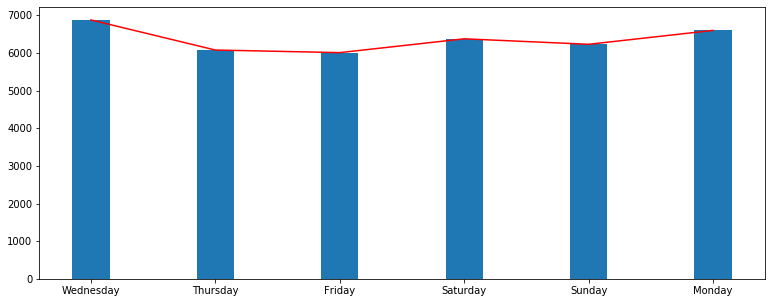

In [68]:
#PLOTEAMOS LA AUDIENCIA MEDIA POR DÍA DE LA SEMANA
df_sem = pr3.groupby(pd.Grouper(freq = 'D' )).mean()

f, ax = plt.subplots(figsize=(13,5))
plt.bar(df_sem.index, df_sem['Ind. 4+ (inv).1'].values, width= 0.3, tick_label = df_sem.index.day_name())
plt.plot(df_sem, color = 'red')

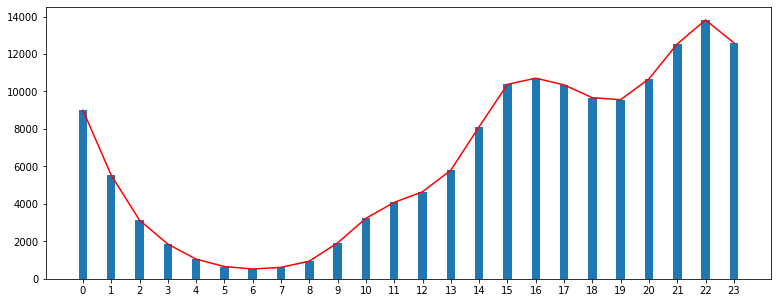

In [75]:
#PLOTEAMOS LA AUDIENCIA MEDIA POR HORA
df_hora = pr3.groupby(pr3.index.hour).mean()

f, ax = plt.subplots(figsize=(13,5))
plt.bar(df_hora.index, df_hora['Ind. 4+ (inv).1'].values, width= 0.3,tick_label = df_hora.index)
plt.plot(df_hora, color = 'red')

In [ ]:
datetime.datetime.combine(datetime.date(2011, 01, 01), datetime.time(10, 23))

In [43]:
df_h_d.index.get_level_values(1)

Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
            ...
            17, 18, 19, 20, 21, 22, 23,  0,  1,  2],
           dtype='int64', name='Fecha_comp', length=121)

In [56]:
df_h_d.index[0][1]

2

In [57]:
datetime.datetime.combine(df_h_d.index[0][0], datetime.time(df_h_d.index[0][1],0))

datetime.datetime(2020, 1, 1, 2, 0)

In [58]:
df_h_d.index = df.index.map(lambda x : datetime.datetime.combine(x[0], datetime.time([x[1],0])) )

TypeError: 'int' object is not subscriptable

In [68]:
pr3.groupby([pr3.timedelta(hours = 1)]).mean()

KeyError: datetime.timedelta(seconds=3600)

In [27]:

df_h_d = pr3.groupby([pr3.index.date, pr3.index.hour]).mean()

#f, ax = plt.subplots(figsize=(13,5))
#plt.plot(df_h_d['Ind. 4+ (inv).1'], color = 'red')
df_h_d.head(10)

Ind. 4+ (inv).1
           Fecha_comp                 
2020-01-01 2               5350.542667
           3               3621.031450
           4               1992.574883
           5               1080.466950
           6                703.495550
           7                544.246583
           8                652.619383
           9               1308.623867
           10              3049.454783
           11              5260.825233

In [34]:
df_h_d.index[120]

(datetime.date(2020, 1, 6), 2)

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = SARIMAX(pr3, order = (2, 0, 3),freq='T').fit()
prediction = model.get_forecast(steps = 4350)
lower = prediction.conf_int()["lower Ind. 4+ (inv).1"]
upper = prediction.conf_int()["upper Ind. 4+ (inv).1"]
fig, ax = plt.subplots()
pr3.truncate(before = "2020-01-04 02:30:00").plot(ax = ax,figsize = (14, 8))
prediction.predicted_mean.plot(ax = ax)
ax.fill_between(lower.index, lower, upper, alpha = 0.4)
plt.show()

/home/javier/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.

/home/javier/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



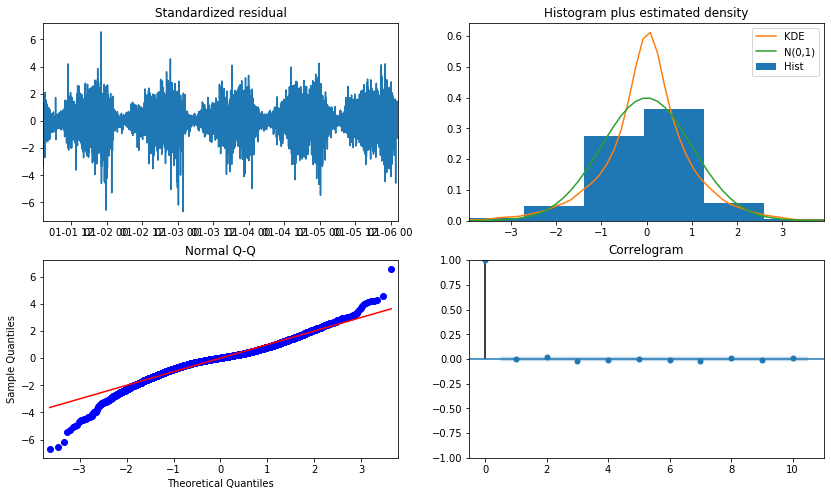

In [130]:
model.plot_diagnostics(figsize = (14, 8))
plt.show()

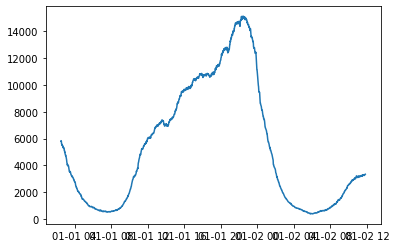

In [147]:
plt.plot(ser[0:2000])

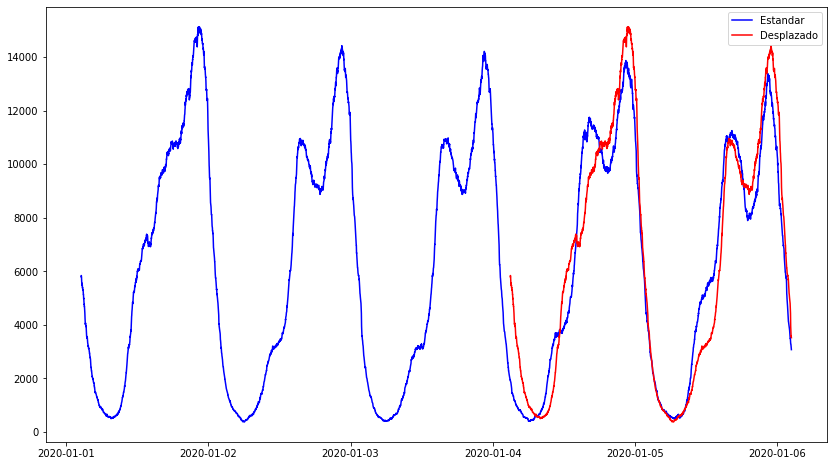

0.9555791063192989


In [226]:
lags = 4350
plt.figure(figsize=(14,8))
plt.plot(pr3['Ind. 4+ (inv).1'],label='Estandar', color = 'blue')
plt.plot(ser[:].shift(lags), label='Desplazado', color = 'red')
plt.legend()

plt.show()
print(ser.corr(ser.shift(lags)))

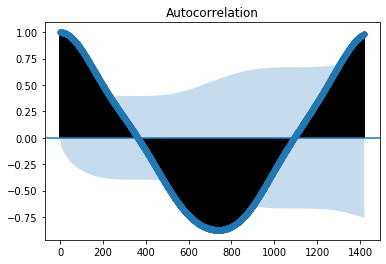

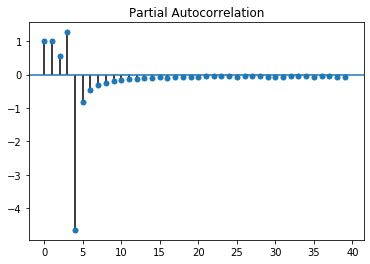

In [239]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(pr3,lags = 1420, unbiased = True)
plot_pacf(pr3)
plt.show()

In [28]:
from statsmodels.tsa.stattools import adfuller

In [29]:
adfuller(ser)

(-4.9198028904536235,
 3.190769111090481e-05,
 35,
 7164,
 {'1%': -3.43126312739421,
  '5%': -2.8619435304007217,
  '10%': -2.5669847951004168},
 73857.78619718425)

In [35]:
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-01 04:17:00')) & (df1['Cadena']== 'REAL MADRID HD')]

Fecha_comp                 Título/Descripción          Cadena  \
174475 2020-01-01 04:17:00                        HOY JUGAMOS  REAL MADRID HD   
174605 2020-01-01 04:17:00  CONECTA ENTREVISTA / HUGO SANCHEZ  REAL MADRID HD   

             Género Público objetivo              Productora  \
174475     DEPORTES         FAMILIAR  REAL MADRID MULTIMEDIA   
174605  INFORMACIÓN         FAMILIAR  REAL MADRID MULTIMEDIA   

       Calificación de Edad                                            Target  
174475         Sin Preaviso  [0.012, 0.0, 0.0, 0.013, 5.205, 0.0, 0.0, 5.205]  
174605   Todos los Públicos  [0.012, 0.0, 0.0, 0.013, 5.205, 0.0, 0.0, 5.205]

In [14]:
df1[df1['Cadena'] == 'BOING'].iloc[114:120,:]

Fecha_comp Título/Descripción Cadena   Género  \
109696 2020-01-01 02:26:00    MR.BEAN-DIBUJOS  BOING  FICCIÓN   
109697 2020-01-01 02:27:00    MR.BEAN-DIBUJOS  BOING  FICCIÓN   
109698 2020-01-01 02:28:00    MR.BEAN-DIBUJOS  BOING  FICCIÓN   
109699 2020-01-01 02:29:00    MR.BEAN-DIBUJOS  BOING  FICCIÓN   
109700 2020-01-01 02:30:00    MR.BEAN-DIBUJOS  BOING  FICCIÓN   
109701 2020-01-01 02:31:00    MR.BEAN-DIBUJOS  BOING  FICCIÓN   

       Público objetivo       Productora Calificación de Edad  \
109696         FAMILIAR  MULTIPRODUCTORA   Todos los Públicos   
109697         FAMILIAR  MULTIPRODUCTORA   Todos los Públicos   
109698         FAMILIAR  MULTIPRODUCTORA   Todos los Públicos   
109699         FAMILIAR  MULTIPRODUCTORA   Todos los Públicos   
109700         FAMILIAR  MULTIPRODUCTORA   Todos los Públicos   
109701         FAMILIAR  MULTIPRODUCTORA   Todos los Públicos   

                                          Target  
109696  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
109697  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
109698  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
109699  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
109700  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
109701  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
df1[df1['Cadena'] == 'BOING'].iloc[1620:1654,:]

Fecha_comp      Título/Descripción Cadena   Género  \
266584 2020-01-02 05:28:00       THE HAPPOS FAMILY  BOING  FICCIÓN   
266585 2020-01-02 05:30:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266586 2020-01-02 05:31:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266587 2020-01-02 05:32:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266588 2020-01-02 05:33:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266589 2020-01-02 05:34:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266590 2020-01-02 05:35:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266591 2020-01-02 05:36:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266592 2020-01-02 05:37:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266593 2020-01-02 05:38:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266594 2020-01-02 05:39:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266595 2020-01-02 05:40:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266596 2020-01-02 05:41:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266597 2020-01-02 05:42:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266598 2020-01-02 05:43:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266599 2020-01-02 05:44:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266600 2020-01-02 05:45:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266601 2020-01-02 05:46:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266602 2020-01-02 05:47:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266603 2020-01-02 05:48:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266604 2020-01-02 05:49:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266605 2020-01-02 05:50:00  EL SHOW DE TOM Y JERRY  BOING  FICCIÓN   
266606 2020-01-02 05:52:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266607 2020-01-02 05:53:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266608 2020-01-02 05:54:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266609 2020-01-02 05:55:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266610 2020-01-02 05:56:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266611 2020-01-02 05:57:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266612 2020-01-02 05:58:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266613 2020-01-02 05:59:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266614 2020-01-02 06:00:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266615 2020-01-02 06:01:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266616 2020-01-02 06:02:00        NEW LOONEY TUNES  BOING  FICCIÓN   
266617 2020-01-02 06:03:00        NEW LOONEY TUNES  BOING  FICCIÓN   

       Público objetivo             Productora Calificación de Edad  \
266584         FAMILIAR              BOOMERANG   Todos los Públicos   
266585         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266586         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266587         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266588         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266589         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266590         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266591         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266592         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266593         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266594         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266595         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266596         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266597         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266598         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266599         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266600         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266601         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266602         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266603         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266604         FAMILIAR  WARNER BROS ANIMATION   Todos los Públicos   
266

In [1]:
counter = 0
for i,v in enumerate(df1[df1['Cadena'] == 'BOING'].Target):
        if len(np.where(v == 0.0)[0]) == 8  :
            print(i,v)
            counter+=1
print(counter)

NameError: name 'df1' is not defined

In [4]:
X = df1.drop(['Target','Fecha_comp'], axis=1)
y = df1.Target
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [7]:
cop.head()

Cadena_#VAMOS  Cadena_24H  Cadena_3/24  Cadena_8MADRID  Cadena_8TV  \
0              0           0            0               0           0   
1              0           0            0               0           0   
2              0           0            0               0           0   
3              0           0            0               0           0   
4              0           0            0               0           0   

   Cadena_A PUNT  Cadena_A3  Cadena_AMC  Cadena_AND-TV  Cadena_ARAGON TV  ...  \
0              0          0           0              0                 0  ...   
1              0          0           0              0                 0  ...   
2              0          0           0              0                 0  ...   
3              0          0           0              0                 0  ...   
4              0          0           0              0                 0  ...   

   Calificación de Edad_+13 años permanente  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   Calificación de Edad_+16 años no permanente  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Calificación de Edad_+16 años permanente  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   Calificación de Edad_+18 años no permanente  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Calificación de Edad_+18 años permanente  Calificación de Edad_+7 años  \
0                                         0                             0   
1                                         0                             0   
2                                         0                             0   
3                                         0                             0   
4                                         0                             0   

   Calificación de Edad_Especial Infancia  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   Calificación de Edad_Sin Clasificar  Calificación de Edad_Sin Preaviso  \
0                                    0                                  1   
1                                    0                                  1   
2                                    0                                  1   
3                                    0                                  1   
4                                    0                                  1   

   Calificación de Edad_Todos los Públicos  
0                                        0  
1                                        0  
2                                        0  
3                                        0  
4                                        0  

[5 rows x 976 columns]

In [4]:
#ANALIZAMOS CUANTAS DESCONEXIONES REGIONALES CONTIENE CADA CADENA
df1[df1['Título/Descripción'].str.contains('D.REG')].pivot_table(index=['Cadena'], aggfunc='size').sort_values(ascending=False)

Cadena
La2     367
La1     239
T5        9
A3        9
NOVA      7
dtype: int64

In [5]:
#CUENTO DUPLICADOS PARA CADA CADENA
counter = 1
for i in df1.Cadena.unique():
    print(counter)
    print(i,'-----', df1[df1['Cadena'] == i ].pivot_table(index=['Fecha_comp'], aggfunc='size').unique())
    counter += 1

1
La1 ----- [ 1  2 15 16 17  3 18  4]
2
La2 ----- [1 2 3 5 4]
3
T5 ----- [1 2 3]
4
A3 ----- [1 2 3 4]
5
CUATRO ----- [1]
6
LA SEXTA ----- [1 2]
7
24H ----- [1 2 3]
8
NEOX ----- [1 2]
9
NOVA ----- [1 2 3 4 5]
10
AXN ----- [1]
11
BARÇA TV ----- [1 2]
12
BLAZE ----- [1]
13
HISTORIA ----- [1 2 3]
14
MOVISTAR ACCION ----- [1]
15
MOVISTAR COMEDIA ----- [1]
16
MOVISTAR DRAMA ----- [1]
17
MOVISTAR DEPORTES ----- [2 1 3]
18
CALLE 13 ----- [1]
19
CANAL COCINA ----- [1]
20
CANAL HOLLYWOOD ----- [1]
21
CAZA Y PESCA ----- [1]
22
SUNDANCE TV ----- [1 2]
23
CLAN ----- [1 2]
24
COSMOPOLITAN ----- [1 2]
25
DARK ----- [1 2]
26
MOVISTAR CINE ESPAÑOL ----- [1]
27
DECASA ----- [1 2 3]
28
DISCOVERY ----- [1 2]
29
DISNEY CH +1 ----- [1 2]
30
DISNEY CHANNEL ----- [1 2]
31
EUROSPORT ----- [1 2]
32
XTRM ----- [1 2]
33
FDF ----- [1 2]
34
FOX ----- [1]
35
MOVISTAR GOLF ----- [1 2]
36
MTV ESP ----- [1 2 3]
37
NATIONAL GEOGRAPHIC ----- [1]
38
NICKELODEON ----- [1 2]
39
ODISEA ----- [1 2]
40
PANDA ----- [1 2]
41
COM

In [105]:
#VISUALIZO LAS MARCAS HORARIAS QUE TIENEN MULTIPLES REGISTROS
pd.set_option('display.max_rows', None)
df1[df1['Cadena'] == 'REAL MADRID HD'].pivot_table(index=['Fecha_comp'], aggfunc='size').sort_values(ascending=False)

Fecha_comp
2020-01-01 04:17:00    3
2020-01-04 10:47:00    3
2020-01-02 12:33:00    3
2020-01-02 12:32:00    3
2020-01-02 12:31:00    3
2020-01-02 12:30:00    3
2020-01-04 01:12:00    3
2020-01-02 12:26:00    3
2020-01-03 00:05:00    3
2020-01-01 06:07:00    3
2020-01-05 13:57:00    3
2020-01-02 04:27:00    3
2020-01-03 06:11:00    3
2020-01-01 01:31:00    3
2020-01-02 08:16:00    3
2020-01-01 11:58:00    3
2020-01-03 01:49:00    3
2020-01-02 12:34:00    3
2020-01-01 11:08:00    3
2020-01-01 01:09:00    3
2020-01-01 11:07:00    3
2020-01-02 06:10:00    3
2020-01-03 04:27:00    3
2020-01-03 10:28:00    3
2020-01-02 23:07:00    3
2020-01-01 10:33:00    3
2020-01-01 09:16:00    3
2020-01-04 00:22:00    3
2020-01-01 10:49:00    3
2020-01-01 08:56:00    3
2020-01-02 01:03:00    3
2020-01-04 18:29:00    3
2020-01-01 23:10:00    3
2020-01-01 23:09:00    3
2020-01-03 22:32:00    3
2020-01-01 03:23:00    3
2020-01-04 08:49:00    3
2020-01-01 09:55:00    3
2020-01-03 12:34:00    3
2020-01-03 12:

In [107]:
#VISUALIZO LOS REGISTROS QUE REPITEN UNA MARCA HORARIA DETERMINADA
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-03 14:19:00')) & (df1['Cadena']== 'REAL MADRID HD')]

Fecha_comp Título/Descripción          Cadena   Género  \
456649 2020-01-03 14:19:00     CINE / MADISON  REAL MADRID HD  FICCIÓN   

       Público objetivo       Productora Calificación de Edad  \
456649         FAMILIAR  MULTIPRODUCTORA   Todos los Públicos   

                                                   Target  
456649  [0.08, 0.094, 0.0, 0.092, 36.059, 17.385, 0.0,...

In [81]:
#OBSERVO CUANTOS REGISTROS CON DESC. REG. HAY POR MARCA HORARIA
df1[(df1['Título/Descripción'].str.contains('D.REG'))&(df1['Cadena']=='La1')].pivot_table(index=['Fecha_comp'], aggfunc='size')

Fecha_comp
2020-01-02 11:59:00    1
2020-01-02 12:00:00    1
2020-01-02 12:01:00    1
2020-01-02 12:02:00    1
2020-01-02 12:03:00    1
2020-01-02 12:04:00    1
2020-01-02 12:05:00    1
2020-01-02 12:06:00    1
2020-01-02 12:07:00    1
2020-01-02 12:08:00    1
2020-01-02 12:09:00    1
2020-01-02 12:10:00    1
2020-01-02 12:11:00    1
2020-01-02 12:12:00    1
2020-01-02 12:13:00    1
2020-01-02 12:14:00    1
2020-01-02 12:15:00    1
2020-01-02 12:16:00    1
2020-01-02 12:17:00    1
2020-01-02 12:18:00    1
2020-01-02 12:19:00    1
2020-01-02 12:20:00    1
2020-01-02 12:21:00    1
2020-01-02 12:22:00    1
2020-01-02 12:23:00    1
2020-01-02 12:24:00    1
2020-01-02 12:25:00    1
2020-01-02 12:26:00    1
2020-01-02 14:00:00    1
2020-01-02 14:01:00    1
2020-01-02 14:02:00    1
2020-01-02 14:03:00    1
2020-01-02 14:04:00    1
2020-01-02 14:05:00    1
2020-01-02 14:06:00    1
2020-01-02 14:07:00    1
2020-01-02 14:08:00    1
2020-01-02 14:09:00    1
2020-01-02 14:10:00    1
2020-01-02 14:

In [44]:
#CREO EL DATA FRAME CON LAS VARIABLES CATEGÓRICAS
df_cat = df1[['Cadena', 'Género', 'Público objetivo', 'Productora','Calificación de Edad']]

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [9]:
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [18]:
y_2 = df1.Target[0]

0.88

In [13]:
cop.dtypes.unique()

array([dtype('<M8[ns]'), dtype('uint8')], dtype=object)

In [33]:
reg = LinearRegression()

In [43]:
# Load the library
from sklearn.tree import DecisionTreeRegressor
# Create an instance
regd = DecisionTreeRegressor(max_depth=3)
# Fit the data
cross_val_score(regd, cop, y)

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: invalid type promotion

  FitFailedWarning)


array([nan, nan, nan, nan, nan])